In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os
from ctapipe.io.lsteventsource import LSTEventSource
from ctapipe.io import EventSeeker

# Functions to compute pedestal, rms of capacitor and make plot

In [2]:
class DragonPedestal:
    n_pixels = 7
    roisize = 40
    size4drs = 4*1024
    high_gain = 0
    low_gain = 1

    def __init__(self):
        self.first_capacitor = np.zeros((2, 8))
        self.meanped = np.zeros((2, self.n_pixels, self.size4drs))
        self.numped = np.zeros((2, self.n_pixels, self.size4drs))
        self.rms = np.zeros((2, self.n_pixels, self.size4drs))

    def fill_pedestal_event(self, event, nr):
        first_cap = event.lst.tel[0].evt.first_capacitor_id[nr * 8:(nr + 1) * 8]
        for channel_hg in [0, 2, 4, 6]:
            self.first_capacitor[self.high_gain, channel_hg] = first_cap[channel_hg]
            self.first_capacitor[self.high_gain, channel_hg + 1] = first_cap[channel_hg]
        for channel_lg in [1, 3, 5, 7]:
            self.first_capacitor[self.low_gain, channel_lg - 1] = first_cap[channel_lg]
            self.first_capacitor[self.low_gain, channel_lg] = first_cap[channel_lg]
        waveform = event.r0.tel[0].waveform[:, nr * 7:(nr + 1) * 7, :]
        for i in range(0, 2):
            for j in range(0, self.n_pixels):
                fc = int(self.first_capacitor[i, j])
                for k in range(2, self.roisize-2):
                    posads = int((k+fc)%self.size4drs)
                    val = waveform[i, j, k]
                    self.meanped[i, j, posads] += val
                    self.numped[i, j, posads] += 1
                    self.rms[i, j, posads] += val**2

    def finalize_pedestal(self):
        try:
            self.meanped = self.meanped/self.numped
            self.rms = self.rms/self.numped
            self.rms = np.sqrt(self.rms - self.meanped**2)
        except Exception as err:
            print(err)

                
def get_rms_of_module(path_to_data, nr_module):
    reader = LSTEventSource(input_url=path_to_data)
    seeker = EventSeeker(reader)
    high_gain = 0
    low_gain = 1
    ped = DragonPedestal()
    for i in range(0, 5500):
        ev = seeker[i]
        ped.fill_pedestal_event(ev, nr_module)
    ped.finalize_pedestal()
    print("Module: {}".format(nr_module))
    for gain in [high_gain, low_gain]:
        for pix in range(0, 7):
            if gain == high_gain:
                print("High gain: pixel = {} mean RMS = {}".format(pix, np.mean(ped.rms[high_gain, pix, :])))
            if gain == low_gain:
                print("Low gain: pixel = {} mean RMS = {}".format(pix, np.mean(ped.rms[low_gain, pix, :])))
    return ped.rms

def plot_box(nr, rms_array):
    hg = 0 #high gain
    lg = 1 #low gain
    rms_hg = [rms_array[nr, hg, 0, :], rms_array[nr, hg, 1, :], rms_array[nr, hg, 2, :], rms_array[nr, hg, 3, :],
                rms_array[nr, hg, 4, :], rms_array[nr, hg, 5, :], rms_array[nr, hg, 6, :]]
    rms_lg = [rms_array[nr, 1, lg, :], rms_array[nr, lg, 1, :], rms_array[nr, lg, 2, :], rms_array[nr, lg, 3, :],
                   rms_array[nr, lg, 4, :], rms_array[nr, lg, 5, :], rms_array[nr, lg, 6, :]]

    fig, ax = plt.subplots(1, 2)
    bp = ax[0].boxplot(rms_hg, vert=0)
    ax[0].set_title("Module = {} high gain".format(nr))
    ax[0].set_xlabel("RMS")
    ax[0].set_xlim([0, 200]) # here you can change x axis range for high gain
    ax[0].set_yticklabels(['pixel 0', 'pixel 1', 'pixel 2', 'pixel 3', 'pixel 4', 'pixel 5', 'pixel 6'])

    bp = ax[1].boxplot(rms_lg, vert=0)
    ax[1].set_title("Module = {} low gain".format(nr))
    ax[1].set_xlabel("RMS")
    ax[1].set_xlim([0, 200]) # here you can change x axis range for low gain
    ax[1].set_yticklabels(['pixel 0', 'pixel 1', 'pixel 2', 'pixel 3', 'pixel 4', 'pixel 5', 'pixel 6'])
    plt.subplots_adjust(wspace=0.3)
    plt.show()

# Read data 

In [11]:
path_to_data = os.path.join("/home", "pawel1", "Pulpit", "Astrophysics", "CTA", "dragon",
                            "data", "dane_lst", "20180629", "Date20180629.0001.fits.fz")
# you can also use this way: path_to_data = "/home/pawel1/Pulpit/Astrophysics/CTA/dragon/data/dane_lst/20180629/Date20180629.0001.fits.fz"

reader = LSTEventSource(input_url=path_to_data)
seeker = EventSeeker(reader)
ev = seeker[0]
num_modules = ev.lst.tel[0].svc.num_modules
NR = num_modules # numbers of module 
rms_cap_array = np.zeros((NR, 2, 7, 4096))


for nr in range(0, NR): # Here you can chose for which module you want compute RMS
    rms_cap_array[nr, :, :, :] = get_rms_of_module(path_to_data, nr)

/home/pawel1/anaconda3/envs/cta-dev/lib/python3.6/site-packages/protozfits/__init__.py:56: UserWarning:         Multiple open zfits files at the same time are not supported.
        Reading from mutliple open tables at the same time will reset these
        tables continously and you will read always the same events.
        
  ''')


Module: 0
High gain: pixel = 0 mean RMS = 10.05843952661598
High gain: pixel = 1 mean RMS = 11.132068423618154
High gain: pixel = 2 mean RMS = 16.474015823379172
High gain: pixel = 3 mean RMS = 20.327478117792225
High gain: pixel = 4 mean RMS = 18.601292920502033
High gain: pixel = 5 mean RMS = 20.770214186717094
High gain: pixel = 6 mean RMS = 16.490522828543327
Low gain: pixel = 0 mean RMS = 14.35395907574378
Low gain: pixel = 1 mean RMS = 17.068673537050273
Low gain: pixel = 2 mean RMS = 13.705429903506845
Low gain: pixel = 3 mean RMS = 16.659793906574208
Low gain: pixel = 4 mean RMS = 14.208443270361157
Low gain: pixel = 5 mean RMS = 17.248486748250812
Low gain: pixel = 6 mean RMS = 4.944189401902631


Module: 1
High gain: pixel = 0 mean RMS = 8.749706140243728
High gain: pixel = 1 mean RMS = 9.178522170284502
High gain: pixel = 2 mean RMS = 15.851175060871695
High gain: pixel = 3 mean RMS = 17.216714085639637
High gain: pixel = 4 mean RMS = 15.625537797148638
High gain: pixel = 5 mean RMS = 16.466668573750088
High gain: pixel = 6 mean RMS = 17.181741164786473
Low gain: pixel = 0 mean RMS = 11.81511885233753
Low gain: pixel = 1 mean RMS = 13.091582226126373
Low gain: pixel = 2 mean RMS = 14.232720178847096
Low gain: pixel = 3 mean RMS = 14.716877440461932
Low gain: pixel = 4 mean RMS = 14.321926252221587
Low gain: pixel = 5 mean RMS = 14.87420933972745
Low gain: pixel = 6 mean RMS = 3.5731252153372504


Module: 2
High gain: pixel = 0 mean RMS = 8.145117712528362
High gain: pixel = 1 mean RMS = 8.896856518524352
High gain: pixel = 2 mean RMS = 14.441906510759704
High gain: pixel = 3 mean RMS = 15.93331128061534
High gain: pixel = 4 mean RMS = 15.182985876661853
High gain: pixel = 5 mean RMS = 16.2611696267382
High gain: pixel = 6 mean RMS = 15.002050811599135
Low gain: pixel = 0 mean RMS = 11.622571430974862
Low gain: pixel = 1 mean RMS = 12.534708503402388
Low gain: pixel = 2 mean RMS = 12.788976315499065
Low gain: pixel = 3 mean RMS = 13.481065155979408
Low gain: pixel = 4 mean RMS = 12.15195644920429
Low gain: pixel = 5 mean RMS = 13.597725535074257
Low gain: pixel = 6 mean RMS = 3.5113053499942977


Module: 3
High gain: pixel = 0 mean RMS = 9.457370547294566
High gain: pixel = 1 mean RMS = 10.782390280249361
High gain: pixel = 2 mean RMS = 16.085978475021726
High gain: pixel = 3 mean RMS = 19.733096461253666
High gain: pixel = 4 mean RMS = 18.96252734372316
High gain: pixel = 5 mean RMS = 20.689720228168422
High gain: pixel = 6 mean RMS = 16.088593170594525
Low gain: pixel = 0 mean RMS = 13.092183892178015
Low gain: pixel = 1 mean RMS = 16.18534501613137
Low gain: pixel = 2 mean RMS = 13.425624882656907
Low gain: pixel = 3 mean RMS = 16.317271222414888
Low gain: pixel = 4 mean RMS = 14.71513747254977
Low gain: pixel = 5 mean RMS = 17.061123608854437
Low gain: pixel = 6 mean RMS = 4.56264828108273


Module: 4
High gain: pixel = 0 mean RMS = 9.256442779347992
High gain: pixel = 1 mean RMS = 10.184612132732244
High gain: pixel = 2 mean RMS = 17.221759996642557
High gain: pixel = 3 mean RMS = 20.103627322392644
High gain: pixel = 4 mean RMS = 17.595894890484324
High gain: pixel = 5 mean RMS = 19.162388821546372
High gain: pixel = 6 mean RMS = 15.37679029735542
Low gain: pixel = 0 mean RMS = 12.96414749652805
Low gain: pixel = 1 mean RMS = 16.566114254471096
Low gain: pixel = 2 mean RMS = 13.868454627281382
Low gain: pixel = 3 mean RMS = 16.20696195042555
Low gain: pixel = 4 mean RMS = 13.561229140906807
Low gain: pixel = 5 mean RMS = 16.241084279509113
Low gain: pixel = 6 mean RMS = 4.795768565763675


Module: 5
High gain: pixel = 0 mean RMS = 8.522313465976033
High gain: pixel = 1 mean RMS = 8.850444023696731
High gain: pixel = 2 mean RMS = 16.579035926700428
High gain: pixel = 3 mean RMS = 16.78005061647515
High gain: pixel = 4 mean RMS = 16.404812954705434
High gain: pixel = 5 mean RMS = 16.86324567085736
High gain: pixel = 6 mean RMS = 15.773926093073902
Low gain: pixel = 0 mean RMS = 13.847021177966766
Low gain: pixel = 1 mean RMS = 14.58340298924541
Low gain: pixel = 2 mean RMS = 11.826837591432692
Low gain: pixel = 3 mean RMS = 12.585224773122238
Low gain: pixel = 4 mean RMS = 12.019102831969146
Low gain: pixel = 5 mean RMS = 12.774780678226605
Low gain: pixel = 6 mean RMS = 3.5139250628442893


Module: 6
High gain: pixel = 0 mean RMS = 10.296896254399137
High gain: pixel = 1 mean RMS = 10.605451819469241
High gain: pixel = 2 mean RMS = 18.015627536934183
High gain: pixel = 3 mean RMS = 20.51161625663138
High gain: pixel = 4 mean RMS = 17.131338298346495
High gain: pixel = 5 mean RMS = 20.441890000604527
High gain: pixel = 6 mean RMS = 15.319043165161435
Low gain: pixel = 0 mean RMS = 14.042063249785157
Low gain: pixel = 1 mean RMS = 17.629835484156114
Low gain: pixel = 2 mean RMS = 14.287371505573969
Low gain: pixel = 3 mean RMS = 17.460605311073124
Low gain: pixel = 4 mean RMS = 15.480356703370102
Low gain: pixel = 5 mean RMS = 18.298904348746895
Low gain: pixel = 6 mean RMS = 5.013639796388657


Module: 7
High gain: pixel = 0 mean RMS = 9.42227282320556
High gain: pixel = 1 mean RMS = 9.440825496807236
High gain: pixel = 2 mean RMS = 15.378193565667395
High gain: pixel = 3 mean RMS = 18.767026505863914
High gain: pixel = 4 mean RMS = 16.632621066380466
High gain: pixel = 5 mean RMS = 18.19257955866187
High gain: pixel = 6 mean RMS = 16.64034641688064
Low gain: pixel = 0 mean RMS = 11.970852004996031
Low gain: pixel = 1 mean RMS = 14.667730695201048
Low gain: pixel = 2 mean RMS = 13.433613695037266
Low gain: pixel = 3 mean RMS = 15.870282450412047
Low gain: pixel = 4 mean RMS = 12.326407627135795
Low gain: pixel = 5 mean RMS = 15.707763898467949
Low gain: pixel = 6 mean RMS = 3.5702893951084818


Module: 8
High gain: pixel = 0 mean RMS = 10.306874287581913
High gain: pixel = 1 mean RMS = 10.920791689055978
High gain: pixel = 2 mean RMS = 16.37408051897597
High gain: pixel = 3 mean RMS = 20.112769070363
High gain: pixel = 4 mean RMS = 16.85283256245603
High gain: pixel = 5 mean RMS = 19.13061320036654
High gain: pixel = 6 mean RMS = 17.92206659212038
Low gain: pixel = 0 mean RMS = 14.14174187006396
Low gain: pixel = 1 mean RMS = 16.372604501901513
Low gain: pixel = 2 mean RMS = 16.091869693401694
Low gain: pixel = 3 mean RMS = 18.337155128205126
Low gain: pixel = 4 mean RMS = 13.604071649570876
Low gain: pixel = 5 mean RMS = 16.799817135192963
Low gain: pixel = 6 mean RMS = 4.814887235842072


Module: 9
High gain: pixel = 0 mean RMS = 10.509309151745903
High gain: pixel = 1 mean RMS = 11.279571517745953
High gain: pixel = 2 mean RMS = 16.973555087454752
High gain: pixel = 3 mean RMS = 21.181777393115027
High gain: pixel = 4 mean RMS = 17.568835954910355
High gain: pixel = 5 mean RMS = 21.18959675262314
High gain: pixel = 6 mean RMS = 16.78584276723973
Low gain: pixel = 0 mean RMS = 12.707121226514214
Low gain: pixel = 1 mean RMS = 16.5979026289462
Low gain: pixel = 2 mean RMS = 13.799114278567812
Low gain: pixel = 3 mean RMS = 17.638186854792117
Low gain: pixel = 4 mean RMS = 15.882867817274558
Low gain: pixel = 5 mean RMS = 19.480899571026832
Low gain: pixel = 6 mean RMS = 5.619981546014434


Module: 10
High gain: pixel = 0 mean RMS = 8.221295822615767
High gain: pixel = 1 mean RMS = 8.307245946251
High gain: pixel = 2 mean RMS = 15.355664945566579
High gain: pixel = 3 mean RMS = 15.376407327626705
High gain: pixel = 4 mean RMS = 13.244008455489723
High gain: pixel = 5 mean RMS = 13.417144017276016
High gain: pixel = 6 mean RMS = 13.69139728845745
Low gain: pixel = 0 mean RMS = 10.835816092071537
Low gain: pixel = 1 mean RMS = 10.817154433046902
Low gain: pixel = 2 mean RMS = 12.044274865000558
Low gain: pixel = 3 mean RMS = 11.941774646205882
Low gain: pixel = 4 mean RMS = 10.905910360552905
Low gain: pixel = 5 mean RMS = 10.996333299785896
Low gain: pixel = 6 mean RMS = 3.4939102353447424


Module: 11
High gain: pixel = 0 mean RMS = 8.638687057312012
High gain: pixel = 1 mean RMS = 9.085343904543926
High gain: pixel = 2 mean RMS = 15.592397195449905
High gain: pixel = 3 mean RMS = 18.356473808511026
High gain: pixel = 4 mean RMS = 15.732165981638179
High gain: pixel = 5 mean RMS = 16.403197494746294
High gain: pixel = 6 mean RMS = 17.54271469057565
Low gain: pixel = 0 mean RMS = 15.36424336211095
Low gain: pixel = 1 mean RMS = 16.16398998538618
Low gain: pixel = 2 mean RMS = 13.34965608716918
Low gain: pixel = 3 mean RMS = 15.804451374781138
Low gain: pixel = 4 mean RMS = 12.566024055456399
Low gain: pixel = 5 mean RMS = 14.774339432404577
Low gain: pixel = 6 mean RMS = 3.6727309098855905


Module: 12
High gain: pixel = 0 mean RMS = 9.041194470401082
High gain: pixel = 1 mean RMS = 9.530529023222062
High gain: pixel = 2 mean RMS = 17.487473286943334
High gain: pixel = 3 mean RMS = 18.713917022759205
High gain: pixel = 4 mean RMS = 16.61676775613764
High gain: pixel = 5 mean RMS = 18.09399971510446
High gain: pixel = 6 mean RMS = 17.41684441811227
Low gain: pixel = 0 mean RMS = 14.312399551924848
Low gain: pixel = 1 mean RMS = 16.569987015383116
Low gain: pixel = 2 mean RMS = 13.684139581198874
Low gain: pixel = 3 mean RMS = 14.765789630931643
Low gain: pixel = 4 mean RMS = 13.351800157456795
Low gain: pixel = 5 mean RMS = 15.117112142981963
Low gain: pixel = 6 mean RMS = 3.771979041745089


Module: 13
High gain: pixel = 0 mean RMS = 9.120187638538134
High gain: pixel = 1 mean RMS = 9.726366422613108
High gain: pixel = 2 mean RMS = 18.432596368811055
High gain: pixel = 3 mean RMS = 18.984957928816268
High gain: pixel = 4 mean RMS = 16.71569267045936
High gain: pixel = 5 mean RMS = 18.086671415678822
High gain: pixel = 6 mean RMS = 16.39437779577257
Low gain: pixel = 0 mean RMS = 13.457762502015594
Low gain: pixel = 1 mean RMS = 16.07674882280191
Low gain: pixel = 2 mean RMS = 14.705909928887204
Low gain: pixel = 3 mean RMS = 16.0847108196948
Low gain: pixel = 4 mean RMS = 13.335512603284261
Low gain: pixel = 5 mean RMS = 16.48751452519423
Low gain: pixel = 6 mean RMS = 3.621447750340536


Module: 14
High gain: pixel = 0 mean RMS = 8.806660135043943
High gain: pixel = 1 mean RMS = 9.080140509873425
High gain: pixel = 2 mean RMS = 16.028980201443318
High gain: pixel = 3 mean RMS = 17.602682465791414
High gain: pixel = 4 mean RMS = 16.467421576758603
High gain: pixel = 5 mean RMS = 17.437542333098655
High gain: pixel = 6 mean RMS = 16.018079774386898
Low gain: pixel = 0 mean RMS = 12.985144355250227
Low gain: pixel = 1 mean RMS = 14.778429558737761
Low gain: pixel = 2 mean RMS = 14.241900343532544
Low gain: pixel = 3 mean RMS = 15.803346860269821
Low gain: pixel = 4 mean RMS = 15.180260580814522
Low gain: pixel = 5 mean RMS = 16.42643822195251
Low gain: pixel = 6 mean RMS = 3.590759664003991


Module: 15
High gain: pixel = 0 mean RMS = 9.937341722085772
High gain: pixel = 1 mean RMS = 10.507761396654098
High gain: pixel = 2 mean RMS = 17.580000207635976
High gain: pixel = 3 mean RMS = 20.18054683546127
High gain: pixel = 4 mean RMS = 16.08957099598254
High gain: pixel = 5 mean RMS = 18.82762801587933
High gain: pixel = 6 mean RMS = 16.86936010250268
Low gain: pixel = 0 mean RMS = 14.493677140001566
Low gain: pixel = 1 mean RMS = 17.80240076261481
Low gain: pixel = 2 mean RMS = 14.552473579763932
Low gain: pixel = 3 mean RMS = 16.875166866685376
Low gain: pixel = 4 mean RMS = 14.248831816009746
Low gain: pixel = 5 mean RMS = 16.608748267425604
Low gain: pixel = 6 mean RMS = 4.94184079394546


Module: 16
High gain: pixel = 0 mean RMS = 9.339780467461338
High gain: pixel = 1 mean RMS = 9.902932660402847
High gain: pixel = 2 mean RMS = 15.956106411252936
High gain: pixel = 3 mean RMS = 19.558250422358434
High gain: pixel = 4 mean RMS = 17.88893348500896
High gain: pixel = 5 mean RMS = 20.138079644120182
High gain: pixel = 6 mean RMS = 17.735394308102347
Low gain: pixel = 0 mean RMS = 13.13865735035956
Low gain: pixel = 1 mean RMS = 16.636421060436916
Low gain: pixel = 2 mean RMS = 14.465407437927153
Low gain: pixel = 3 mean RMS = 17.26226082884842
Low gain: pixel = 4 mean RMS = 14.66437765099701
Low gain: pixel = 5 mean RMS = 17.24774667228861
Low gain: pixel = 6 mean RMS = 3.799524712262029


Module: 17
High gain: pixel = 0 mean RMS = 8.706964604293976
High gain: pixel = 1 mean RMS = 8.978093405925694
High gain: pixel = 2 mean RMS = 14.906815348098196
High gain: pixel = 3 mean RMS = 15.470622849299446
High gain: pixel = 4 mean RMS = 14.735821858423725
High gain: pixel = 5 mean RMS = 15.204507381911078
High gain: pixel = 6 mean RMS = 15.80863851514512
Low gain: pixel = 0 mean RMS = 12.18924604114
Low gain: pixel = 1 mean RMS = 12.222962408304433
Low gain: pixel = 2 mean RMS = 13.31364750040074
Low gain: pixel = 3 mean RMS = 13.349178984065166
Low gain: pixel = 4 mean RMS = 15.283744650965968
Low gain: pixel = 5 mean RMS = 15.689450385429963
Low gain: pixel = 6 mean RMS = 3.9722757590807087


Module: 18
High gain: pixel = 0 mean RMS = 9.325722851013255
High gain: pixel = 1 mean RMS = 9.514358917319498
High gain: pixel = 2 mean RMS = 16.28938731815441
High gain: pixel = 3 mean RMS = 17.956206116645205
High gain: pixel = 4 mean RMS = 15.462891840201547
High gain: pixel = 5 mean RMS = 16.651997413416794
High gain: pixel = 6 mean RMS = 15.439866240094666
Low gain: pixel = 0 mean RMS = 14.073615347337228
Low gain: pixel = 1 mean RMS = 15.372766042953629
Low gain: pixel = 2 mean RMS = 13.85869247975473
Low gain: pixel = 3 mean RMS = 14.600416246181627
Low gain: pixel = 4 mean RMS = 13.127704466150647
Low gain: pixel = 5 mean RMS = 15.123316238774615
Low gain: pixel = 6 mean RMS = 3.5635598027562683


Module: 19
High gain: pixel = 0 mean RMS = 8.650578026419327
High gain: pixel = 1 mean RMS = 9.182374444790032
High gain: pixel = 2 mean RMS = 15.288214886148495
High gain: pixel = 3 mean RMS = 17.750776917685464
High gain: pixel = 4 mean RMS = 16.060403903208783
High gain: pixel = 5 mean RMS = 18.147416224068998
High gain: pixel = 6 mean RMS = 15.673305676814802
Low gain: pixel = 0 mean RMS = 12.14821467904923
Low gain: pixel = 1 mean RMS = 14.500001978213088
Low gain: pixel = 2 mean RMS = 12.925105064878295
Low gain: pixel = 3 mean RMS = 14.935876222818251
Low gain: pixel = 4 mean RMS = 12.390356284296047
Low gain: pixel = 5 mean RMS = 14.608279066718161
Low gain: pixel = 6 mean RMS = 3.8010111497001366


Module: 20
High gain: pixel = 0 mean RMS = 8.320159174816721
High gain: pixel = 1 mean RMS = 9.265386969108107
High gain: pixel = 2 mean RMS = 15.226578705603448
High gain: pixel = 3 mean RMS = 18.301732802054104
High gain: pixel = 4 mean RMS = 15.769530446430995
High gain: pixel = 5 mean RMS = 18.093898852147532
High gain: pixel = 6 mean RMS = 15.686522449901803
Low gain: pixel = 0 mean RMS = 12.430894276709756
Low gain: pixel = 1 mean RMS = 14.779308045454464
Low gain: pixel = 2 mean RMS = 15.614719959197593
Low gain: pixel = 3 mean RMS = 16.466967623290323
Low gain: pixel = 4 mean RMS = 13.437712048626105
Low gain: pixel = 5 mean RMS = 14.772991951697364
Low gain: pixel = 6 mean RMS = 3.518207240999578


Module: 21
High gain: pixel = 0 mean RMS = 9.173277277704901
High gain: pixel = 1 mean RMS = 9.435359380525767
High gain: pixel = 2 mean RMS = 15.881565321355541
High gain: pixel = 3 mean RMS = 19.0486526145122
High gain: pixel = 4 mean RMS = 17.137127986426705
High gain: pixel = 5 mean RMS = 18.670171117927232
High gain: pixel = 6 mean RMS = 14.447800784248823
Low gain: pixel = 0 mean RMS = 13.098373576144411
Low gain: pixel = 1 mean RMS = 15.216187208737114
Low gain: pixel = 2 mean RMS = 13.716693543105006
Low gain: pixel = 3 mean RMS = 15.378140925853554
Low gain: pixel = 4 mean RMS = 13.682850930797152
Low gain: pixel = 5 mean RMS = 16.322405157226868
Low gain: pixel = 6 mean RMS = 3.567670541571442


Module: 22
High gain: pixel = 0 mean RMS = 9.950105680432433
High gain: pixel = 1 mean RMS = 10.493275617008251
High gain: pixel = 2 mean RMS = 15.472353104253916
High gain: pixel = 3 mean RMS = 20.53088929411628
High gain: pixel = 4 mean RMS = 17.382370728388018
High gain: pixel = 5 mean RMS = 20.512860258866443
High gain: pixel = 6 mean RMS = 15.73139294105832
Low gain: pixel = 0 mean RMS = 14.44371605355246
Low gain: pixel = 1 mean RMS = 18.095008841829696
Low gain: pixel = 2 mean RMS = 17.216610549681665
Low gain: pixel = 3 mean RMS = 19.51269257729551
Low gain: pixel = 4 mean RMS = 14.144635875022505
Low gain: pixel = 5 mean RMS = 19.466027945315822
Low gain: pixel = 6 mean RMS = 4.230729750988862


Module: 23
High gain: pixel = 0 mean RMS = 8.11970381176075
High gain: pixel = 1 mean RMS = 8.744758042410181
High gain: pixel = 2 mean RMS = 15.741655038839967
High gain: pixel = 3 mean RMS = 16.68847257135863
High gain: pixel = 4 mean RMS = 14.275561745207902
High gain: pixel = 5 mean RMS = 15.02819886493395
High gain: pixel = 6 mean RMS = 15.219711550174265
Low gain: pixel = 0 mean RMS = 11.5210933171868
Low gain: pixel = 1 mean RMS = 12.495668377705297
Low gain: pixel = 2 mean RMS = 12.331001406496917
Low gain: pixel = 3 mean RMS = 13.158243685315847
Low gain: pixel = 4 mean RMS = 12.103374519394915
Low gain: pixel = 5 mean RMS = 13.183637318690568
Low gain: pixel = 6 mean RMS = 3.3372085976628143


Module: 24
High gain: pixel = 0 mean RMS = 9.127228431286035
High gain: pixel = 1 mean RMS = 9.6139362644533
High gain: pixel = 2 mean RMS = 17.168979053387282
High gain: pixel = 3 mean RMS = 18.73488933726272
High gain: pixel = 4 mean RMS = 17.098155823543024
High gain: pixel = 5 mean RMS = 18.212798383645058
High gain: pixel = 6 mean RMS = 16.532376261695234
Low gain: pixel = 0 mean RMS = 12.996708264081084
Low gain: pixel = 1 mean RMS = 14.675540445821142
Low gain: pixel = 2 mean RMS = 14.815523180832436
Low gain: pixel = 3 mean RMS = 15.282005183102733
Low gain: pixel = 4 mean RMS = 13.340713617083647
Low gain: pixel = 5 mean RMS = 15.7438367145912
Low gain: pixel = 6 mean RMS = 3.6757921929395048


Module: 25
High gain: pixel = 0 mean RMS = 8.498976954815818
High gain: pixel = 1 mean RMS = 9.7907294651007
High gain: pixel = 2 mean RMS = 16.375808739627928
High gain: pixel = 3 mean RMS = 18.77115786064519
High gain: pixel = 4 mean RMS = 18.250113864841538
High gain: pixel = 5 mean RMS = 19.872853143411874
High gain: pixel = 6 mean RMS = 17.466529476073163
Low gain: pixel = 0 mean RMS = 13.935519426695214
Low gain: pixel = 1 mean RMS = 16.43285126258354
Low gain: pixel = 2 mean RMS = 15.231943820351294
Low gain: pixel = 3 mean RMS = 16.389713880140928
Low gain: pixel = 4 mean RMS = 12.100937068745274
Low gain: pixel = 5 mean RMS = 15.368872065503258
Low gain: pixel = 6 mean RMS = 3.6037331116511515


Module: 26
High gain: pixel = 0 mean RMS = 8.980636387187586
High gain: pixel = 1 mean RMS = 9.2570123943654
High gain: pixel = 2 mean RMS = 14.96448198988313
High gain: pixel = 3 mean RMS = 17.10922752240141
High gain: pixel = 4 mean RMS = 15.548567488344817
High gain: pixel = 5 mean RMS = 17.116382155240743
High gain: pixel = 6 mean RMS = 16.880001918313198
Low gain: pixel = 0 mean RMS = 10.880964105721137
Low gain: pixel = 1 mean RMS = 13.433021557088487
Low gain: pixel = 2 mean RMS = 12.875717689761833
Low gain: pixel = 3 mean RMS = 15.105025048285878
Low gain: pixel = 4 mean RMS = 13.118849064976194
Low gain: pixel = 5 mean RMS = 15.081971363009584
Low gain: pixel = 6 mean RMS = 3.6973015727915097


Module: 27
High gain: pixel = 0 mean RMS = 9.506620877255882
High gain: pixel = 1 mean RMS = 9.95486930542091
High gain: pixel = 2 mean RMS = 19.899808423658044
High gain: pixel = 3 mean RMS = 20.663428316730425
High gain: pixel = 4 mean RMS = 15.466881011320714
High gain: pixel = 5 mean RMS = 19.453766082230658
High gain: pixel = 6 mean RMS = 18.79022044480382
Low gain: pixel = 0 mean RMS = 14.625587942124202
Low gain: pixel = 1 mean RMS = 17.195829755219705
Low gain: pixel = 2 mean RMS = 15.567679239236941
Low gain: pixel = 3 mean RMS = 17.833569801275928
Low gain: pixel = 4 mean RMS = 15.170531802502326
Low gain: pixel = 5 mean RMS = 17.3644967819485
Low gain: pixel = 6 mean RMS = 3.5610784426503783


Module: 28
High gain: pixel = 0 mean RMS = 9.194825885202896
High gain: pixel = 1 mean RMS = 9.178892861620202
High gain: pixel = 2 mean RMS = 16.087149266202104
High gain: pixel = 3 mean RMS = 18.040450850386236
High gain: pixel = 4 mean RMS = 15.968312029843185
High gain: pixel = 5 mean RMS = 17.385414647955354
High gain: pixel = 6 mean RMS = 15.689810197428086
Low gain: pixel = 0 mean RMS = 12.452431188226088
Low gain: pixel = 1 mean RMS = 14.707302447860215
Low gain: pixel = 2 mean RMS = 12.827842301370946
Low gain: pixel = 3 mean RMS = 14.406967308839413
Low gain: pixel = 4 mean RMS = 13.862181768325486
Low gain: pixel = 5 mean RMS = 15.015550496171256
Low gain: pixel = 6 mean RMS = 3.7615001280701037


Module: 29
High gain: pixel = 0 mean RMS = 8.949889637257769
High gain: pixel = 1 mean RMS = 9.172929448174333
High gain: pixel = 2 mean RMS = 16.68177863076803
High gain: pixel = 3 mean RMS = 17.403278576469745
High gain: pixel = 4 mean RMS = 14.753499164865115
High gain: pixel = 5 mean RMS = 15.703105445692156
High gain: pixel = 6 mean RMS = 15.24698298732445
Low gain: pixel = 0 mean RMS = 12.071804034823753
Low gain: pixel = 1 mean RMS = 13.805075611253038
Low gain: pixel = 2 mean RMS = 12.186178713681045
Low gain: pixel = 3 mean RMS = 13.395401012046879
Low gain: pixel = 4 mean RMS = 14.179991788614082
Low gain: pixel = 5 mean RMS = 15.43072907040579
Low gain: pixel = 6 mean RMS = 3.425583059386035


Module: 30
High gain: pixel = 0 mean RMS = 9.048719756481244
High gain: pixel = 1 mean RMS = 9.201548912981028
High gain: pixel = 2 mean RMS = 15.011678693144423
High gain: pixel = 3 mean RMS = 17.871340101693793
High gain: pixel = 4 mean RMS = 15.118141178130585
High gain: pixel = 5 mean RMS = 16.952955584968272
High gain: pixel = 6 mean RMS = 14.227785490374693
Low gain: pixel = 0 mean RMS = 12.363333094778646
Low gain: pixel = 1 mean RMS = 14.660284383321518
Low gain: pixel = 2 mean RMS = 12.529544698547042
Low gain: pixel = 3 mean RMS = 14.567562207379817
Low gain: pixel = 4 mean RMS = 12.1425919712026
Low gain: pixel = 5 mean RMS = 14.147775741754517
Low gain: pixel = 6 mean RMS = 3.6416424570247097


Module: 31
High gain: pixel = 0 mean RMS = 9.17496227845018
High gain: pixel = 1 mean RMS = 9.177544890380648
High gain: pixel = 2 mean RMS = 16.81485565799094
High gain: pixel = 3 mean RMS = 17.835876348403964
High gain: pixel = 4 mean RMS = 16.775118878635354
High gain: pixel = 5 mean RMS = 16.850961617937095
High gain: pixel = 6 mean RMS = 15.682908165249529
Low gain: pixel = 0 mean RMS = 13.635302870109498
Low gain: pixel = 1 mean RMS = 14.13818888860011
Low gain: pixel = 2 mean RMS = 16.101732473134803
Low gain: pixel = 3 mean RMS = 15.677322729580322
Low gain: pixel = 4 mean RMS = 15.359099363585976
Low gain: pixel = 5 mean RMS = 16.576700887980454
Low gain: pixel = 6 mean RMS = 3.699217340031764


Module: 32
High gain: pixel = 0 mean RMS = 8.065287708996532
High gain: pixel = 1 mean RMS = 9.066119970640832
High gain: pixel = 2 mean RMS = 14.16239751771776
High gain: pixel = 3 mean RMS = 17.055997105370505
High gain: pixel = 4 mean RMS = 15.55922581817935
High gain: pixel = 5 mean RMS = 17.342169831966057
High gain: pixel = 6 mean RMS = 15.277179666912438
Low gain: pixel = 0 mean RMS = 10.940772556798722
Low gain: pixel = 1 mean RMS = 13.783054094295329
Low gain: pixel = 2 mean RMS = 12.544917981102895
Low gain: pixel = 3 mean RMS = 14.81677113085895
Low gain: pixel = 4 mean RMS = 12.861895938377895
Low gain: pixel = 5 mean RMS = 14.85017447022337
Low gain: pixel = 6 mean RMS = 3.54660238544564


Module: 33
High gain: pixel = 0 mean RMS = 8.795634122319179
High gain: pixel = 1 mean RMS = 9.608445427235116
High gain: pixel = 2 mean RMS = 18.458618102561253
High gain: pixel = 3 mean RMS = 19.4067040371841
High gain: pixel = 4 mean RMS = 17.108387371531325
High gain: pixel = 5 mean RMS = 17.88607969770831
High gain: pixel = 6 mean RMS = 15.862809593897104
Low gain: pixel = 0 mean RMS = 14.148342470417653
Low gain: pixel = 1 mean RMS = 16.60628569923299
Low gain: pixel = 2 mean RMS = 14.359957922139932
Low gain: pixel = 3 mean RMS = 15.183931110895003
Low gain: pixel = 4 mean RMS = 13.459210914858208
Low gain: pixel = 5 mean RMS = 15.60710057424314
Low gain: pixel = 6 mean RMS = 3.7040334558491432


Module: 34
High gain: pixel = 0 mean RMS = 9.684171343354546
High gain: pixel = 1 mean RMS = 10.027993870098676
High gain: pixel = 2 mean RMS = 17.911416361975018
High gain: pixel = 3 mean RMS = 20.919607406657335
High gain: pixel = 4 mean RMS = 18.64265124451571
High gain: pixel = 5 mean RMS = 20.45018148133947
High gain: pixel = 6 mean RMS = 15.058675510830621
Low gain: pixel = 0 mean RMS = 13.86977205046697
Low gain: pixel = 1 mean RMS = 16.9091686543346
Low gain: pixel = 2 mean RMS = 12.591728365289137
Low gain: pixel = 3 mean RMS = 15.215067369740806
Low gain: pixel = 4 mean RMS = 12.268730847228433
Low gain: pixel = 5 mean RMS = 15.411763720707386
Low gain: pixel = 6 mean RMS = 3.6070161154648215


Module: 35
High gain: pixel = 0 mean RMS = 9.408335412023181
High gain: pixel = 1 mean RMS = 10.185034054900019
High gain: pixel = 2 mean RMS = 16.482834703832825
High gain: pixel = 3 mean RMS = 20.03479578032713
High gain: pixel = 4 mean RMS = 17.70764386352411
High gain: pixel = 5 mean RMS = 19.63598358603674
High gain: pixel = 6 mean RMS = 15.913719398016884
Low gain: pixel = 0 mean RMS = 12.685731520301259
Low gain: pixel = 1 mean RMS = 16.171502726176385
Low gain: pixel = 2 mean RMS = 13.93683119966186
Low gain: pixel = 3 mean RMS = 17.121555873412483
Low gain: pixel = 4 mean RMS = 12.611294495657635
Low gain: pixel = 5 mean RMS = 16.881434383155007
Low gain: pixel = 6 mean RMS = 3.687500339393288


Module: 36
High gain: pixel = 0 mean RMS = 10.149332556574716
High gain: pixel = 1 mean RMS = 10.066924969377752
High gain: pixel = 2 mean RMS = 16.043455504378027
High gain: pixel = 3 mean RMS = 18.576905084463533
High gain: pixel = 4 mean RMS = 16.85819186670096
High gain: pixel = 5 mean RMS = 18.622562876646136
High gain: pixel = 6 mean RMS = 16.580475863550827
Low gain: pixel = 0 mean RMS = 13.577996604202076
Low gain: pixel = 1 mean RMS = 16.124012598365724
Low gain: pixel = 2 mean RMS = 14.69450985468428
Low gain: pixel = 3 mean RMS = 16.821974856535967
Low gain: pixel = 4 mean RMS = 12.787687658347929
Low gain: pixel = 5 mean RMS = 15.22851047923194
Low gain: pixel = 6 mean RMS = 3.818831787612374


Module: 37
High gain: pixel = 0 mean RMS = 9.578808251944984
High gain: pixel = 1 mean RMS = 9.593775078059199
High gain: pixel = 2 mean RMS = 14.642294734271697
High gain: pixel = 3 mean RMS = 18.644599912159883
High gain: pixel = 4 mean RMS = 15.464021095878998
High gain: pixel = 5 mean RMS = 18.428236583722096
High gain: pixel = 6 mean RMS = 13.570512254797652
Low gain: pixel = 0 mean RMS = 11.702349780286486
Low gain: pixel = 1 mean RMS = 15.135043545666777
Low gain: pixel = 2 mean RMS = 12.9535849194653
Low gain: pixel = 3 mean RMS = 15.75191804569178
Low gain: pixel = 4 mean RMS = 12.866359393482174
Low gain: pixel = 5 mean RMS = 16.294762493782116
Low gain: pixel = 6 mean RMS = 3.579675672563778


Module: 38
High gain: pixel = 0 mean RMS = 8.9918310499108
High gain: pixel = 1 mean RMS = 9.955980605896126
High gain: pixel = 2 mean RMS = 15.606623986788657
High gain: pixel = 3 mean RMS = 18.778103067746084
High gain: pixel = 4 mean RMS = 16.900108240476754
High gain: pixel = 5 mean RMS = 18.31464090837033
High gain: pixel = 6 mean RMS = 16.3716275845412
Low gain: pixel = 0 mean RMS = 13.758241224434155
Low gain: pixel = 1 mean RMS = 15.703985173632255
Low gain: pixel = 2 mean RMS = 13.999044044021035
Low gain: pixel = 3 mean RMS = 15.490854618770085
Low gain: pixel = 4 mean RMS = 12.969258441794516
Low gain: pixel = 5 mean RMS = 15.359461057783717
Low gain: pixel = 6 mean RMS = 3.6785276655912202


Module: 39
High gain: pixel = 0 mean RMS = 9.491295935982663
High gain: pixel = 1 mean RMS = 10.294524265579803
High gain: pixel = 2 mean RMS = 15.764119292719121
High gain: pixel = 3 mean RMS = 18.88141549481511
High gain: pixel = 4 mean RMS = 16.56048217046549
High gain: pixel = 5 mean RMS = 18.77385793874408
High gain: pixel = 6 mean RMS = 15.297922283873675
Low gain: pixel = 0 mean RMS = 13.399868722451451
Low gain: pixel = 1 mean RMS = 16.69398747627828
Low gain: pixel = 2 mean RMS = 13.943808558114402
Low gain: pixel = 3 mean RMS = 16.24341193561832
Low gain: pixel = 4 mean RMS = 12.702232095804263
Low gain: pixel = 5 mean RMS = 15.415311303912963
Low gain: pixel = 6 mean RMS = 3.8373572099934834


Module: 40
High gain: pixel = 0 mean RMS = 9.335754598628624
High gain: pixel = 1 mean RMS = 9.881055737965106
High gain: pixel = 2 mean RMS = 16.066213586299966
High gain: pixel = 3 mean RMS = 18.945186256417387
High gain: pixel = 4 mean RMS = 16.600470524805225
High gain: pixel = 5 mean RMS = 17.996209144080055
High gain: pixel = 6 mean RMS = 17.819979743557745
Low gain: pixel = 0 mean RMS = 11.763025176146844
Low gain: pixel = 1 mean RMS = 15.11851514224795
Low gain: pixel = 2 mean RMS = 13.402595728507546
Low gain: pixel = 3 mean RMS = 15.603450541474768
Low gain: pixel = 4 mean RMS = 15.553260400969478
Low gain: pixel = 5 mean RMS = 17.843390989870173
Low gain: pixel = 6 mean RMS = 3.6954479719234996


Module: 41
High gain: pixel = 0 mean RMS = 10.314901172701202
High gain: pixel = 1 mean RMS = 10.280588628111282
High gain: pixel = 2 mean RMS = 16.68806900733939
High gain: pixel = 3 mean RMS = 20.857936067502415
High gain: pixel = 4 mean RMS = 16.821898630096676
High gain: pixel = 5 mean RMS = 21.37257969260446
High gain: pixel = 6 mean RMS = 18.168942595639457
Low gain: pixel = 0 mean RMS = 15.254617138390872
Low gain: pixel = 1 mean RMS = 18.11524872972961
Low gain: pixel = 2 mean RMS = 12.29097760147762
Low gain: pixel = 3 mean RMS = 16.981317258389993
Low gain: pixel = 4 mean RMS = 12.080219141000402
Low gain: pixel = 5 mean RMS = 16.85847016822303
Low gain: pixel = 6 mean RMS = 3.660294376144355


Module: 42
High gain: pixel = 0 mean RMS = 9.210994126595518
High gain: pixel = 1 mean RMS = 9.815880840062539
High gain: pixel = 2 mean RMS = 19.124359296403476
High gain: pixel = 3 mean RMS = 20.527573654887565
High gain: pixel = 4 mean RMS = 16.724725362908693
High gain: pixel = 5 mean RMS = 18.696053826138822
High gain: pixel = 6 mean RMS = 16.46215744384919
Low gain: pixel = 0 mean RMS = 12.652978074092637
Low gain: pixel = 1 mean RMS = 15.64446032940489
Low gain: pixel = 2 mean RMS = 13.457009582208663
Low gain: pixel = 3 mean RMS = 15.165327882536191
Low gain: pixel = 4 mean RMS = 14.378796116122652
Low gain: pixel = 5 mean RMS = 16.780320601313377
Low gain: pixel = 6 mean RMS = 3.5957249625271244


Module: 43
High gain: pixel = 0 mean RMS = 9.553391183143528
High gain: pixel = 1 mean RMS = 10.438916945283493
High gain: pixel = 2 mean RMS = 16.43492669083227
High gain: pixel = 3 mean RMS = 19.123285679787532
High gain: pixel = 4 mean RMS = 14.097491624581908
High gain: pixel = 5 mean RMS = 17.769527461452412
High gain: pixel = 6 mean RMS = 16.28134278089379
Low gain: pixel = 0 mean RMS = 12.434465903176488
Low gain: pixel = 1 mean RMS = 15.449745892504628
Low gain: pixel = 2 mean RMS = 14.215013360722413
Low gain: pixel = 3 mean RMS = 16.183896325961936
Low gain: pixel = 4 mean RMS = 13.682033667679754
Low gain: pixel = 5 mean RMS = 16.367676871133618
Low gain: pixel = 6 mean RMS = 5.106157732808402


Module: 44
High gain: pixel = 0 mean RMS = 9.441035699154286
High gain: pixel = 1 mean RMS = 9.847974762061343
High gain: pixel = 2 mean RMS = 16.08665017460039
High gain: pixel = 3 mean RMS = 19.477041072831184
High gain: pixel = 4 mean RMS = 16.797613735432776
High gain: pixel = 5 mean RMS = 18.336269089767196
High gain: pixel = 6 mean RMS = 16.70396324284163
Low gain: pixel = 0 mean RMS = 12.552555943600055
Low gain: pixel = 1 mean RMS = 15.669022340257808
Low gain: pixel = 2 mean RMS = 14.51224462117198
Low gain: pixel = 3 mean RMS = 15.066592172654552
Low gain: pixel = 4 mean RMS = 12.313057914097975
Low gain: pixel = 5 mean RMS = 15.360977721089114
Low gain: pixel = 6 mean RMS = 3.6097816478276767


Module: 45
High gain: pixel = 0 mean RMS = 9.245341996292211
High gain: pixel = 1 mean RMS = 9.679575930062313
High gain: pixel = 2 mean RMS = 16.314193376000823
High gain: pixel = 3 mean RMS = 17.983763123442444
High gain: pixel = 4 mean RMS = 16.41132244275967
High gain: pixel = 5 mean RMS = 17.368739560947482
High gain: pixel = 6 mean RMS = 16.441677716101136
Low gain: pixel = 0 mean RMS = 13.131553015752651
Low gain: pixel = 1 mean RMS = 14.701012260002466
Low gain: pixel = 2 mean RMS = 13.223331248093572
Low gain: pixel = 3 mean RMS = 14.320686926488918
Low gain: pixel = 4 mean RMS = 14.092300717369879
Low gain: pixel = 5 mean RMS = 15.826010999411913
Low gain: pixel = 6 mean RMS = 3.5865411740358275


Module: 46
High gain: pixel = 0 mean RMS = 9.10926308398731
High gain: pixel = 1 mean RMS = 9.76449437538701
High gain: pixel = 2 mean RMS = 15.827145369080133
High gain: pixel = 3 mean RMS = 18.462531752018
High gain: pixel = 4 mean RMS = 16.366122950370638
High gain: pixel = 5 mean RMS = 18.78375308606773
High gain: pixel = 6 mean RMS = 16.708966870587588
Low gain: pixel = 0 mean RMS = 12.777471512433966
Low gain: pixel = 1 mean RMS = 15.919110401535779
Low gain: pixel = 2 mean RMS = 14.518880381490138
Low gain: pixel = 3 mean RMS = 16.495034876122972
Low gain: pixel = 4 mean RMS = 13.192797476524412
Low gain: pixel = 5 mean RMS = 16.129922157366902
Low gain: pixel = 6 mean RMS = 3.677641757413063


Module: 47
High gain: pixel = 0 mean RMS = 9.502800455094523
High gain: pixel = 1 mean RMS = 9.528651646382581
High gain: pixel = 2 mean RMS = 15.013110982316201
High gain: pixel = 3 mean RMS = 16.03330204665553
High gain: pixel = 4 mean RMS = 15.994738440531538
High gain: pixel = 5 mean RMS = 16.239838953684604
High gain: pixel = 6 mean RMS = 16.004395045320827
Low gain: pixel = 0 mean RMS = 12.320488151337429
Low gain: pixel = 1 mean RMS = 13.161039722493037
Low gain: pixel = 2 mean RMS = 13.305056164957513
Low gain: pixel = 3 mean RMS = 13.519097697868933
Low gain: pixel = 4 mean RMS = 12.77582419068899
Low gain: pixel = 5 mean RMS = 13.76779525383953
Low gain: pixel = 6 mean RMS = 3.87697811877879


/home/pawel1/anaconda3/envs/cta-dev/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in true_divide
/home/pawel1/anaconda3/envs/cta-dev/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in true_divide
/home/pawel1/anaconda3/envs/cta-dev/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in true_divide
/home/pawel1/anaconda3/envs/cta-dev/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide


Module: 48
High gain: pixel = 0 mean RMS = nan
High gain: pixel = 1 mean RMS = nan
High gain: pixel = 2 mean RMS = nan
High gain: pixel = 3 mean RMS = nan
High gain: pixel = 4 mean RMS = nan
High gain: pixel = 5 mean RMS = nan
High gain: pixel = 6 mean RMS = nan
Low gain: pixel = 0 mean RMS = nan
Low gain: pixel = 1 mean RMS = nan
Low gain: pixel = 2 mean RMS = nan
Low gain: pixel = 3 mean RMS = nan
Low gain: pixel = 4 mean RMS = nan
Low gain: pixel = 5 mean RMS = nan
Low gain: pixel = 6 mean RMS = nan


Module: 49
High gain: pixel = 0 mean RMS = 12.831290860934335
High gain: pixel = 1 mean RMS = 13.740751738551248
High gain: pixel = 2 mean RMS = 17.615585980399366
High gain: pixel = 3 mean RMS = 20.37933197309001
High gain: pixel = 4 mean RMS = 19.375508693683884
High gain: pixel = 5 mean RMS = 21.144561923642648
High gain: pixel = 6 mean RMS = 18.706295217459875
Low gain: pixel = 0 mean RMS = 14.024539579253076
Low gain: pixel = 1 mean RMS = 16.207466276147905
Low gain: pixel = 2 mean RMS = 14.942181607558954
Low gain: pixel = 3 mean RMS = 16.562384219231816
Low gain: pixel = 4 mean RMS = 14.98373806216885
Low gain: pixel = 5 mean RMS = 16.72645275991347
Low gain: pixel = 6 mean RMS = 4.649815557778943


Module: 50
High gain: pixel = 0 mean RMS = 11.400811229800444
High gain: pixel = 1 mean RMS = 11.650351284742463
High gain: pixel = 2 mean RMS = 19.128357918807183
High gain: pixel = 3 mean RMS = 20.754886662474252
High gain: pixel = 4 mean RMS = 18.82295100091085
High gain: pixel = 5 mean RMS = 21.68129651996456
High gain: pixel = 6 mean RMS = 18.227229329805624
Low gain: pixel = 0 mean RMS = 15.661294403060422
Low gain: pixel = 1 mean RMS = 17.27584366044161
Low gain: pixel = 2 mean RMS = 13.625029505805117
Low gain: pixel = 3 mean RMS = 16.406605917401496
Low gain: pixel = 4 mean RMS = 12.326957958533917
Low gain: pixel = 5 mean RMS = 16.09051754814923
Low gain: pixel = 6 mean RMS = 3.697922933789274


Module: 51
High gain: pixel = 0 mean RMS = 10.46830043721513
High gain: pixel = 1 mean RMS = 12.512829275135289
High gain: pixel = 2 mean RMS = 16.66510416163277
High gain: pixel = 3 mean RMS = 19.868342448397502
High gain: pixel = 4 mean RMS = 17.212683736146758
High gain: pixel = 5 mean RMS = 20.27798003140048
High gain: pixel = 6 mean RMS = 18.373144525642388
Low gain: pixel = 0 mean RMS = 12.090959809757651
Low gain: pixel = 1 mean RMS = 16.238567831877297
Low gain: pixel = 2 mean RMS = 15.934206008791612
Low gain: pixel = 3 mean RMS = 17.020125549096573
Low gain: pixel = 4 mean RMS = 12.300078529377677
Low gain: pixel = 5 mean RMS = 15.97167778094449
Low gain: pixel = 6 mean RMS = 3.81342990756756


Module: 52
High gain: pixel = 0 mean RMS = 11.194877285244987
High gain: pixel = 1 mean RMS = 11.35360017116547
High gain: pixel = 2 mean RMS = 17.484942046831804
High gain: pixel = 3 mean RMS = 19.91381873124511
High gain: pixel = 4 mean RMS = 20.0908568782146
High gain: pixel = 5 mean RMS = 20.919650050118165
High gain: pixel = 6 mean RMS = 16.447254203786706
Low gain: pixel = 0 mean RMS = 12.628182625172364
Low gain: pixel = 1 mean RMS = 14.89439501918674
Low gain: pixel = 2 mean RMS = 13.188364495587525
Low gain: pixel = 3 mean RMS = 14.876661839582058
Low gain: pixel = 4 mean RMS = 13.282531305504701
Low gain: pixel = 5 mean RMS = 14.97830402564344
Low gain: pixel = 6 mean RMS = 3.7975556083699837


Module: 53
High gain: pixel = 0 mean RMS = 8.169986644918513
High gain: pixel = 1 mean RMS = 9.52199537184802
High gain: pixel = 2 mean RMS = 16.804219971613993
High gain: pixel = 3 mean RMS = 15.950184905379142
High gain: pixel = 4 mean RMS = 15.59375189213099
High gain: pixel = 5 mean RMS = 15.642762336933114
High gain: pixel = 6 mean RMS = 15.703073992871138
Low gain: pixel = 0 mean RMS = 11.431534007700124
Low gain: pixel = 1 mean RMS = 11.601307355406078
Low gain: pixel = 2 mean RMS = 12.56495417578601
Low gain: pixel = 3 mean RMS = 12.321091702556842
Low gain: pixel = 4 mean RMS = 12.176845950109387
Low gain: pixel = 5 mean RMS = 12.138522818060206
Low gain: pixel = 6 mean RMS = 3.3350552210140236


Module: 54
High gain: pixel = 0 mean RMS = 8.120856772597719
High gain: pixel = 1 mean RMS = 8.435429282528968
High gain: pixel = 2 mean RMS = 14.801010401783957
High gain: pixel = 3 mean RMS = 14.698636003479152
High gain: pixel = 4 mean RMS = 14.65954406223553
High gain: pixel = 5 mean RMS = 14.69510817961664
High gain: pixel = 6 mean RMS = 15.071338759704535
Low gain: pixel = 0 mean RMS = 11.881411439851048
Low gain: pixel = 1 mean RMS = 11.810566138748367
Low gain: pixel = 2 mean RMS = 12.421479767101424
Low gain: pixel = 3 mean RMS = 12.196354117655572
Low gain: pixel = 4 mean RMS = 11.684291043807356
Low gain: pixel = 5 mean RMS = 11.549160535284582
Low gain: pixel = 6 mean RMS = 3.617712324618568


Module: 55
High gain: pixel = 0 mean RMS = 9.16688400441632
High gain: pixel = 1 mean RMS = 9.705353512907585
High gain: pixel = 2 mean RMS = 16.3161580909266
High gain: pixel = 3 mean RMS = 18.1909007643035
High gain: pixel = 4 mean RMS = 17.15849006926242
High gain: pixel = 5 mean RMS = 18.460924368717194
High gain: pixel = 6 mean RMS = 17.207160530004636
Low gain: pixel = 0 mean RMS = 14.397783956053491
Low gain: pixel = 1 mean RMS = 16.480730228727076
Low gain: pixel = 2 mean RMS = 17.835473871442392
Low gain: pixel = 3 mean RMS = 18.313288397357407
Low gain: pixel = 4 mean RMS = 12.398571537249197
Low gain: pixel = 5 mean RMS = 15.44502371596731
Low gain: pixel = 6 mean RMS = 3.6420290588384923


Module: 56
High gain: pixel = 0 mean RMS = 10.775164432428419
High gain: pixel = 1 mean RMS = 11.40597139868072
High gain: pixel = 2 mean RMS = 17.974476149384074
High gain: pixel = 3 mean RMS = 21.60966682065493
High gain: pixel = 4 mean RMS = 21.352200187824415
High gain: pixel = 5 mean RMS = 22.350972136828837
High gain: pixel = 6 mean RMS = 20.936251278189676
Low gain: pixel = 0 mean RMS = 12.958827493838365
Low gain: pixel = 1 mean RMS = 17.36467332377398
Low gain: pixel = 2 mean RMS = 16.27991084205417
Low gain: pixel = 3 mean RMS = 19.828311571503015
Low gain: pixel = 4 mean RMS = 13.262829049808088
Low gain: pixel = 5 mean RMS = 17.198500080781713
Low gain: pixel = 6 mean RMS = 5.264112096712914


Module: 57
High gain: pixel = 0 mean RMS = 11.138314255347908
High gain: pixel = 1 mean RMS = 11.147391577599832
High gain: pixel = 2 mean RMS = 21.1987612957068
High gain: pixel = 3 mean RMS = 21.93720604608118
High gain: pixel = 4 mean RMS = 21.406494264399186
High gain: pixel = 5 mean RMS = 22.71316453343899
High gain: pixel = 6 mean RMS = 15.938157857731602
Low gain: pixel = 0 mean RMS = 17.745135991389482
Low gain: pixel = 1 mean RMS = 21.005674392271505
Low gain: pixel = 2 mean RMS = 17.718302966353942
Low gain: pixel = 3 mean RMS = 18.90389041741283
Low gain: pixel = 4 mean RMS = 15.685572397970803
Low gain: pixel = 5 mean RMS = 18.923703787287813
Low gain: pixel = 6 mean RMS = 5.384354782800964


Module: 58
High gain: pixel = 0 mean RMS = 9.486176178332055
High gain: pixel = 1 mean RMS = 9.977831246336558
High gain: pixel = 2 mean RMS = 14.069212467821366
High gain: pixel = 3 mean RMS = 18.41772105781046
High gain: pixel = 4 mean RMS = 14.970329003691946
High gain: pixel = 5 mean RMS = 18.299759006820132
High gain: pixel = 6 mean RMS = 15.291018655125761
Low gain: pixel = 0 mean RMS = 10.712632133561552
Low gain: pixel = 1 mean RMS = 15.025104601271657
Low gain: pixel = 2 mean RMS = 12.567094730933434
Low gain: pixel = 3 mean RMS = 16.454057788191818
Low gain: pixel = 4 mean RMS = 11.840253926811284
Low gain: pixel = 5 mean RMS = 15.913344664745047
Low gain: pixel = 6 mean RMS = 3.556350712533992


Module: 59
High gain: pixel = 0 mean RMS = 9.166527334723302
High gain: pixel = 1 mean RMS = 9.519409667139863
High gain: pixel = 2 mean RMS = 16.276256836815087
High gain: pixel = 3 mean RMS = 19.125033687725896
High gain: pixel = 4 mean RMS = 16.74795565183412
High gain: pixel = 5 mean RMS = 18.455982849762652
High gain: pixel = 6 mean RMS = 16.775073988542022
Low gain: pixel = 0 mean RMS = 11.759396423698512
Low gain: pixel = 1 mean RMS = 14.34166946117864
Low gain: pixel = 2 mean RMS = 14.458092744629202
Low gain: pixel = 3 mean RMS = 16.38452939506413
Low gain: pixel = 4 mean RMS = 12.052652523462953
Low gain: pixel = 5 mean RMS = 15.117508589414111
Low gain: pixel = 6 mean RMS = 3.758558797988622


Module: 60
High gain: pixel = 0 mean RMS = 9.621425355298022
High gain: pixel = 1 mean RMS = 10.400597410546222
High gain: pixel = 2 mean RMS = 17.547316250845164
High gain: pixel = 3 mean RMS = 19.417707753908616
High gain: pixel = 4 mean RMS = 17.966529366866727
High gain: pixel = 5 mean RMS = 20.336033848016392
High gain: pixel = 6 mean RMS = 15.863752120960818
Low gain: pixel = 0 mean RMS = 13.773235748416843
Low gain: pixel = 1 mean RMS = 16.106382344486327
Low gain: pixel = 2 mean RMS = 17.90020678674688
Low gain: pixel = 3 mean RMS = 19.006913828472833
Low gain: pixel = 4 mean RMS = 12.727331333045813
Low gain: pixel = 5 mean RMS = 16.638176769228366
Low gain: pixel = 6 mean RMS = 3.797663417561557


Module: 61
High gain: pixel = 0 mean RMS = 8.717688107546333
High gain: pixel = 1 mean RMS = 9.047899338843266
High gain: pixel = 2 mean RMS = 15.371202498607667
High gain: pixel = 3 mean RMS = 16.180615329777655
High gain: pixel = 4 mean RMS = 15.180911857785938
High gain: pixel = 5 mean RMS = 15.614311142216602
High gain: pixel = 6 mean RMS = 14.205314278659646
Low gain: pixel = 0 mean RMS = 12.21871941943698
Low gain: pixel = 1 mean RMS = 12.97221298989791
Low gain: pixel = 2 mean RMS = 12.941649897125153
Low gain: pixel = 3 mean RMS = 13.324973155334146
Low gain: pixel = 4 mean RMS = 12.600122294547152
Low gain: pixel = 5 mean RMS = 13.003807110263502
Low gain: pixel = 6 mean RMS = 3.4959020651806054


Module: 62
High gain: pixel = 0 mean RMS = 12.045344318654557
High gain: pixel = 1 mean RMS = 13.573634855941028
High gain: pixel = 2 mean RMS = 20.686651421656844
High gain: pixel = 3 mean RMS = 21.185473832802444
High gain: pixel = 4 mean RMS = 17.8612864492205
High gain: pixel = 5 mean RMS = 19.368404768245675
High gain: pixel = 6 mean RMS = 20.572570378231095
Low gain: pixel = 0 mean RMS = 13.427078508338452
Low gain: pixel = 1 mean RMS = 16.215089969273347
Low gain: pixel = 2 mean RMS = 15.104595252395075
Low gain: pixel = 3 mean RMS = 16.288542643903206
Low gain: pixel = 4 mean RMS = 13.057119630919837
Low gain: pixel = 5 mean RMS = 15.574326101791621
Low gain: pixel = 6 mean RMS = 4.274308717989735


Module: 63
High gain: pixel = 0 mean RMS = 21.212700475129743
High gain: pixel = 1 mean RMS = 19.447508313084946
High gain: pixel = 2 mean RMS = 25.690731915689426
High gain: pixel = 3 mean RMS = 27.232108036870684
High gain: pixel = 4 mean RMS = 24.703048744748365
High gain: pixel = 5 mean RMS = 27.916177018094647
High gain: pixel = 6 mean RMS = 25.316478234513355
Low gain: pixel = 0 mean RMS = 13.760680989244529
Low gain: pixel = 1 mean RMS = 15.155778429994001
Low gain: pixel = 2 mean RMS = 14.416096351701121
Low gain: pixel = 3 mean RMS = 16.16550803361845
Low gain: pixel = 4 mean RMS = 12.96928128011614
Low gain: pixel = 5 mean RMS = 14.967545782308683
Low gain: pixel = 6 mean RMS = 4.079833719843016


Module: 64
High gain: pixel = 0 mean RMS = 19.46755965817446
High gain: pixel = 1 mean RMS = 23.709844842031252
High gain: pixel = 2 mean RMS = 25.577935658793873
High gain: pixel = 3 mean RMS = 28.890355568615085
High gain: pixel = 4 mean RMS = 23.709716419454608
High gain: pixel = 5 mean RMS = 29.716106636489958
High gain: pixel = 6 mean RMS = 26.313948271421033
Low gain: pixel = 0 mean RMS = 12.863099577596568
Low gain: pixel = 1 mean RMS = 15.13606533956918
Low gain: pixel = 2 mean RMS = 12.863660027755648
Low gain: pixel = 3 mean RMS = 13.96512794619193
Low gain: pixel = 4 mean RMS = 12.277019494584074
Low gain: pixel = 5 mean RMS = 14.127791457688694
Low gain: pixel = 6 mean RMS = 3.8630119654792843


Module: 65
High gain: pixel = 0 mean RMS = 16.419966155152636
High gain: pixel = 1 mean RMS = 19.80656125708159
High gain: pixel = 2 mean RMS = 21.833961307417734
High gain: pixel = 3 mean RMS = 30.16051256324938
High gain: pixel = 4 mean RMS = 26.628161982657932
High gain: pixel = 5 mean RMS = 27.227688312714488
High gain: pixel = 6 mean RMS = 26.4640258097402
Low gain: pixel = 0 mean RMS = 13.827509204415062
Low gain: pixel = 1 mean RMS = 19.00937798875069
Low gain: pixel = 2 mean RMS = 18.349428957516494
Low gain: pixel = 3 mean RMS = 18.805100053996377
Low gain: pixel = 4 mean RMS = 15.129012564779686
Low gain: pixel = 5 mean RMS = 20.04161446148038
Low gain: pixel = 6 mean RMS = 5.662729253910811


Module: 66
High gain: pixel = 0 mean RMS = 16.5381309320207
High gain: pixel = 1 mean RMS = 15.269305226611584
High gain: pixel = 2 mean RMS = 23.257058404423326
High gain: pixel = 3 mean RMS = 28.722056024419143
High gain: pixel = 4 mean RMS = 25.092749661098445
High gain: pixel = 5 mean RMS = 27.61081486181481
High gain: pixel = 6 mean RMS = 27.703605788373725
Low gain: pixel = 0 mean RMS = 12.568305627193658
Low gain: pixel = 1 mean RMS = 16.513837259211627
Low gain: pixel = 2 mean RMS = 15.604296734224377
Low gain: pixel = 3 mean RMS = 17.638608834781998
Low gain: pixel = 4 mean RMS = 13.896578317389523
Low gain: pixel = 5 mean RMS = 17.124336990158376
Low gain: pixel = 6 mean RMS = 4.075334850020934


Module: 67
High gain: pixel = 0 mean RMS = 13.304269809092933
High gain: pixel = 1 mean RMS = 18.113548650583258
High gain: pixel = 2 mean RMS = 21.849728224829526
High gain: pixel = 3 mean RMS = 20.53853483631338
High gain: pixel = 4 mean RMS = 19.685969281566276
High gain: pixel = 5 mean RMS = 22.155459217668213
High gain: pixel = 6 mean RMS = 21.14449735510888
Low gain: pixel = 0 mean RMS = 12.372999670196037
Low gain: pixel = 1 mean RMS = 14.903710772608456
Low gain: pixel = 2 mean RMS = 12.151472424520632
Low gain: pixel = 3 mean RMS = 13.939003848264445
Low gain: pixel = 4 mean RMS = 12.174649899825514
Low gain: pixel = 5 mean RMS = 14.305703125907591
Low gain: pixel = 6 mean RMS = 3.9065620666560523


Module: 68
High gain: pixel = 0 mean RMS = 11.038262009693153
High gain: pixel = 1 mean RMS = 11.888434363685107
High gain: pixel = 2 mean RMS = 18.1282318079176
High gain: pixel = 3 mean RMS = 18.992721402308423
High gain: pixel = 4 mean RMS = 15.992359460570336
High gain: pixel = 5 mean RMS = 18.960165140839308
High gain: pixel = 6 mean RMS = 16.280309185139224
Low gain: pixel = 0 mean RMS = 11.62606081689574
Low gain: pixel = 1 mean RMS = 14.189172068720474
Low gain: pixel = 2 mean RMS = 12.41687423265055
Low gain: pixel = 3 mean RMS = 14.493246414091118
Low gain: pixel = 4 mean RMS = 12.186472452807912
Low gain: pixel = 5 mean RMS = 15.11693025722718
Low gain: pixel = 6 mean RMS = 3.7989166698440515


Module: 69
High gain: pixel = 0 mean RMS = 9.341238155905613
High gain: pixel = 1 mean RMS = 10.100263610349996
High gain: pixel = 2 mean RMS = 16.72270994461527
High gain: pixel = 3 mean RMS = 18.996699457078584
High gain: pixel = 4 mean RMS = 20.256986372850918
High gain: pixel = 5 mean RMS = 20.88479622773635
High gain: pixel = 6 mean RMS = 18.67400557339719
Low gain: pixel = 0 mean RMS = 14.341670625764126
Low gain: pixel = 1 mean RMS = 16.963311929738257
Low gain: pixel = 2 mean RMS = 12.976127340252985
Low gain: pixel = 3 mean RMS = 15.28790741454041
Low gain: pixel = 4 mean RMS = 14.520079779773116
Low gain: pixel = 5 mean RMS = 16.813412375455478
Low gain: pixel = 6 mean RMS = 3.6881879201818375


Module: 70
High gain: pixel = 0 mean RMS = 8.736101798396412
High gain: pixel = 1 mean RMS = 9.448915885013172
High gain: pixel = 2 mean RMS = 15.110320872557002
High gain: pixel = 3 mean RMS = 16.8339315365835
High gain: pixel = 4 mean RMS = 14.802483337416984
High gain: pixel = 5 mean RMS = 15.704719253320896
High gain: pixel = 6 mean RMS = 17.006674297964267
Low gain: pixel = 0 mean RMS = 11.639525052011068
Low gain: pixel = 1 mean RMS = 13.138008483920395
Low gain: pixel = 2 mean RMS = 13.513984546949114
Low gain: pixel = 3 mean RMS = 14.165487240560616
Low gain: pixel = 4 mean RMS = 13.742526778325255
Low gain: pixel = 5 mean RMS = 14.069891227012437
Low gain: pixel = 6 mean RMS = 3.6447863831540674


Module: 71
High gain: pixel = 0 mean RMS = 8.936141821837598
High gain: pixel = 1 mean RMS = 9.51808000127177
High gain: pixel = 2 mean RMS = 15.364208323785686
High gain: pixel = 3 mean RMS = 17.118812553726997
High gain: pixel = 4 mean RMS = 15.688716316628222
High gain: pixel = 5 mean RMS = 16.992688964109124
High gain: pixel = 6 mean RMS = 14.975229340199578
Low gain: pixel = 0 mean RMS = 12.395170848697152
Low gain: pixel = 1 mean RMS = 14.265923943198882
Low gain: pixel = 2 mean RMS = 12.690186897926882
Low gain: pixel = 3 mean RMS = 14.015871424381782
Low gain: pixel = 4 mean RMS = 12.664926949150466
Low gain: pixel = 5 mean RMS = 14.400928521894683
Low gain: pixel = 6 mean RMS = 3.6252030075872046


Module: 72
High gain: pixel = 0 mean RMS = 8.958462472008733
High gain: pixel = 1 mean RMS = 9.142534157852024
High gain: pixel = 2 mean RMS = 16.10857309420318
High gain: pixel = 3 mean RMS = 17.401219578846455
High gain: pixel = 4 mean RMS = 14.98660802302601
High gain: pixel = 5 mean RMS = 15.872787341584345
High gain: pixel = 6 mean RMS = 16.345484689248536
Low gain: pixel = 0 mean RMS = 12.89962912349726
Low gain: pixel = 1 mean RMS = 14.19596584880994
Low gain: pixel = 2 mean RMS = 13.249460750053203
Low gain: pixel = 3 mean RMS = 13.974356542997112
Low gain: pixel = 4 mean RMS = 12.541895116362442
Low gain: pixel = 5 mean RMS = 13.24019979062983
Low gain: pixel = 6 mean RMS = 3.5966509074839372


Module: 73
High gain: pixel = 0 mean RMS = 8.803533448378914
High gain: pixel = 1 mean RMS = 9.463511955036747
High gain: pixel = 2 mean RMS = 16.430370938857138
High gain: pixel = 3 mean RMS = 18.69289008474946
High gain: pixel = 4 mean RMS = 17.850051648436192
High gain: pixel = 5 mean RMS = 19.130233403449445
High gain: pixel = 6 mean RMS = 16.583275431789566
Low gain: pixel = 0 mean RMS = 14.298823780838235
Low gain: pixel = 1 mean RMS = 15.238421683745639
Low gain: pixel = 2 mean RMS = 15.369876976368245
Low gain: pixel = 3 mean RMS = 16.462225013485728
Low gain: pixel = 4 mean RMS = 16.74204836156501
Low gain: pixel = 5 mean RMS = 17.47301863068433
Low gain: pixel = 6 mean RMS = 3.5907429496342687


Module: 74
High gain: pixel = 0 mean RMS = 8.787547751072571
High gain: pixel = 1 mean RMS = 9.649573395331497
High gain: pixel = 2 mean RMS = 16.142885496797263
High gain: pixel = 3 mean RMS = 21.087314798696504
High gain: pixel = 4 mean RMS = 16.485268179608333
High gain: pixel = 5 mean RMS = 19.517449220242675
High gain: pixel = 6 mean RMS = 16.05851398347111
Low gain: pixel = 0 mean RMS = 12.822071358630051
Low gain: pixel = 1 mean RMS = 17.57658509532187
Low gain: pixel = 2 mean RMS = 18.388319226050427
Low gain: pixel = 3 mean RMS = 19.760196016810625
Low gain: pixel = 4 mean RMS = 15.463119885244838
Low gain: pixel = 5 mean RMS = 19.377747411128624
Low gain: pixel = 6 mean RMS = 3.6810340898757454


Module: 75
High gain: pixel = 0 mean RMS = 8.803516468339394
High gain: pixel = 1 mean RMS = 9.184267820445656
High gain: pixel = 2 mean RMS = 15.4537886709444
High gain: pixel = 3 mean RMS = 16.24715515624508
High gain: pixel = 4 mean RMS = 16.12197072032885
High gain: pixel = 5 mean RMS = 16.73776933852278
High gain: pixel = 6 mean RMS = 14.990308779772935
Low gain: pixel = 0 mean RMS = 11.785457785641512
Low gain: pixel = 1 mean RMS = 12.762681583089812
Low gain: pixel = 2 mean RMS = 12.039338197426764
Low gain: pixel = 3 mean RMS = 12.95200868766051
Low gain: pixel = 4 mean RMS = 12.22711238026642
Low gain: pixel = 5 mean RMS = 13.252736211484908
Low gain: pixel = 6 mean RMS = 3.6303777506351604


Module: 76
High gain: pixel = 0 mean RMS = 9.015217550924124
High gain: pixel = 1 mean RMS = 10.477948252832313
High gain: pixel = 2 mean RMS = 15.172497576967416
High gain: pixel = 3 mean RMS = 17.281106245217305
High gain: pixel = 4 mean RMS = 15.3384229670047
High gain: pixel = 5 mean RMS = 18.07988566043888
High gain: pixel = 6 mean RMS = 15.649117911204462
Low gain: pixel = 0 mean RMS = 13.057087460312667
Low gain: pixel = 1 mean RMS = 15.645597346871506
Low gain: pixel = 2 mean RMS = 13.584807802916902
Low gain: pixel = 3 mean RMS = 15.291891237997707
Low gain: pixel = 4 mean RMS = 13.870446156762167
Low gain: pixel = 5 mean RMS = 16.149987321072366
Low gain: pixel = 6 mean RMS = 3.4493410089117367


Module: 77
High gain: pixel = 0 mean RMS = 11.983436589173426
High gain: pixel = 1 mean RMS = 12.211863621152869
High gain: pixel = 2 mean RMS = 17.456427268947817
High gain: pixel = 3 mean RMS = 19.76967445324963
High gain: pixel = 4 mean RMS = 16.68290959644635
High gain: pixel = 5 mean RMS = 19.220904307027613
High gain: pixel = 6 mean RMS = 18.060318862542374
Low gain: pixel = 0 mean RMS = 12.950992053980977
Low gain: pixel = 1 mean RMS = 14.705533828139504
Low gain: pixel = 2 mean RMS = 14.31313760585963
Low gain: pixel = 3 mean RMS = 15.695524417386787
Low gain: pixel = 4 mean RMS = 13.609496250121651
Low gain: pixel = 5 mean RMS = 15.882063150031922
Low gain: pixel = 6 mean RMS = 3.6651464261931803


Module: 78
High gain: pixel = 0 mean RMS = 25.8980152049056
High gain: pixel = 1 mean RMS = 27.359500467439503
High gain: pixel = 2 mean RMS = 31.780125880556305
High gain: pixel = 3 mean RMS = 27.9338568817804
High gain: pixel = 4 mean RMS = 26.163624273810015
High gain: pixel = 5 mean RMS = 27.242912878225866
High gain: pixel = 6 mean RMS = 26.531060444479504
Low gain: pixel = 0 mean RMS = 13.462227492712003
Low gain: pixel = 1 mean RMS = 13.778853085362634
Low gain: pixel = 2 mean RMS = 12.929426473843082
Low gain: pixel = 3 mean RMS = 14.917197837117133
Low gain: pixel = 4 mean RMS = 13.154501685956212
Low gain: pixel = 5 mean RMS = 14.926220935542993
Low gain: pixel = 6 mean RMS = 3.9174629226029394


Module: 79
High gain: pixel = 0 mean RMS = 49.21487003129117
High gain: pixel = 1 mean RMS = 47.344604479647515
High gain: pixel = 2 mean RMS = 53.96608288478257
High gain: pixel = 3 mean RMS = 55.30266216906544
High gain: pixel = 4 mean RMS = 64.45000811742801
High gain: pixel = 5 mean RMS = 46.64656560787223
High gain: pixel = 6 mean RMS = 78.0898186087149
Low gain: pixel = 0 mean RMS = 12.022454210468752
Low gain: pixel = 1 mean RMS = 14.41594041188888
Low gain: pixel = 2 mean RMS = 13.321959389335596
Low gain: pixel = 3 mean RMS = 16.13541396678994
Low gain: pixel = 4 mean RMS = 13.205611256981607
Low gain: pixel = 5 mean RMS = 15.419712806185967
Low gain: pixel = 6 mean RMS = 5.069140927386728


Module: 80
High gain: pixel = 0 mean RMS = 56.34993468805671
High gain: pixel = 1 mean RMS = 33.473840642161925
High gain: pixel = 2 mean RMS = 38.97023822584265
High gain: pixel = 3 mean RMS = 46.12593065551843
High gain: pixel = 4 mean RMS = 35.050600584736145
High gain: pixel = 5 mean RMS = 63.22989039696235
High gain: pixel = 6 mean RMS = 41.89024541097581
Low gain: pixel = 0 mean RMS = 10.651128599954559
Low gain: pixel = 1 mean RMS = 13.893383079297752
Low gain: pixel = 2 mean RMS = 12.19185747240838
Low gain: pixel = 3 mean RMS = 14.492031961681615
Low gain: pixel = 4 mean RMS = 11.586108163273703
Low gain: pixel = 5 mean RMS = 14.965459429125424
Low gain: pixel = 6 mean RMS = 3.7019040226884545


Module: 81
High gain: pixel = 0 mean RMS = 38.63454072920995
High gain: pixel = 1 mean RMS = 38.95826891011391
High gain: pixel = 2 mean RMS = 33.596945742610025
High gain: pixel = 3 mean RMS = 36.133330126051675
High gain: pixel = 4 mean RMS = 65.39554317668834
High gain: pixel = 5 mean RMS = 72.37302054671159
High gain: pixel = 6 mean RMS = 63.61501212355141
Low gain: pixel = 0 mean RMS = 11.971887775660981
Low gain: pixel = 1 mean RMS = 12.995120078546101
Low gain: pixel = 2 mean RMS = 14.270472654975693
Low gain: pixel = 3 mean RMS = 15.063035616879237
Low gain: pixel = 4 mean RMS = 13.745654636190306
Low gain: pixel = 5 mean RMS = 14.923857181975897
Low gain: pixel = 6 mean RMS = 4.594996156587724


Module: 82
High gain: pixel = 0 mean RMS = 54.278630281970976
High gain: pixel = 1 mean RMS = 53.336367394685354
High gain: pixel = 2 mean RMS = 57.585593312989964
High gain: pixel = 3 mean RMS = 32.48870536946099
High gain: pixel = 4 mean RMS = 67.64029815552684
High gain: pixel = 5 mean RMS = 64.22064042494004
High gain: pixel = 6 mean RMS = 68.04494417879954
Low gain: pixel = 0 mean RMS = 12.871811321190911
Low gain: pixel = 1 mean RMS = 14.037090052348493
Low gain: pixel = 2 mean RMS = 13.28489885601487
Low gain: pixel = 3 mean RMS = 14.432566916550165
Low gain: pixel = 4 mean RMS = 13.443619636861236
Low gain: pixel = 5 mean RMS = 15.016267984572245
Low gain: pixel = 6 mean RMS = 5.022676696482305


Module: 83
High gain: pixel = 0 mean RMS = 17.96699502247568
High gain: pixel = 1 mean RMS = 14.580512178360578
High gain: pixel = 2 mean RMS = 17.528713624307123
High gain: pixel = 3 mean RMS = 19.84846984396716
High gain: pixel = 4 mean RMS = 23.54583717795185
High gain: pixel = 5 mean RMS = 24.44251642650023
High gain: pixel = 6 mean RMS = 25.434991435966744
Low gain: pixel = 0 mean RMS = 12.706063127669204
Low gain: pixel = 1 mean RMS = 15.101782325414046
Low gain: pixel = 2 mean RMS = 14.28821802408017
Low gain: pixel = 3 mean RMS = 15.828292745018153
Low gain: pixel = 4 mean RMS = 13.050802675920362
Low gain: pixel = 5 mean RMS = 16.514667545816906
Low gain: pixel = 6 mean RMS = 4.229568296463274


Module: 84
High gain: pixel = 0 mean RMS = 11.005660939429351
High gain: pixel = 1 mean RMS = 11.690684435475198
High gain: pixel = 2 mean RMS = 17.329570291960096
High gain: pixel = 3 mean RMS = 20.260000396237245
High gain: pixel = 4 mean RMS = 16.069178752209154
High gain: pixel = 5 mean RMS = 18.2598882633084
High gain: pixel = 6 mean RMS = 14.366216096904145
Low gain: pixel = 0 mean RMS = 12.311483657607164
Low gain: pixel = 1 mean RMS = 15.266119598919094
Low gain: pixel = 2 mean RMS = 14.23729754110788
Low gain: pixel = 3 mean RMS = 16.6502771441618
Low gain: pixel = 4 mean RMS = 13.586909992865788
Low gain: pixel = 5 mean RMS = 16.536491819602432
Low gain: pixel = 6 mean RMS = 3.399522719735365


Module: 85
High gain: pixel = 0 mean RMS = 9.350117103179079
High gain: pixel = 1 mean RMS = 12.358159993489194
High gain: pixel = 2 mean RMS = 15.358670767745352
High gain: pixel = 3 mean RMS = 19.09577022627371
High gain: pixel = 4 mean RMS = 16.04268906932154
High gain: pixel = 5 mean RMS = 19.112415807138508
High gain: pixel = 6 mean RMS = 14.884171133041525
Low gain: pixel = 0 mean RMS = 11.204089644370207
Low gain: pixel = 1 mean RMS = 14.885012908018979
Low gain: pixel = 2 mean RMS = 14.12409445599459
Low gain: pixel = 3 mean RMS = 17.15622428568649
Low gain: pixel = 4 mean RMS = 13.248481959591704
Low gain: pixel = 5 mean RMS = 16.88180284613291
Low gain: pixel = 6 mean RMS = 3.638342341395274


Module: 86
High gain: pixel = 0 mean RMS = 9.739905241058022
High gain: pixel = 1 mean RMS = 10.92244169013831
High gain: pixel = 2 mean RMS = 18.813493255958257
High gain: pixel = 3 mean RMS = 20.69057008982776
High gain: pixel = 4 mean RMS = 17.734349883189978
High gain: pixel = 5 mean RMS = 19.035915072725285
High gain: pixel = 6 mean RMS = 16.907693166505002
Low gain: pixel = 0 mean RMS = 14.485945989800058
Low gain: pixel = 1 mean RMS = 17.604046804591203
Low gain: pixel = 2 mean RMS = 15.396326035695473
Low gain: pixel = 3 mean RMS = 16.934559050837393
Low gain: pixel = 4 mean RMS = 14.110717239211692
Low gain: pixel = 5 mean RMS = 16.918757279566787
Low gain: pixel = 6 mean RMS = 5.056996763595806


Module: 87
High gain: pixel = 0 mean RMS = 9.51437995532118
High gain: pixel = 1 mean RMS = 9.66068191993477
High gain: pixel = 2 mean RMS = 16.580591227851578
High gain: pixel = 3 mean RMS = 19.335464028350195
High gain: pixel = 4 mean RMS = 17.402111402692718
High gain: pixel = 5 mean RMS = 18.43631011008234
High gain: pixel = 6 mean RMS = 15.75945552547272
Low gain: pixel = 0 mean RMS = 14.031702260649212
Low gain: pixel = 1 mean RMS = 16.38349692102702
Low gain: pixel = 2 mean RMS = 14.705282171501008
Low gain: pixel = 3 mean RMS = 16.4951216385317
Low gain: pixel = 4 mean RMS = 14.944516562710277
Low gain: pixel = 5 mean RMS = 16.840693872007858
Low gain: pixel = 6 mean RMS = 3.732807724954178


Module: 88
High gain: pixel = 0 mean RMS = 8.888036842647463
High gain: pixel = 1 mean RMS = 9.797334889158233
High gain: pixel = 2 mean RMS = 16.55888820351648
High gain: pixel = 3 mean RMS = 18.98571441785221
High gain: pixel = 4 mean RMS = 16.7201705980587
High gain: pixel = 5 mean RMS = 18.34023892426244
High gain: pixel = 6 mean RMS = 18.68104672592432
Low gain: pixel = 0 mean RMS = 12.411039193121093
Low gain: pixel = 1 mean RMS = 14.539564048711867
Low gain: pixel = 2 mean RMS = 15.304342990405168
Low gain: pixel = 3 mean RMS = 17.37708017629533
Low gain: pixel = 4 mean RMS = 13.005050584609155
Low gain: pixel = 5 mean RMS = 16.003908967443913
Low gain: pixel = 6 mean RMS = 3.56667443848782


Module: 89
High gain: pixel = 0 mean RMS = 8.760914278949832
High gain: pixel = 1 mean RMS = 9.703619211049585
High gain: pixel = 2 mean RMS = 16.084195622576566
High gain: pixel = 3 mean RMS = 19.69772304159161
High gain: pixel = 4 mean RMS = 15.904971628423672
High gain: pixel = 5 mean RMS = 19.12272376272945
High gain: pixel = 6 mean RMS = 15.456742356080355
Low gain: pixel = 0 mean RMS = 12.001830734801427
Low gain: pixel = 1 mean RMS = 15.996898102437036
Low gain: pixel = 2 mean RMS = 12.387237112539935
Low gain: pixel = 3 mean RMS = 15.782215313010877
Low gain: pixel = 4 mean RMS = 13.381256976643893
Low gain: pixel = 5 mean RMS = 17.935846270857347
Low gain: pixel = 6 mean RMS = 3.6056107950500436


Module: 90
High gain: pixel = 0 mean RMS = 9.479094422645904
High gain: pixel = 1 mean RMS = 9.780345760478857
High gain: pixel = 2 mean RMS = 17.17198027854623
High gain: pixel = 3 mean RMS = 19.774636148883125
High gain: pixel = 4 mean RMS = 18.791702173203383
High gain: pixel = 5 mean RMS = 19.652882843668536
High gain: pixel = 6 mean RMS = 17.927058949019727
Low gain: pixel = 0 mean RMS = 12.295399755893182
Low gain: pixel = 1 mean RMS = 15.971802097281829
Low gain: pixel = 2 mean RMS = 14.723352091863362
Low gain: pixel = 3 mean RMS = 16.65522968305975
Low gain: pixel = 4 mean RMS = 14.273935348281398
Low gain: pixel = 5 mean RMS = 18.052291092404765
Low gain: pixel = 6 mean RMS = 3.6580551294969825


Module: 91
High gain: pixel = 0 mean RMS = 9.89672387819683
High gain: pixel = 1 mean RMS = 9.679766895998565
High gain: pixel = 2 mean RMS = 15.47471394380554
High gain: pixel = 3 mean RMS = 18.0800515898817
High gain: pixel = 4 mean RMS = 16.8682332734775
High gain: pixel = 5 mean RMS = 17.410858096298885
High gain: pixel = 6 mean RMS = 18.071808960215357
Low gain: pixel = 0 mean RMS = 14.13978563240096
Low gain: pixel = 1 mean RMS = 14.454417542888482
Low gain: pixel = 2 mean RMS = 14.63181143188852
Low gain: pixel = 3 mean RMS = 15.048907118561086
Low gain: pixel = 4 mean RMS = 12.875800614353315
Low gain: pixel = 5 mean RMS = 14.748026571899569
Low gain: pixel = 6 mean RMS = 3.4503071930993183


Module: 92
High gain: pixel = 0 mean RMS = 8.695807768749361
High gain: pixel = 1 mean RMS = 9.044764704631607
High gain: pixel = 2 mean RMS = 14.912932953877785
High gain: pixel = 3 mean RMS = 16.601762993713095
High gain: pixel = 4 mean RMS = 14.307353874765951
High gain: pixel = 5 mean RMS = 15.944076710908469
High gain: pixel = 6 mean RMS = 17.709207240288585
Low gain: pixel = 0 mean RMS = 13.415855040469488
Low gain: pixel = 1 mean RMS = 14.49158945718066
Low gain: pixel = 2 mean RMS = 13.049808898221434
Low gain: pixel = 3 mean RMS = 14.201613726997516
Low gain: pixel = 4 mean RMS = 11.632003875245598
Low gain: pixel = 5 mean RMS = 12.999364207436702
Low gain: pixel = 6 mean RMS = 3.694643613013757


Module: 93
High gain: pixel = 0 mean RMS = 11.033441437185315
High gain: pixel = 1 mean RMS = 10.558075780658733
High gain: pixel = 2 mean RMS = 17.003861603075375
High gain: pixel = 3 mean RMS = 18.586666138581514
High gain: pixel = 4 mean RMS = 18.15964071115137
High gain: pixel = 5 mean RMS = 20.30683141070532
High gain: pixel = 6 mean RMS = 17.900538431470608
Low gain: pixel = 0 mean RMS = 13.514129678893305
Low gain: pixel = 1 mean RMS = 15.275162374471089
Low gain: pixel = 2 mean RMS = 16.75494404038259
Low gain: pixel = 3 mean RMS = 17.68366639978705
Low gain: pixel = 4 mean RMS = 14.472730497819283
Low gain: pixel = 5 mean RMS = 16.198461412567163
Low gain: pixel = 6 mean RMS = 3.7520839929085503


Module: 94
High gain: pixel = 0 mean RMS = 17.157574041123
High gain: pixel = 1 mean RMS = 14.444071901444385
High gain: pixel = 2 mean RMS = 24.370880516643542
High gain: pixel = 3 mean RMS = 24.174911317676756
High gain: pixel = 4 mean RMS = 23.13732432455394
High gain: pixel = 5 mean RMS = 24.472614478842225
High gain: pixel = 6 mean RMS = 20.172177208507815
Low gain: pixel = 0 mean RMS = 13.555826317788
Low gain: pixel = 1 mean RMS = 13.429444481822186
Low gain: pixel = 2 mean RMS = 13.22133132321417
Low gain: pixel = 3 mean RMS = 12.881462483596339
Low gain: pixel = 4 mean RMS = 12.762953561837907
Low gain: pixel = 5 mean RMS = 13.022417977074376
Low gain: pixel = 6 mean RMS = 3.810759003875509


Module: 95
High gain: pixel = 0 mean RMS = 70.00750740198951
High gain: pixel = 1 mean RMS = 67.73099108869599
High gain: pixel = 2 mean RMS = 72.31452856435504
High gain: pixel = 3 mean RMS = 69.32134221446236
High gain: pixel = 4 mean RMS = 75.8654805233005
High gain: pixel = 5 mean RMS = 65.52855408923884
High gain: pixel = 6 mean RMS = 81.61118243667065
Low gain: pixel = 0 mean RMS = 13.286010360037361
Low gain: pixel = 1 mean RMS = 16.278404223923502
Low gain: pixel = 2 mean RMS = 16.658577573819812
Low gain: pixel = 3 mean RMS = 18.565521845600276
Low gain: pixel = 4 mean RMS = 14.984247797640124
Low gain: pixel = 5 mean RMS = 17.205847249970812
Low gain: pixel = 6 mean RMS = 5.35540117672603


Module: 96
High gain: pixel = 0 mean RMS = 67.50156100753074
High gain: pixel = 1 mean RMS = 56.48805194224184
High gain: pixel = 2 mean RMS = 68.23686488992008
High gain: pixel = 3 mean RMS = 72.35527745808895
High gain: pixel = 4 mean RMS = 64.37017965630986
High gain: pixel = 5 mean RMS = 63.29357267416888
High gain: pixel = 6 mean RMS = 59.39669326461055
Low gain: pixel = 0 mean RMS = 13.11514295774981
Low gain: pixel = 1 mean RMS = 14.505596692140632
Low gain: pixel = 2 mean RMS = 13.875957665703638
Low gain: pixel = 3 mean RMS = 14.734629927926669
Low gain: pixel = 4 mean RMS = 12.700058909133457
Low gain: pixel = 5 mean RMS = 13.532721983488988
Low gain: pixel = 6 mean RMS = 5.2592652071371475


Module: 97
High gain: pixel = 0 mean RMS = 84.42435670348308
High gain: pixel = 1 mean RMS = 51.91741088559879
High gain: pixel = 2 mean RMS = 59.03227736005266
High gain: pixel = 3 mean RMS = 63.2200454001071
High gain: pixel = 4 mean RMS = 53.59871904393464
High gain: pixel = 5 mean RMS = 56.843910707699614
High gain: pixel = 6 mean RMS = 112.12929574606936
Low gain: pixel = 0 mean RMS = 15.311543162850505
Low gain: pixel = 1 mean RMS = 17.000663503342647
Low gain: pixel = 2 mean RMS = 14.713857575963806
Low gain: pixel = 3 mean RMS = 16.767710380571394
Low gain: pixel = 4 mean RMS = 13.39219001268038
Low gain: pixel = 5 mean RMS = 16.055751864981545
Low gain: pixel = 6 mean RMS = 8.745820099940389


Module: 98
High gain: pixel = 0 mean RMS = 54.85588946982739
High gain: pixel = 1 mean RMS = 34.72988943182811
High gain: pixel = 2 mean RMS = 50.49541503343552
High gain: pixel = 3 mean RMS = 40.86417069260831
High gain: pixel = 4 mean RMS = 45.757474976204406
High gain: pixel = 5 mean RMS = 52.793880763116135
High gain: pixel = 6 mean RMS = 58.25448552248298
Low gain: pixel = 0 mean RMS = 14.257913420025655
Low gain: pixel = 1 mean RMS = 15.854998620148354
Low gain: pixel = 2 mean RMS = 14.103355427442715
Low gain: pixel = 3 mean RMS = 16.32495204481418
Low gain: pixel = 4 mean RMS = 13.513056396302797
Low gain: pixel = 5 mean RMS = 16.357257353348466
Low gain: pixel = 6 mean RMS = 6.03446960126838


Module: 99
High gain: pixel = 0 mean RMS = 39.408015424423596
High gain: pixel = 1 mean RMS = 31.475425764887817
High gain: pixel = 2 mean RMS = 43.49672626775302
High gain: pixel = 3 mean RMS = 41.74606864012753
High gain: pixel = 4 mean RMS = 43.117562336214576
High gain: pixel = 5 mean RMS = 40.02733603637998
High gain: pixel = 6 mean RMS = 54.7121391095276
Low gain: pixel = 0 mean RMS = 14.209832642725868
Low gain: pixel = 1 mean RMS = 16.68021003866884
Low gain: pixel = 2 mean RMS = 14.836921597983729
Low gain: pixel = 3 mean RMS = 15.883604146395465
Low gain: pixel = 4 mean RMS = 12.6942386451611
Low gain: pixel = 5 mean RMS = 15.138031946967256
Low gain: pixel = 6 mean RMS = 4.326629551228866


Module: 100
High gain: pixel = 0 mean RMS = 18.563538721275386
High gain: pixel = 1 mean RMS = 13.717064191257922
High gain: pixel = 2 mean RMS = 23.344949144355034
High gain: pixel = 3 mean RMS = 28.33687805481198
High gain: pixel = 4 mean RMS = 22.227045390990707
High gain: pixel = 5 mean RMS = 24.773553710878797
High gain: pixel = 6 mean RMS = 23.313889926575676
Low gain: pixel = 0 mean RMS = 13.695791448638108
Low gain: pixel = 1 mean RMS = 15.730246254633375
Low gain: pixel = 2 mean RMS = 15.713104511896805
Low gain: pixel = 3 mean RMS = 16.794856916610055
Low gain: pixel = 4 mean RMS = 15.082669738416485
Low gain: pixel = 5 mean RMS = 15.972595515843864
Low gain: pixel = 6 mean RMS = 3.810901121390613


Module: 101
High gain: pixel = 0 mean RMS = 11.917797144932361
High gain: pixel = 1 mean RMS = 12.49139353963609
High gain: pixel = 2 mean RMS = 19.174755184286347
High gain: pixel = 3 mean RMS = 20.924636605209265
High gain: pixel = 4 mean RMS = 19.210319807351564
High gain: pixel = 5 mean RMS = 20.807179496787946
High gain: pixel = 6 mean RMS = 19.102198270518645
Low gain: pixel = 0 mean RMS = 13.965782452450952
Low gain: pixel = 1 mean RMS = 14.96540698328217
Low gain: pixel = 2 mean RMS = 13.553969700777948
Low gain: pixel = 3 mean RMS = 14.459732075300497
Low gain: pixel = 4 mean RMS = 13.604794179730117
Low gain: pixel = 5 mean RMS = 15.094763600959247
Low gain: pixel = 6 mean RMS = 3.797055887877648


Module: 102
High gain: pixel = 0 mean RMS = 9.12817904390681
High gain: pixel = 1 mean RMS = 10.070111528257176
High gain: pixel = 2 mean RMS = 15.609493138065314
High gain: pixel = 3 mean RMS = 18.310554932413083
High gain: pixel = 4 mean RMS = 16.20914124377131
High gain: pixel = 5 mean RMS = 18.10457932074901
High gain: pixel = 6 mean RMS = 16.283333506271404
Low gain: pixel = 0 mean RMS = 12.805994696915192
Low gain: pixel = 1 mean RMS = 14.707246775714978
Low gain: pixel = 2 mean RMS = 13.720360349174296
Low gain: pixel = 3 mean RMS = 15.313094122897319
Low gain: pixel = 4 mean RMS = 15.250968284772833
Low gain: pixel = 5 mean RMS = 16.908027810394778
Low gain: pixel = 6 mean RMS = 3.7839007252122547


Module: 103
High gain: pixel = 0 mean RMS = 10.134693397686904
High gain: pixel = 1 mean RMS = 10.780921993113868
High gain: pixel = 2 mean RMS = 19.71638047393893
High gain: pixel = 3 mean RMS = 21.549089104625985
High gain: pixel = 4 mean RMS = 19.638526495004612
High gain: pixel = 5 mean RMS = 21.377150571245597
High gain: pixel = 6 mean RMS = 15.786530256745426
Low gain: pixel = 0 mean RMS = 15.59054605102082
Low gain: pixel = 1 mean RMS = 19.126159460498044
Low gain: pixel = 2 mean RMS = 18.372803856444364
Low gain: pixel = 3 mean RMS = 19.7870432882124
Low gain: pixel = 4 mean RMS = 13.2540311636698
Low gain: pixel = 5 mean RMS = 18.35351232216798
Low gain: pixel = 6 mean RMS = 4.730779879275072


Module: 104
High gain: pixel = 0 mean RMS = 9.582739463114015
High gain: pixel = 1 mean RMS = 9.691842683592068
High gain: pixel = 2 mean RMS = 16.93246770814932
High gain: pixel = 3 mean RMS = 19.041663971757856
High gain: pixel = 4 mean RMS = 17.52092797534679
High gain: pixel = 5 mean RMS = 18.750907290875844
High gain: pixel = 6 mean RMS = 17.18847799254379
Low gain: pixel = 0 mean RMS = 13.457433691280524
Low gain: pixel = 1 mean RMS = 16.117847516026984
Low gain: pixel = 2 mean RMS = 15.533329970916443
Low gain: pixel = 3 mean RMS = 17.848442360940005
Low gain: pixel = 4 mean RMS = 14.401197858014296
Low gain: pixel = 5 mean RMS = 18.05275934242682
Low gain: pixel = 6 mean RMS = 3.6290174576371155


Module: 105
High gain: pixel = 0 mean RMS = 8.616060525137414
High gain: pixel = 1 mean RMS = 9.29124215682618
High gain: pixel = 2 mean RMS = 15.277107615876986
High gain: pixel = 3 mean RMS = 16.534860553767295
High gain: pixel = 4 mean RMS = 16.071388297316705
High gain: pixel = 5 mean RMS = 16.644940413231005
High gain: pixel = 6 mean RMS = 15.5082633143173
Low gain: pixel = 0 mean RMS = 13.364970388479854
Low gain: pixel = 1 mean RMS = 14.50745937351018
Low gain: pixel = 2 mean RMS = 14.217615071618255
Low gain: pixel = 3 mean RMS = 15.989433846584092
Low gain: pixel = 4 mean RMS = 13.476643202160348
Low gain: pixel = 5 mean RMS = 14.609469475304195
Low gain: pixel = 6 mean RMS = 3.686088239123711


Module: 106
High gain: pixel = 0 mean RMS = 8.459488083365056
High gain: pixel = 1 mean RMS = 9.623743897476635
High gain: pixel = 2 mean RMS = 17.303078774561374
High gain: pixel = 3 mean RMS = 18.53900502712812
High gain: pixel = 4 mean RMS = 17.488973592481013
High gain: pixel = 5 mean RMS = 19.411706759693214
High gain: pixel = 6 mean RMS = 14.234093895200731
Low gain: pixel = 0 mean RMS = 12.499529668744106
Low gain: pixel = 1 mean RMS = 16.548795640570866
Low gain: pixel = 2 mean RMS = 12.13725690028647
Low gain: pixel = 3 mean RMS = 15.582344653597637
Low gain: pixel = 4 mean RMS = 13.707426471090145
Low gain: pixel = 5 mean RMS = 17.1753200621799
Low gain: pixel = 6 mean RMS = 3.4780016895852626


Module: 107
High gain: pixel = 0 mean RMS = 8.809740674994698
High gain: pixel = 1 mean RMS = 9.20244427673996
High gain: pixel = 2 mean RMS = 15.403843001758387
High gain: pixel = 3 mean RMS = 18.606246522723414
High gain: pixel = 4 mean RMS = 17.28829126107137
High gain: pixel = 5 mean RMS = 19.274546112473992
High gain: pixel = 6 mean RMS = 15.78354147823669
Low gain: pixel = 0 mean RMS = 10.936288803803366
Low gain: pixel = 1 mean RMS = 13.638938787606667
Low gain: pixel = 2 mean RMS = 13.337321474455901
Low gain: pixel = 3 mean RMS = 15.779708911948688
Low gain: pixel = 4 mean RMS = 14.633285323768705
Low gain: pixel = 5 mean RMS = 16.69774539861244
Low gain: pixel = 6 mean RMS = 3.791532342031096


Module: 108
High gain: pixel = 0 mean RMS = 10.61850113699365
High gain: pixel = 1 mean RMS = 11.422169687247182
High gain: pixel = 2 mean RMS = 18.125336445685534
High gain: pixel = 3 mean RMS = 21.563493716585132
High gain: pixel = 4 mean RMS = 16.344654719576308
High gain: pixel = 5 mean RMS = 20.192220644800557
High gain: pixel = 6 mean RMS = 18.889017332691438
Low gain: pixel = 0 mean RMS = 14.061853339797583
Low gain: pixel = 1 mean RMS = 17.97213149038482
Low gain: pixel = 2 mean RMS = 16.924958590780953
Low gain: pixel = 3 mean RMS = 19.101570315736677
Low gain: pixel = 4 mean RMS = 13.222458997688
Low gain: pixel = 5 mean RMS = 18.298698556666043
Low gain: pixel = 6 mean RMS = 5.305352876428224


Module: 109
High gain: pixel = 0 mean RMS = 8.760423835707698
High gain: pixel = 1 mean RMS = 8.723815295303826
High gain: pixel = 2 mean RMS = 13.500413806764817
High gain: pixel = 3 mean RMS = 14.2103449985391
High gain: pixel = 4 mean RMS = 14.049594496458376
High gain: pixel = 5 mean RMS = 14.230407858618229
High gain: pixel = 6 mean RMS = 14.494178024268216
Low gain: pixel = 0 mean RMS = 11.56581352048688
Low gain: pixel = 1 mean RMS = 11.476123010475769
Low gain: pixel = 2 mean RMS = 12.71933162375572
Low gain: pixel = 3 mean RMS = 12.721513346061709
Low gain: pixel = 4 mean RMS = 13.08532392644101
Low gain: pixel = 5 mean RMS = 13.107792483679201
Low gain: pixel = 6 mean RMS = 3.7373076874533657


Module: 110
High gain: pixel = 0 mean RMS = 10.334595646460428
High gain: pixel = 1 mean RMS = 10.241358042711346
High gain: pixel = 2 mean RMS = 15.937193971150164
High gain: pixel = 3 mean RMS = 17.797420064641205
High gain: pixel = 4 mean RMS = 17.53674414847421
High gain: pixel = 5 mean RMS = 17.539411829779688
High gain: pixel = 6 mean RMS = 16.313879557249138
Low gain: pixel = 0 mean RMS = 12.541716426506085
Low gain: pixel = 1 mean RMS = 13.20164904126595
Low gain: pixel = 2 mean RMS = 12.047136450194294
Low gain: pixel = 3 mean RMS = 12.984259730619412
Low gain: pixel = 4 mean RMS = 13.006564026073558
Low gain: pixel = 5 mean RMS = 13.842671197437898
Low gain: pixel = 6 mean RMS = 3.726219013345732


Module: 111
High gain: pixel = 0 mean RMS = 19.145025985838252
High gain: pixel = 1 mean RMS = 20.41796477012707
High gain: pixel = 2 mean RMS = 24.908942431656122
High gain: pixel = 3 mean RMS = 24.22269081086144
High gain: pixel = 4 mean RMS = 22.9221226520729
High gain: pixel = 5 mean RMS = 25.47668828593004
High gain: pixel = 6 mean RMS = 22.26837245040347
Low gain: pixel = 0 mean RMS = 13.205177285370542
Low gain: pixel = 1 mean RMS = 17.310281538498955
Low gain: pixel = 2 mean RMS = 14.305333191543319
Low gain: pixel = 3 mean RMS = 16.50171887720228
Low gain: pixel = 4 mean RMS = 13.672402365913008
Low gain: pixel = 5 mean RMS = 16.90121008811977
Low gain: pixel = 6 mean RMS = 3.8852560572774504


Module: 112
High gain: pixel = 0 mean RMS = 43.828879002773704
High gain: pixel = 1 mean RMS = 41.318955542113116
High gain: pixel = 2 mean RMS = 64.5985526046764
High gain: pixel = 3 mean RMS = 45.046995983328145
High gain: pixel = 4 mean RMS = 44.91927195675916
High gain: pixel = 5 mean RMS = 44.1435918095706
High gain: pixel = 6 mean RMS = 68.8569444375847
Low gain: pixel = 0 mean RMS = 12.283098749508785
Low gain: pixel = 1 mean RMS = 14.677836698021032
Low gain: pixel = 2 mean RMS = 14.980151084786279
Low gain: pixel = 3 mean RMS = 16.549275676642694
Low gain: pixel = 4 mean RMS = 13.119810472707815
Low gain: pixel = 5 mean RMS = 15.385477161080521
Low gain: pixel = 6 mean RMS = 4.695222725816604


Module: 113
High gain: pixel = 0 mean RMS = 66.67841746972634
High gain: pixel = 1 mean RMS = 69.33932339855608
High gain: pixel = 2 mean RMS = 70.23386491566764
High gain: pixel = 3 mean RMS = 83.73140070685798
High gain: pixel = 4 mean RMS = 75.55271358797752
High gain: pixel = 5 mean RMS = 76.32164350516173
High gain: pixel = 6 mean RMS = 74.47799748326607
Low gain: pixel = 0 mean RMS = 14.705786286217817
Low gain: pixel = 1 mean RMS = 16.873074924597113
Low gain: pixel = 2 mean RMS = 16.959097148787436
Low gain: pixel = 3 mean RMS = 18.291929087878994
Low gain: pixel = 4 mean RMS = 14.021911504020764
Low gain: pixel = 5 mean RMS = 16.111696066924022
Low gain: pixel = 6 mean RMS = 6.247383089597077


Module: 114
High gain: pixel = 0 mean RMS = 147.79978374849304
High gain: pixel = 1 mean RMS = 118.23202926018212
High gain: pixel = 2 mean RMS = 232.54077661923557
High gain: pixel = 3 mean RMS = 334.4693175659769
High gain: pixel = 4 mean RMS = 133.87623318709072
High gain: pixel = 5 mean RMS = 189.04266335376767
High gain: pixel = 6 mean RMS = 122.08163689098978
Low gain: pixel = 0 mean RMS = 17.14651490890571
Low gain: pixel = 1 mean RMS = 16.07134276638092
Low gain: pixel = 2 mean RMS = 20.191949834323086
Low gain: pixel = 3 mean RMS = 25.957536042892837
Low gain: pixel = 4 mean RMS = 15.513274070106403
Low gain: pixel = 5 mean RMS = 18.576069430250747
Low gain: pixel = 6 mean RMS = 8.933394824750522


Module: 115
High gain: pixel = 0 mean RMS = 99.03075327350992
High gain: pixel = 1 mean RMS = 133.85372299937478
High gain: pixel = 2 mean RMS = 197.092389571836
High gain: pixel = 3 mean RMS = 99.34794258488898
High gain: pixel = 4 mean RMS = 115.03687485837276
High gain: pixel = 5 mean RMS = 156.69454571196928
High gain: pixel = 6 mean RMS = 237.63677023658434
Low gain: pixel = 0 mean RMS = 15.993416763565097
Low gain: pixel = 1 mean RMS = 19.28751643661162
Low gain: pixel = 2 mean RMS = 19.2991686815189
Low gain: pixel = 3 mean RMS = 18.366964460770177
Low gain: pixel = 4 mean RMS = 17.509671732255555
Low gain: pixel = 5 mean RMS = 20.387105531438486
Low gain: pixel = 6 mean RMS = 15.339738202291464


Module: 116
High gain: pixel = 0 mean RMS = 76.33181915801048
High gain: pixel = 1 mean RMS = 90.03500051457209
High gain: pixel = 2 mean RMS = 100.45601682260391
High gain: pixel = 3 mean RMS = 73.87350297938005
High gain: pixel = 4 mean RMS = 62.32900963806243
High gain: pixel = 5 mean RMS = 51.89999828012051
High gain: pixel = 6 mean RMS = 99.36115830238215
Low gain: pixel = 0 mean RMS = 14.920993407166677
Low gain: pixel = 1 mean RMS = 20.617392627624437
Low gain: pixel = 2 mean RMS = 19.092324871158112
Low gain: pixel = 3 mean RMS = 18.598650317424006
Low gain: pixel = 4 mean RMS = 15.817132872455986
Low gain: pixel = 5 mean RMS = 18.902814851863205
Low gain: pixel = 6 mean RMS = 8.28393631699984


Module: 117
High gain: pixel = 0 mean RMS = nan
High gain: pixel = 1 mean RMS = nan
High gain: pixel = 2 mean RMS = nan
High gain: pixel = 3 mean RMS = nan
High gain: pixel = 4 mean RMS = nan
High gain: pixel = 5 mean RMS = nan
High gain: pixel = 6 mean RMS = nan
Low gain: pixel = 0 mean RMS = nan
Low gain: pixel = 1 mean RMS = nan
Low gain: pixel = 2 mean RMS = nan
Low gain: pixel = 3 mean RMS = nan
Low gain: pixel = 4 mean RMS = nan
Low gain: pixel = 5 mean RMS = nan
Low gain: pixel = 6 mean RMS = nan


Module: 118
High gain: pixel = 0 mean RMS = 16.00269556223196
High gain: pixel = 1 mean RMS = 22.22285561779371
High gain: pixel = 2 mean RMS = 19.988975643659685
High gain: pixel = 3 mean RMS = 27.875804755059733
High gain: pixel = 4 mean RMS = 25.73524938796367
High gain: pixel = 5 mean RMS = 30.75470126642027
High gain: pixel = 6 mean RMS = 26.245744157555592
Low gain: pixel = 0 mean RMS = 16.090950358867204
Low gain: pixel = 1 mean RMS = 18.346029639774585
Low gain: pixel = 2 mean RMS = 12.837923115220597
Low gain: pixel = 3 mean RMS = 17.905952309263363
Low gain: pixel = 4 mean RMS = 13.277836317201091
Low gain: pixel = 5 mean RMS = 18.244359382217784
Low gain: pixel = 6 mean RMS = 5.954328093451359


Module: 119
High gain: pixel = 0 mean RMS = 11.846430708459476
High gain: pixel = 1 mean RMS = 10.262680585705692
High gain: pixel = 2 mean RMS = 18.19078556982814
High gain: pixel = 3 mean RMS = 19.59059740631402
High gain: pixel = 4 mean RMS = 17.842918063788666
High gain: pixel = 5 mean RMS = 18.85290409704544
High gain: pixel = 6 mean RMS = 19.022502505735687
Low gain: pixel = 0 mean RMS = 11.937629844677584
Low gain: pixel = 1 mean RMS = 13.863621125711608
Low gain: pixel = 2 mean RMS = 14.287619374485718
Low gain: pixel = 3 mean RMS = 15.902806528803449
Low gain: pixel = 4 mean RMS = 13.822382000573057
Low gain: pixel = 5 mean RMS = 15.464200326520274
Low gain: pixel = 6 mean RMS = 3.6358903358725643


Module: 120
High gain: pixel = 0 mean RMS = 8.827403503271592
High gain: pixel = 1 mean RMS = 9.929959679040676
High gain: pixel = 2 mean RMS = 17.025929968582037
High gain: pixel = 3 mean RMS = 18.563225496413374
High gain: pixel = 4 mean RMS = 18.981184195557688
High gain: pixel = 5 mean RMS = 19.2354768513796
High gain: pixel = 6 mean RMS = 17.50292449915107
Low gain: pixel = 0 mean RMS = 13.077380864307163
Low gain: pixel = 1 mean RMS = 14.389499170603784
Low gain: pixel = 2 mean RMS = 14.306585426418115
Low gain: pixel = 3 mean RMS = 15.7828555024158
Low gain: pixel = 4 mean RMS = 14.263446538259807
Low gain: pixel = 5 mean RMS = 15.478898701419503
Low gain: pixel = 6 mean RMS = 3.608833421652557


Module: 121
High gain: pixel = 0 mean RMS = 8.560901387368629
High gain: pixel = 1 mean RMS = 9.492425921207193
High gain: pixel = 2 mean RMS = 16.430700871235977
High gain: pixel = 3 mean RMS = 18.89621223198787
High gain: pixel = 4 mean RMS = 15.693105619128094
High gain: pixel = 5 mean RMS = 18.435458057013136
High gain: pixel = 6 mean RMS = 14.151927540327751
Low gain: pixel = 0 mean RMS = 13.593751630065814
Low gain: pixel = 1 mean RMS = 15.590471958787194
Low gain: pixel = 2 mean RMS = 12.645430016824186
Low gain: pixel = 3 mean RMS = 15.678239423858797
Low gain: pixel = 4 mean RMS = 13.8401906156435
Low gain: pixel = 5 mean RMS = 15.816311132254272
Low gain: pixel = 6 mean RMS = 3.5979246462838557


Module: 122
High gain: pixel = 0 mean RMS = 8.123633698225305
High gain: pixel = 1 mean RMS = 8.401366444421065
High gain: pixel = 2 mean RMS = 14.895608189107213
High gain: pixel = 3 mean RMS = 14.966228631032378
High gain: pixel = 4 mean RMS = 14.214237461789342
High gain: pixel = 5 mean RMS = 14.17350690182861
High gain: pixel = 6 mean RMS = 13.976362767889528
Low gain: pixel = 0 mean RMS = 11.599007759991817
Low gain: pixel = 1 mean RMS = 11.0701662575451
Low gain: pixel = 2 mean RMS = 11.94514131574837
Low gain: pixel = 3 mean RMS = 11.913662583706031
Low gain: pixel = 4 mean RMS = 12.3447955392762
Low gain: pixel = 5 mean RMS = 12.283289981641852
Low gain: pixel = 6 mean RMS = 3.7552637852375366


Module: 123
High gain: pixel = 0 mean RMS = 9.579265460497655
High gain: pixel = 1 mean RMS = 10.647824123883957
High gain: pixel = 2 mean RMS = 16.230829966494493
High gain: pixel = 3 mean RMS = 20.233690751711933
High gain: pixel = 4 mean RMS = 16.98660653639308
High gain: pixel = 5 mean RMS = 20.91137072995097
High gain: pixel = 6 mean RMS = 16.613322608331366
Low gain: pixel = 0 mean RMS = 14.000307085778209
Low gain: pixel = 1 mean RMS = 17.512259545541077
Low gain: pixel = 2 mean RMS = 13.747323953414524
Low gain: pixel = 3 mean RMS = 17.67031986088574
Low gain: pixel = 4 mean RMS = 14.012764076287082
Low gain: pixel = 5 mean RMS = 17.443122219270435
Low gain: pixel = 6 mean RMS = 5.1183563961157414


Module: 124
High gain: pixel = 0 mean RMS = 9.111013081514342
High gain: pixel = 1 mean RMS = 9.444876675608405
High gain: pixel = 2 mean RMS = 15.842169476352765
High gain: pixel = 3 mean RMS = 17.515809390335065
High gain: pixel = 4 mean RMS = 15.309109125922491
High gain: pixel = 5 mean RMS = 17.230639058629077
High gain: pixel = 6 mean RMS = 14.802614504515926
Low gain: pixel = 0 mean RMS = 12.361105728791053
Low gain: pixel = 1 mean RMS = 14.075467537916092
Low gain: pixel = 2 mean RMS = 12.589812146587104
Low gain: pixel = 3 mean RMS = 14.270090142154494
Low gain: pixel = 4 mean RMS = 13.148469672659274
Low gain: pixel = 5 mean RMS = 15.159638049127576
Low gain: pixel = 6 mean RMS = 3.6483978608625764


Module: 125
High gain: pixel = 0 mean RMS = 8.807411379243948
High gain: pixel = 1 mean RMS = 9.231020647417607
High gain: pixel = 2 mean RMS = 17.177468324598948
High gain: pixel = 3 mean RMS = 18.391943468058088
High gain: pixel = 4 mean RMS = 16.07572108217379
High gain: pixel = 5 mean RMS = 17.398270551457912
High gain: pixel = 6 mean RMS = 16.771952355774676
Low gain: pixel = 0 mean RMS = 13.915770464445714
Low gain: pixel = 1 mean RMS = 15.41174189690993
Low gain: pixel = 2 mean RMS = 13.802510372449435
Low gain: pixel = 3 mean RMS = 15.104850114539172
Low gain: pixel = 4 mean RMS = 13.322912249164446
Low gain: pixel = 5 mean RMS = 15.14693284044607
Low gain: pixel = 6 mean RMS = 3.5651203313971087


Module: 126
High gain: pixel = 0 mean RMS = 8.950699727616149
High gain: pixel = 1 mean RMS = 9.134073973933294
High gain: pixel = 2 mean RMS = 16.0525718635223
High gain: pixel = 3 mean RMS = 16.71817172517386
High gain: pixel = 4 mean RMS = 16.76667031209311
High gain: pixel = 5 mean RMS = 17.58125812220849
High gain: pixel = 6 mean RMS = 16.59338560828837
Low gain: pixel = 0 mean RMS = 14.061232801421486
Low gain: pixel = 1 mean RMS = 14.600692794102901
Low gain: pixel = 2 mean RMS = 13.53665607621698
Low gain: pixel = 3 mean RMS = 13.88808825118995
Low gain: pixel = 4 mean RMS = 12.948430203727728
Low gain: pixel = 5 mean RMS = 14.167301487237586
Low gain: pixel = 6 mean RMS = 3.6256120048229374


Module: 127
High gain: pixel = 0 mean RMS = 9.40125723510602
High gain: pixel = 1 mean RMS = 9.979188983500624
High gain: pixel = 2 mean RMS = 16.25697356016519
High gain: pixel = 3 mean RMS = 16.704140747608605
High gain: pixel = 4 mean RMS = 15.57812013725951
High gain: pixel = 5 mean RMS = 16.040791766157334
High gain: pixel = 6 mean RMS = 16.203460138723173
Low gain: pixel = 0 mean RMS = 12.152158650313527
Low gain: pixel = 1 mean RMS = 12.195140442465467
Low gain: pixel = 2 mean RMS = 13.72367206210285
Low gain: pixel = 3 mean RMS = 13.510174744348358
Low gain: pixel = 4 mean RMS = 12.66756635546535
Low gain: pixel = 5 mean RMS = 12.946316485783576
Low gain: pixel = 6 mean RMS = 3.9092734151359165


Module: 128
High gain: pixel = 0 mean RMS = 12.778411949105939
High gain: pixel = 1 mean RMS = 14.4026319425614
High gain: pixel = 2 mean RMS = 18.516898859495402
High gain: pixel = 3 mean RMS = 24.53380137033249
High gain: pixel = 4 mean RMS = 18.138177368798942
High gain: pixel = 5 mean RMS = 19.021769271337966
High gain: pixel = 6 mean RMS = 21.35156302404345
Low gain: pixel = 0 mean RMS = 13.937403026255819
Low gain: pixel = 1 mean RMS = 15.379025131966397
Low gain: pixel = 2 mean RMS = 14.954166240862651
Low gain: pixel = 3 mean RMS = 16.388134054370212
Low gain: pixel = 4 mean RMS = 15.458342362203782
Low gain: pixel = 5 mean RMS = 16.667565346218215
Low gain: pixel = 6 mean RMS = 3.7085269142152737


Module: 129
High gain: pixel = 0 mean RMS = 57.07215924763674
High gain: pixel = 1 mean RMS = 51.64964583993991
High gain: pixel = 2 mean RMS = 50.865902414110266
High gain: pixel = 3 mean RMS = 31.806742090407113
High gain: pixel = 4 mean RMS = 47.181944270012906
High gain: pixel = 5 mean RMS = 41.81176313150538
High gain: pixel = 6 mean RMS = 41.82287601025968
Low gain: pixel = 0 mean RMS = 14.359883869656407
Low gain: pixel = 1 mean RMS = 15.877386959712137
Low gain: pixel = 2 mean RMS = 13.886924701690804
Low gain: pixel = 3 mean RMS = 14.767528902857666
Low gain: pixel = 4 mean RMS = 14.800701009683312
Low gain: pixel = 5 mean RMS = 15.768289225282091
Low gain: pixel = 6 mean RMS = 4.089710823452287


Module: 130
High gain: pixel = 0 mean RMS = 66.72087534271655
High gain: pixel = 1 mean RMS = 58.61298258659697
High gain: pixel = 2 mean RMS = 99.21415104834365
High gain: pixel = 3 mean RMS = 61.57309461762216
High gain: pixel = 4 mean RMS = 43.992596511888024
High gain: pixel = 5 mean RMS = 64.96790351696045
High gain: pixel = 6 mean RMS = 64.67938608969544
Low gain: pixel = 0 mean RMS = 14.737597482677867
Low gain: pixel = 1 mean RMS = 15.830704143983503
Low gain: pixel = 2 mean RMS = 17.278980283211656
Low gain: pixel = 3 mean RMS = 17.584156772832277
Low gain: pixel = 4 mean RMS = 14.76671248733221
Low gain: pixel = 5 mean RMS = 16.94739643379755
Low gain: pixel = 6 mean RMS = 5.871022088217128


Module: 131
High gain: pixel = 0 mean RMS = 129.51428548411772
High gain: pixel = 1 mean RMS = 151.12606596783172
High gain: pixel = 2 mean RMS = 172.58626983688782
High gain: pixel = 3 mean RMS = 141.9572220208504
High gain: pixel = 4 mean RMS = 240.91103013596137
High gain: pixel = 5 mean RMS = 262.87004781252597
High gain: pixel = 6 mean RMS = 228.7292110546337
Low gain: pixel = 0 mean RMS = 14.929265927236163
Low gain: pixel = 1 mean RMS = 17.21749258713109
Low gain: pixel = 2 mean RMS = 16.871752730315684
Low gain: pixel = 3 mean RMS = 17.053377837715637
Low gain: pixel = 4 mean RMS = 19.909664249390637
Low gain: pixel = 5 mean RMS = 22.256739793936696
Low gain: pixel = 6 mean RMS = 15.238467659770567


Module: 132
High gain: pixel = 0 mean RMS = 250.79292862734283
High gain: pixel = 1 mean RMS = 222.4346312008421
High gain: pixel = 2 mean RMS = 219.61198915848834
High gain: pixel = 3 mean RMS = 134.95030128147266
High gain: pixel = 4 mean RMS = 205.93439584632722
High gain: pixel = 5 mean RMS = 215.9207410634306
High gain: pixel = 6 mean RMS = 232.38850657082335
Low gain: pixel = 0 mean RMS = 20.869859891075144
Low gain: pixel = 1 mean RMS = 20.8016891456737
Low gain: pixel = 2 mean RMS = 19.805466166421027
Low gain: pixel = 3 mean RMS = 17.234949389711787
Low gain: pixel = 4 mean RMS = 18.3653396161887
Low gain: pixel = 5 mean RMS = 19.85945365938654
Low gain: pixel = 6 mean RMS = 14.842386225618757


Module: 133
High gain: pixel = 0 mean RMS = 255.18690956005946
High gain: pixel = 1 mean RMS = 151.053949973986
High gain: pixel = 2 mean RMS = 149.5873779142156
High gain: pixel = 3 mean RMS = 218.6682822863881
High gain: pixel = 4 mean RMS = 125.75058582112577
High gain: pixel = 5 mean RMS = 154.4278333140453
High gain: pixel = 6 mean RMS = 200.38168503400547
Low gain: pixel = 0 mean RMS = 20.291912916373484
Low gain: pixel = 1 mean RMS = 19.63374001321006
Low gain: pixel = 2 mean RMS = 17.485292139392108
Low gain: pixel = 3 mean RMS = 22.83487873811118
Low gain: pixel = 4 mean RMS = 15.68009863014069
Low gain: pixel = 5 mean RMS = 19.76567713952286
Low gain: pixel = 6 mean RMS = 13.201803080027513


Module: 134
High gain: pixel = 0 mean RMS = 116.15909829745493
High gain: pixel = 1 mean RMS = 112.45210359349929
High gain: pixel = 2 mean RMS = 108.84394958811711
High gain: pixel = 3 mean RMS = 58.318983628238556
High gain: pixel = 4 mean RMS = 103.33605198521909
High gain: pixel = 5 mean RMS = 62.614858887234604
High gain: pixel = 6 mean RMS = 104.34598339776417
Low gain: pixel = 0 mean RMS = 14.070486957594355
Low gain: pixel = 1 mean RMS = 16.443506268791417
Low gain: pixel = 2 mean RMS = 15.318543871222406
Low gain: pixel = 3 mean RMS = 16.156895348499717
Low gain: pixel = 4 mean RMS = 14.882805001942403
Low gain: pixel = 5 mean RMS = 15.79343962958152
Low gain: pixel = 6 mean RMS = 8.709821642932805


Module: 135
High gain: pixel = 0 mean RMS = 67.89066804289342
High gain: pixel = 1 mean RMS = 40.412680750711914
High gain: pixel = 2 mean RMS = 48.9831089036306
High gain: pixel = 3 mean RMS = 86.25472767018076
High gain: pixel = 4 mean RMS = 48.24680726290898
High gain: pixel = 5 mean RMS = 51.19979244970236
High gain: pixel = 6 mean RMS = 76.85673041788556
Low gain: pixel = 0 mean RMS = 13.100515318663547
Low gain: pixel = 1 mean RMS = 15.473167601343599
Low gain: pixel = 2 mean RMS = 13.911437194873294
Low gain: pixel = 3 mean RMS = 16.809874435750714
Low gain: pixel = 4 mean RMS = 11.188686513216451
Low gain: pixel = 5 mean RMS = 14.50357130164109
Low gain: pixel = 6 mean RMS = 4.923586603408102


Module: 136
High gain: pixel = 0 mean RMS = 17.030641504917682
High gain: pixel = 1 mean RMS = 17.714790690361518
High gain: pixel = 2 mean RMS = 22.6341799052211
High gain: pixel = 3 mean RMS = 21.96212912579006
High gain: pixel = 4 mean RMS = 26.10142902045436
High gain: pixel = 5 mean RMS = 26.01746841480435
High gain: pixel = 6 mean RMS = 20.33739558723544
Low gain: pixel = 0 mean RMS = 11.529561907912118
Low gain: pixel = 1 mean RMS = 12.500054691326739
Low gain: pixel = 2 mean RMS = 13.447469643008793
Low gain: pixel = 3 mean RMS = 13.786633684000867
Low gain: pixel = 4 mean RMS = 13.670562954024124
Low gain: pixel = 5 mean RMS = 14.875291435281795
Low gain: pixel = 6 mean RMS = 3.8773488705504437


Module: 137
High gain: pixel = 0 mean RMS = 11.446388742408443
High gain: pixel = 1 mean RMS = 10.527082669567267
High gain: pixel = 2 mean RMS = 15.054988243959276
High gain: pixel = 3 mean RMS = 19.847713243343357
High gain: pixel = 4 mean RMS = 18.16885120656002
High gain: pixel = 5 mean RMS = 20.065699928313258
High gain: pixel = 6 mean RMS = 18.74059655159332
Low gain: pixel = 0 mean RMS = 11.885709006701578
Low gain: pixel = 1 mean RMS = 14.18964594241775
Low gain: pixel = 2 mean RMS = 12.77540539221837
Low gain: pixel = 3 mean RMS = 14.578357841527154
Low gain: pixel = 4 mean RMS = 12.149970663943229
Low gain: pixel = 5 mean RMS = 14.442115040897827
Low gain: pixel = 6 mean RMS = 3.6774675348292214


Module: 138
High gain: pixel = 0 mean RMS = 9.251006112885102
High gain: pixel = 1 mean RMS = 9.869323540475177
High gain: pixel = 2 mean RMS = 15.776956336413395
High gain: pixel = 3 mean RMS = 16.78001634174701
High gain: pixel = 4 mean RMS = 16.755168637023424
High gain: pixel = 5 mean RMS = 17.4645797620871
High gain: pixel = 6 mean RMS = 16.26587718372324
Low gain: pixel = 0 mean RMS = 13.05620156017595
Low gain: pixel = 1 mean RMS = 14.193203172108813
Low gain: pixel = 2 mean RMS = 15.075517487325685
Low gain: pixel = 3 mean RMS = 15.476600911030843
Low gain: pixel = 4 mean RMS = 11.8522019776902
Low gain: pixel = 5 mean RMS = 14.419220454100806
Low gain: pixel = 6 mean RMS = 3.4347224436750246


Module: 139
High gain: pixel = 0 mean RMS = 8.915016304464551
High gain: pixel = 1 mean RMS = 9.784207091939336
High gain: pixel = 2 mean RMS = 16.677511596820835
High gain: pixel = 3 mean RMS = 18.91509536598904
High gain: pixel = 4 mean RMS = 15.97912499162683
High gain: pixel = 5 mean RMS = 18.16389301009537
High gain: pixel = 6 mean RMS = 15.458896304729667
Low gain: pixel = 0 mean RMS = 13.44694561176658
Low gain: pixel = 1 mean RMS = 16.04748486221665
Low gain: pixel = 2 mean RMS = 12.410781244463537
Low gain: pixel = 3 mean RMS = 14.3935671071618
Low gain: pixel = 4 mean RMS = 12.332748907367472
Low gain: pixel = 5 mean RMS = 14.700460095452096
Low gain: pixel = 6 mean RMS = 3.5225100426366676


Module: 140
High gain: pixel = 0 mean RMS = 7.798636204880028
High gain: pixel = 1 mean RMS = 7.89280943651065
High gain: pixel = 2 mean RMS = 14.165281389531467
High gain: pixel = 3 mean RMS = 14.295365262894384
High gain: pixel = 4 mean RMS = 13.881955478154921
High gain: pixel = 5 mean RMS = 14.045636570061681
High gain: pixel = 6 mean RMS = 13.71877858075388
Low gain: pixel = 0 mean RMS = 11.535347721949275
Low gain: pixel = 1 mean RMS = 11.400018481098263
Low gain: pixel = 2 mean RMS = 12.458957029054844
Low gain: pixel = 3 mean RMS = 12.234341480355637
Low gain: pixel = 4 mean RMS = 10.967914462305863
Low gain: pixel = 5 mean RMS = 11.171995633030889
Low gain: pixel = 6 mean RMS = 3.3628975768126286


Module: 141
High gain: pixel = 0 mean RMS = 8.203082174122684
High gain: pixel = 1 mean RMS = 8.639201340932336
High gain: pixel = 2 mean RMS = 15.957565283816985
High gain: pixel = 3 mean RMS = 17.515964366294174
High gain: pixel = 4 mean RMS = 14.372262658642963
High gain: pixel = 5 mean RMS = 15.051711331236136
High gain: pixel = 6 mean RMS = 14.8076321341428
Low gain: pixel = 0 mean RMS = 14.661042713490197
Low gain: pixel = 1 mean RMS = 14.865858484804843
Low gain: pixel = 2 mean RMS = 12.597920284333089
Low gain: pixel = 3 mean RMS = 12.956858586999886
Low gain: pixel = 4 mean RMS = 13.1678997406423
Low gain: pixel = 5 mean RMS = 13.76635471315568
Low gain: pixel = 6 mean RMS = 3.490998079798321


Module: 142
High gain: pixel = 0 mean RMS = 10.647667592339909
High gain: pixel = 1 mean RMS = 11.262486293290912
High gain: pixel = 2 mean RMS = 15.51952796010293
High gain: pixel = 3 mean RMS = 20.584088826397437
High gain: pixel = 4 mean RMS = 17.87862629395358
High gain: pixel = 5 mean RMS = 21.2658836414156
High gain: pixel = 6 mean RMS = 16.47447195667846
Low gain: pixel = 0 mean RMS = 12.994458378206474
Low gain: pixel = 1 mean RMS = 18.01056265825119
Low gain: pixel = 2 mean RMS = 13.531265401260764
Low gain: pixel = 3 mean RMS = 17.504948194516416
Low gain: pixel = 4 mean RMS = 13.291131721742268
Low gain: pixel = 5 mean RMS = 18.21089361086043
Low gain: pixel = 6 mean RMS = 5.388121637829368


Module: 143
High gain: pixel = 0 mean RMS = 9.493636988639299
High gain: pixel = 1 mean RMS = 9.646737381583328
High gain: pixel = 2 mean RMS = 15.531688946420044
High gain: pixel = 3 mean RMS = 18.036920762699815
High gain: pixel = 4 mean RMS = 16.291982162174058
High gain: pixel = 5 mean RMS = 17.482454193745397
High gain: pixel = 6 mean RMS = 15.37244481096505
Low gain: pixel = 0 mean RMS = 13.356536096225856
Low gain: pixel = 1 mean RMS = 14.592571863429537
Low gain: pixel = 2 mean RMS = 14.88809265866205
Low gain: pixel = 3 mean RMS = 16.08778705578215
Low gain: pixel = 4 mean RMS = 13.182925607592274
Low gain: pixel = 5 mean RMS = 15.86757050252854
Low gain: pixel = 6 mean RMS = 3.613176263076411


Module: 144
High gain: pixel = 0 mean RMS = 8.842702028212038
High gain: pixel = 1 mean RMS = 9.211206448609055
High gain: pixel = 2 mean RMS = 15.45262081628064
High gain: pixel = 3 mean RMS = 17.02657266453825
High gain: pixel = 4 mean RMS = 15.632936778300724
High gain: pixel = 5 mean RMS = 16.117288509865013
High gain: pixel = 6 mean RMS = 16.238120677581524
Low gain: pixel = 0 mean RMS = 14.842052757784577
Low gain: pixel = 1 mean RMS = 14.851124545866261
Low gain: pixel = 2 mean RMS = 13.412464145803641
Low gain: pixel = 3 mean RMS = 14.662949254333967
Low gain: pixel = 4 mean RMS = 13.233300040917253
Low gain: pixel = 5 mean RMS = 14.925512428944032
Low gain: pixel = 6 mean RMS = 3.5627384769832022


Module: 145
High gain: pixel = 0 mean RMS = 10.605919766457701
High gain: pixel = 1 mean RMS = 10.190636933565397
High gain: pixel = 2 mean RMS = 15.7636388172143
High gain: pixel = 3 mean RMS = 17.13123377074617
High gain: pixel = 4 mean RMS = 16.972416666953784
High gain: pixel = 5 mean RMS = 16.944637303542425
High gain: pixel = 6 mean RMS = 15.107811018561339
Low gain: pixel = 0 mean RMS = 11.493153895459692
Low gain: pixel = 1 mean RMS = 13.349196199583165
Low gain: pixel = 2 mean RMS = 12.99986724074312
Low gain: pixel = 3 mean RMS = 13.996409163217821
Low gain: pixel = 4 mean RMS = 12.252260253347938
Low gain: pixel = 5 mean RMS = 13.444080623100383
Low gain: pixel = 6 mean RMS = 3.7574689010361975


Module: 146
High gain: pixel = 0 mean RMS = nan
High gain: pixel = 1 mean RMS = nan
High gain: pixel = 2 mean RMS = nan
High gain: pixel = 3 mean RMS = nan
High gain: pixel = 4 mean RMS = nan
High gain: pixel = 5 mean RMS = nan
High gain: pixel = 6 mean RMS = nan
Low gain: pixel = 0 mean RMS = nan
Low gain: pixel = 1 mean RMS = nan
Low gain: pixel = 2 mean RMS = nan
Low gain: pixel = 3 mean RMS = nan
Low gain: pixel = 4 mean RMS = nan
Low gain: pixel = 5 mean RMS = nan
Low gain: pixel = 6 mean RMS = nan


Module: 147
High gain: pixel = 0 mean RMS = 43.25575930319396
High gain: pixel = 1 mean RMS = 78.31995478018874
High gain: pixel = 2 mean RMS = 39.606043998441194
High gain: pixel = 3 mean RMS = 45.7959418762896
High gain: pixel = 4 mean RMS = 72.91772252283644
High gain: pixel = 5 mean RMS = 75.90678400504976
High gain: pixel = 6 mean RMS = 42.68313396155926
Low gain: pixel = 0 mean RMS = 13.76615602228685
Low gain: pixel = 1 mean RMS = 18.562609753032326
Low gain: pixel = 2 mean RMS = 16.655060053315694
Low gain: pixel = 3 mean RMS = 18.593497273647756
Low gain: pixel = 4 mean RMS = 13.582396645469686
Low gain: pixel = 5 mean RMS = 17.88227055489696
Low gain: pixel = 6 mean RMS = 5.594310585796318


Module: 148
High gain: pixel = 0 mean RMS = 110.03713891139438
High gain: pixel = 1 mean RMS = 97.91020933946967
High gain: pixel = 2 mean RMS = 60.74567537478525
High gain: pixel = 3 mean RMS = 78.05951703581451
High gain: pixel = 4 mean RMS = 54.463257509604176
High gain: pixel = 5 mean RMS = 70.81164887966483
High gain: pixel = 6 mean RMS = 114.85165907008704
Low gain: pixel = 0 mean RMS = 14.855855384528043
Low gain: pixel = 1 mean RMS = 19.192277492509696
Low gain: pixel = 2 mean RMS = 15.40232168808267
Low gain: pixel = 3 mean RMS = 19.15448896567123
Low gain: pixel = 4 mean RMS = 13.069797715289184
Low gain: pixel = 5 mean RMS = 18.45993992449713
Low gain: pixel = 6 mean RMS = 8.781413144189951


Module: 149
High gain: pixel = 0 mean RMS = 220.94963307257478
High gain: pixel = 1 mean RMS = 125.83130098112912
High gain: pixel = 2 mean RMS = 217.77440266404028
High gain: pixel = 3 mean RMS = 151.9191043355095
High gain: pixel = 4 mean RMS = 174.9884564101112
High gain: pixel = 5 mean RMS = 155.01619709507995
High gain: pixel = 6 mean RMS = 146.1870204914929
Low gain: pixel = 0 mean RMS = 18.877214960090313
Low gain: pixel = 1 mean RMS = 14.929915302681916
Low gain: pixel = 2 mean RMS = 19.323023231129834
Low gain: pixel = 3 mean RMS = 16.272869735185118
Low gain: pixel = 4 mean RMS = 17.733396058032604
Low gain: pixel = 5 mean RMS = 16.95793026665192
Low gain: pixel = 6 mean RMS = 10.192282212292689


Module: 150
High gain: pixel = 0 mean RMS = 158.32182572177737
High gain: pixel = 1 mean RMS = 152.07163070329835
High gain: pixel = 2 mean RMS = 158.12488197945152
High gain: pixel = 3 mean RMS = 138.59586346891817
High gain: pixel = 4 mean RMS = 129.46902253596667
High gain: pixel = 5 mean RMS = 118.68605582859817
High gain: pixel = 6 mean RMS = 243.33577847079016
Low gain: pixel = 0 mean RMS = 16.97749393690324
Low gain: pixel = 1 mean RMS = 18.380238599443004
Low gain: pixel = 2 mean RMS = 18.279446620586068
Low gain: pixel = 3 mean RMS = 19.17955675853375
Low gain: pixel = 4 mean RMS = 16.417359538753935
Low gain: pixel = 5 mean RMS = 17.420129078952712
Low gain: pixel = 6 mean RMS = 15.848590446528712


Module: 151
High gain: pixel = 0 mean RMS = nan
High gain: pixel = 1 mean RMS = nan
High gain: pixel = 2 mean RMS = nan
High gain: pixel = 3 mean RMS = nan
High gain: pixel = 4 mean RMS = nan
High gain: pixel = 5 mean RMS = nan
High gain: pixel = 6 mean RMS = nan
Low gain: pixel = 0 mean RMS = nan
Low gain: pixel = 1 mean RMS = nan
Low gain: pixel = 2 mean RMS = nan
Low gain: pixel = 3 mean RMS = nan
Low gain: pixel = 4 mean RMS = nan
Low gain: pixel = 5 mean RMS = nan
Low gain: pixel = 6 mean RMS = nan


Module: 152
High gain: pixel = 0 mean RMS = 45.75783246323114
High gain: pixel = 1 mean RMS = 41.81967760880178
High gain: pixel = 2 mean RMS = 47.5226148844039
High gain: pixel = 3 mean RMS = 63.22387310340572
High gain: pixel = 4 mean RMS = 77.7883661297884
High gain: pixel = 5 mean RMS = 68.35755099529402
High gain: pixel = 6 mean RMS = 53.89362365422859
Low gain: pixel = 0 mean RMS = 15.157092575602118
Low gain: pixel = 1 mean RMS = 18.859636289441333
Low gain: pixel = 2 mean RMS = 14.394661409941158
Low gain: pixel = 3 mean RMS = 16.61741035258954
Low gain: pixel = 4 mean RMS = 12.803000266860144
Low gain: pixel = 5 mean RMS = 16.634525446113877
Low gain: pixel = 6 mean RMS = 4.413338958311622


Module: 153
High gain: pixel = 0 mean RMS = 18.74975580040567
High gain: pixel = 1 mean RMS = 20.971062707840705
High gain: pixel = 2 mean RMS = 25.785442941629025
High gain: pixel = 3 mean RMS = 28.183972458623597
High gain: pixel = 4 mean RMS = 28.818816950869937
High gain: pixel = 5 mean RMS = 26.25637981035438
High gain: pixel = 6 mean RMS = 23.89196799917549
Low gain: pixel = 0 mean RMS = 11.762362915985115
Low gain: pixel = 1 mean RMS = 15.285584000781933
Low gain: pixel = 2 mean RMS = 14.402090729464302
Low gain: pixel = 3 mean RMS = 16.52111844256292
Low gain: pixel = 4 mean RMS = 13.08090316996103
Low gain: pixel = 5 mean RMS = 15.775273158385172
Low gain: pixel = 6 mean RMS = 4.027792028900779


Module: 154
High gain: pixel = 0 mean RMS = 12.573141598607263
High gain: pixel = 1 mean RMS = 11.079895955454417
High gain: pixel = 2 mean RMS = 17.347613829276533
High gain: pixel = 3 mean RMS = 18.315326733414327
High gain: pixel = 4 mean RMS = 16.670261351978965
High gain: pixel = 5 mean RMS = 18.116900162637954
High gain: pixel = 6 mean RMS = 19.349083097646314
Low gain: pixel = 0 mean RMS = 12.294729356757216
Low gain: pixel = 1 mean RMS = 13.55679462893685
Low gain: pixel = 2 mean RMS = 14.89214055180215
Low gain: pixel = 3 mean RMS = 14.796198365887715
Low gain: pixel = 4 mean RMS = 13.263664372523326
Low gain: pixel = 5 mean RMS = 14.22495568649473
Low gain: pixel = 6 mean RMS = 3.948815399961493


Module: 155
High gain: pixel = 0 mean RMS = 9.166589296032793
High gain: pixel = 1 mean RMS = 9.479870066929747
High gain: pixel = 2 mean RMS = 15.286255579372122
High gain: pixel = 3 mean RMS = 17.272688150796622
High gain: pixel = 4 mean RMS = 16.865860228270478
High gain: pixel = 5 mean RMS = 18.305278006966073
High gain: pixel = 6 mean RMS = 16.43854804233848
Low gain: pixel = 0 mean RMS = 14.076080796379438
Low gain: pixel = 1 mean RMS = 14.642771375007964
Low gain: pixel = 2 mean RMS = 14.042438882070295
Low gain: pixel = 3 mean RMS = 14.55918256423195
Low gain: pixel = 4 mean RMS = 13.59051634515054
Low gain: pixel = 5 mean RMS = 14.865790851802597
Low gain: pixel = 6 mean RMS = 3.8922293579318814


Module: 156
High gain: pixel = 0 mean RMS = 9.350882244079129
High gain: pixel = 1 mean RMS = 9.455736296787173
High gain: pixel = 2 mean RMS = 15.920976401470464
High gain: pixel = 3 mean RMS = 18.015682873069238
High gain: pixel = 4 mean RMS = 16.831127245497463
High gain: pixel = 5 mean RMS = 17.6263179171387
High gain: pixel = 6 mean RMS = 14.834035920776298
Low gain: pixel = 0 mean RMS = 12.085610522531347
Low gain: pixel = 1 mean RMS = 14.419065757014021
Low gain: pixel = 2 mean RMS = 13.953676095977848
Low gain: pixel = 3 mean RMS = 15.280033634668886
Low gain: pixel = 4 mean RMS = 12.767896931086199
Low gain: pixel = 5 mean RMS = 15.61464763546198
Low gain: pixel = 6 mean RMS = 3.7641428590955535


Module: 157
High gain: pixel = 0 mean RMS = 9.032938213575669
High gain: pixel = 1 mean RMS = 9.248198559957117
High gain: pixel = 2 mean RMS = 14.983551076199749
High gain: pixel = 3 mean RMS = 17.081611452012083
High gain: pixel = 4 mean RMS = 16.133902750196093
High gain: pixel = 5 mean RMS = 17.32688003317883
High gain: pixel = 6 mean RMS = 14.82989914629118
Low gain: pixel = 0 mean RMS = 12.014436004021514
Low gain: pixel = 1 mean RMS = 13.381162636900365
Low gain: pixel = 2 mean RMS = 13.657515445270612
Low gain: pixel = 3 mean RMS = 14.689661810572531
Low gain: pixel = 4 mean RMS = 13.05087845218607
Low gain: pixel = 5 mean RMS = 14.384577894017287
Low gain: pixel = 6 mean RMS = 3.5788579257631006


Module: 158
High gain: pixel = 0 mean RMS = 9.57839665336235
High gain: pixel = 1 mean RMS = 9.534528714214948
High gain: pixel = 2 mean RMS = 19.048427501124877
High gain: pixel = 3 mean RMS = 20.292686838868683
High gain: pixel = 4 mean RMS = 19.16746988455921
High gain: pixel = 5 mean RMS = 19.99534491463053
High gain: pixel = 6 mean RMS = 16.164260334192825
Low gain: pixel = 0 mean RMS = 13.564760744611654
Low gain: pixel = 1 mean RMS = 14.929628598381237
Low gain: pixel = 2 mean RMS = 14.848497931366042
Low gain: pixel = 3 mean RMS = 16.813921348142625
Low gain: pixel = 4 mean RMS = 12.810441176246675
Low gain: pixel = 5 mean RMS = 15.697106082658014
Low gain: pixel = 6 mean RMS = 3.6916399703814604


Module: 159
High gain: pixel = 0 mean RMS = 10.033572910376686
High gain: pixel = 1 mean RMS = 10.93415748280012
High gain: pixel = 2 mean RMS = 16.832381906078588
High gain: pixel = 3 mean RMS = 20.79680707457118
High gain: pixel = 4 mean RMS = 16.71232619491503
High gain: pixel = 5 mean RMS = 20.10413023390982
High gain: pixel = 6 mean RMS = 14.556190268225961
Low gain: pixel = 0 mean RMS = 13.848347882893922
Low gain: pixel = 1 mean RMS = 16.28430707092862
Low gain: pixel = 2 mean RMS = 14.966654997240152
Low gain: pixel = 3 mean RMS = 17.919492682776777
Low gain: pixel = 4 mean RMS = 13.751184163139824
Low gain: pixel = 5 mean RMS = 18.342309665018327
Low gain: pixel = 6 mean RMS = 4.777213894640199


Module: 160
High gain: pixel = 0 mean RMS = 9.095136939767684
High gain: pixel = 1 mean RMS = 9.306921230721063
High gain: pixel = 2 mean RMS = 18.427932093566
High gain: pixel = 3 mean RMS = 20.694200319272767
High gain: pixel = 4 mean RMS = 17.11516713109318
High gain: pixel = 5 mean RMS = 18.90753187895963
High gain: pixel = 6 mean RMS = 14.695924337290409
Low gain: pixel = 0 mean RMS = 13.07163546955946
Low gain: pixel = 1 mean RMS = 15.19292248252745
Low gain: pixel = 2 mean RMS = 12.558061290311608
Low gain: pixel = 3 mean RMS = 14.845866377887553
Low gain: pixel = 4 mean RMS = 12.204290343106761
Low gain: pixel = 5 mean RMS = 14.9497563200844
Low gain: pixel = 6 mean RMS = 3.691272669460603


Module: 161
High gain: pixel = 0 mean RMS = 9.414277288143499
High gain: pixel = 1 mean RMS = 9.635619757317656
High gain: pixel = 2 mean RMS = 16.34393023114876
High gain: pixel = 3 mean RMS = 19.386734526082126
High gain: pixel = 4 mean RMS = 18.53620768804536
High gain: pixel = 5 mean RMS = 19.708548993310664
High gain: pixel = 6 mean RMS = 15.453067028497573
Low gain: pixel = 0 mean RMS = 13.027273421538439
Low gain: pixel = 1 mean RMS = 15.503466278839669
Low gain: pixel = 2 mean RMS = 13.951941869839793
Low gain: pixel = 3 mean RMS = 15.997691772443273
Low gain: pixel = 4 mean RMS = 15.113867518184446
Low gain: pixel = 5 mean RMS = 17.06432623454016
Low gain: pixel = 6 mean RMS = 3.749392598348881


Module: 162
High gain: pixel = 0 mean RMS = 9.39897968041253
High gain: pixel = 1 mean RMS = 10.028130712338722
High gain: pixel = 2 mean RMS = 17.055623051374553
High gain: pixel = 3 mean RMS = 19.339357421498022
High gain: pixel = 4 mean RMS = 14.42094869524483
High gain: pixel = 5 mean RMS = 17.68006265085051
High gain: pixel = 6 mean RMS = 16.741223157821942
Low gain: pixel = 0 mean RMS = 12.334630365014423
Low gain: pixel = 1 mean RMS = 14.51072353575098
Low gain: pixel = 2 mean RMS = 12.630663573569006
Low gain: pixel = 3 mean RMS = 15.441049546499531
Low gain: pixel = 4 mean RMS = 13.771549977661032
Low gain: pixel = 5 mean RMS = 16.066849542374406
Low gain: pixel = 6 mean RMS = 3.7400300040041525


Module: 163
High gain: pixel = 0 mean RMS = 10.396390114717825
High gain: pixel = 1 mean RMS = 10.71672305589875
High gain: pixel = 2 mean RMS = 16.320392949701244
High gain: pixel = 3 mean RMS = 18.198031701994246
High gain: pixel = 4 mean RMS = 17.30870375883243
High gain: pixel = 5 mean RMS = 18.59566933110819
High gain: pixel = 6 mean RMS = 15.187471053084462
Low gain: pixel = 0 mean RMS = 11.888418542071882
Low gain: pixel = 1 mean RMS = 13.972345546139227
Low gain: pixel = 2 mean RMS = 13.497297606582531
Low gain: pixel = 3 mean RMS = 14.736053198054709
Low gain: pixel = 4 mean RMS = 12.01755707304946
Low gain: pixel = 5 mean RMS = 14.18670926587991
Low gain: pixel = 6 mean RMS = 3.6091484504860896


Module: 164
High gain: pixel = 0 mean RMS = 15.934901781371366
High gain: pixel = 1 mean RMS = 16.404806591424578
High gain: pixel = 2 mean RMS = 21.178747772635827
High gain: pixel = 3 mean RMS = 26.563605591565562
High gain: pixel = 4 mean RMS = 21.924407671742046
High gain: pixel = 5 mean RMS = 22.543951628804827
High gain: pixel = 6 mean RMS = 22.139169397184617
Low gain: pixel = 0 mean RMS = 15.908013605780939
Low gain: pixel = 1 mean RMS = 18.56616871398128
Low gain: pixel = 2 mean RMS = 13.87205243242077
Low gain: pixel = 3 mean RMS = 16.395451767128552
Low gain: pixel = 4 mean RMS = 14.581030665485159
Low gain: pixel = 5 mean RMS = 17.27327079477374
Low gain: pixel = 6 mean RMS = 5.04299877784781


Module: 165
High gain: pixel = 0 mean RMS = 44.63090315261213
High gain: pixel = 1 mean RMS = 43.84777688766832
High gain: pixel = 2 mean RMS = 44.56826778234076
High gain: pixel = 3 mean RMS = 47.78214898634664
High gain: pixel = 4 mean RMS = 42.47112845056624
High gain: pixel = 5 mean RMS = 40.13334120966414
High gain: pixel = 6 mean RMS = 42.58692999009517
Low gain: pixel = 0 mean RMS = 13.990997869274935
Low gain: pixel = 1 mean RMS = 16.992173539336687
Low gain: pixel = 2 mean RMS = 14.96417259639251
Low gain: pixel = 3 mean RMS = 17.453901970010246
Low gain: pixel = 4 mean RMS = 14.9847076533599
Low gain: pixel = 5 mean RMS = 17.389957998325965
Low gain: pixel = 6 mean RMS = 5.4950153078412125


Module: 166
High gain: pixel = 0 mean RMS = 59.1579490568679
High gain: pixel = 1 mean RMS = 58.26245924978045
High gain: pixel = 2 mean RMS = 66.19640778206536
High gain: pixel = 3 mean RMS = 71.46022162272632
High gain: pixel = 4 mean RMS = 59.89173184930084
High gain: pixel = 5 mean RMS = 61.451232294193545
High gain: pixel = 6 mean RMS = 74.75923915585406
Low gain: pixel = 0 mean RMS = 13.35295529493364
Low gain: pixel = 1 mean RMS = 16.20085620949217
Low gain: pixel = 2 mean RMS = 14.627824320530326
Low gain: pixel = 3 mean RMS = 16.984380116017185
Low gain: pixel = 4 mean RMS = 12.89144750655775
Low gain: pixel = 5 mean RMS = 16.636562405026105
Low gain: pixel = 6 mean RMS = 5.789701718790983


Module: 167
High gain: pixel = 0 mean RMS = 67.00376704608178
High gain: pixel = 1 mean RMS = 65.38101551695692
High gain: pixel = 2 mean RMS = 65.64315411783546
High gain: pixel = 3 mean RMS = 69.6204664052755
High gain: pixel = 4 mean RMS = 54.10164301038924
High gain: pixel = 5 mean RMS = 89.83856578407179
High gain: pixel = 6 mean RMS = 103.41890962358272
Low gain: pixel = 0 mean RMS = 13.673657109261901
Low gain: pixel = 1 mean RMS = 14.004268512395068
Low gain: pixel = 2 mean RMS = 14.469427373570365
Low gain: pixel = 3 mean RMS = 15.17198226297806
Low gain: pixel = 4 mean RMS = 13.356685336435767
Low gain: pixel = 5 mean RMS = 15.54033698806547
Low gain: pixel = 6 mean RMS = 8.090433530774222


Module: 168
High gain: pixel = 0 mean RMS = 87.31623477736665
High gain: pixel = 1 mean RMS = 95.51442959911856
High gain: pixel = 2 mean RMS = 90.41308456351095
High gain: pixel = 3 mean RMS = 101.53713242096536
High gain: pixel = 4 mean RMS = 102.27699057690799
High gain: pixel = 5 mean RMS = 100.26157025960924
High gain: pixel = 6 mean RMS = 71.57567220356242
Low gain: pixel = 0 mean RMS = 14.536187438246298
Low gain: pixel = 1 mean RMS = 15.610756374326105
Low gain: pixel = 2 mean RMS = 13.8808433218962
Low gain: pixel = 3 mean RMS = 15.15360171139499
Low gain: pixel = 4 mean RMS = 15.840003731420286
Low gain: pixel = 5 mean RMS = 17.065385136878533
Low gain: pixel = 6 mean RMS = 5.897291451107175


Module: 169
High gain: pixel = 0 mean RMS = 78.70101445810369
High gain: pixel = 1 mean RMS = 48.70119640147442
High gain: pixel = 2 mean RMS = 52.508179447743004
High gain: pixel = 3 mean RMS = 60.551114563082194
High gain: pixel = 4 mean RMS = 56.11294105325081
High gain: pixel = 5 mean RMS = 60.260033642987366
High gain: pixel = 6 mean RMS = 48.900307865331925
Low gain: pixel = 0 mean RMS = 13.04055681474052
Low gain: pixel = 1 mean RMS = 17.880354022480795
Low gain: pixel = 2 mean RMS = 15.865486742549896
Low gain: pixel = 3 mean RMS = 18.33367869768998
Low gain: pixel = 4 mean RMS = 14.614469445777068
Low gain: pixel = 5 mean RMS = 19.501900830506706
Low gain: pixel = 6 mean RMS = 5.656293632224666


Module: 170
High gain: pixel = 0 mean RMS = 15.851102456157182
High gain: pixel = 1 mean RMS = 18.543515637021635
High gain: pixel = 2 mean RMS = 20.40700687416755
High gain: pixel = 3 mean RMS = 23.070094060318638
High gain: pixel = 4 mean RMS = 22.915077032240994
High gain: pixel = 5 mean RMS = 25.44545290096712
High gain: pixel = 6 mean RMS = 25.369763626394704
Low gain: pixel = 0 mean RMS = 16.969301100523154
Low gain: pixel = 1 mean RMS = 18.05928751116949
Low gain: pixel = 2 mean RMS = 13.895079266063501
Low gain: pixel = 3 mean RMS = 15.609383636054538
Low gain: pixel = 4 mean RMS = 13.603629928522327
Low gain: pixel = 5 mean RMS = 15.755117524542385
Low gain: pixel = 6 mean RMS = 4.1741403911343875


Module: 171
High gain: pixel = 0 mean RMS = 13.080785355787796
High gain: pixel = 1 mean RMS = 13.078486978801845
High gain: pixel = 2 mean RMS = 19.22101716275587
High gain: pixel = 3 mean RMS = 20.957096938465043
High gain: pixel = 4 mean RMS = 18.257556371590177
High gain: pixel = 5 mean RMS = 19.71028602797109
High gain: pixel = 6 mean RMS = 17.641434514149786
Low gain: pixel = 0 mean RMS = 14.968547957853216
Low gain: pixel = 1 mean RMS = 16.392136559838093
Low gain: pixel = 2 mean RMS = 14.182995240621707
Low gain: pixel = 3 mean RMS = 16.17534477096014
Low gain: pixel = 4 mean RMS = 13.973708175317167
Low gain: pixel = 5 mean RMS = 16.423657445693678
Low gain: pixel = 6 mean RMS = 3.92667145779591


Module: 172
High gain: pixel = 0 mean RMS = 9.437560641712684
High gain: pixel = 1 mean RMS = 10.390804011733131
High gain: pixel = 2 mean RMS = 15.578718372273329
High gain: pixel = 3 mean RMS = 19.26892455703432
High gain: pixel = 4 mean RMS = 17.268572654133273
High gain: pixel = 5 mean RMS = 19.94517334632768
High gain: pixel = 6 mean RMS = 17.805254099143625
Low gain: pixel = 0 mean RMS = 13.008428047277178
Low gain: pixel = 1 mean RMS = 16.571038613368803
Low gain: pixel = 2 mean RMS = 16.724088653316006
Low gain: pixel = 3 mean RMS = 17.333024043805914
Low gain: pixel = 4 mean RMS = 13.627559262313863
Low gain: pixel = 5 mean RMS = 15.934726783601638
Low gain: pixel = 6 mean RMS = 3.7169276402104097


Module: 173
High gain: pixel = 0 mean RMS = 9.252614586243592
High gain: pixel = 1 mean RMS = 9.775825797435319
High gain: pixel = 2 mean RMS = 18.71015441401096
High gain: pixel = 3 mean RMS = 20.396526953773645
High gain: pixel = 4 mean RMS = 17.54147093652329
High gain: pixel = 5 mean RMS = 19.73895507425489
High gain: pixel = 6 mean RMS = 17.399913726416756
Low gain: pixel = 0 mean RMS = 13.936826691795883
Low gain: pixel = 1 mean RMS = 17.330584127464856
Low gain: pixel = 2 mean RMS = 16.157484082379064
Low gain: pixel = 3 mean RMS = 18.596007941558838
Low gain: pixel = 4 mean RMS = 16.59185852509913
Low gain: pixel = 5 mean RMS = 18.556241445606016
Low gain: pixel = 6 mean RMS = 3.578604130895269


Module: 174
High gain: pixel = 0 mean RMS = 9.016857520807957
High gain: pixel = 1 mean RMS = 9.302390247636566
High gain: pixel = 2 mean RMS = 17.121981544911478
High gain: pixel = 3 mean RMS = 17.95705621661759
High gain: pixel = 4 mean RMS = 17.076893384730198
High gain: pixel = 5 mean RMS = 17.594315273799978
High gain: pixel = 6 mean RMS = 15.04596448074097
Low gain: pixel = 0 mean RMS = 13.359328321587173
Low gain: pixel = 1 mean RMS = 15.08539197887912
Low gain: pixel = 2 mean RMS = 14.215786876356576
Low gain: pixel = 3 mean RMS = 14.907566003629334
Low gain: pixel = 4 mean RMS = 12.74928398231702
Low gain: pixel = 5 mean RMS = 15.176412534666758
Low gain: pixel = 6 mean RMS = 3.782020440341922


Module: 175
High gain: pixel = 0 mean RMS = 9.99379578494312
High gain: pixel = 1 mean RMS = 10.227262512707249
High gain: pixel = 2 mean RMS = 15.722592764632278
High gain: pixel = 3 mean RMS = 21.330919684200254
High gain: pixel = 4 mean RMS = 20.248225773422586
High gain: pixel = 5 mean RMS = 22.21541246847049
High gain: pixel = 6 mean RMS = 13.9699960430161
Low gain: pixel = 0 mean RMS = 14.880681896405004
Low gain: pixel = 1 mean RMS = 18.556061545137442
Low gain: pixel = 2 mean RMS = 16.006440050119625
Low gain: pixel = 3 mean RMS = 17.997601295175684
Low gain: pixel = 4 mean RMS = 12.436449688104585
Low gain: pixel = 5 mean RMS = 16.897911265336965
Low gain: pixel = 6 mean RMS = 3.6647393054544732


Module: 176
High gain: pixel = 0 mean RMS = 9.783571785778733
High gain: pixel = 1 mean RMS = 10.008137374354595
High gain: pixel = 2 mean RMS = 16.91865754779659
High gain: pixel = 3 mean RMS = 19.900431133030008
High gain: pixel = 4 mean RMS = 18.373829049085092
High gain: pixel = 5 mean RMS = 20.939820654304157
High gain: pixel = 6 mean RMS = 15.576660379359094
Low gain: pixel = 0 mean RMS = 15.280148388901619
Low gain: pixel = 1 mean RMS = 17.018150009925954
Low gain: pixel = 2 mean RMS = 13.434391802188161
Low gain: pixel = 3 mean RMS = 16.117802721784173
Low gain: pixel = 4 mean RMS = 12.853227312444876
Low gain: pixel = 5 mean RMS = 16.73402586269093
Low gain: pixel = 6 mean RMS = 3.7365427915756473


Module: 177
High gain: pixel = 0 mean RMS = 9.21181176635261
High gain: pixel = 1 mean RMS = 10.398958893274035
High gain: pixel = 2 mean RMS = 15.936637755557186
High gain: pixel = 3 mean RMS = 19.496125290034378
High gain: pixel = 4 mean RMS = 16.440020373595885
High gain: pixel = 5 mean RMS = 20.211428928791342
High gain: pixel = 6 mean RMS = 15.817938147654104
Low gain: pixel = 0 mean RMS = 14.16280934297032
Low gain: pixel = 1 mean RMS = 17.686734259718378
Low gain: pixel = 2 mean RMS = 13.166093301298488
Low gain: pixel = 3 mean RMS = 16.589988134491826
Low gain: pixel = 4 mean RMS = 13.990456168929976
Low gain: pixel = 5 mean RMS = 16.91507686100052
Low gain: pixel = 6 mean RMS = 5.206199611153174


Module: 178
High gain: pixel = 0 mean RMS = 9.373475088173935
High gain: pixel = 1 mean RMS = 9.667285302011807
High gain: pixel = 2 mean RMS = 14.97134685109088
High gain: pixel = 3 mean RMS = 19.018524272410104
High gain: pixel = 4 mean RMS = 18.30644596015444
High gain: pixel = 5 mean RMS = 20.22063804752724
High gain: pixel = 6 mean RMS = 16.477258555846966
Low gain: pixel = 0 mean RMS = 14.197228388165122
Low gain: pixel = 1 mean RMS = 16.56822074149389
Low gain: pixel = 2 mean RMS = 13.819235775092748
Low gain: pixel = 3 mean RMS = 17.14258226304359
Low gain: pixel = 4 mean RMS = 12.791011932907562
Low gain: pixel = 5 mean RMS = 16.278042730641985
Low gain: pixel = 6 mean RMS = 3.411275662806748


Module: 179
High gain: pixel = 0 mean RMS = 9.115737033846028
High gain: pixel = 1 mean RMS = 10.08738864977893
High gain: pixel = 2 mean RMS = 15.178139293100923
High gain: pixel = 3 mean RMS = 19.92536996758077
High gain: pixel = 4 mean RMS = 18.44264951114275
High gain: pixel = 5 mean RMS = 21.46307820589811
High gain: pixel = 6 mean RMS = 16.250849967694194
Low gain: pixel = 0 mean RMS = 15.174921569896469
Low gain: pixel = 1 mean RMS = 17.84058634764751
Low gain: pixel = 2 mean RMS = 14.338476928622349
Low gain: pixel = 3 mean RMS = 16.473775673523477
Low gain: pixel = 4 mean RMS = 15.311748351976277
Low gain: pixel = 5 mean RMS = 17.54857518284822
Low gain: pixel = 6 mean RMS = 3.552199404178187


Module: 180
High gain: pixel = 0 mean RMS = 11.871932815649147
High gain: pixel = 1 mean RMS = 12.130298792070821
High gain: pixel = 2 mean RMS = 17.07201808368439
High gain: pixel = 3 mean RMS = 22.05485333089476
High gain: pixel = 4 mean RMS = 17.342423026556148
High gain: pixel = 5 mean RMS = 21.273314947803154
High gain: pixel = 6 mean RMS = 17.107619098052147
Low gain: pixel = 0 mean RMS = 13.190903912212487
Low gain: pixel = 1 mean RMS = 17.87164690426559
Low gain: pixel = 2 mean RMS = 14.118359477545626
Low gain: pixel = 3 mean RMS = 17.804119813601282
Low gain: pixel = 4 mean RMS = 14.024134149251873
Low gain: pixel = 5 mean RMS = 19.36579604884809
Low gain: pixel = 6 mean RMS = 5.143634128048583


Module: 181
High gain: pixel = 0 mean RMS = 17.685718428351308
High gain: pixel = 1 mean RMS = 19.04375038248982
High gain: pixel = 2 mean RMS = 20.416695626217507
High gain: pixel = 3 mean RMS = 23.53909184365135
High gain: pixel = 4 mean RMS = 21.502442741993924
High gain: pixel = 5 mean RMS = 22.06918094207358
High gain: pixel = 6 mean RMS = 23.41440738699068
Low gain: pixel = 0 mean RMS = 13.606449264346168
Low gain: pixel = 1 mean RMS = 15.063558272962432
Low gain: pixel = 2 mean RMS = 15.611534873308607
Low gain: pixel = 3 mean RMS = 16.43817464858313
Low gain: pixel = 4 mean RMS = 14.116768843342811
Low gain: pixel = 5 mean RMS = 15.412681134609238
Low gain: pixel = 6 mean RMS = 3.8434191646960114


Module: 182
High gain: pixel = 0 mean RMS = 49.47360206344518
High gain: pixel = 1 mean RMS = 40.89550593293225
High gain: pixel = 2 mean RMS = 41.65564068378406
High gain: pixel = 3 mean RMS = 35.0613579614658
High gain: pixel = 4 mean RMS = 29.921074811269232
High gain: pixel = 5 mean RMS = 47.72720040119667
High gain: pixel = 6 mean RMS = 59.25431465861524
Low gain: pixel = 0 mean RMS = 12.865797705830525
Low gain: pixel = 1 mean RMS = 14.664188624961504
Low gain: pixel = 2 mean RMS = 12.752344082076636
Low gain: pixel = 3 mean RMS = 14.777773375719745
Low gain: pixel = 4 mean RMS = 14.615600368392165
Low gain: pixel = 5 mean RMS = 16.386758782126385
Low gain: pixel = 6 mean RMS = 4.60404923609542


Module: 183
High gain: pixel = 0 mean RMS = 44.815447848015
High gain: pixel = 1 mean RMS = 36.643065300653284
High gain: pixel = 2 mean RMS = 38.906134108705274
High gain: pixel = 3 mean RMS = 35.85783701879952
High gain: pixel = 4 mean RMS = 38.65959444317365
High gain: pixel = 5 mean RMS = 44.95204025656123
High gain: pixel = 6 mean RMS = 38.4804681903458
Low gain: pixel = 0 mean RMS = 12.805581217657659
Low gain: pixel = 1 mean RMS = 14.017209589588624
Low gain: pixel = 2 mean RMS = 13.726200489128862
Low gain: pixel = 3 mean RMS = 14.666657262449208
Low gain: pixel = 4 mean RMS = 12.847424255195861
Low gain: pixel = 5 mean RMS = 14.61333656154305
Low gain: pixel = 6 mean RMS = 3.7321298471410724


Module: 184
High gain: pixel = 0 mean RMS = 45.286766342490566
High gain: pixel = 1 mean RMS = 36.996118307189974
High gain: pixel = 2 mean RMS = 46.16319599265521
High gain: pixel = 3 mean RMS = 45.60269301386167
High gain: pixel = 4 mean RMS = 38.723093155500166
High gain: pixel = 5 mean RMS = 41.8729016916118
High gain: pixel = 6 mean RMS = 43.35689729940776
Low gain: pixel = 0 mean RMS = 11.157607438628247
Low gain: pixel = 1 mean RMS = 13.174203780192776
Low gain: pixel = 2 mean RMS = 13.500437159698187
Low gain: pixel = 3 mean RMS = 15.569132700376658
Low gain: pixel = 4 mean RMS = 12.115747478454068
Low gain: pixel = 5 mean RMS = 13.82356199378362
Low gain: pixel = 6 mean RMS = 3.725570090928352


Module: 185
High gain: pixel = 0 mean RMS = 37.36550049632443
High gain: pixel = 1 mean RMS = 35.77294912495337
High gain: pixel = 2 mean RMS = 38.66185577487178
High gain: pixel = 3 mean RMS = 35.01621431556859
High gain: pixel = 4 mean RMS = 41.34690830661179
High gain: pixel = 5 mean RMS = 43.80515999329161
High gain: pixel = 6 mean RMS = 64.84414118463818
Low gain: pixel = 0 mean RMS = 12.989240101671069
Low gain: pixel = 1 mean RMS = 14.100742019517968
Low gain: pixel = 2 mean RMS = 13.977394924744848
Low gain: pixel = 3 mean RMS = 14.25059205059718
Low gain: pixel = 4 mean RMS = 12.510529540772472
Low gain: pixel = 5 mean RMS = 13.898626883860171
Low gain: pixel = 6 mean RMS = 4.925203020444892


Module: 186
High gain: pixel = 0 mean RMS = 17.925192462632147
High gain: pixel = 1 mean RMS = 12.752751831120658
High gain: pixel = 2 mean RMS = 21.869202637497956
High gain: pixel = 3 mean RMS = 19.644585362683124
High gain: pixel = 4 mean RMS = 20.75687494193121
High gain: pixel = 5 mean RMS = 23.375613447546854
High gain: pixel = 6 mean RMS = 19.996811448288703
Low gain: pixel = 0 mean RMS = 11.126369135362562
Low gain: pixel = 1 mean RMS = 11.020292177200915
Low gain: pixel = 2 mean RMS = 11.58554452890279
Low gain: pixel = 3 mean RMS = 11.469030668726212
Low gain: pixel = 4 mean RMS = 12.33587771591311
Low gain: pixel = 5 mean RMS = 12.221310017990763
Low gain: pixel = 6 mean RMS = 3.5247112915739987


Module: 187
High gain: pixel = 0 mean RMS = 11.524211663823378
High gain: pixel = 1 mean RMS = 12.66051752540151
High gain: pixel = 2 mean RMS = 18.763375005835325
High gain: pixel = 3 mean RMS = 21.77770910358644
High gain: pixel = 4 mean RMS = 19.961887304297484
High gain: pixel = 5 mean RMS = 20.739914224974342
High gain: pixel = 6 mean RMS = 18.09084162832339
Low gain: pixel = 0 mean RMS = 12.587132786723135
Low gain: pixel = 1 mean RMS = 16.080152809778635
Low gain: pixel = 2 mean RMS = 12.98163141246533
Low gain: pixel = 3 mean RMS = 16.824025950525964
Low gain: pixel = 4 mean RMS = 13.18139762428007
Low gain: pixel = 5 mean RMS = 16.386187037762667
Low gain: pixel = 6 mean RMS = 3.794718468796336


Module: 188
High gain: pixel = 0 mean RMS = 8.452632153922668
High gain: pixel = 1 mean RMS = 9.406921372348506
High gain: pixel = 2 mean RMS = 15.09725574115037
High gain: pixel = 3 mean RMS = 17.710287245727777
High gain: pixel = 4 mean RMS = 15.656338659692148
High gain: pixel = 5 mean RMS = 17.819015910710842
High gain: pixel = 6 mean RMS = 14.353680890807622
Low gain: pixel = 0 mean RMS = 11.537342421265638
Low gain: pixel = 1 mean RMS = 14.206487962503747
Low gain: pixel = 2 mean RMS = 12.901864247640503
Low gain: pixel = 3 mean RMS = 14.74075211312964
Low gain: pixel = 4 mean RMS = 13.584497400857625
Low gain: pixel = 5 mean RMS = 16.110658603810215
Low gain: pixel = 6 mean RMS = 3.6209601726696423


Module: 189
High gain: pixel = 0 mean RMS = 9.565600622455959
High gain: pixel = 1 mean RMS = 10.951918708975306
High gain: pixel = 2 mean RMS = 15.874929384990988
High gain: pixel = 3 mean RMS = 20.56492796546444
High gain: pixel = 4 mean RMS = 14.621924241483885
High gain: pixel = 5 mean RMS = 19.50030836320412
High gain: pixel = 6 mean RMS = 15.318356188391267
Low gain: pixel = 0 mean RMS = 15.415696162785963
Low gain: pixel = 1 mean RMS = 19.286904570928638
Low gain: pixel = 2 mean RMS = 14.250653556912306
Low gain: pixel = 3 mean RMS = 17.59959728646173
Low gain: pixel = 4 mean RMS = 13.259198537770153
Low gain: pixel = 5 mean RMS = 17.86011552622776
Low gain: pixel = 6 mean RMS = 5.310311592588167


Module: 190
High gain: pixel = 0 mean RMS = 9.292047381533262
High gain: pixel = 1 mean RMS = 9.632077565728455
High gain: pixel = 2 mean RMS = 15.336397027980558
High gain: pixel = 3 mean RMS = 19.244011209115353
High gain: pixel = 4 mean RMS = 15.993746932729817
High gain: pixel = 5 mean RMS = 18.89546095883739
High gain: pixel = 6 mean RMS = 16.01538941550629
Low gain: pixel = 0 mean RMS = 11.810691372421324
Low gain: pixel = 1 mean RMS = 14.934111724060953
Low gain: pixel = 2 mean RMS = 12.051996211729604
Low gain: pixel = 3 mean RMS = 15.757069160943455
Low gain: pixel = 4 mean RMS = 12.699572791571892
Low gain: pixel = 5 mean RMS = 16.09783889584942
Low gain: pixel = 6 mean RMS = 3.5419031553934848


Module: 191
High gain: pixel = 0 mean RMS = 9.017560875343692
High gain: pixel = 1 mean RMS = 9.169996611187514
High gain: pixel = 2 mean RMS = 17.250053899707737
High gain: pixel = 3 mean RMS = 19.01360218460087
High gain: pixel = 4 mean RMS = 16.285337877716003
High gain: pixel = 5 mean RMS = 18.22980380611117
High gain: pixel = 6 mean RMS = 15.367084089631188
Low gain: pixel = 0 mean RMS = 13.571922584538779
Low gain: pixel = 1 mean RMS = 16.09600022878227
Low gain: pixel = 2 mean RMS = 15.00712344915878
Low gain: pixel = 3 mean RMS = 15.971921281759862
Low gain: pixel = 4 mean RMS = 12.302545116482598
Low gain: pixel = 5 mean RMS = 15.010734487135284
Low gain: pixel = 6 mean RMS = 3.5573897713014917


Module: 192
High gain: pixel = 0 mean RMS = 9.331198056721483
High gain: pixel = 1 mean RMS = 9.547839072545095
High gain: pixel = 2 mean RMS = 17.211002256907335
High gain: pixel = 3 mean RMS = 18.28540842625825
High gain: pixel = 4 mean RMS = 15.560061192764746
High gain: pixel = 5 mean RMS = 16.903280757087984
High gain: pixel = 6 mean RMS = 16.615527994889288
Low gain: pixel = 0 mean RMS = 12.941232183473664
Low gain: pixel = 1 mean RMS = 14.612714916467764
Low gain: pixel = 2 mean RMS = 13.852354066877767
Low gain: pixel = 3 mean RMS = 14.602865652319963
Low gain: pixel = 4 mean RMS = 14.420188891711884
Low gain: pixel = 5 mean RMS = 15.678035158989054
Low gain: pixel = 6 mean RMS = 3.634545291418635


Module: 193
High gain: pixel = 0 mean RMS = 7.755775960239279
High gain: pixel = 1 mean RMS = 7.872466366117317
High gain: pixel = 2 mean RMS = 13.801925098444062
High gain: pixel = 3 mean RMS = 13.814138987128253
High gain: pixel = 4 mean RMS = 13.401002396169021
High gain: pixel = 5 mean RMS = 13.419743393807208
High gain: pixel = 6 mean RMS = 15.461822137971037
Low gain: pixel = 0 mean RMS = 9.719301367009038
Low gain: pixel = 1 mean RMS = 9.70767173881826
Low gain: pixel = 2 mean RMS = 12.446857951221624
Low gain: pixel = 3 mean RMS = 11.854614571738734
Low gain: pixel = 4 mean RMS = 11.68578304817212
Low gain: pixel = 5 mean RMS = 11.650059690230192
Low gain: pixel = 6 mean RMS = 3.4552037151584862


Module: 194
High gain: pixel = 0 mean RMS = 9.173244410539812
High gain: pixel = 1 mean RMS = 9.578418769550513
High gain: pixel = 2 mean RMS = 16.93209782913671
High gain: pixel = 3 mean RMS = 18.896737562678375
High gain: pixel = 4 mean RMS = 15.52033962609158
High gain: pixel = 5 mean RMS = 18.066991852810993
High gain: pixel = 6 mean RMS = 14.99397678165818
Low gain: pixel = 0 mean RMS = 12.158597672073935
Low gain: pixel = 1 mean RMS = 14.97346349318336
Low gain: pixel = 2 mean RMS = 14.89986861206813
Low gain: pixel = 3 mean RMS = 15.491859258276175
Low gain: pixel = 4 mean RMS = 13.754259213639578
Low gain: pixel = 5 mean RMS = 15.347778712650815
Low gain: pixel = 6 mean RMS = 3.545850697243072


Module: 195
High gain: pixel = 0 mean RMS = 9.242331371341637
High gain: pixel = 1 mean RMS = 9.971397167480262
High gain: pixel = 2 mean RMS = 17.217065227996134
High gain: pixel = 3 mean RMS = 18.747256274290876
High gain: pixel = 4 mean RMS = 19.469884164038692
High gain: pixel = 5 mean RMS = 20.316788392714166
High gain: pixel = 6 mean RMS = 16.715328868517755
Low gain: pixel = 0 mean RMS = 13.821191596716362
Low gain: pixel = 1 mean RMS = 16.908537961801535
Low gain: pixel = 2 mean RMS = 15.123413981436155
Low gain: pixel = 3 mean RMS = 16.961927726188755
Low gain: pixel = 4 mean RMS = 15.433475145979367
Low gain: pixel = 5 mean RMS = 18.463377209036338
Low gain: pixel = 6 mean RMS = 3.756596928666305


Module: 196
High gain: pixel = 0 mean RMS = 12.263648210550098
High gain: pixel = 1 mean RMS = 11.487013603645591
High gain: pixel = 2 mean RMS = 19.37167868830055
High gain: pixel = 3 mean RMS = 21.213666755590175
High gain: pixel = 4 mean RMS = 20.781551070706847
High gain: pixel = 5 mean RMS = 21.974265860625383
High gain: pixel = 6 mean RMS = 18.20341604807719
Low gain: pixel = 0 mean RMS = 14.605309190050882
Low gain: pixel = 1 mean RMS = 18.43841296337449
Low gain: pixel = 2 mean RMS = 15.780099667222718
Low gain: pixel = 3 mean RMS = 17.12612462103889
Low gain: pixel = 4 mean RMS = 16.210947131059434
Low gain: pixel = 5 mean RMS = 17.301534074203435
Low gain: pixel = 6 mean RMS = 3.7824320078975338


Module: 197
High gain: pixel = 0 mean RMS = 14.231562194460405
High gain: pixel = 1 mean RMS = 14.61064552347829
High gain: pixel = 2 mean RMS = 23.98941808450945
High gain: pixel = 3 mean RMS = 20.28083853789414
High gain: pixel = 4 mean RMS = 20.782957890657492
High gain: pixel = 5 mean RMS = 19.00736106770485
High gain: pixel = 6 mean RMS = 19.794443554420262
Low gain: pixel = 0 mean RMS = 14.73209924881917
Low gain: pixel = 1 mean RMS = 14.598014817620532
Low gain: pixel = 2 mean RMS = 14.384369482366402
Low gain: pixel = 3 mean RMS = 15.032292699237598
Low gain: pixel = 4 mean RMS = 14.040912945747468
Low gain: pixel = 5 mean RMS = 14.23545273590621
Low gain: pixel = 6 mean RMS = 3.8235341314989553


Module: 198
High gain: pixel = 0 mean RMS = 16.916047839521422
High gain: pixel = 1 mean RMS = 18.256641052136615
High gain: pixel = 2 mean RMS = 23.730688503823473
High gain: pixel = 3 mean RMS = 24.802644337685834
High gain: pixel = 4 mean RMS = 22.936962147406323
High gain: pixel = 5 mean RMS = 23.63178854603447
High gain: pixel = 6 mean RMS = 20.429352081537544
Low gain: pixel = 0 mean RMS = 13.316351916717224
Low gain: pixel = 1 mean RMS = 16.357733851964007
Low gain: pixel = 2 mean RMS = 13.944342661443233
Low gain: pixel = 3 mean RMS = 17.140760997207433
Low gain: pixel = 4 mean RMS = 12.558292432012712
Low gain: pixel = 5 mean RMS = 15.95497708619985
Low gain: pixel = 6 mean RMS = 3.79545752426775


Module: 199
High gain: pixel = 0 mean RMS = 17.683092770830456
High gain: pixel = 1 mean RMS = 11.827860557561717
High gain: pixel = 2 mean RMS = 19.1205851270811
High gain: pixel = 3 mean RMS = 20.41029979808806
High gain: pixel = 4 mean RMS = 22.23150062257433
High gain: pixel = 5 mean RMS = 23.556201015625284
High gain: pixel = 6 mean RMS = 22.487732386602236
Low gain: pixel = 0 mean RMS = 12.84325919455719
Low gain: pixel = 1 mean RMS = 14.212689909530312
Low gain: pixel = 2 mean RMS = 13.976145208413309
Low gain: pixel = 3 mean RMS = 15.803842801993444
Low gain: pixel = 4 mean RMS = 11.832386662953752
Low gain: pixel = 5 mean RMS = 13.566992319677412
Low gain: pixel = 6 mean RMS = 4.004102717313754


Module: 200
High gain: pixel = 0 mean RMS = 17.325160152199864
High gain: pixel = 1 mean RMS = 15.433204895877772
High gain: pixel = 2 mean RMS = 21.92035991897476
High gain: pixel = 3 mean RMS = 22.539438733757756
High gain: pixel = 4 mean RMS = 27.502999184301174
High gain: pixel = 5 mean RMS = 21.782524714224763
High gain: pixel = 6 mean RMS = 23.6712798295561
Low gain: pixel = 0 mean RMS = 14.137723399081409
Low gain: pixel = 1 mean RMS = 13.97407061865791
Low gain: pixel = 2 mean RMS = 13.50066191848606
Low gain: pixel = 3 mean RMS = 13.267951547356901
Low gain: pixel = 4 mean RMS = 14.61025739774961
Low gain: pixel = 5 mean RMS = 14.283654135725616
Low gain: pixel = 6 mean RMS = 3.99382160019236


Module: 201
High gain: pixel = 0 mean RMS = 14.101386460121786
High gain: pixel = 1 mean RMS = 17.527932105444922
High gain: pixel = 2 mean RMS = 19.81381452923073
High gain: pixel = 3 mean RMS = 22.472145221982323
High gain: pixel = 4 mean RMS = 21.199334946148355
High gain: pixel = 5 mean RMS = 17.77611585054601
High gain: pixel = 6 mean RMS = 18.1193156783809
Low gain: pixel = 0 mean RMS = 10.698616766724093
Low gain: pixel = 1 mean RMS = 10.558881950712586
Low gain: pixel = 2 mean RMS = 11.42557750673522
Low gain: pixel = 3 mean RMS = 11.201830652807354
Low gain: pixel = 4 mean RMS = 12.15723382727787
Low gain: pixel = 5 mean RMS = 11.691646695701522
Low gain: pixel = 6 mean RMS = 3.4390067157446733


Module: 202
High gain: pixel = 0 mean RMS = 12.155130438974776
High gain: pixel = 1 mean RMS = 13.46783488017442
High gain: pixel = 2 mean RMS = 17.9922638807934
High gain: pixel = 3 mean RMS = 18.94964566890897
High gain: pixel = 4 mean RMS = 18.928839080378115
High gain: pixel = 5 mean RMS = 19.310219999233624
High gain: pixel = 6 mean RMS = 17.741768172937114
Low gain: pixel = 0 mean RMS = 13.2449864378341
Low gain: pixel = 1 mean RMS = 13.996858793592937
Low gain: pixel = 2 mean RMS = 13.6844757734018
Low gain: pixel = 3 mean RMS = 14.434344037603566
Low gain: pixel = 4 mean RMS = 14.188515724847626
Low gain: pixel = 5 mean RMS = 15.501257113334361
Low gain: pixel = 6 mean RMS = 3.6984438158007515


Module: 203
High gain: pixel = 0 mean RMS = 10.653018908279943
High gain: pixel = 1 mean RMS = 11.659287301500177
High gain: pixel = 2 mean RMS = 17.136499295904603
High gain: pixel = 3 mean RMS = 22.12826534241337
High gain: pixel = 4 mean RMS = 20.56025405331124
High gain: pixel = 5 mean RMS = 22.15478388030009
High gain: pixel = 6 mean RMS = 16.80329712640443
Low gain: pixel = 0 mean RMS = 14.335586402446303
Low gain: pixel = 1 mean RMS = 18.312009872480285
Low gain: pixel = 2 mean RMS = 17.226784341064477
Low gain: pixel = 3 mean RMS = 20.528113734613704
Low gain: pixel = 4 mean RMS = 18.057281044829026
Low gain: pixel = 5 mean RMS = 18.282364457309992
Low gain: pixel = 6 mean RMS = 5.459451220460965


Module: 204
High gain: pixel = 0 mean RMS = 9.539746572012756
High gain: pixel = 1 mean RMS = 10.539999861472499
High gain: pixel = 2 mean RMS = 16.066303124946284
High gain: pixel = 3 mean RMS = 21.560386374689376
High gain: pixel = 4 mean RMS = 15.921702540900394
High gain: pixel = 5 mean RMS = 19.72299564358189
High gain: pixel = 6 mean RMS = 14.363843581569894
Low gain: pixel = 0 mean RMS = 11.841790377108856
Low gain: pixel = 1 mean RMS = 17.344676208362554
Low gain: pixel = 2 mean RMS = 14.352489840416705
Low gain: pixel = 3 mean RMS = 17.776945182721434
Low gain: pixel = 4 mean RMS = 12.229036949142888
Low gain: pixel = 5 mean RMS = 17.25068063663869
Low gain: pixel = 6 mean RMS = 3.681297797313055


Module: 205
High gain: pixel = 0 mean RMS = 8.988742532873484
High gain: pixel = 1 mean RMS = 9.683580340890812
High gain: pixel = 2 mean RMS = 16.170816058447326
High gain: pixel = 3 mean RMS = 18.478105451767053
High gain: pixel = 4 mean RMS = 16.58325748941121
High gain: pixel = 5 mean RMS = 18.16200527088123
High gain: pixel = 6 mean RMS = 15.297479601103259
Low gain: pixel = 0 mean RMS = 14.809831727138835
Low gain: pixel = 1 mean RMS = 16.435607793945863
Low gain: pixel = 2 mean RMS = 15.146889157821462
Low gain: pixel = 3 mean RMS = 16.94691551709827
Low gain: pixel = 4 mean RMS = 13.965320603501528
Low gain: pixel = 5 mean RMS = 16.455140534407825
Low gain: pixel = 6 mean RMS = 3.5500096125862526


Module: 206
High gain: pixel = 0 mean RMS = 10.440151714120969
High gain: pixel = 1 mean RMS = 10.995400672565122
High gain: pixel = 2 mean RMS = 18.72493154412805
High gain: pixel = 3 mean RMS = 20.946124056592396
High gain: pixel = 4 mean RMS = 18.232213405820794
High gain: pixel = 5 mean RMS = 20.086846763334542
High gain: pixel = 6 mean RMS = 17.234520578739904
Low gain: pixel = 0 mean RMS = 14.921915479380399
Low gain: pixel = 1 mean RMS = 17.35145106568996
Low gain: pixel = 2 mean RMS = 14.881889347298324
Low gain: pixel = 3 mean RMS = 16.9586104561986
Low gain: pixel = 4 mean RMS = 13.870715241024296
Low gain: pixel = 5 mean RMS = 17.110752147796823
Low gain: pixel = 6 mean RMS = 5.09322552988484


Module: 207
High gain: pixel = 0 mean RMS = 10.262446477686826
High gain: pixel = 1 mean RMS = 11.020975344212037
High gain: pixel = 2 mean RMS = 17.27748453565234
High gain: pixel = 3 mean RMS = 20.760654833602135
High gain: pixel = 4 mean RMS = 17.874461016649015
High gain: pixel = 5 mean RMS = 19.887841830871366
High gain: pixel = 6 mean RMS = 17.911594288359495
Low gain: pixel = 0 mean RMS = 14.69847309551757
Low gain: pixel = 1 mean RMS = 17.348943620966953
Low gain: pixel = 2 mean RMS = 15.225757601026858
Low gain: pixel = 3 mean RMS = 17.60219253996133
Low gain: pixel = 4 mean RMS = 14.297878414111965
Low gain: pixel = 5 mean RMS = 17.479290066319574
Low gain: pixel = 6 mean RMS = 4.999185905988278


Module: 208
High gain: pixel = 0 mean RMS = 9.260584956714412
High gain: pixel = 1 mean RMS = 9.551874493008865
High gain: pixel = 2 mean RMS = 15.497653118065438
High gain: pixel = 3 mean RMS = 17.721977513470616
High gain: pixel = 4 mean RMS = 15.410368833634177
High gain: pixel = 5 mean RMS = 17.446822865553685
High gain: pixel = 6 mean RMS = 16.285988279318744
Low gain: pixel = 0 mean RMS = 13.313468925441917
Low gain: pixel = 1 mean RMS = 15.193661186031942
Low gain: pixel = 2 mean RMS = 14.64647413948482
Low gain: pixel = 3 mean RMS = 16.604728384411302
Low gain: pixel = 4 mean RMS = 13.035745577812092
Low gain: pixel = 5 mean RMS = 15.579286053963893
Low gain: pixel = 6 mean RMS = 3.700474248800287


Module: 209
High gain: pixel = 0 mean RMS = 9.373300724762018
High gain: pixel = 1 mean RMS = 9.60906105125235
High gain: pixel = 2 mean RMS = 16.708707338997712
High gain: pixel = 3 mean RMS = 17.804844521361694
High gain: pixel = 4 mean RMS = 18.076557395113355
High gain: pixel = 5 mean RMS = 19.06311385592125
High gain: pixel = 6 mean RMS = 15.446881015401923
Low gain: pixel = 0 mean RMS = 14.314978821841315
Low gain: pixel = 1 mean RMS = 15.823447224391264
Low gain: pixel = 2 mean RMS = 14.335538171834367
Low gain: pixel = 3 mean RMS = 15.434593404128456
Low gain: pixel = 4 mean RMS = 14.307072897698067
Low gain: pixel = 5 mean RMS = 16.329526048714364
Low gain: pixel = 6 mean RMS = 3.8107996043835843


Module: 210
High gain: pixel = 0 mean RMS = 8.540959695644379
High gain: pixel = 1 mean RMS = 8.909672273533094
High gain: pixel = 2 mean RMS = 16.281683682979345
High gain: pixel = 3 mean RMS = 16.740484438219514
High gain: pixel = 4 mean RMS = 15.707151895574128
High gain: pixel = 5 mean RMS = 15.353583040866843
High gain: pixel = 6 mean RMS = 15.342895312606043
Low gain: pixel = 0 mean RMS = 12.210793398474639
Low gain: pixel = 1 mean RMS = 13.159312353889025
Low gain: pixel = 2 mean RMS = 15.122767266403843
Low gain: pixel = 3 mean RMS = 14.679040917006123
Low gain: pixel = 4 mean RMS = 14.279501283333847
Low gain: pixel = 5 mean RMS = 15.21189064857796
Low gain: pixel = 6 mean RMS = 3.7828616887845676


Module: 211
High gain: pixel = 0 mean RMS = 9.406723718921167
High gain: pixel = 1 mean RMS = 10.72887543561367
High gain: pixel = 2 mean RMS = 15.767925823961225
High gain: pixel = 3 mean RMS = 17.631709739264156
High gain: pixel = 4 mean RMS = 14.728095747965092
High gain: pixel = 5 mean RMS = 16.118605319925514
High gain: pixel = 6 mean RMS = 14.49927354417088
Low gain: pixel = 0 mean RMS = 11.511785302517655
Low gain: pixel = 1 mean RMS = 13.970727247971436
Low gain: pixel = 2 mean RMS = 13.03431121700933
Low gain: pixel = 3 mean RMS = 14.379204227904346
Low gain: pixel = 4 mean RMS = 12.087714551187407
Low gain: pixel = 5 mean RMS = 14.161817257978155
Low gain: pixel = 6 mean RMS = 3.6555860714137545


Module: 212
High gain: pixel = 0 mean RMS = 9.333413929745578
High gain: pixel = 1 mean RMS = 9.678036851443181
High gain: pixel = 2 mean RMS = 14.844403498096973
High gain: pixel = 3 mean RMS = 16.76094536650928
High gain: pixel = 4 mean RMS = 14.5517792375937
High gain: pixel = 5 mean RMS = 16.67308911044297
High gain: pixel = 6 mean RMS = 16.801053650794486
Low gain: pixel = 0 mean RMS = 10.445459848767895
Low gain: pixel = 1 mean RMS = 12.713274441136504
Low gain: pixel = 2 mean RMS = 14.095277552208564
Low gain: pixel = 3 mean RMS = 14.968314099557798
Low gain: pixel = 4 mean RMS = 12.447652445440463
Low gain: pixel = 5 mean RMS = 14.20184742515297
Low gain: pixel = 6 mean RMS = 3.689019203564016


Module: 213
High gain: pixel = 0 mean RMS = 9.379447164120721
High gain: pixel = 1 mean RMS = 10.308485114849308
High gain: pixel = 2 mean RMS = 16.25991391694426
High gain: pixel = 3 mean RMS = 16.64694896924438
High gain: pixel = 4 mean RMS = 14.719830684317659
High gain: pixel = 5 mean RMS = 15.430860924979754
High gain: pixel = 6 mean RMS = 14.82459583726028
Low gain: pixel = 0 mean RMS = 11.813378558983189
Low gain: pixel = 1 mean RMS = 12.852363700959517
Low gain: pixel = 2 mean RMS = 12.397876173922855
Low gain: pixel = 3 mean RMS = 12.67320526377859
Low gain: pixel = 4 mean RMS = 12.20141488420116
Low gain: pixel = 5 mean RMS = 12.831226077427987
Low gain: pixel = 6 mean RMS = 3.5871829567078946


Module: 214
High gain: pixel = 0 mean RMS = 10.30687012875317
High gain: pixel = 1 mean RMS = 11.540111885060913
High gain: pixel = 2 mean RMS = 19.1563193958778
High gain: pixel = 3 mean RMS = 22.159806581666068
High gain: pixel = 4 mean RMS = 18.656461782728883
High gain: pixel = 5 mean RMS = 22.401596610569293
High gain: pixel = 6 mean RMS = 17.62225619244316
Low gain: pixel = 0 mean RMS = 12.275105271458457
Low gain: pixel = 1 mean RMS = 18.23650634845083
Low gain: pixel = 2 mean RMS = 16.663835488184876
Low gain: pixel = 3 mean RMS = 18.23551333723557
Low gain: pixel = 4 mean RMS = 13.03142881303462
Low gain: pixel = 5 mean RMS = 17.737746753709786
Low gain: pixel = 6 mean RMS = 4.531700438155264


Module: 215
High gain: pixel = 0 mean RMS = 11.882097503302159
High gain: pixel = 1 mean RMS = 12.84846305544211
High gain: pixel = 2 mean RMS = 17.404413527014086
High gain: pixel = 3 mean RMS = 21.84946605672088
High gain: pixel = 4 mean RMS = 18.867983301383063
High gain: pixel = 5 mean RMS = 21.87186194495562
High gain: pixel = 6 mean RMS = 18.129707808062594
Low gain: pixel = 0 mean RMS = 14.973802616320928
Low gain: pixel = 1 mean RMS = 18.356504588293102
Low gain: pixel = 2 mean RMS = 14.937222715070485
Low gain: pixel = 3 mean RMS = 17.7411483283635
Low gain: pixel = 4 mean RMS = 12.946067873476824
Low gain: pixel = 5 mean RMS = 17.38723240549185
Low gain: pixel = 6 mean RMS = 5.355882226915027


Module: 216
High gain: pixel = 0 mean RMS = 10.337103564343593
High gain: pixel = 1 mean RMS = 10.618753255477436
High gain: pixel = 2 mean RMS = 16.022640682950232
High gain: pixel = 3 mean RMS = 18.262958630514067
High gain: pixel = 4 mean RMS = 16.923707811485592
High gain: pixel = 5 mean RMS = 18.35598603713762
High gain: pixel = 6 mean RMS = 14.898181541605794
Low gain: pixel = 0 mean RMS = 12.916821064950714
Low gain: pixel = 1 mean RMS = 14.589097935375277
Low gain: pixel = 2 mean RMS = 14.47599181520485
Low gain: pixel = 3 mean RMS = 15.502975652576104
Low gain: pixel = 4 mean RMS = 11.865760090377595
Low gain: pixel = 5 mean RMS = 14.696088922233288
Low gain: pixel = 6 mean RMS = 3.9213277192638376


Module: 217
High gain: pixel = 0 mean RMS = 10.705718737751155
High gain: pixel = 1 mean RMS = 11.47600041886553
High gain: pixel = 2 mean RMS = 18.016839268026597
High gain: pixel = 3 mean RMS = 21.564217034053613
High gain: pixel = 4 mean RMS = 21.600465328275597
High gain: pixel = 5 mean RMS = 22.101545716966854
High gain: pixel = 6 mean RMS = 18.497472054012466
Low gain: pixel = 0 mean RMS = 15.106816106464478
Low gain: pixel = 1 mean RMS = 18.170528406398493
Low gain: pixel = 2 mean RMS = 16.590377564677055
Low gain: pixel = 3 mean RMS = 18.72375966633935
Low gain: pixel = 4 mean RMS = 14.549085350247964
Low gain: pixel = 5 mean RMS = 18.487318460858273
Low gain: pixel = 6 mean RMS = 5.417021913476011


Module: 218
High gain: pixel = 0 mean RMS = nan
High gain: pixel = 1 mean RMS = nan
High gain: pixel = 2 mean RMS = nan
High gain: pixel = 3 mean RMS = nan
High gain: pixel = 4 mean RMS = nan
High gain: pixel = 5 mean RMS = nan
High gain: pixel = 6 mean RMS = nan
Low gain: pixel = 0 mean RMS = nan
Low gain: pixel = 1 mean RMS = nan
Low gain: pixel = 2 mean RMS = nan
Low gain: pixel = 3 mean RMS = nan
Low gain: pixel = 4 mean RMS = nan
Low gain: pixel = 5 mean RMS = nan
Low gain: pixel = 6 mean RMS = nan


Module: 219
High gain: pixel = 0 mean RMS = 10.020631017220726
High gain: pixel = 1 mean RMS = 10.693204587043542
High gain: pixel = 2 mean RMS = 14.65092952333034
High gain: pixel = 3 mean RMS = 19.765121411551362
High gain: pixel = 4 mean RMS = 17.219555112045867
High gain: pixel = 5 mean RMS = 19.976944056680082
High gain: pixel = 6 mean RMS = 18.422466027505717
Low gain: pixel = 0 mean RMS = 13.803139488806229
Low gain: pixel = 1 mean RMS = 17.582688397098238
Low gain: pixel = 2 mean RMS = 14.860386838534419
Low gain: pixel = 3 mean RMS = 18.445029344783425
Low gain: pixel = 4 mean RMS = 13.376356276841765
Low gain: pixel = 5 mean RMS = 18.460630934206286
Low gain: pixel = 6 mean RMS = 5.062130312366417


Module: 220
High gain: pixel = 0 mean RMS = 9.450373000526131
High gain: pixel = 1 mean RMS = 10.639493005859237
High gain: pixel = 2 mean RMS = 17.70945744696316
High gain: pixel = 3 mean RMS = 21.15345333849146
High gain: pixel = 4 mean RMS = 17.1274272673353
High gain: pixel = 5 mean RMS = 19.509774388639194
High gain: pixel = 6 mean RMS = 18.709956096172768
Low gain: pixel = 0 mean RMS = 13.785948526668697
Low gain: pixel = 1 mean RMS = 17.088102618041667
Low gain: pixel = 2 mean RMS = 15.932068080065768
Low gain: pixel = 3 mean RMS = 18.255384630216334
Low gain: pixel = 4 mean RMS = 12.918073830608499
Low gain: pixel = 5 mean RMS = 16.618576058243878
Low gain: pixel = 6 mean RMS = 3.648025039289744


Module: 221
High gain: pixel = 0 mean RMS = 9.065516315565963
High gain: pixel = 1 mean RMS = 9.541625418718041
High gain: pixel = 2 mean RMS = 14.690770859669108
High gain: pixel = 3 mean RMS = 17.334711973797393
High gain: pixel = 4 mean RMS = 15.676717715782736
High gain: pixel = 5 mean RMS = 17.465810087950793
High gain: pixel = 6 mean RMS = 15.87008734724493
Low gain: pixel = 0 mean RMS = 12.637740992944472
Low gain: pixel = 1 mean RMS = 14.317489925584493
Low gain: pixel = 2 mean RMS = 12.132158412049353
Low gain: pixel = 3 mean RMS = 14.615967996526077
Low gain: pixel = 4 mean RMS = 12.580265748253693
Low gain: pixel = 5 mean RMS = 14.888578814948326
Low gain: pixel = 6 mean RMS = 3.5944655387695232


Module: 222
High gain: pixel = 0 mean RMS = 8.965726547977905
High gain: pixel = 1 mean RMS = 9.710904762292037
High gain: pixel = 2 mean RMS = 15.135616741843986
High gain: pixel = 3 mean RMS = 18.504729711716582
High gain: pixel = 4 mean RMS = 17.483089224190458
High gain: pixel = 5 mean RMS = 18.89701666720685
High gain: pixel = 6 mean RMS = 15.972572398818741
Low gain: pixel = 0 mean RMS = 11.992261592656362
Low gain: pixel = 1 mean RMS = 15.160337730378673
Low gain: pixel = 2 mean RMS = 13.426839149256349
Low gain: pixel = 3 mean RMS = 15.540249364786515
Low gain: pixel = 4 mean RMS = 13.535686087520746
Low gain: pixel = 5 mean RMS = 15.793951514494932
Low gain: pixel = 6 mean RMS = 3.5326621449709688


Module: 223
High gain: pixel = 0 mean RMS = 9.191475289516779
High gain: pixel = 1 mean RMS = 9.140392691699223
High gain: pixel = 2 mean RMS = 18.215322505805318
High gain: pixel = 3 mean RMS = 19.34166136010426
High gain: pixel = 4 mean RMS = 18.01057957116162
High gain: pixel = 5 mean RMS = 17.86746038444141
High gain: pixel = 6 mean RMS = 16.06129808826627
Low gain: pixel = 0 mean RMS = 12.672491694530157
Low gain: pixel = 1 mean RMS = 14.264892933794496
Low gain: pixel = 2 mean RMS = 14.513850325833337
Low gain: pixel = 3 mean RMS = 14.673309299275044
Low gain: pixel = 4 mean RMS = 13.704348267106985
Low gain: pixel = 5 mean RMS = 14.264343970943335
Low gain: pixel = 6 mean RMS = 3.6685965299386787


Module: 224
High gain: pixel = 0 mean RMS = 8.952860816414558
High gain: pixel = 1 mean RMS = 9.285514398178531
High gain: pixel = 2 mean RMS = 16.595345721767842
High gain: pixel = 3 mean RMS = 18.29531087642928
High gain: pixel = 4 mean RMS = 16.926587197035868
High gain: pixel = 5 mean RMS = 17.68208194107159
High gain: pixel = 6 mean RMS = 16.22870300239333
Low gain: pixel = 0 mean RMS = 11.055238462145423
Low gain: pixel = 1 mean RMS = 12.987562879680576
Low gain: pixel = 2 mean RMS = 13.761547880094128
Low gain: pixel = 3 mean RMS = 15.13149458870789
Low gain: pixel = 4 mean RMS = 14.014485613513994
Low gain: pixel = 5 mean RMS = 16.16540329112355
Low gain: pixel = 6 mean RMS = 3.5510053512475372


Module: 225
High gain: pixel = 0 mean RMS = 8.850938385103944
High gain: pixel = 1 mean RMS = 9.6920254854999
High gain: pixel = 2 mean RMS = 15.427701622233311
High gain: pixel = 3 mean RMS = 18.552677726855958
High gain: pixel = 4 mean RMS = 17.02522497512777
High gain: pixel = 5 mean RMS = 18.85128140499083
High gain: pixel = 6 mean RMS = 17.96858181469756
Low gain: pixel = 0 mean RMS = 13.363653257688954
Low gain: pixel = 1 mean RMS = 15.467916081732792
Low gain: pixel = 2 mean RMS = 16.956639900748943
Low gain: pixel = 3 mean RMS = 17.928892630922395
Low gain: pixel = 4 mean RMS = 13.531674694492535
Low gain: pixel = 5 mean RMS = 16.003676516484585
Low gain: pixel = 6 mean RMS = 3.5641911419021572


Module: 226
High gain: pixel = 0 mean RMS = 9.219534007241732
High gain: pixel = 1 mean RMS = 9.554419127747622
High gain: pixel = 2 mean RMS = 14.879179191594261
High gain: pixel = 3 mean RMS = 17.26523725140612
High gain: pixel = 4 mean RMS = 14.947078215666966
High gain: pixel = 5 mean RMS = 16.599021797473085
High gain: pixel = 6 mean RMS = 16.543271001560097
Low gain: pixel = 0 mean RMS = 12.611504503603703
Low gain: pixel = 1 mean RMS = 13.76165543382083
Low gain: pixel = 2 mean RMS = 13.867755138683366
Low gain: pixel = 3 mean RMS = 15.389276013286368
Low gain: pixel = 4 mean RMS = 11.969123381420669
Low gain: pixel = 5 mean RMS = 14.237952701088048
Low gain: pixel = 6 mean RMS = 3.5728881426963537


Module: 227
High gain: pixel = 0 mean RMS = 9.496562250813145
High gain: pixel = 1 mean RMS = 9.90227057845768
High gain: pixel = 2 mean RMS = 15.460582040335208
High gain: pixel = 3 mean RMS = 16.904198366224087
High gain: pixel = 4 mean RMS = 14.821414524375502
High gain: pixel = 5 mean RMS = 15.639227971476846
High gain: pixel = 6 mean RMS = 14.247864267454787
Low gain: pixel = 0 mean RMS = 11.695555578254915
Low gain: pixel = 1 mean RMS = 12.911197242149479
Low gain: pixel = 2 mean RMS = 12.64758375462253
Low gain: pixel = 3 mean RMS = 13.84889826995565
Low gain: pixel = 4 mean RMS = 11.904126080263438
Low gain: pixel = 5 mean RMS = 13.234644104425247
Low gain: pixel = 6 mean RMS = 3.6162996119597013


Module: 228
High gain: pixel = 0 mean RMS = 8.436980010589958
High gain: pixel = 1 mean RMS = 8.628118026581607
High gain: pixel = 2 mean RMS = 15.14555791499115
High gain: pixel = 3 mean RMS = 15.331316882114656
High gain: pixel = 4 mean RMS = 14.63298570108481
High gain: pixel = 5 mean RMS = 14.940572164347126
High gain: pixel = 6 mean RMS = 15.089664044433249
Low gain: pixel = 0 mean RMS = 11.426085610757484
Low gain: pixel = 1 mean RMS = 11.30492628649296
Low gain: pixel = 2 mean RMS = 13.124156721106408
Low gain: pixel = 3 mean RMS = 12.797885928001653
Low gain: pixel = 4 mean RMS = 12.776278169065385
Low gain: pixel = 5 mean RMS = 12.454432223977161
Low gain: pixel = 6 mean RMS = 3.4751047968781394


Module: 229
High gain: pixel = 0 mean RMS = 9.428638948899238
High gain: pixel = 1 mean RMS = 9.319131058586752
High gain: pixel = 2 mean RMS = 17.545607263227577
High gain: pixel = 3 mean RMS = 18.126875357398987
High gain: pixel = 4 mean RMS = 16.137184004073458
High gain: pixel = 5 mean RMS = 17.570928603429685
High gain: pixel = 6 mean RMS = 15.69818286379962
Low gain: pixel = 0 mean RMS = 13.565989113220677
Low gain: pixel = 1 mean RMS = 14.631379939438812
Low gain: pixel = 2 mean RMS = 15.481989516540683
Low gain: pixel = 3 mean RMS = 15.886922959119886
Low gain: pixel = 4 mean RMS = 14.249868918447941
Low gain: pixel = 5 mean RMS = 16.335512824813918
Low gain: pixel = 6 mean RMS = 3.448437685918004


Module: 230
High gain: pixel = 0 mean RMS = 9.600799239338198
High gain: pixel = 1 mean RMS = 9.762362406436218
High gain: pixel = 2 mean RMS = 15.859876861412442
High gain: pixel = 3 mean RMS = 20.08455827018101
High gain: pixel = 4 mean RMS = 16.519241124080068
High gain: pixel = 5 mean RMS = 18.78799391619463
High gain: pixel = 6 mean RMS = 15.361909346862756
Low gain: pixel = 0 mean RMS = 13.953285154585911
Low gain: pixel = 1 mean RMS = 17.13054460477425
Low gain: pixel = 2 mean RMS = 15.366020291743183
Low gain: pixel = 3 mean RMS = 17.559413396280853
Low gain: pixel = 4 mean RMS = 13.285767705908164
Low gain: pixel = 5 mean RMS = 17.769912293707073
Low gain: pixel = 6 mean RMS = 3.7025960002798053


Module: 231
High gain: pixel = 0 mean RMS = 10.257671620972069
High gain: pixel = 1 mean RMS = 10.246339528584727
High gain: pixel = 2 mean RMS = 16.003563232317603
High gain: pixel = 3 mean RMS = 19.34820814575246
High gain: pixel = 4 mean RMS = 17.3515983921437
High gain: pixel = 5 mean RMS = 19.35349671367909
High gain: pixel = 6 mean RMS = 17.481728938116557
Low gain: pixel = 0 mean RMS = 11.69822547733473
Low gain: pixel = 1 mean RMS = 15.606673852097838
Low gain: pixel = 2 mean RMS = 15.132040205052327
Low gain: pixel = 3 mean RMS = 16.557963179255896
Low gain: pixel = 4 mean RMS = 16.767514289228853
Low gain: pixel = 5 mean RMS = 18.453422774566008
Low gain: pixel = 6 mean RMS = 3.7796988215238856


Module: 232
High gain: pixel = 0 mean RMS = 9.124265403140782
High gain: pixel = 1 mean RMS = 9.25485796199901
High gain: pixel = 2 mean RMS = 17.065403763751043
High gain: pixel = 3 mean RMS = 19.33297185591067
High gain: pixel = 4 mean RMS = 17.515621381062623
High gain: pixel = 5 mean RMS = 17.974411768875655
High gain: pixel = 6 mean RMS = 15.552154526375048
Low gain: pixel = 0 mean RMS = 12.792103565615765
Low gain: pixel = 1 mean RMS = 14.426222293915291
Low gain: pixel = 2 mean RMS = 13.527406883553732
Low gain: pixel = 3 mean RMS = 14.284776150154634
Low gain: pixel = 4 mean RMS = 13.12485786399924
Low gain: pixel = 5 mean RMS = 13.923293789153707
Low gain: pixel = 6 mean RMS = 3.62719059979667


Module: 233
High gain: pixel = 0 mean RMS = 9.00577983988263
High gain: pixel = 1 mean RMS = 9.698480927405237
High gain: pixel = 2 mean RMS = 14.210510418989486
High gain: pixel = 3 mean RMS = 18.474928208386196
High gain: pixel = 4 mean RMS = 16.983373374345863
High gain: pixel = 5 mean RMS = 18.89389846146751
High gain: pixel = 6 mean RMS = 14.886409790807457
Low gain: pixel = 0 mean RMS = 12.58315468514538
Low gain: pixel = 1 mean RMS = 15.519933103691152
Low gain: pixel = 2 mean RMS = 15.091408563580533
Low gain: pixel = 3 mean RMS = 17.436022864549802
Low gain: pixel = 4 mean RMS = 13.47883542085323
Low gain: pixel = 5 mean RMS = 17.00957617320565
Low gain: pixel = 6 mean RMS = 3.505536907067545


Module: 234
High gain: pixel = 0 mean RMS = 9.040318761146548
High gain: pixel = 1 mean RMS = 9.17079109107324
High gain: pixel = 2 mean RMS = 15.212371006731443
High gain: pixel = 3 mean RMS = 18.327678065545864
High gain: pixel = 4 mean RMS = 18.0791323188095
High gain: pixel = 5 mean RMS = 19.793022187125857
High gain: pixel = 6 mean RMS = 15.76688767171786
Low gain: pixel = 0 mean RMS = 12.88804799889761
Low gain: pixel = 1 mean RMS = 15.067042608103112
Low gain: pixel = 2 mean RMS = 14.105627122580273
Low gain: pixel = 3 mean RMS = 15.442447793936223
Low gain: pixel = 4 mean RMS = 13.233905267870053
Low gain: pixel = 5 mean RMS = 15.68201805320442
Low gain: pixel = 6 mean RMS = 3.6518367223572894


Module: 235
High gain: pixel = 0 mean RMS = 8.316374525454979
High gain: pixel = 1 mean RMS = 8.801054505177534
High gain: pixel = 2 mean RMS = 15.463665525142275
High gain: pixel = 3 mean RMS = 16.141878265742125
High gain: pixel = 4 mean RMS = 15.090100123308908
High gain: pixel = 5 mean RMS = 15.730733015458242
High gain: pixel = 6 mean RMS = 14.177902372643427
Low gain: pixel = 0 mean RMS = 12.986812011744782
Low gain: pixel = 1 mean RMS = 14.036649961313739
Low gain: pixel = 2 mean RMS = 11.977937797837805
Low gain: pixel = 3 mean RMS = 12.958035873403004
Low gain: pixel = 4 mean RMS = 12.579208836928618
Low gain: pixel = 5 mean RMS = 13.453597412155464
Low gain: pixel = 6 mean RMS = 3.549292591865746


Module: 236
High gain: pixel = 0 mean RMS = 9.046833511361296
High gain: pixel = 1 mean RMS = 9.952033030217782
High gain: pixel = 2 mean RMS = 17.428958857265602
High gain: pixel = 3 mean RMS = 19.525904904260365
High gain: pixel = 4 mean RMS = 17.265550767938322
High gain: pixel = 5 mean RMS = 18.358544144517083
High gain: pixel = 6 mean RMS = 15.822809923506712
Low gain: pixel = 0 mean RMS = 13.627650571104976
Low gain: pixel = 1 mean RMS = 15.9216365783309
Low gain: pixel = 2 mean RMS = 12.87958196543046
Low gain: pixel = 3 mean RMS = 15.44601329990597
Low gain: pixel = 4 mean RMS = 13.638596868468712
Low gain: pixel = 5 mean RMS = 16.13838846952583
Low gain: pixel = 6 mean RMS = 3.3204827635337786


Module: 237
High gain: pixel = 0 mean RMS = nan
High gain: pixel = 1 mean RMS = nan
High gain: pixel = 2 mean RMS = nan
High gain: pixel = 3 mean RMS = nan
High gain: pixel = 4 mean RMS = nan
High gain: pixel = 5 mean RMS = nan
High gain: pixel = 6 mean RMS = nan
Low gain: pixel = 0 mean RMS = nan
Low gain: pixel = 1 mean RMS = nan
Low gain: pixel = 2 mean RMS = nan
Low gain: pixel = 3 mean RMS = nan
Low gain: pixel = 4 mean RMS = nan
Low gain: pixel = 5 mean RMS = nan
Low gain: pixel = 6 mean RMS = nan


Module: 238
High gain: pixel = 0 mean RMS = 8.968278044859122
High gain: pixel = 1 mean RMS = 9.461700874174268
High gain: pixel = 2 mean RMS = 15.699006425656336
High gain: pixel = 3 mean RMS = 17.92899556224927
High gain: pixel = 4 mean RMS = 15.842403044689313
High gain: pixel = 5 mean RMS = 17.182480438352535
High gain: pixel = 6 mean RMS = 16.8037841099157
Low gain: pixel = 0 mean RMS = 14.44975428639977
Low gain: pixel = 1 mean RMS = 15.974657808425222
Low gain: pixel = 2 mean RMS = 13.678957088173068
Low gain: pixel = 3 mean RMS = 14.844995174609782
Low gain: pixel = 4 mean RMS = 12.416179154832696
Low gain: pixel = 5 mean RMS = 14.090703713484896
Low gain: pixel = 6 mean RMS = 3.5907512480994788


Module: 239
High gain: pixel = 0 mean RMS = 9.650127052772678
High gain: pixel = 1 mean RMS = 10.929082724657778
High gain: pixel = 2 mean RMS = 17.633445870463504
High gain: pixel = 3 mean RMS = 19.86254298902304
High gain: pixel = 4 mean RMS = 16.109403060116158
High gain: pixel = 5 mean RMS = 19.90823295450118
High gain: pixel = 6 mean RMS = 17.613715239664693
Low gain: pixel = 0 mean RMS = 12.959968787612071
Low gain: pixel = 1 mean RMS = 16.806383808693308
Low gain: pixel = 2 mean RMS = 14.476041667828042
Low gain: pixel = 3 mean RMS = 16.943119634273145
Low gain: pixel = 4 mean RMS = 14.58859313756562
Low gain: pixel = 5 mean RMS = 17.611770823120125
Low gain: pixel = 6 mean RMS = 4.889861534145693


Module: 240
High gain: pixel = 0 mean RMS = 10.365530642945181
High gain: pixel = 1 mean RMS = 10.586360600978344
High gain: pixel = 2 mean RMS = 17.412243520464553
High gain: pixel = 3 mean RMS = 19.730844134981087
High gain: pixel = 4 mean RMS = 17.77756306760488
High gain: pixel = 5 mean RMS = 18.99471165794341
High gain: pixel = 6 mean RMS = 16.761834481234217
Low gain: pixel = 0 mean RMS = 12.156157229792363
Low gain: pixel = 1 mean RMS = 14.733834851118772
Low gain: pixel = 2 mean RMS = 14.616985524263162
Low gain: pixel = 3 mean RMS = 15.768917887962548
Low gain: pixel = 4 mean RMS = 12.663129505338812
Low gain: pixel = 5 mean RMS = 15.018538381313423
Low gain: pixel = 6 mean RMS = 3.7428029966400156


Module: 241
High gain: pixel = 0 mean RMS = 8.90316363064316
High gain: pixel = 1 mean RMS = 9.110506898229088
High gain: pixel = 2 mean RMS = 15.752666316188105
High gain: pixel = 3 mean RMS = 17.984796211395782
High gain: pixel = 4 mean RMS = 15.461905237433998
High gain: pixel = 5 mean RMS = 16.348193633514718
High gain: pixel = 6 mean RMS = 17.199745230318012
Low gain: pixel = 0 mean RMS = 12.609634491491716
Low gain: pixel = 1 mean RMS = 14.063450075426221
Low gain: pixel = 2 mean RMS = 13.358251043451538
Low gain: pixel = 3 mean RMS = 14.291541188626592
Low gain: pixel = 4 mean RMS = 14.31032323864876
Low gain: pixel = 5 mean RMS = 15.371663185925268
Low gain: pixel = 6 mean RMS = 3.5887456900267907


Module: 242
High gain: pixel = 0 mean RMS = 11.000300776622723
High gain: pixel = 1 mean RMS = 11.21047243062264
High gain: pixel = 2 mean RMS = 17.968191587002686
High gain: pixel = 3 mean RMS = 22.100501436049438
High gain: pixel = 4 mean RMS = 19.285531445150724
High gain: pixel = 5 mean RMS = 21.25395948580319
High gain: pixel = 6 mean RMS = 17.020059819038305
Low gain: pixel = 0 mean RMS = 13.383540992922427
Low gain: pixel = 1 mean RMS = 18.77523665031922
Low gain: pixel = 2 mean RMS = 16.395266304342606
Low gain: pixel = 3 mean RMS = 18.794273713234656
Low gain: pixel = 4 mean RMS = 16.813320807537877
Low gain: pixel = 5 mean RMS = 19.56365179670391
Low gain: pixel = 6 mean RMS = 5.499744971869516


Module: 243
High gain: pixel = 0 mean RMS = 9.875389461889512
High gain: pixel = 1 mean RMS = 11.01177700966489
High gain: pixel = 2 mean RMS = 19.569224337441987
High gain: pixel = 3 mean RMS = 22.473103857133445
High gain: pixel = 4 mean RMS = 18.06717927206458
High gain: pixel = 5 mean RMS = 21.961461313785982
High gain: pixel = 6 mean RMS = 17.109366163603887
Low gain: pixel = 0 mean RMS = 12.986567528894248
Low gain: pixel = 1 mean RMS = 18.64645029055952
Low gain: pixel = 2 mean RMS = 14.009259104749813
Low gain: pixel = 3 mean RMS = 18.311318444718452
Low gain: pixel = 4 mean RMS = 12.749248621933322
Low gain: pixel = 5 mean RMS = 17.051947633545616
Low gain: pixel = 6 mean RMS = 5.353551484139183


Module: 244
High gain: pixel = 0 mean RMS = 9.096595812956732
High gain: pixel = 1 mean RMS = 9.682356315101877
High gain: pixel = 2 mean RMS = 16.024555298374818
High gain: pixel = 3 mean RMS = 17.73071043475196
High gain: pixel = 4 mean RMS = 16.049444022005552
High gain: pixel = 5 mean RMS = 16.80539847983204
High gain: pixel = 6 mean RMS = 15.767658833147612
Low gain: pixel = 0 mean RMS = 12.269192127729845
Low gain: pixel = 1 mean RMS = 14.201620561551739
Low gain: pixel = 2 mean RMS = 13.97531291440852
Low gain: pixel = 3 mean RMS = 15.252600267944459
Low gain: pixel = 4 mean RMS = 12.995311990685984
Low gain: pixel = 5 mean RMS = 14.751582863426961
Low gain: pixel = 6 mean RMS = 3.46697702700361


Module: 245
High gain: pixel = 0 mean RMS = 8.222463941596233
High gain: pixel = 1 mean RMS = 8.378110148346012
High gain: pixel = 2 mean RMS = 15.089680954644836
High gain: pixel = 3 mean RMS = 15.105644466081497
High gain: pixel = 4 mean RMS = 14.723386763759077
High gain: pixel = 5 mean RMS = 14.477857640441597
High gain: pixel = 6 mean RMS = 14.734020091862039
Low gain: pixel = 0 mean RMS = 11.65923224655889
Low gain: pixel = 1 mean RMS = 11.58516074510857
Low gain: pixel = 2 mean RMS = 12.85542361059128
Low gain: pixel = 3 mean RMS = 12.8605509917329
Low gain: pixel = 4 mean RMS = 13.987152834572873
Low gain: pixel = 5 mean RMS = 13.676818266868509
Low gain: pixel = 6 mean RMS = 3.570466576340441


Module: 246
High gain: pixel = 0 mean RMS = 9.054290641402936
High gain: pixel = 1 mean RMS = 9.565084520222996
High gain: pixel = 2 mean RMS = 15.550250890772766
High gain: pixel = 3 mean RMS = 17.190292472208924
High gain: pixel = 4 mean RMS = 17.9957671277448
High gain: pixel = 5 mean RMS = 18.615770295717603
High gain: pixel = 6 mean RMS = 15.619569043353033
Low gain: pixel = 0 mean RMS = 14.720136656354601
Low gain: pixel = 1 mean RMS = 15.699920047151393
Low gain: pixel = 2 mean RMS = 13.383203447648377
Low gain: pixel = 3 mean RMS = 14.384260897219228
Low gain: pixel = 4 mean RMS = 12.753971158535894
Low gain: pixel = 5 mean RMS = 14.291756907090853
Low gain: pixel = 6 mean RMS = 3.7249426139566477


Module: 247
High gain: pixel = 0 mean RMS = 8.43660971119559
High gain: pixel = 1 mean RMS = 9.147636239013414
High gain: pixel = 2 mean RMS = 16.631096756519916
High gain: pixel = 3 mean RMS = 18.195946949380744
High gain: pixel = 4 mean RMS = 14.427927324659834
High gain: pixel = 5 mean RMS = 15.87069533476147
High gain: pixel = 6 mean RMS = 16.201900859255645
Low gain: pixel = 0 mean RMS = 12.58324536239503
Low gain: pixel = 1 mean RMS = 13.794719965642507
Low gain: pixel = 2 mean RMS = 14.029838824103578
Low gain: pixel = 3 mean RMS = 14.463006707781743
Low gain: pixel = 4 mean RMS = 12.837165211741492
Low gain: pixel = 5 mean RMS = 13.457404642202572
Low gain: pixel = 6 mean RMS = 3.4519169729068424


Module: 248
High gain: pixel = 0 mean RMS = 8.877260988569848
High gain: pixel = 1 mean RMS = 9.726404178885025
High gain: pixel = 2 mean RMS = 14.814838920072882
High gain: pixel = 3 mean RMS = 18.65564209095098
High gain: pixel = 4 mean RMS = 14.76153659168229
High gain: pixel = 5 mean RMS = 17.800432393352715
High gain: pixel = 6 mean RMS = 17.508410064997193
Low gain: pixel = 0 mean RMS = 11.364973836956377
Low gain: pixel = 1 mean RMS = 15.134261878224201
Low gain: pixel = 2 mean RMS = 13.819883758089498
Low gain: pixel = 3 mean RMS = 16.361141001097472
Low gain: pixel = 4 mean RMS = 12.73252969624767
Low gain: pixel = 5 mean RMS = 16.545351923166876
Low gain: pixel = 6 mean RMS = 3.5544334308685275


Module: 249
High gain: pixel = 0 mean RMS = 8.410166458541207
High gain: pixel = 1 mean RMS = 9.727829061840854
High gain: pixel = 2 mean RMS = 17.898640606400683
High gain: pixel = 3 mean RMS = 21.177925437592528
High gain: pixel = 4 mean RMS = 16.509262093615597
High gain: pixel = 5 mean RMS = 18.20594378052013
High gain: pixel = 6 mean RMS = 15.419680891515693
Low gain: pixel = 0 mean RMS = 15.710098075945305
Low gain: pixel = 1 mean RMS = 16.875126966806185
Low gain: pixel = 2 mean RMS = 14.55382780759105
Low gain: pixel = 3 mean RMS = 16.559566773854215
Low gain: pixel = 4 mean RMS = 15.222108960103027
Low gain: pixel = 5 mean RMS = 17.2964679904082
Low gain: pixel = 6 mean RMS = 3.632719648401377


Module: 250
High gain: pixel = 0 mean RMS = 8.890074453008323
High gain: pixel = 1 mean RMS = 9.732054113663672
High gain: pixel = 2 mean RMS = 14.985653440612197
High gain: pixel = 3 mean RMS = 18.89463795368581
High gain: pixel = 4 mean RMS = 15.61455505958279
High gain: pixel = 5 mean RMS = 19.55726131710962
High gain: pixel = 6 mean RMS = 14.72252509301274
Low gain: pixel = 0 mean RMS = 12.7315233635544
Low gain: pixel = 1 mean RMS = 16.388608426280708
Low gain: pixel = 2 mean RMS = 12.619240245849323
Low gain: pixel = 3 mean RMS = 15.500185765216845
Low gain: pixel = 4 mean RMS = 12.33228059642142
Low gain: pixel = 5 mean RMS = 16.011745353207232
Low gain: pixel = 6 mean RMS = 3.647602140369097


Module: 251
High gain: pixel = 0 mean RMS = 8.953681704792356
High gain: pixel = 1 mean RMS = 9.06709343751816
High gain: pixel = 2 mean RMS = 16.409466164013377
High gain: pixel = 3 mean RMS = 18.435320972453354
High gain: pixel = 4 mean RMS = 17.379419480329588
High gain: pixel = 5 mean RMS = 18.318071846982576
High gain: pixel = 6 mean RMS = 16.914691075176663
Low gain: pixel = 0 mean RMS = 12.711796248949556
Low gain: pixel = 1 mean RMS = 14.428728146171455
Low gain: pixel = 2 mean RMS = 15.042562736269584
Low gain: pixel = 3 mean RMS = 16.79510354337178
Low gain: pixel = 4 mean RMS = 13.949512699913516
Low gain: pixel = 5 mean RMS = 15.80406467642392
Low gain: pixel = 6 mean RMS = 3.692735021301063


Module: 252
High gain: pixel = 0 mean RMS = 9.279371474077717
High gain: pixel = 1 mean RMS = 9.49806120001448
High gain: pixel = 2 mean RMS = 15.773624061019389
High gain: pixel = 3 mean RMS = 18.098159458047903
High gain: pixel = 4 mean RMS = 16.86706475241722
High gain: pixel = 5 mean RMS = 18.11473421475227
High gain: pixel = 6 mean RMS = 15.818764225956635
Low gain: pixel = 0 mean RMS = 14.286259560353843
Low gain: pixel = 1 mean RMS = 15.265804122322443
Low gain: pixel = 2 mean RMS = 14.537576002225336
Low gain: pixel = 3 mean RMS = 15.402831489987975
Low gain: pixel = 4 mean RMS = 14.668972484750325
Low gain: pixel = 5 mean RMS = 15.775126530177083
Low gain: pixel = 6 mean RMS = 3.6356840097312446


Module: 253
High gain: pixel = 0 mean RMS = 10.213183787658146
High gain: pixel = 1 mean RMS = 10.683981723609662
High gain: pixel = 2 mean RMS = 15.792486117539696
High gain: pixel = 3 mean RMS = 18.82057619108863
High gain: pixel = 4 mean RMS = 15.550838963891897
High gain: pixel = 5 mean RMS = 17.587994152171884
High gain: pixel = 6 mean RMS = 15.427723594810214
Low gain: pixel = 0 mean RMS = 13.432486668990364
Low gain: pixel = 1 mean RMS = 15.683877209818139
Low gain: pixel = 2 mean RMS = 14.952932959697618
Low gain: pixel = 3 mean RMS = 16.358929693054378
Low gain: pixel = 4 mean RMS = 16.406038796486328
Low gain: pixel = 5 mean RMS = 17.4113859436779
Low gain: pixel = 6 mean RMS = 5.237866335907217


Module: 254
High gain: pixel = 0 mean RMS = 9.288490725860793
High gain: pixel = 1 mean RMS = 9.775328855616445
High gain: pixel = 2 mean RMS = 18.009119063219
High gain: pixel = 3 mean RMS = 21.442195018276223
High gain: pixel = 4 mean RMS = 18.963131541403094
High gain: pixel = 5 mean RMS = 20.569765817886662
High gain: pixel = 6 mean RMS = 17.06858528549445
Low gain: pixel = 0 mean RMS = 12.1834485200911
Low gain: pixel = 1 mean RMS = 15.520500549290459
Low gain: pixel = 2 mean RMS = 13.92462553229285
Low gain: pixel = 3 mean RMS = 16.360419345931604
Low gain: pixel = 4 mean RMS = 12.58506052284234
Low gain: pixel = 5 mean RMS = 15.461665775738552
Low gain: pixel = 6 mean RMS = 3.6438526646596214


Module: 255
High gain: pixel = 0 mean RMS = 9.495555459180054
High gain: pixel = 1 mean RMS = 10.079467936574627
High gain: pixel = 2 mean RMS = 14.874582089070964
High gain: pixel = 3 mean RMS = 18.52305640074325
High gain: pixel = 4 mean RMS = 16.12794431880432
High gain: pixel = 5 mean RMS = 18.58950145022618
High gain: pixel = 6 mean RMS = 16.84809366850853
Low gain: pixel = 0 mean RMS = 11.851370728465355
Low gain: pixel = 1 mean RMS = 15.385948393671429
Low gain: pixel = 2 mean RMS = 12.614792589095723
Low gain: pixel = 3 mean RMS = 15.67315071519823
Low gain: pixel = 4 mean RMS = 13.291182755516884
Low gain: pixel = 5 mean RMS = 17.22887545589855
Low gain: pixel = 6 mean RMS = 3.590109311414342


Module: 256
High gain: pixel = 0 mean RMS = 8.911227494327193
High gain: pixel = 1 mean RMS = 9.125028667452746
High gain: pixel = 2 mean RMS = 16.024109479819998
High gain: pixel = 3 mean RMS = 16.05827980434838
High gain: pixel = 4 mean RMS = 15.587483240831045
High gain: pixel = 5 mean RMS = 15.864779634683599
High gain: pixel = 6 mean RMS = 16.497436589226712
Low gain: pixel = 0 mean RMS = 12.206706726053856
Low gain: pixel = 1 mean RMS = 12.988594931584437
Low gain: pixel = 2 mean RMS = 12.839590325567116
Low gain: pixel = 3 mean RMS = 12.994463405911938
Low gain: pixel = 4 mean RMS = 14.61403064935325
Low gain: pixel = 5 mean RMS = 14.98075448764382
Low gain: pixel = 6 mean RMS = 4.015176491571355


Module: 257
High gain: pixel = 0 mean RMS = 8.36629623271063
High gain: pixel = 1 mean RMS = 9.500426260804197
High gain: pixel = 2 mean RMS = 16.349841591176073
High gain: pixel = 3 mean RMS = 19.55006677506232
High gain: pixel = 4 mean RMS = 16.98381356249799
High gain: pixel = 5 mean RMS = 19.304578611529465
High gain: pixel = 6 mean RMS = 16.67942431476573
Low gain: pixel = 0 mean RMS = 13.349541013079604
Low gain: pixel = 1 mean RMS = 16.065844387975694
Low gain: pixel = 2 mean RMS = 14.239040932068196
Low gain: pixel = 3 mean RMS = 16.516659613863535
Low gain: pixel = 4 mean RMS = 12.921241395367947
Low gain: pixel = 5 mean RMS = 16.86039642121556
Low gain: pixel = 6 mean RMS = 3.6580496220000938
Module: 258
High gain: pixel = 0 mean RMS = 10.48276298358925
High gain: pixel = 1 mean RMS = 11.42217697612645
High gain: pixel = 2 mean RMS = 18.600327249490253
High gain: pixel = 3 mean RMS = 20.788803054080617
High gain: pixel = 4 mean RMS = 18.74985475859594
High gain: pixel = 5 mea

# Compute mean RMS of capacitor for all pixels

In [12]:
rms_cap_mean_array = np.zeros((NR, 2, 7))
for n in range(0, NR):
    for gain in range(0, 2):
        for pixel in range(0, 7):
            rms_cap_mean_array[n, gain, pixel] = np.mean(rms_cap_array[n, gain, pixel, :])

rms_cap_mean_array=np.nan_to_num(rms_cap_mean_array) # Here remove nan value which occur when is not enouth event to compute rms (it happens rarely) 

# Looking for module where mean RMS > threshold

In [14]:
threshold = 50
print("High gain: Module where mean RMS > {} : {}".format(threshold, np.unique(np.where(rms_cap_mean_array[:, 0, :]>threshold)[0])))
print("Low gain: Module where mean RMS > {} : {}".format(threshold, np.unique(np.where(rms_cap_mean_array[:, 1, :]>threshold)[0])))

High gain: Module where mean RMS > 50 : [ 79  80  81  82  95  96  97  98  99 112 113 114 115 116 129 130 131 132
 133 134 135 147 148 149 150 152 166 167 168 169 182 185]
Low gain: Module where mean RMS > 50 : []


# Box plot for all pixels in module

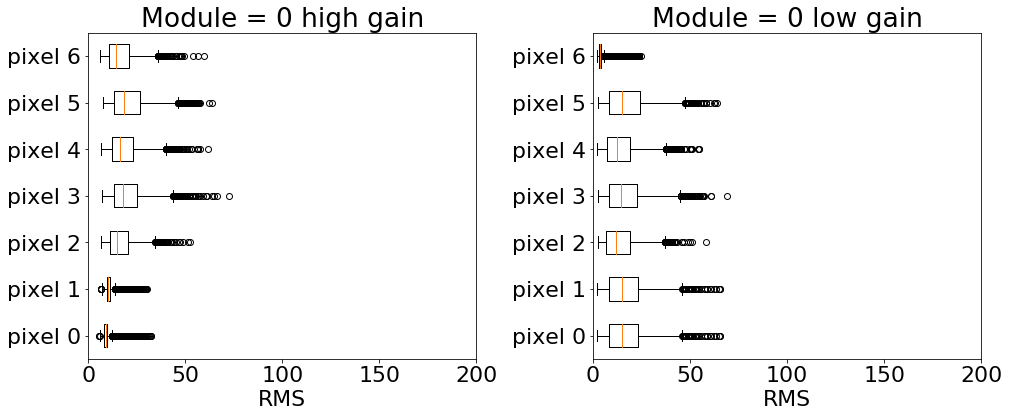

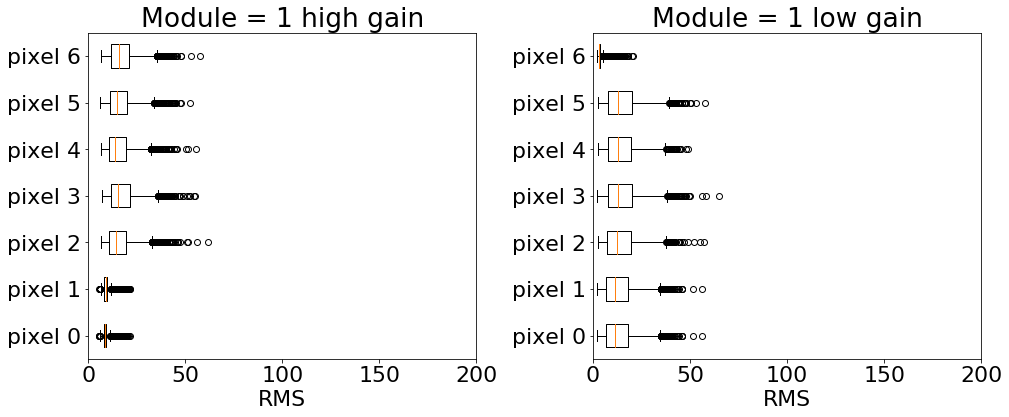

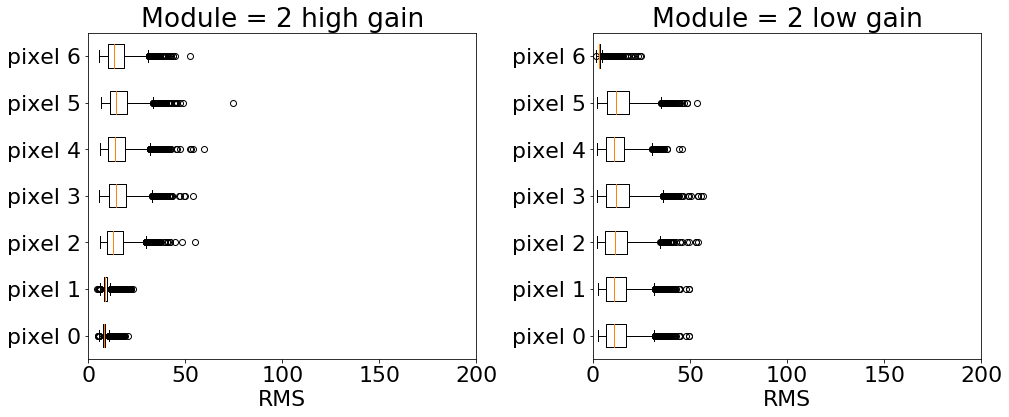

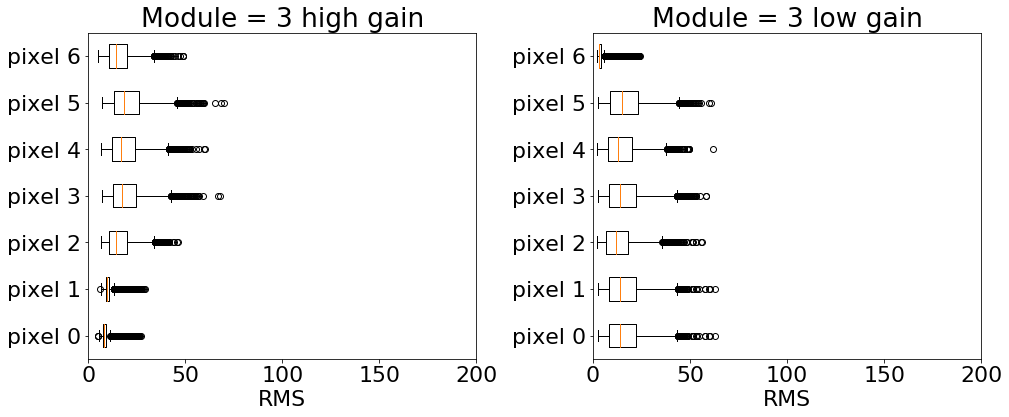

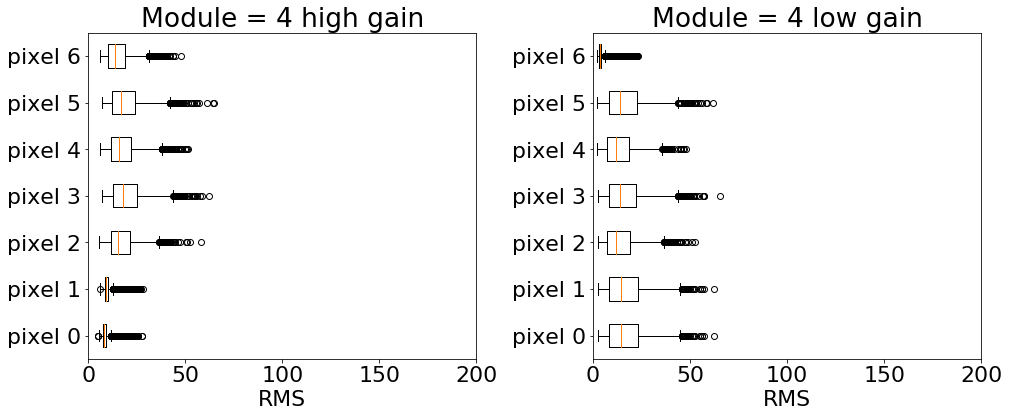

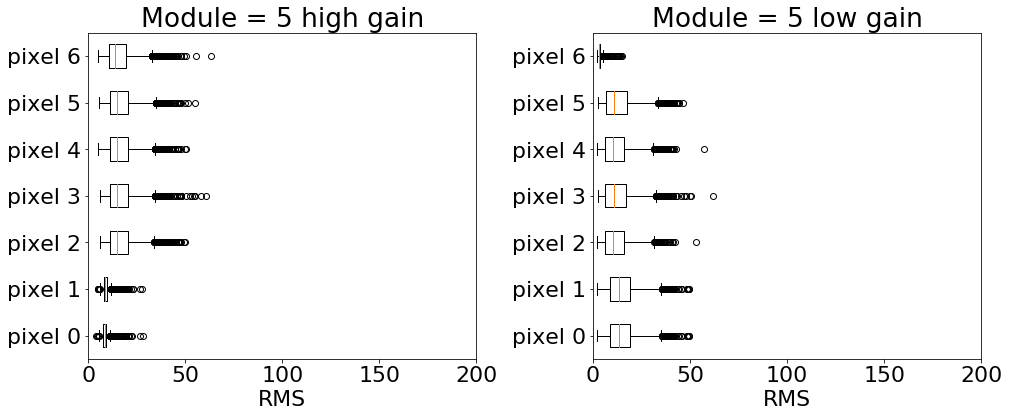

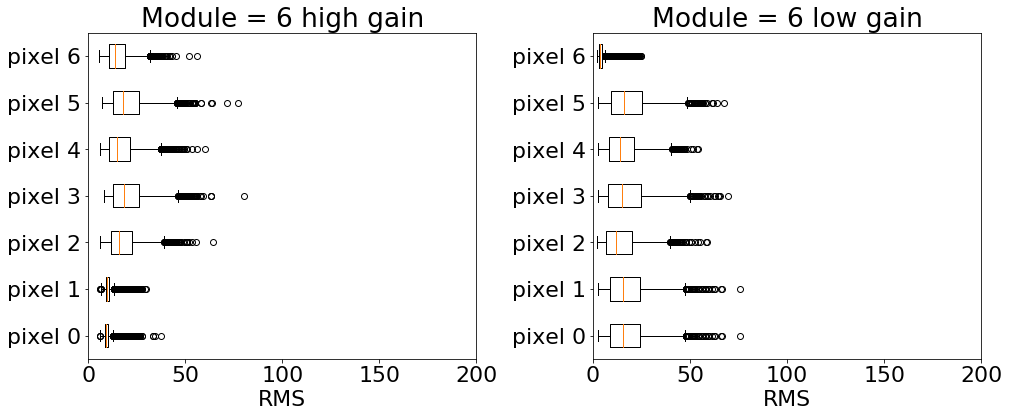

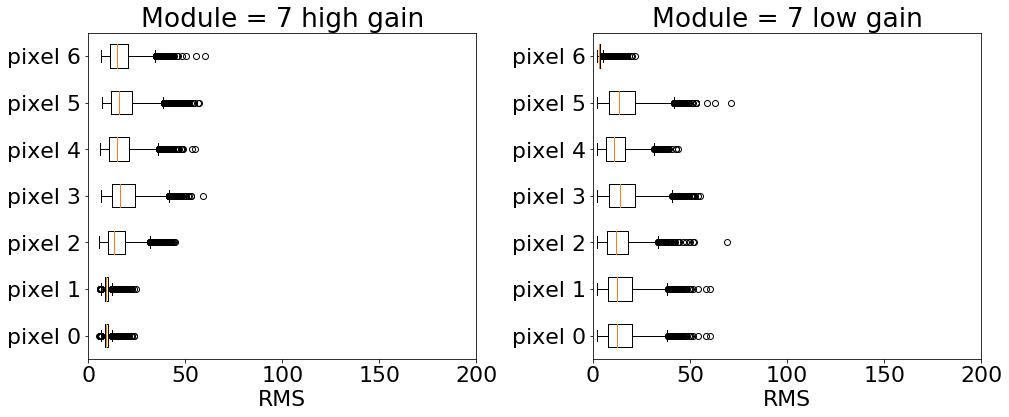

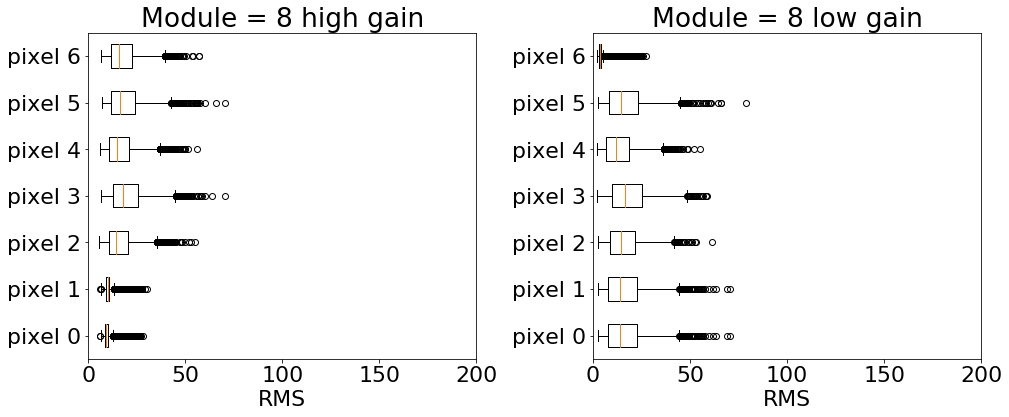

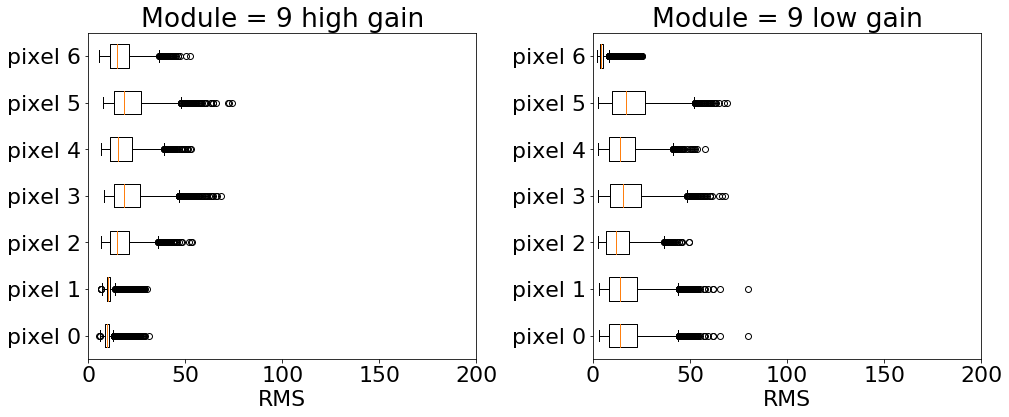

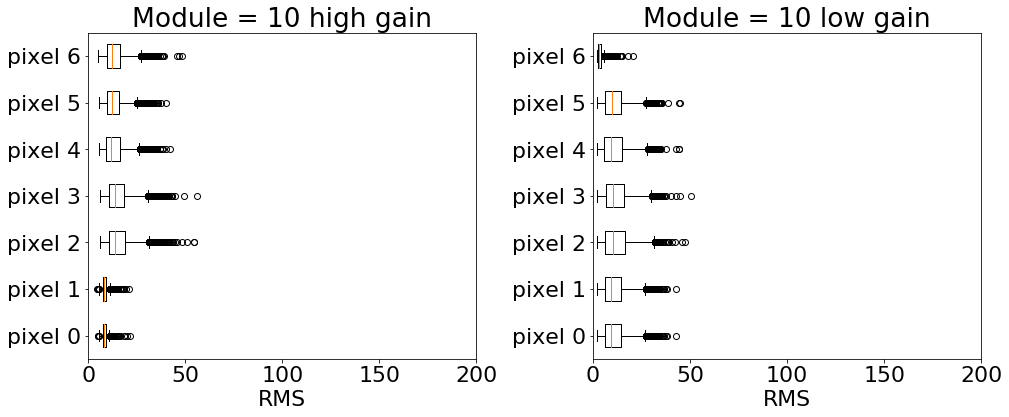

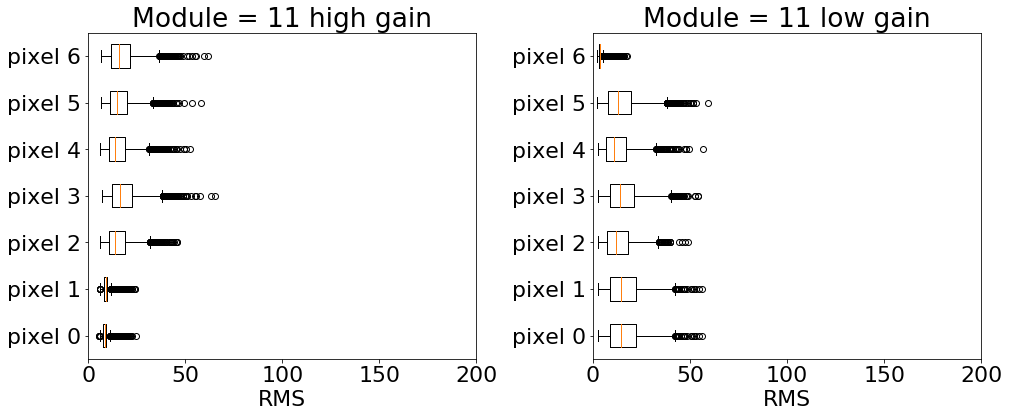

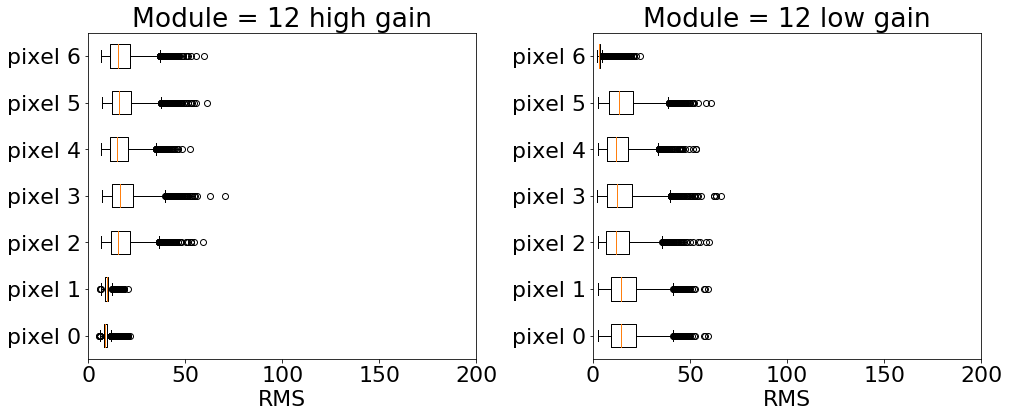

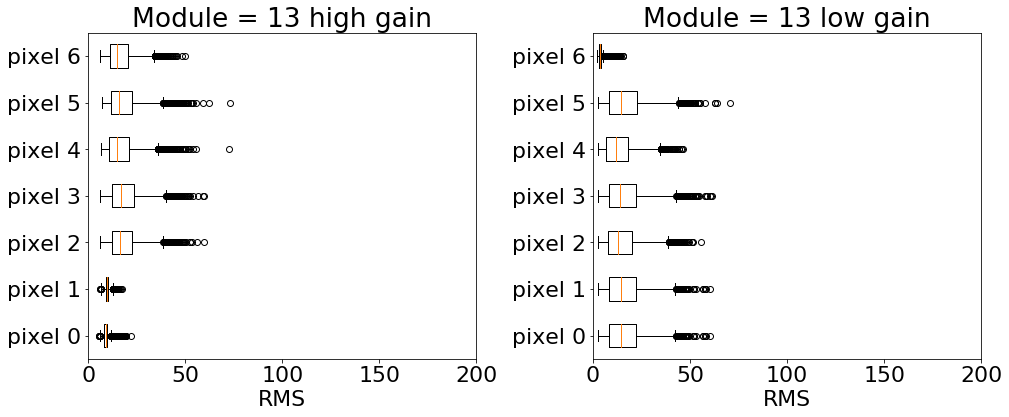

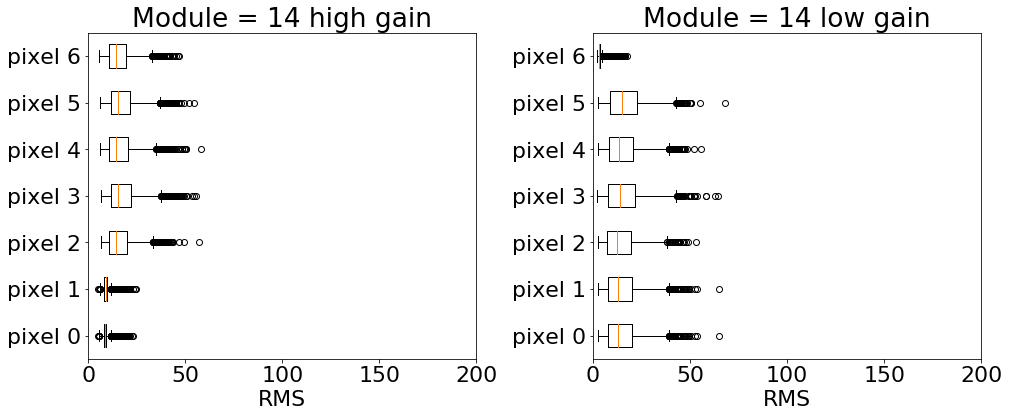

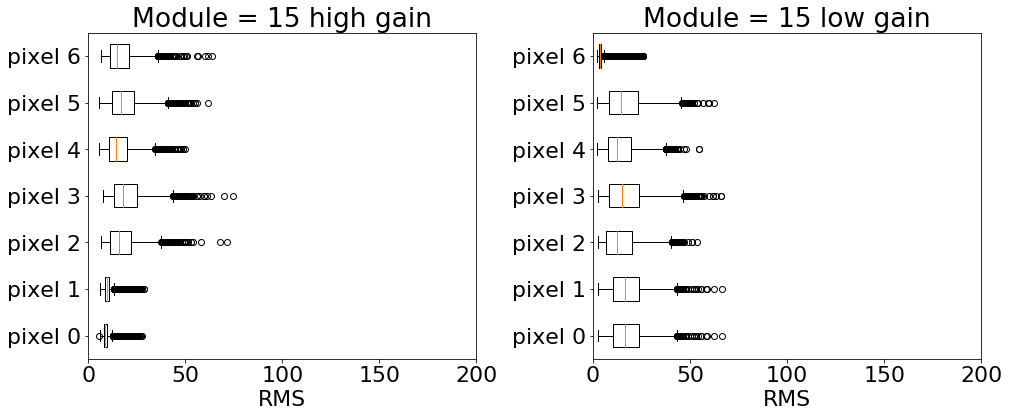

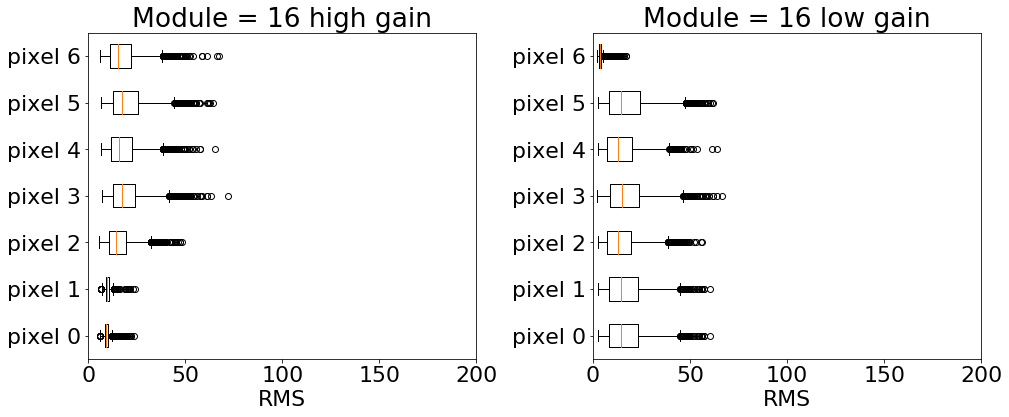

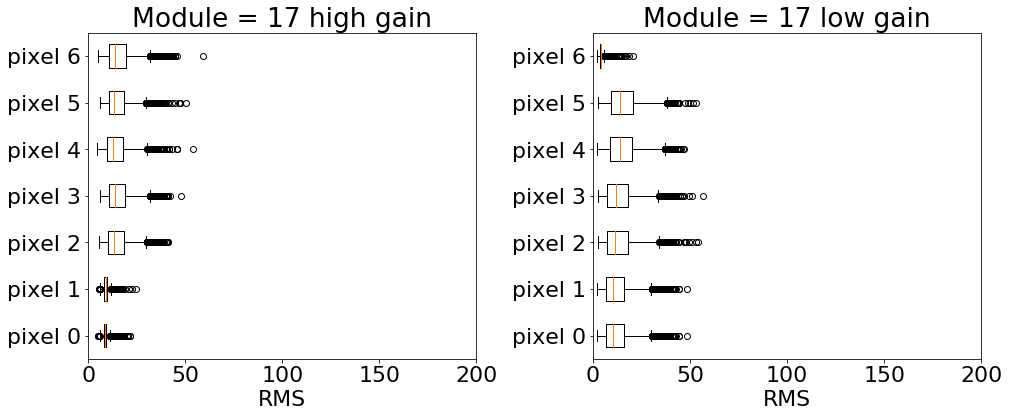

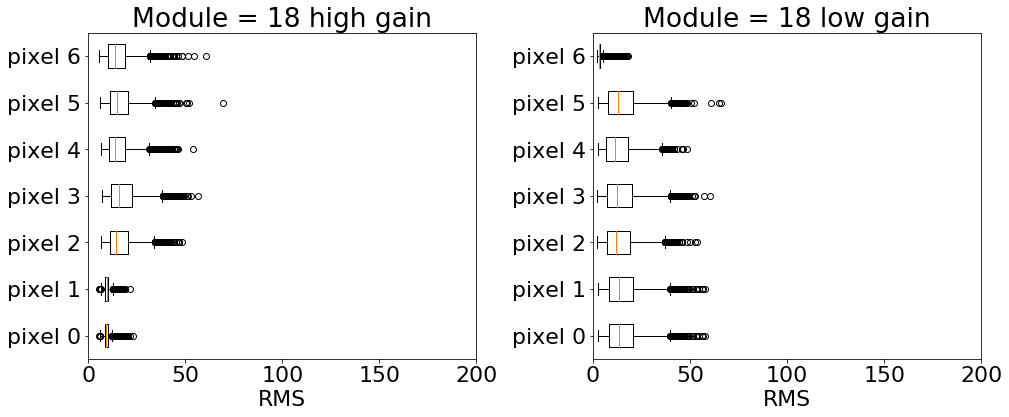

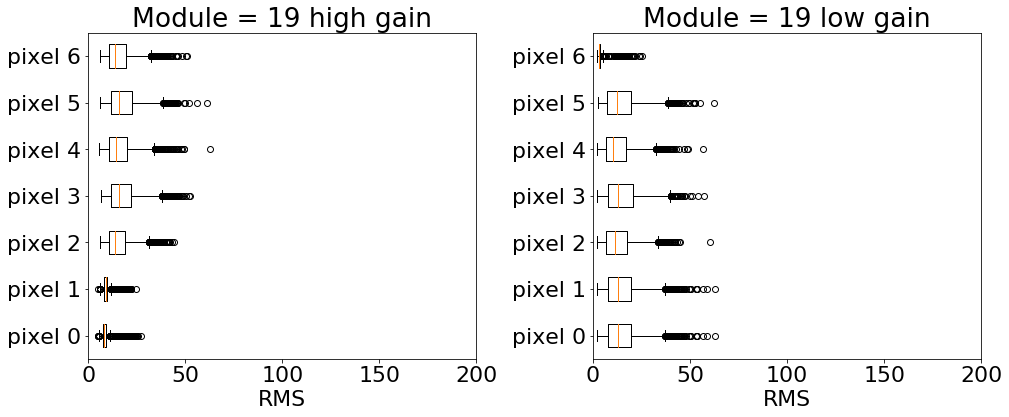

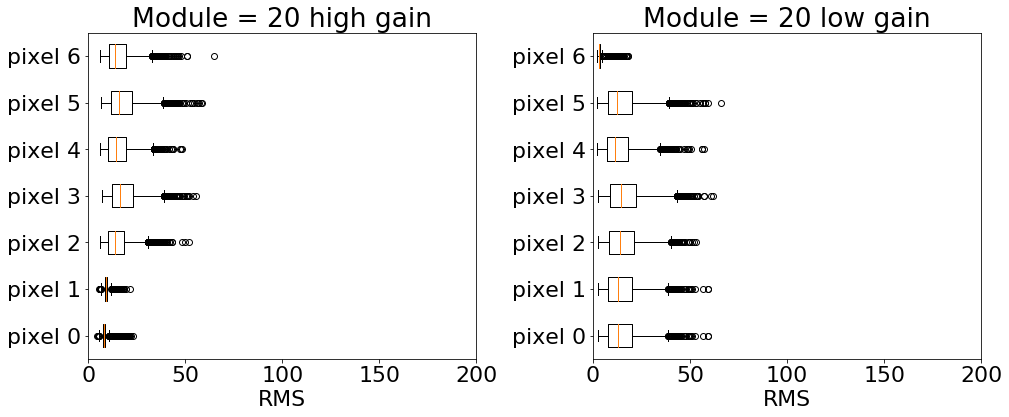

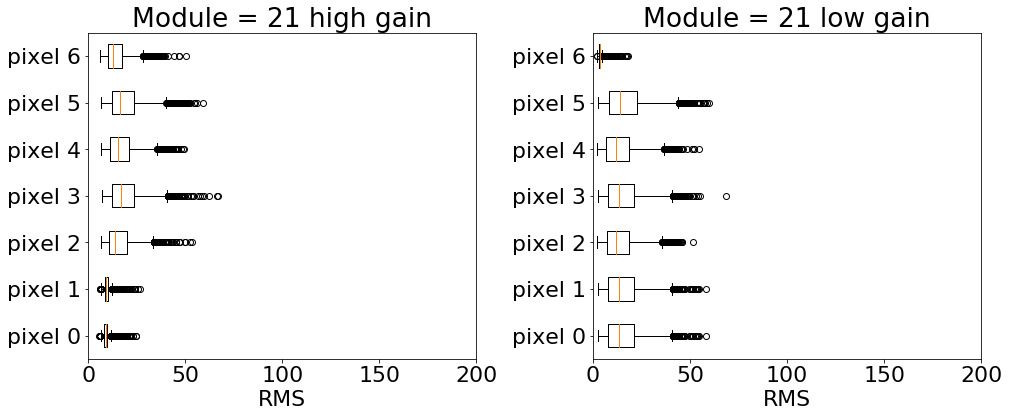

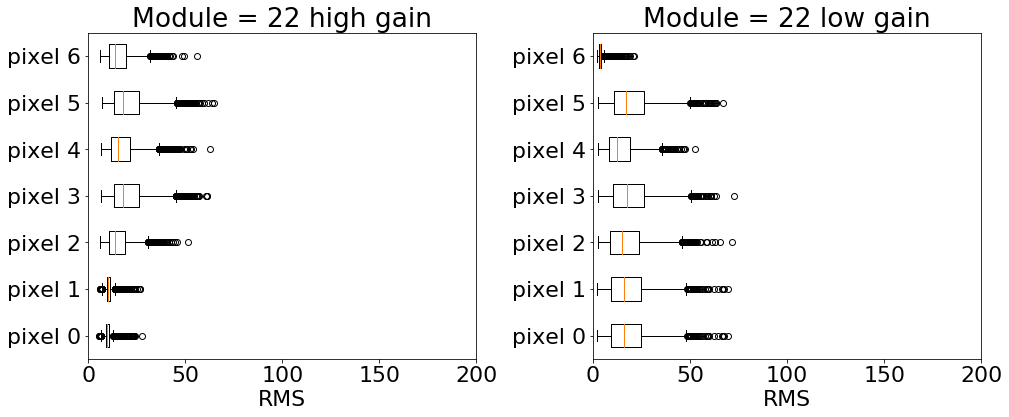

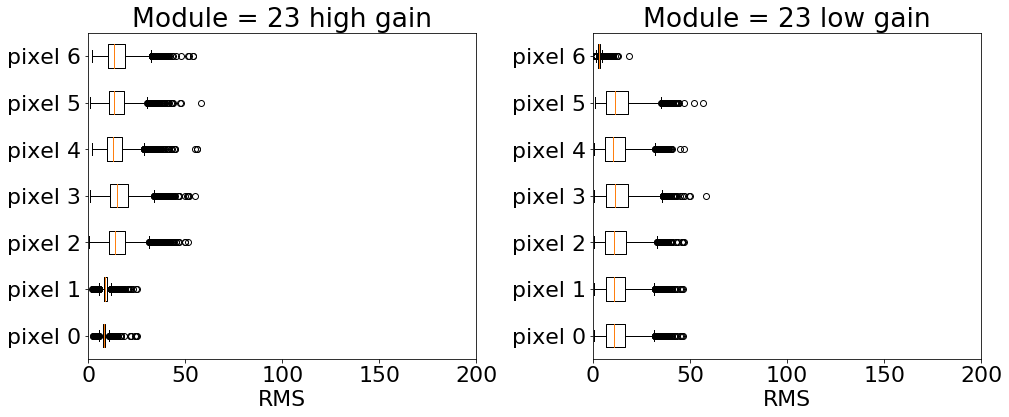

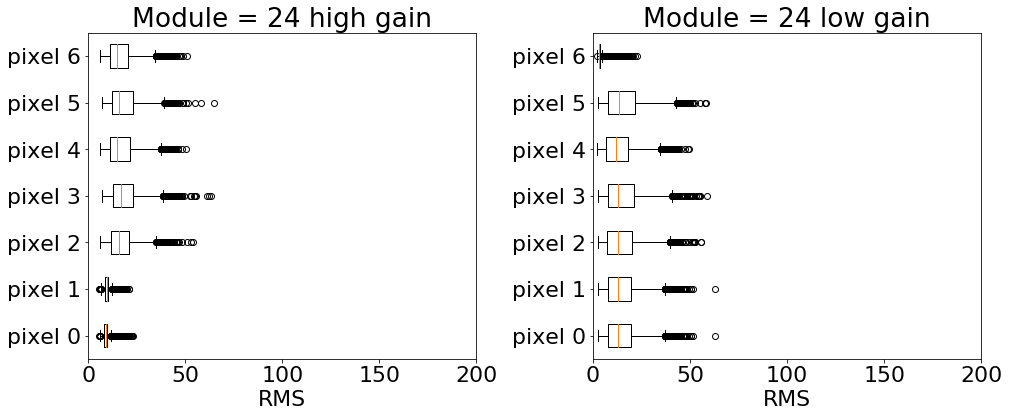

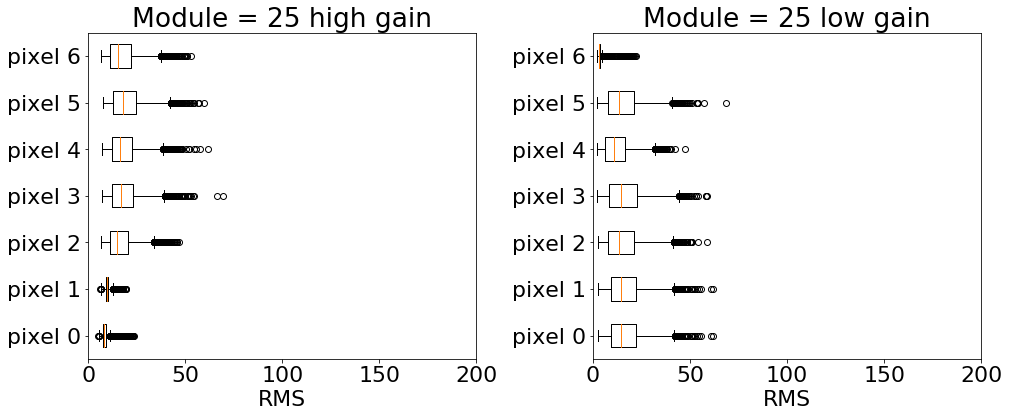

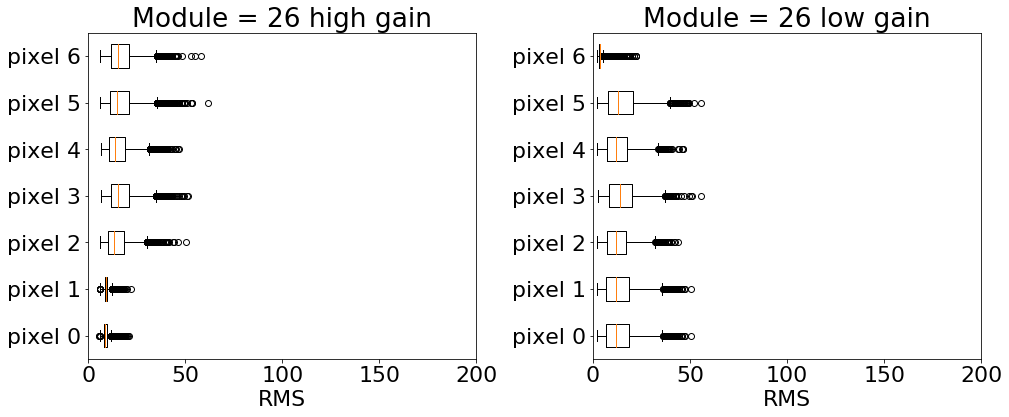

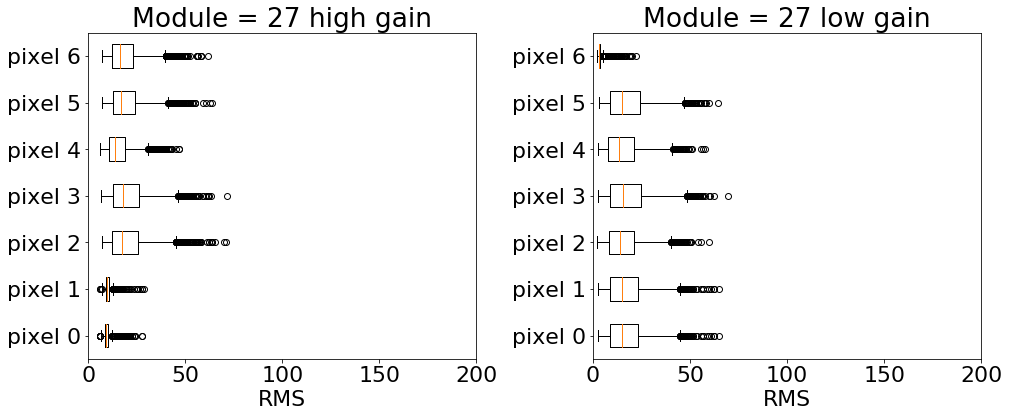

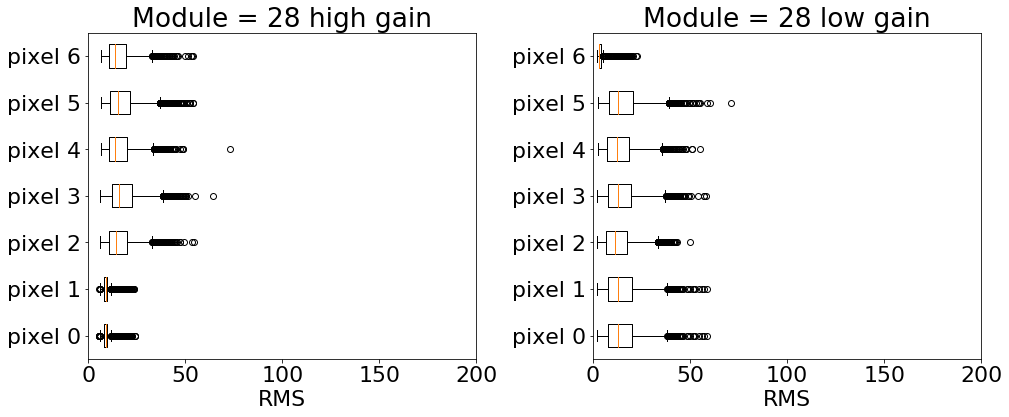

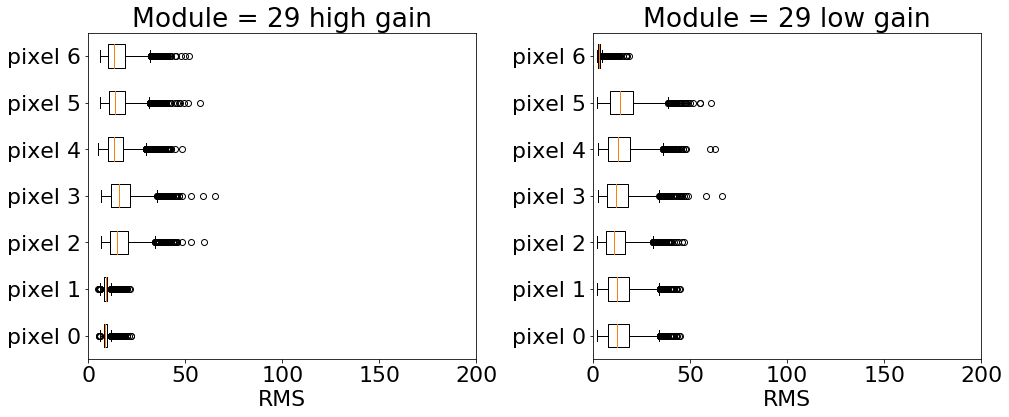

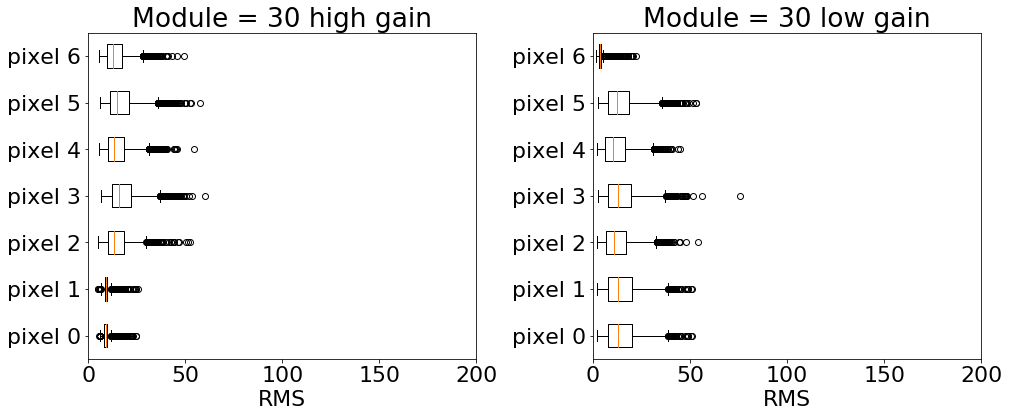

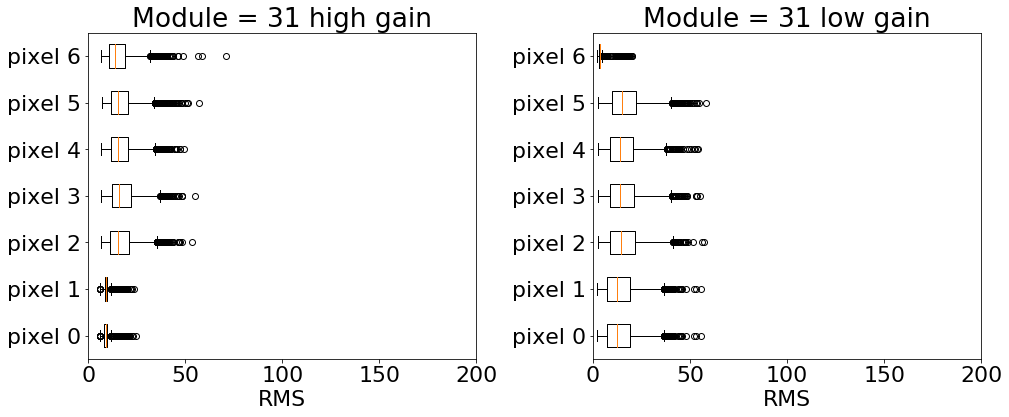

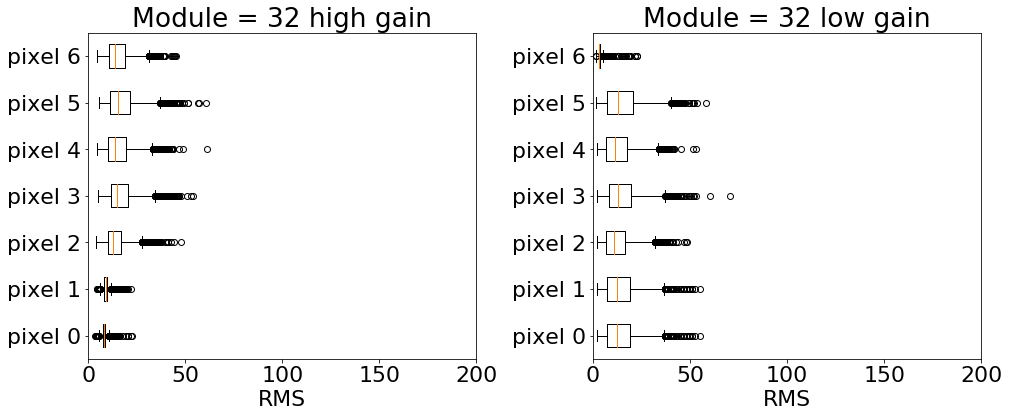

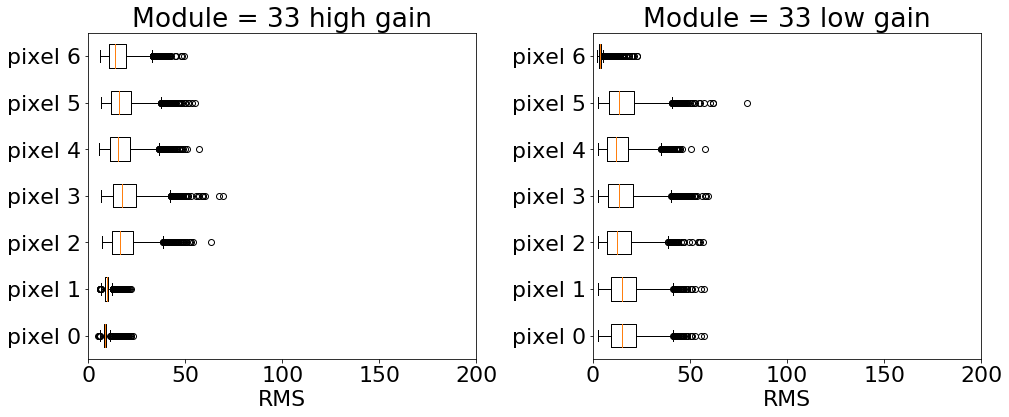

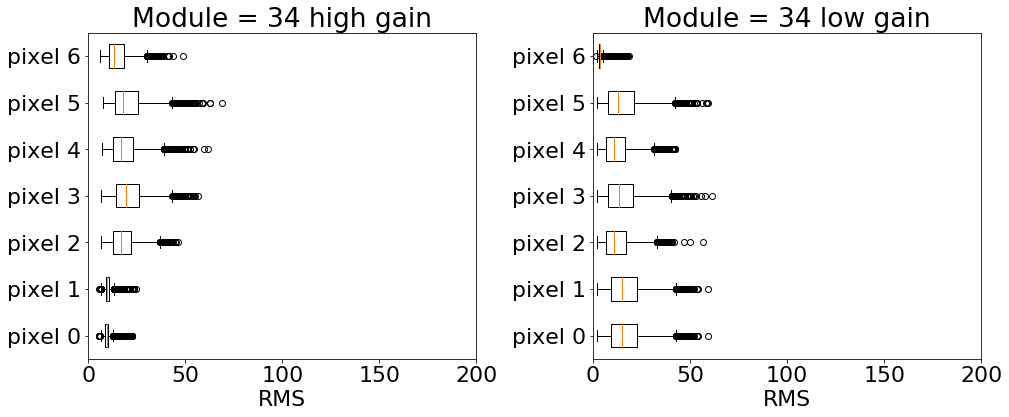

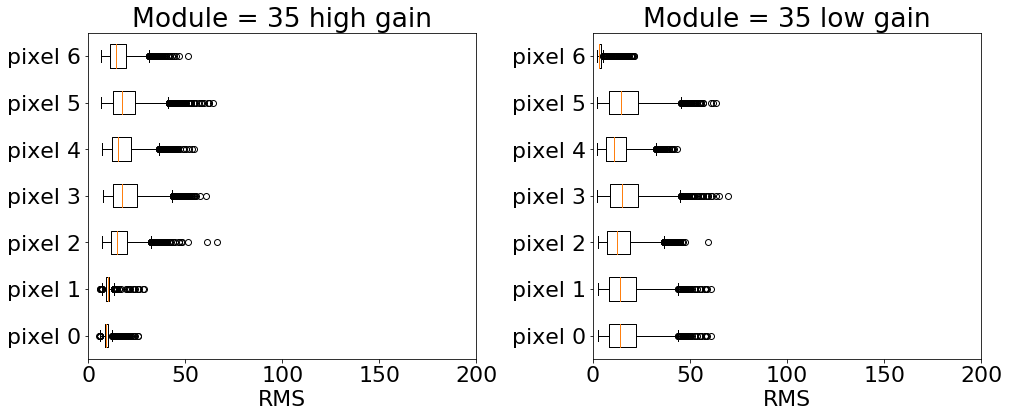

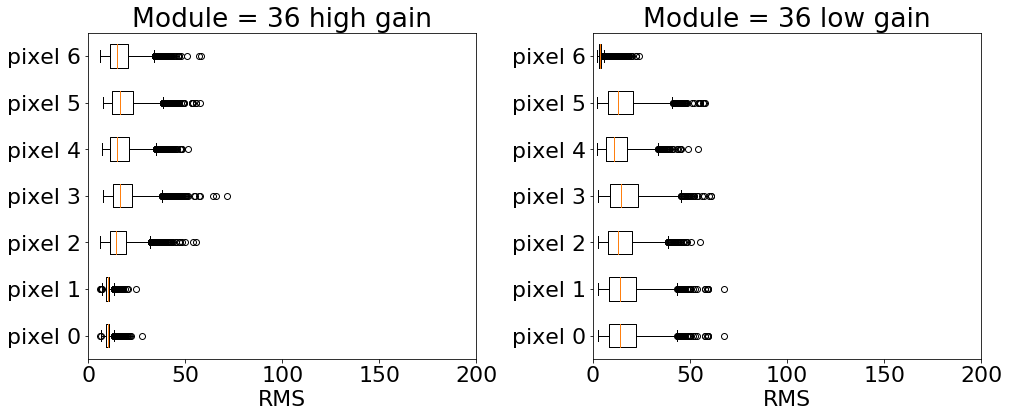

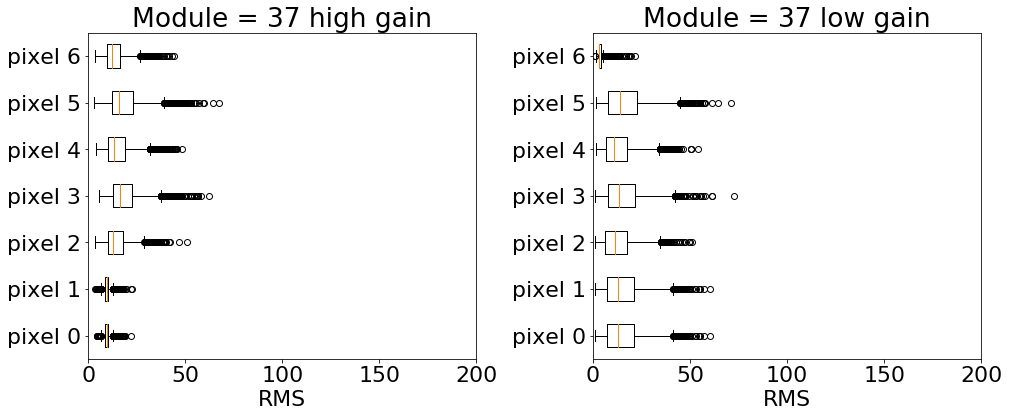

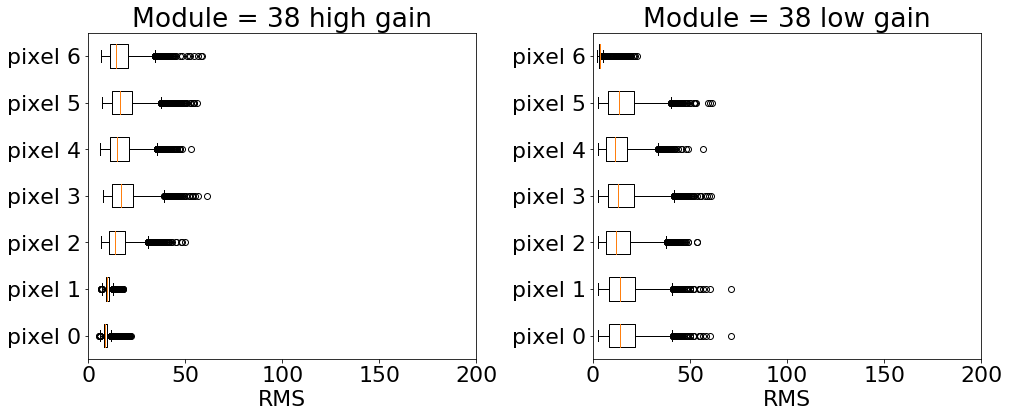

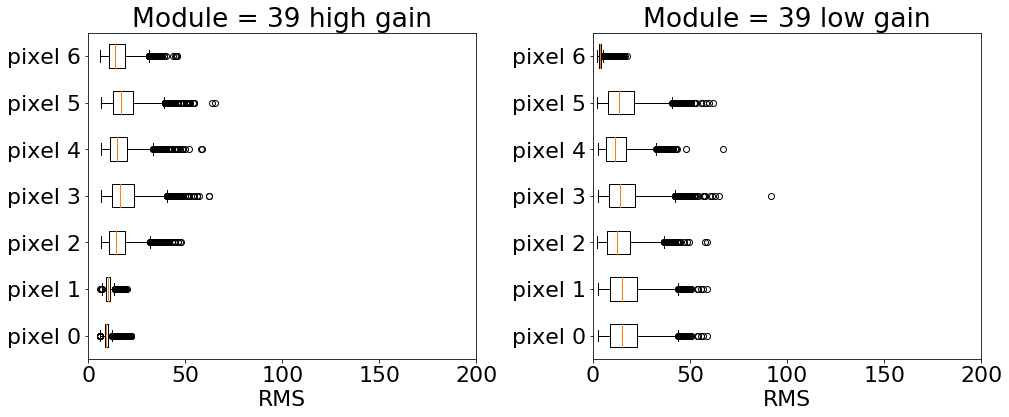

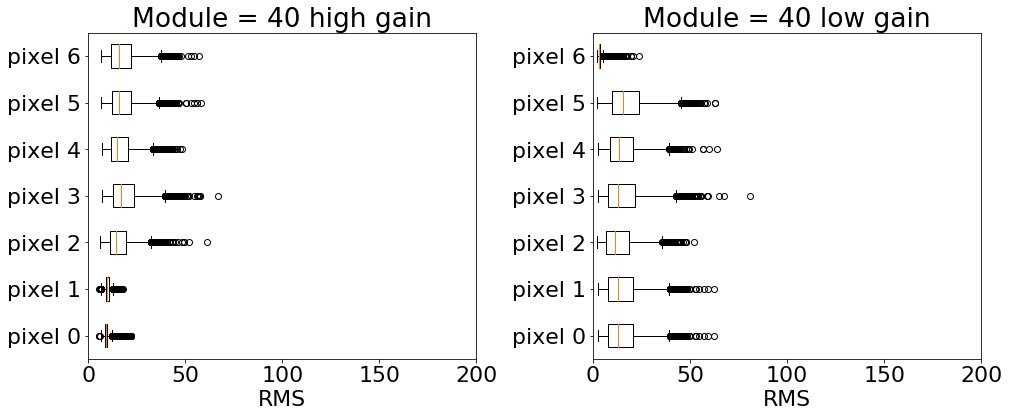

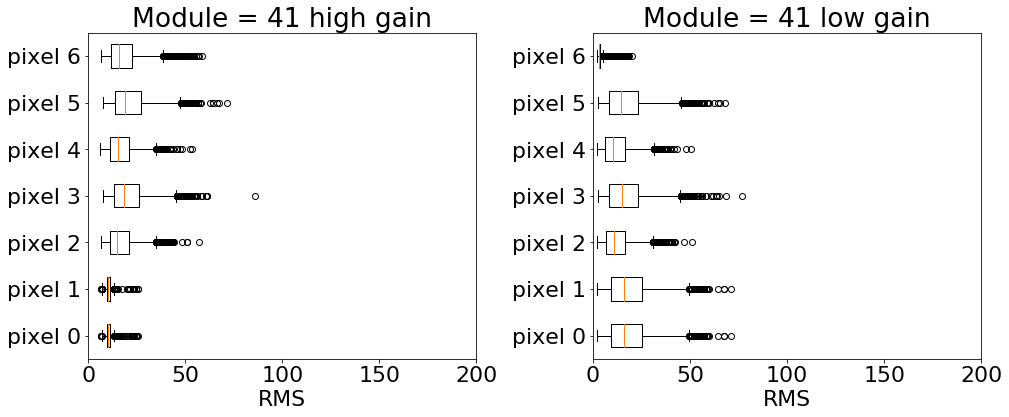

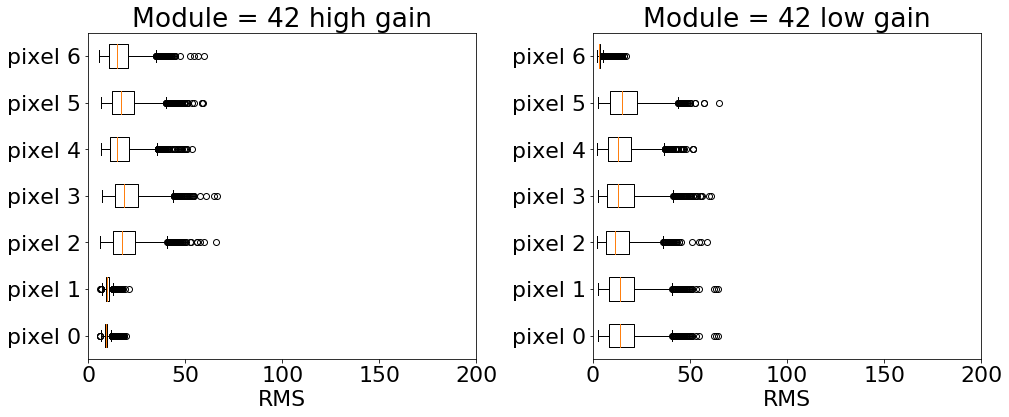

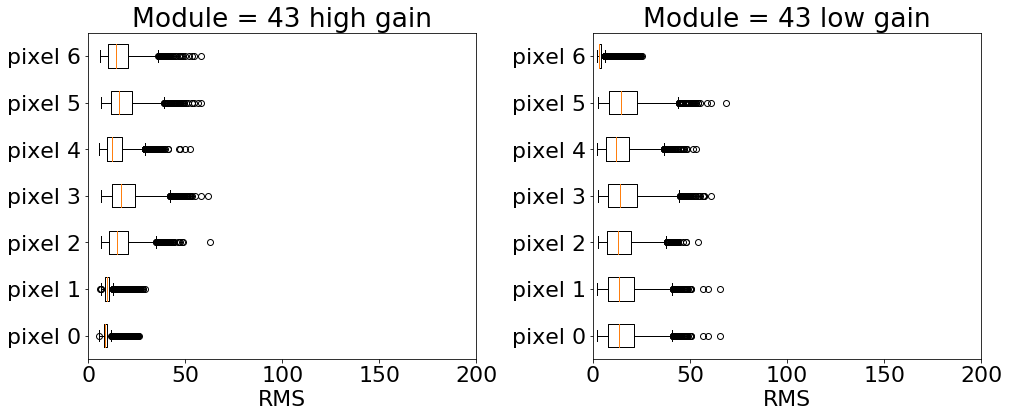

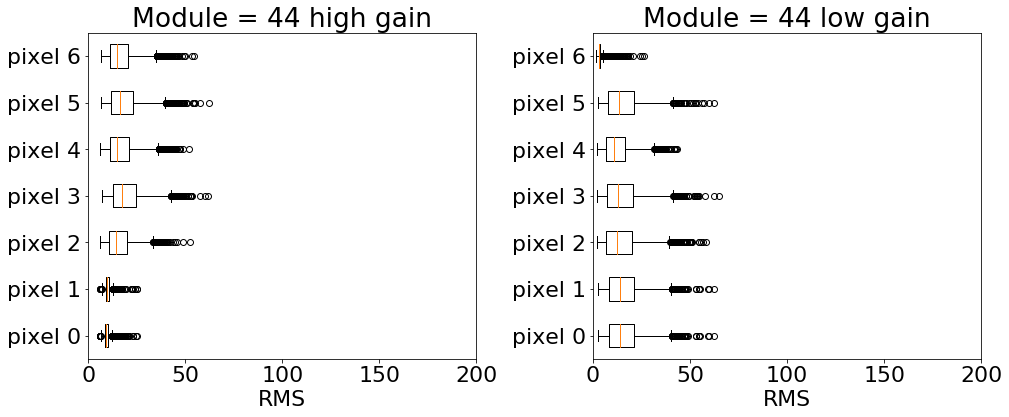

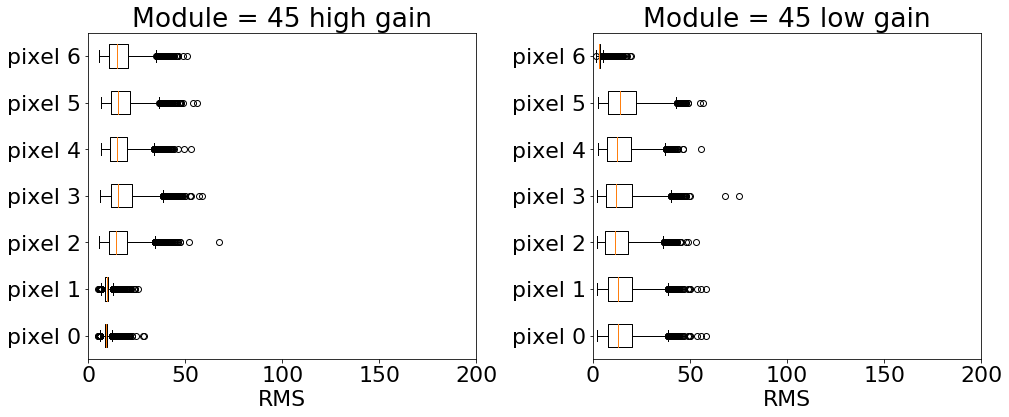

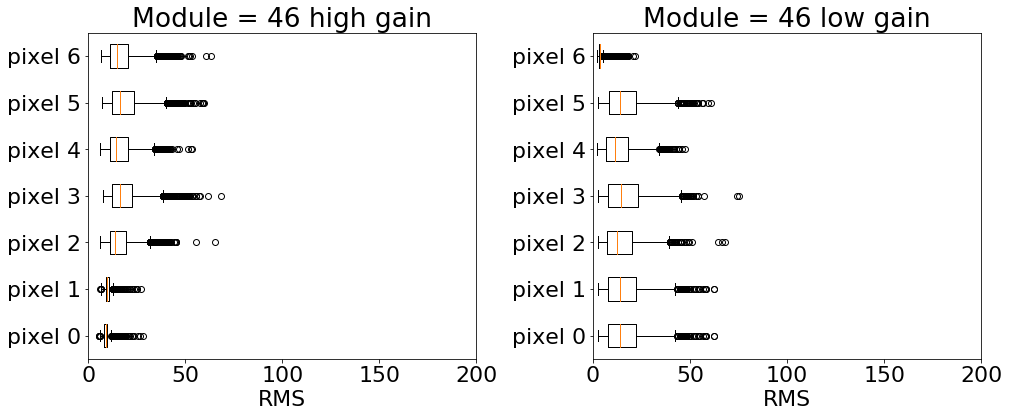

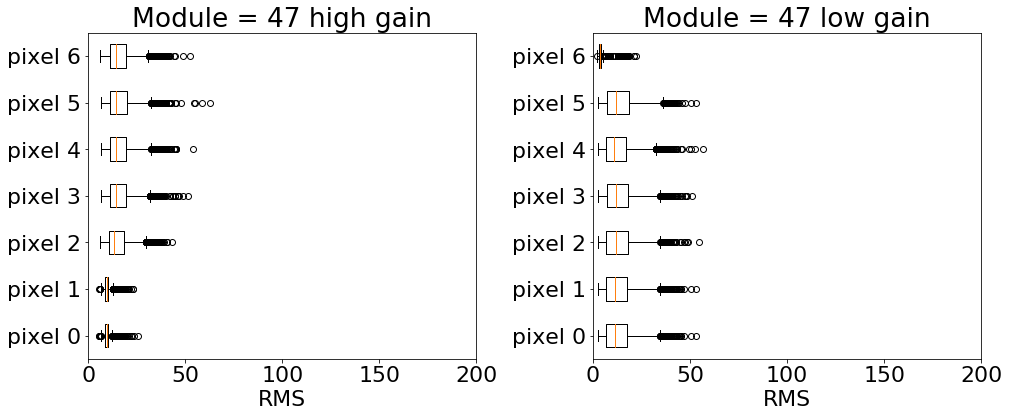

/home/pawel1/anaconda3/envs/cta-dev/lib/python3.6/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
/home/pawel1/anaconda3/envs/cta-dev/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1872: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = np.compress(x <= hival, x)
/home/pawel1/anaconda3/envs/cta-dev/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1879: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = np.compress(x >= loval, x)
/home/pawel1/anaconda3/envs/cta-dev/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1887: RuntimeWarning: invalid value encountered in less
  np.compress(x < stats['whislo'], x),
/home/pawel1/anaconda3/envs/cta-dev/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:1888: RuntimeWarning: invalid value encountered in greater
  np.compress(x > stats['whishi'], x)


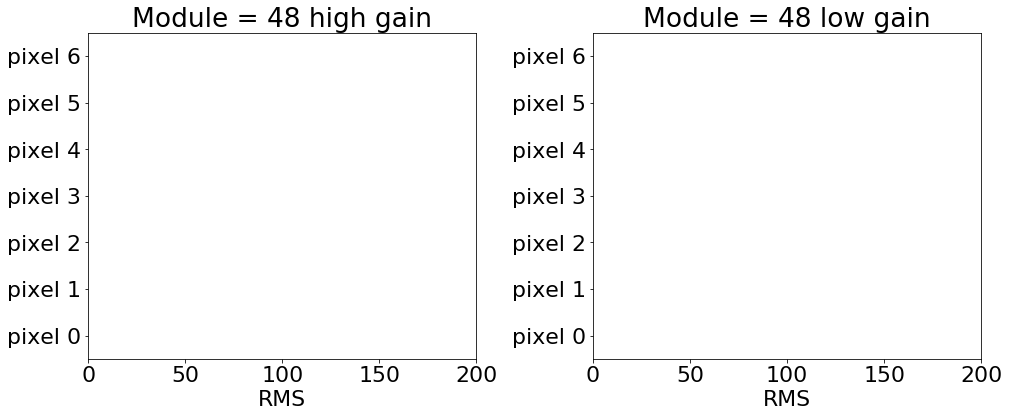

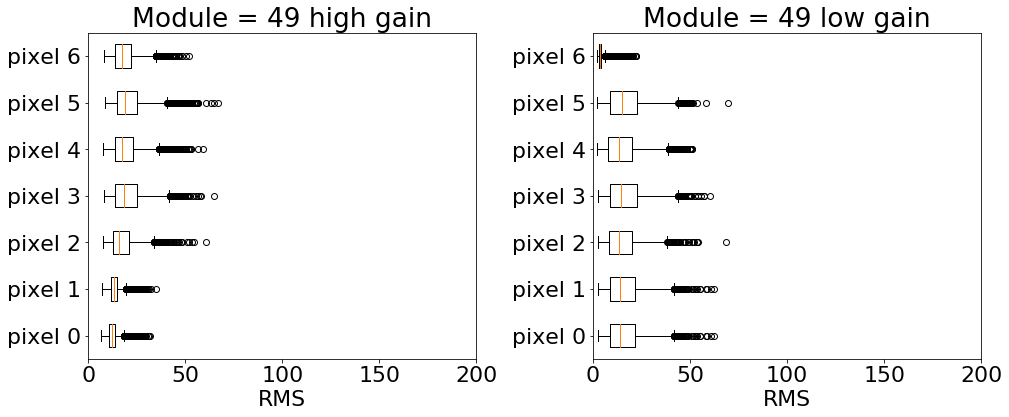

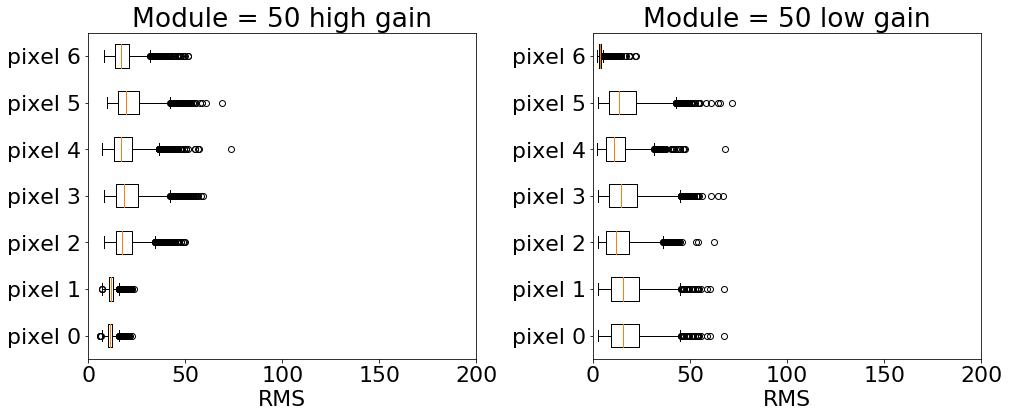

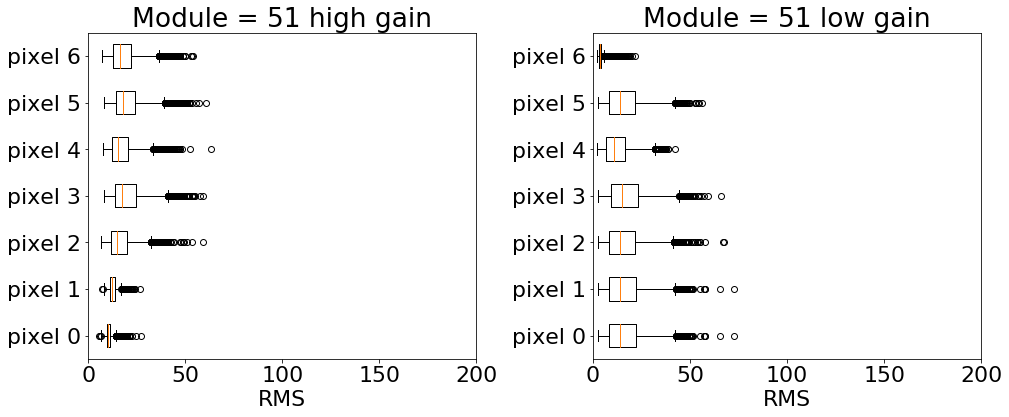

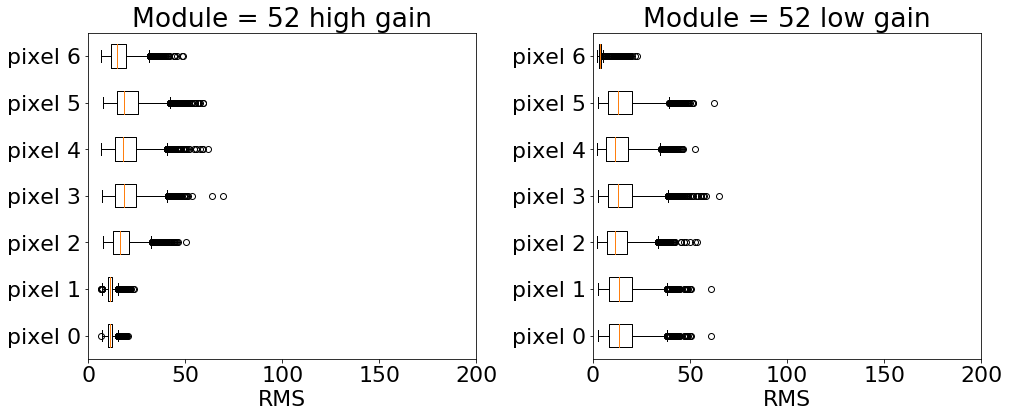

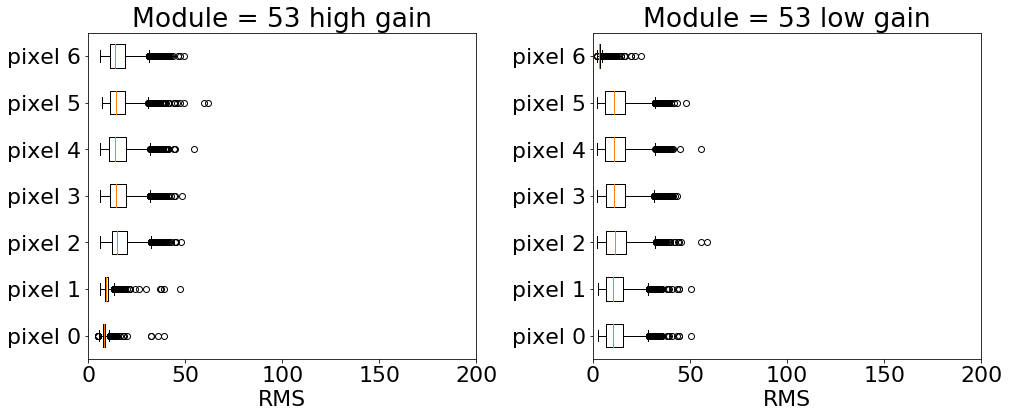

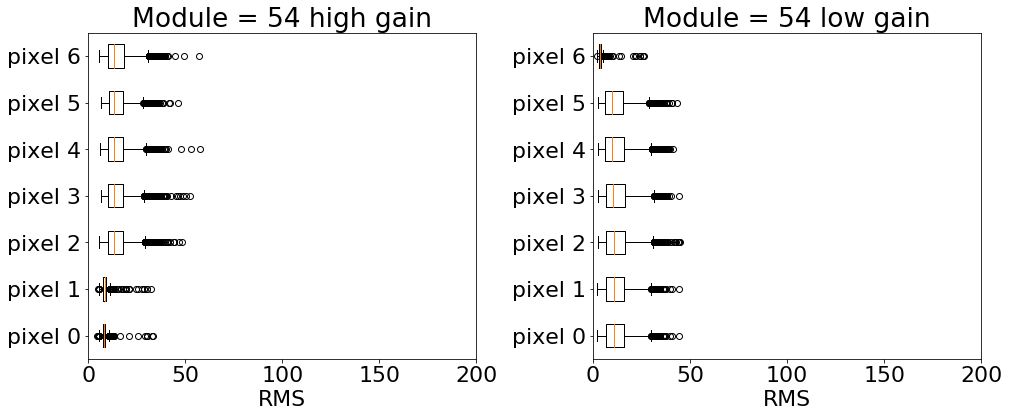

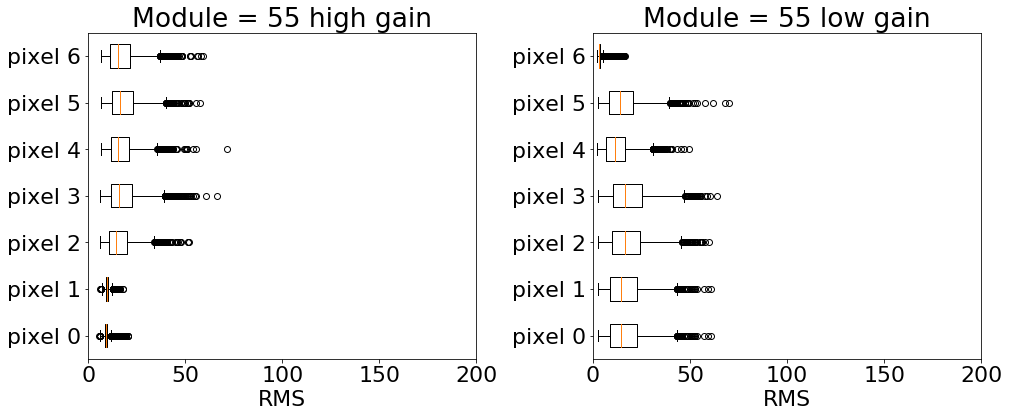

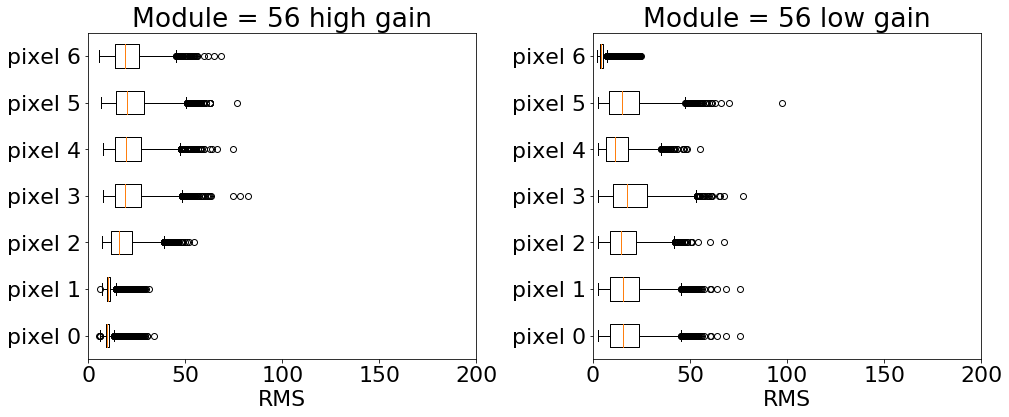

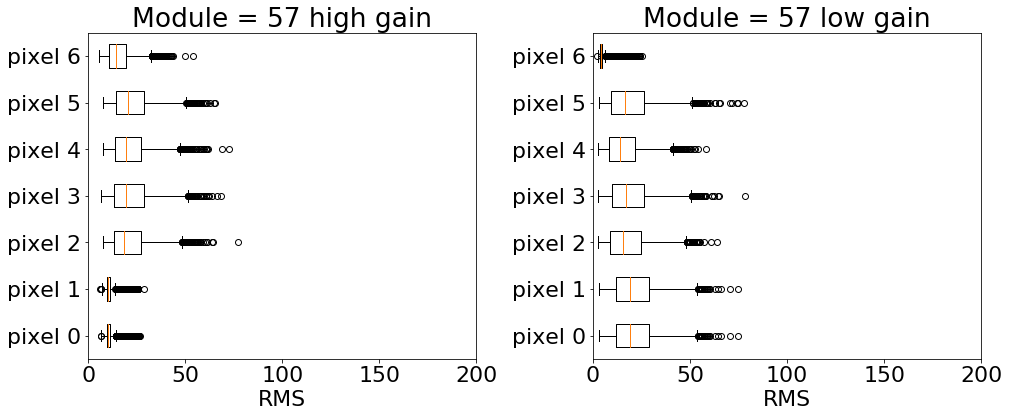

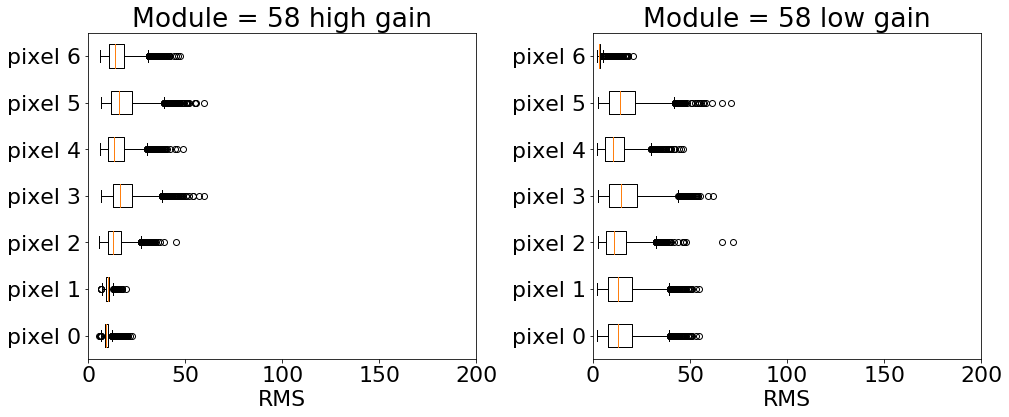

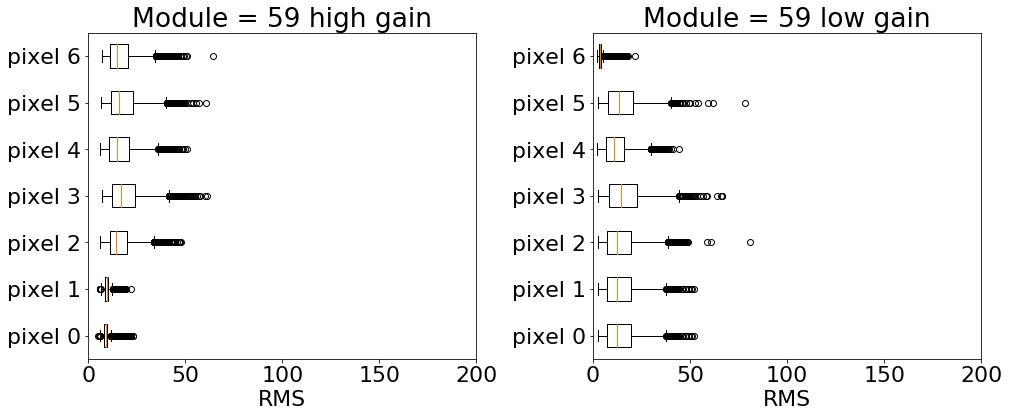

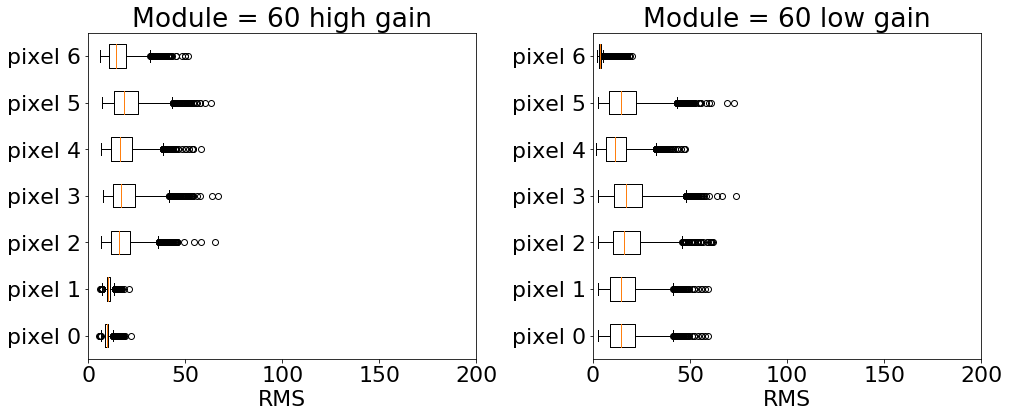

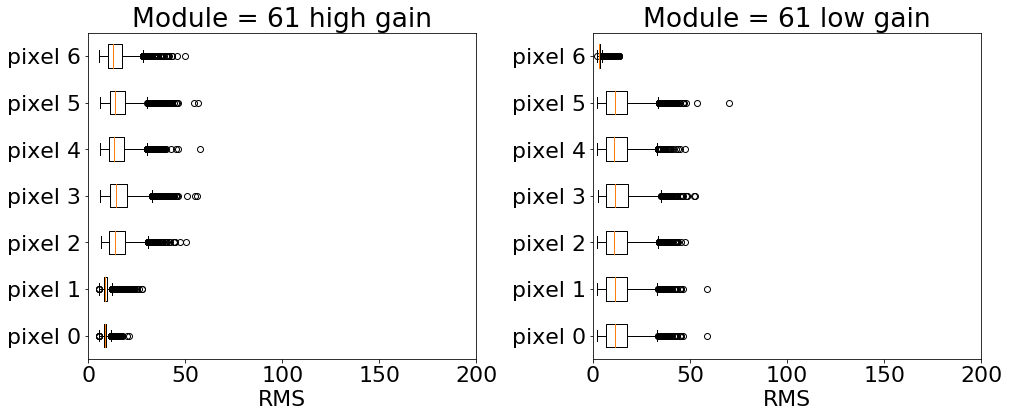

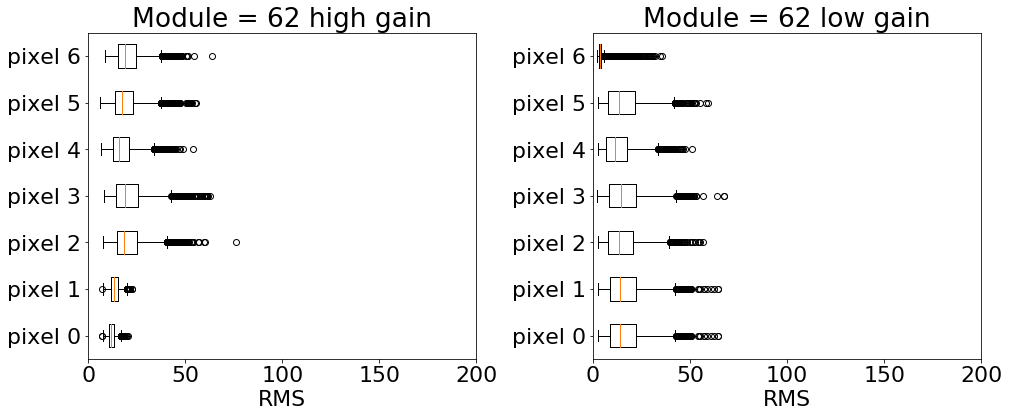

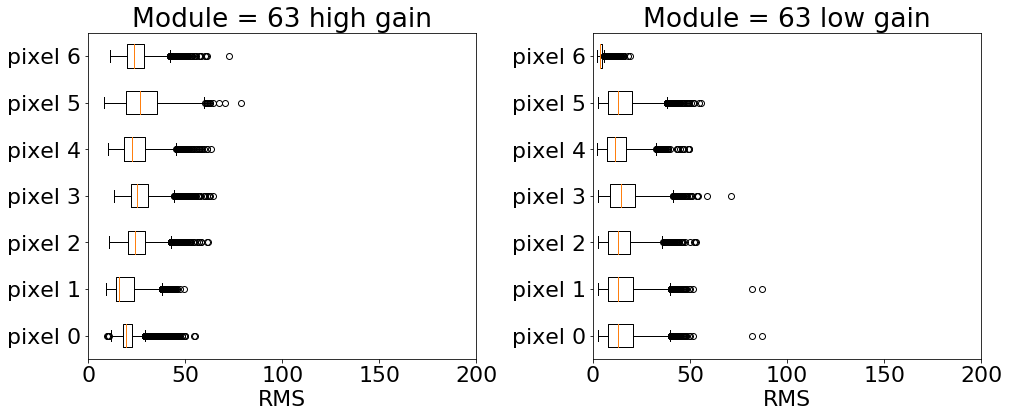

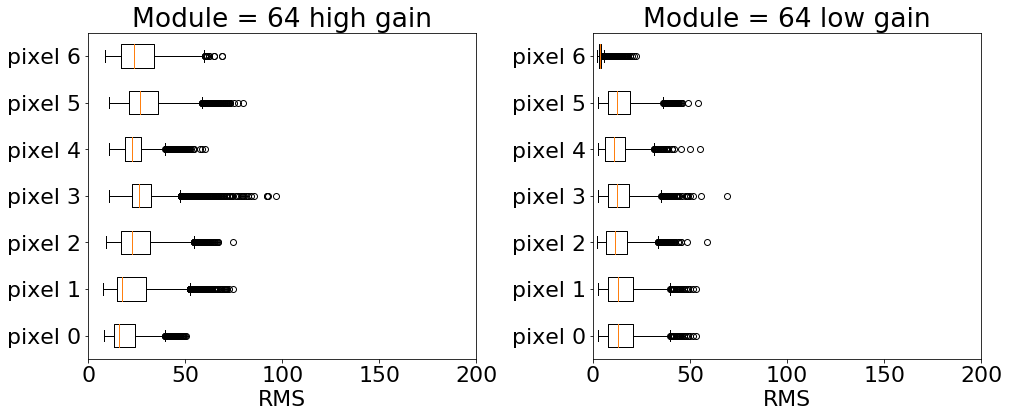

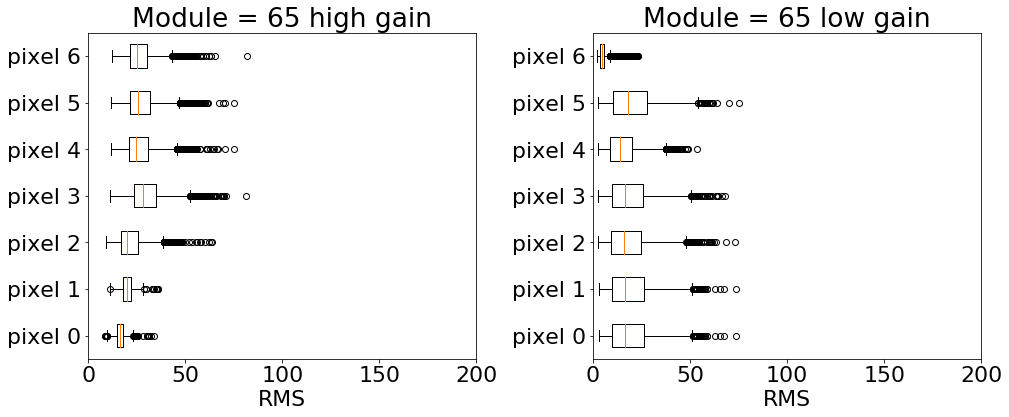

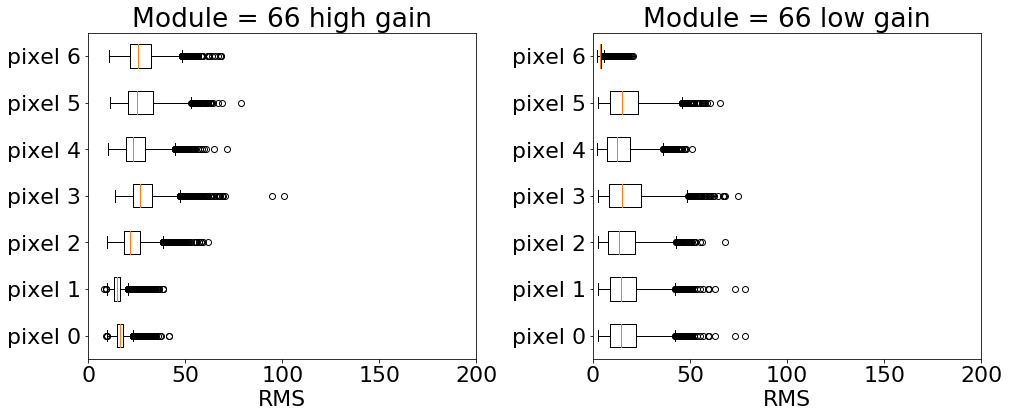

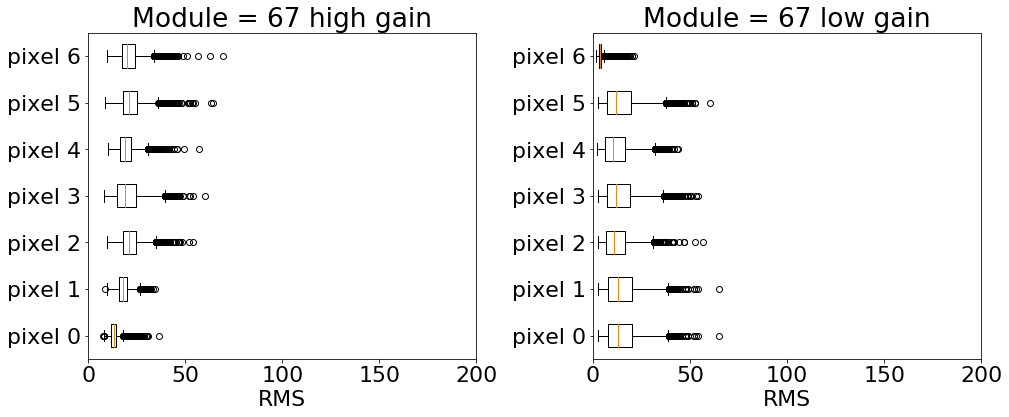

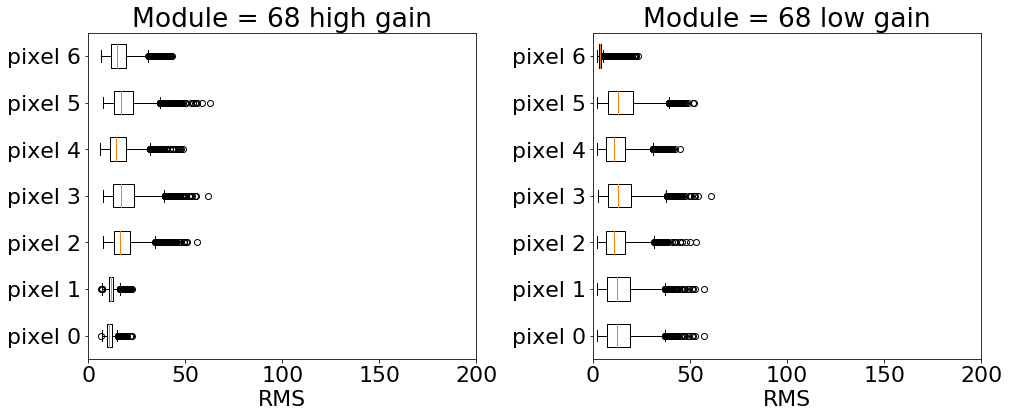

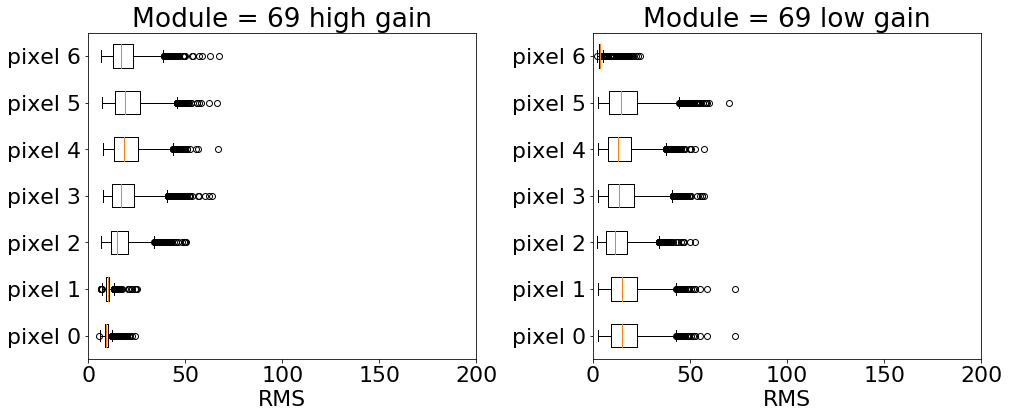

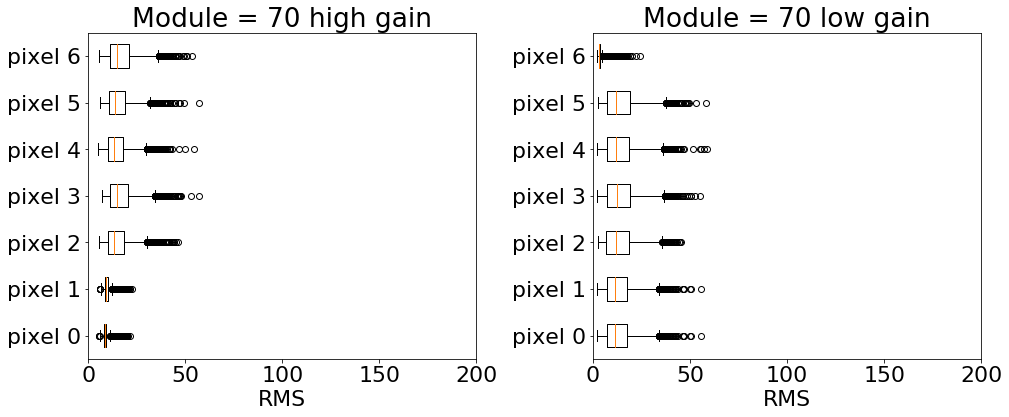

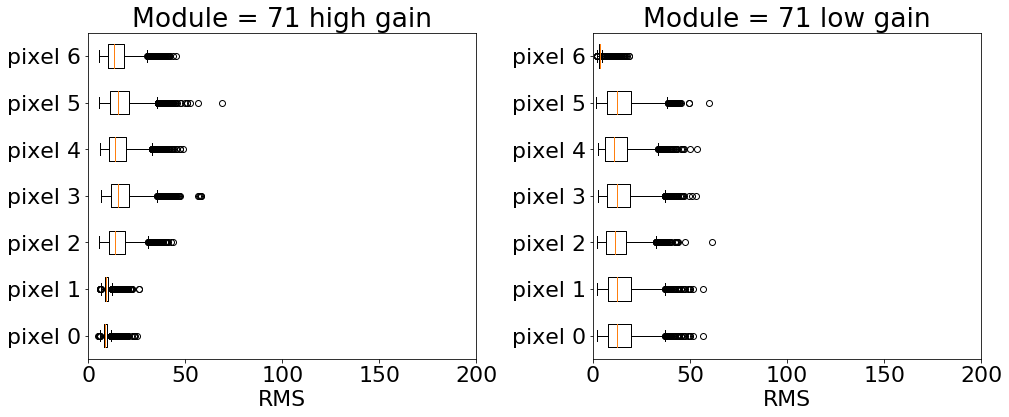

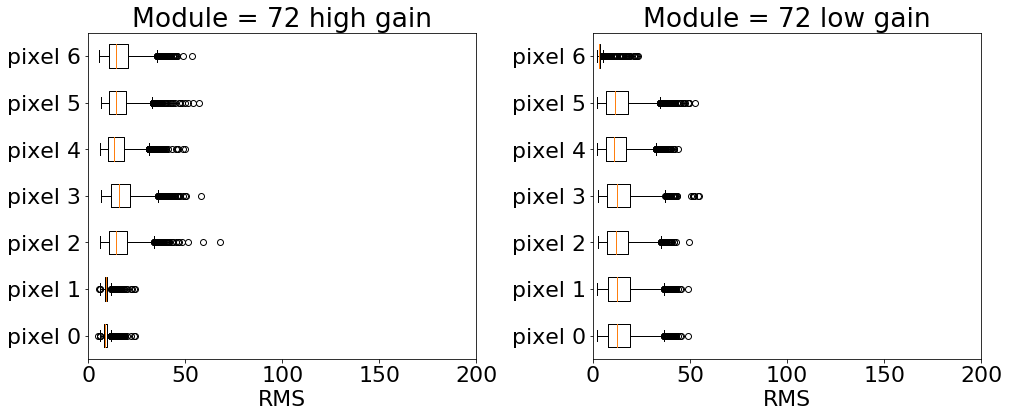

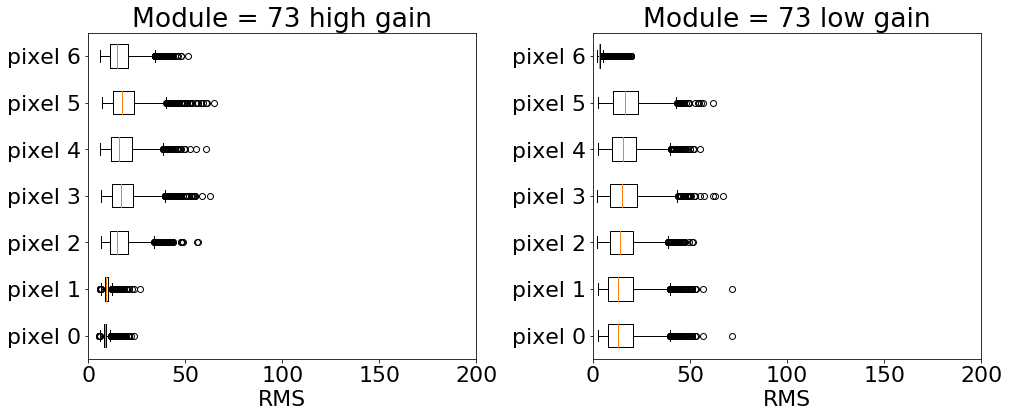

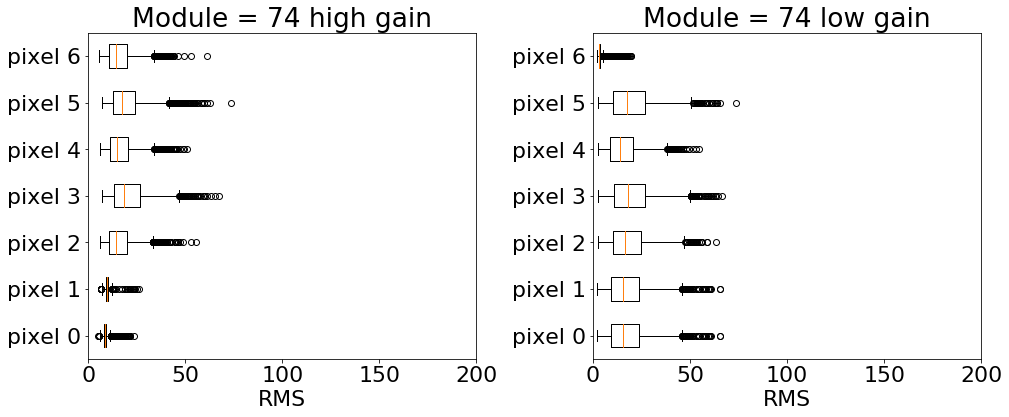

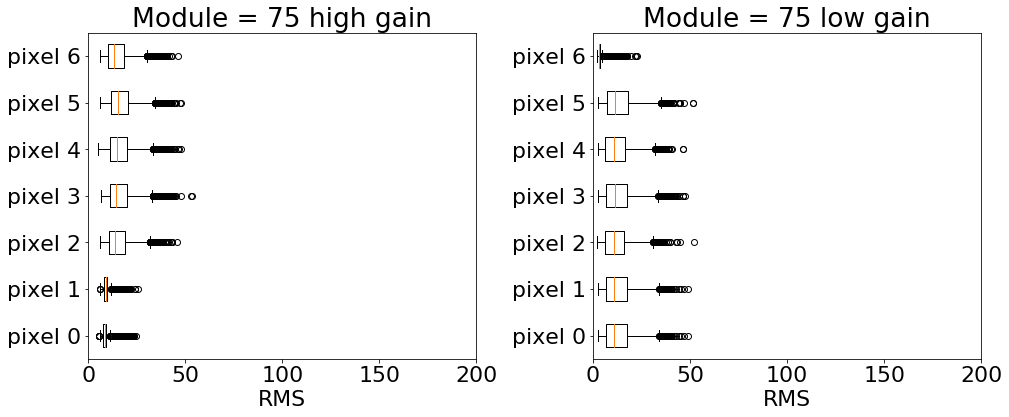

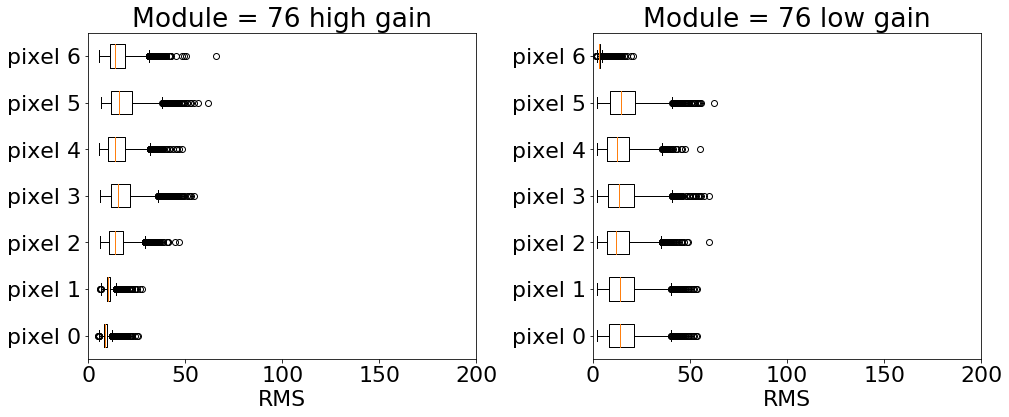

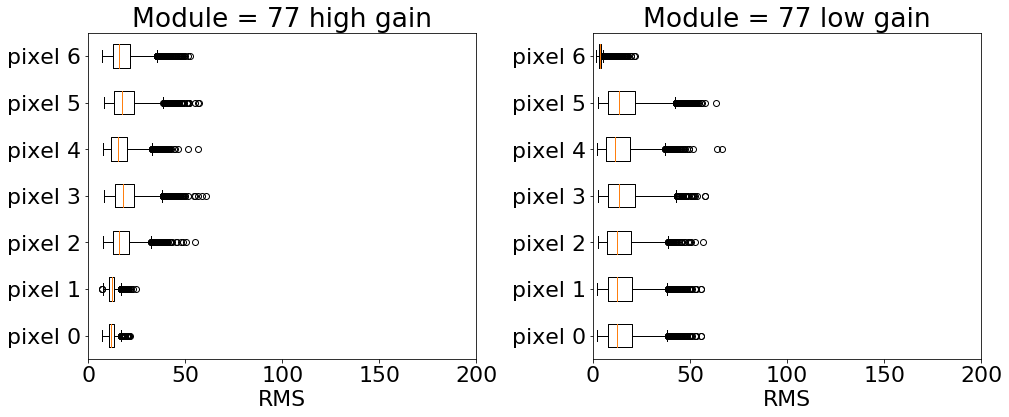

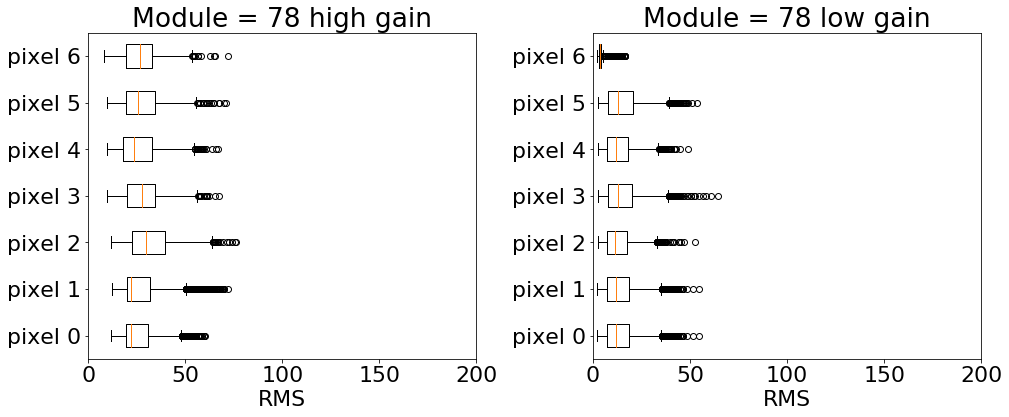

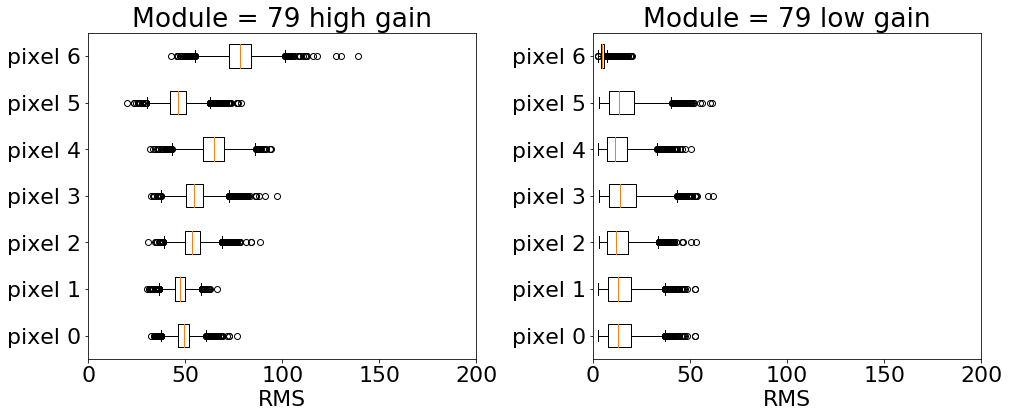

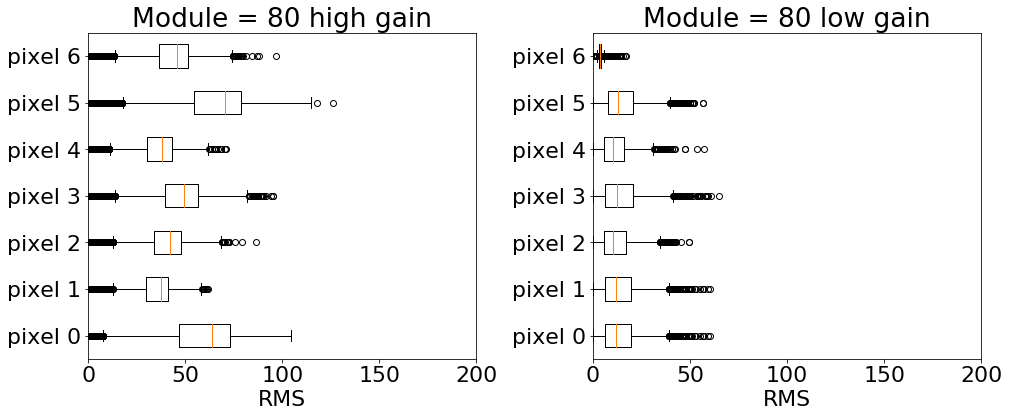

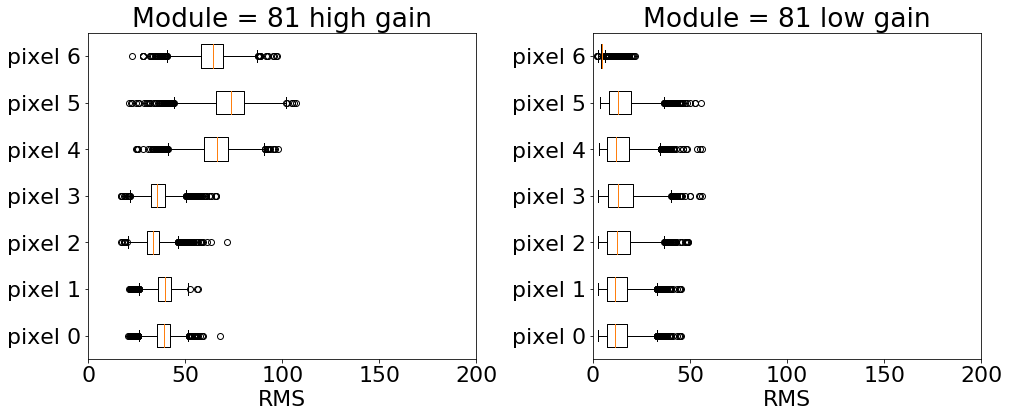

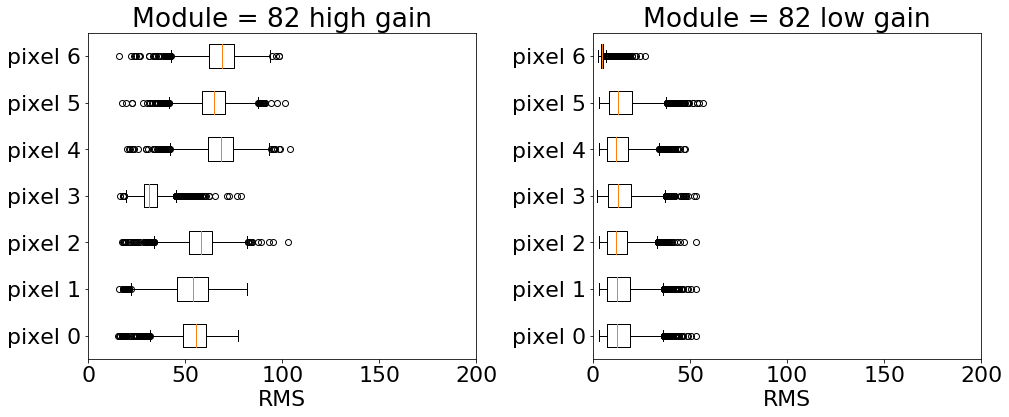

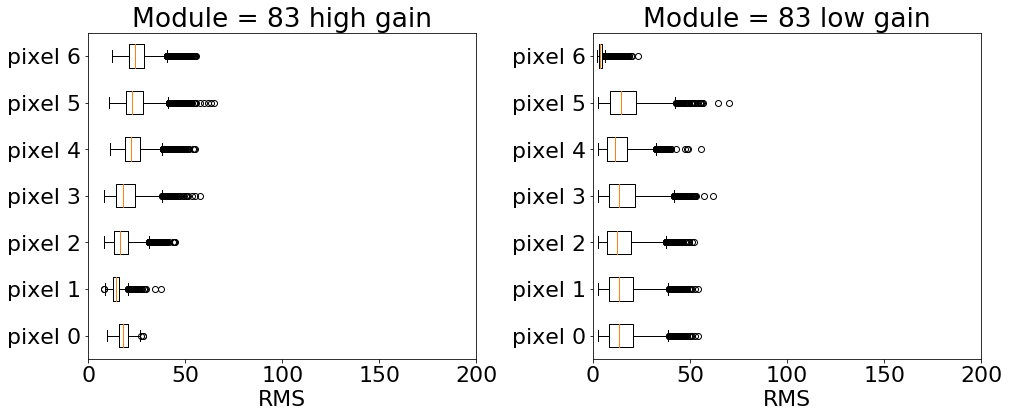

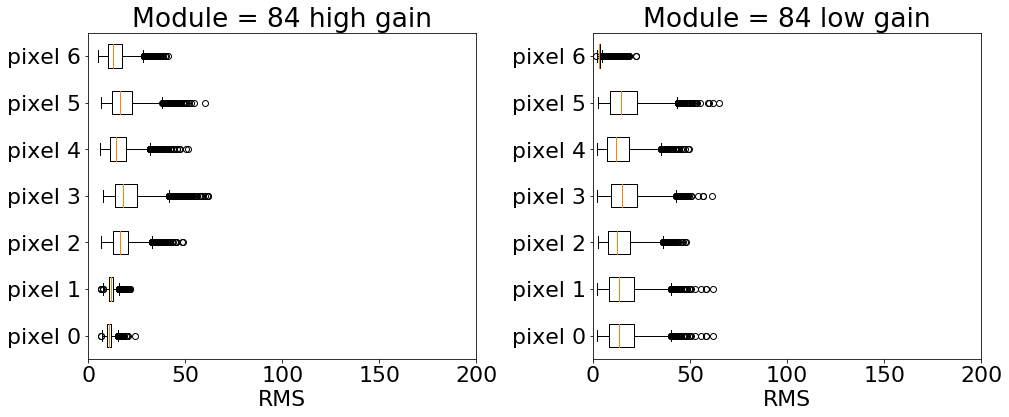

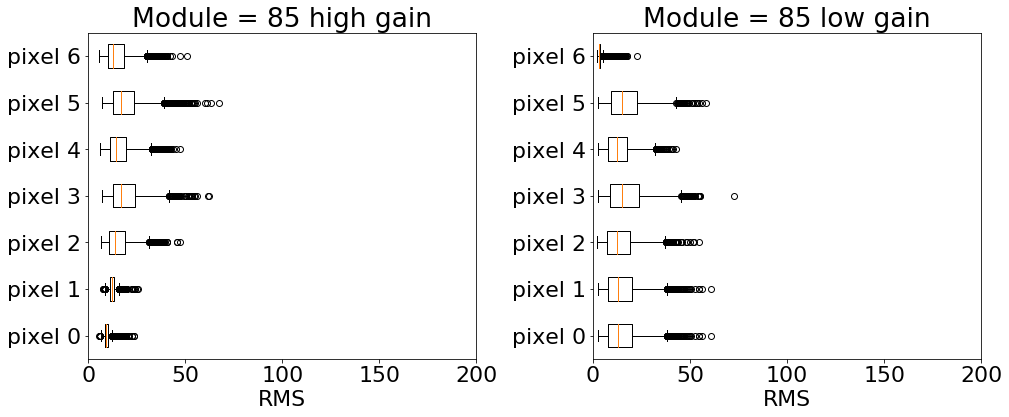

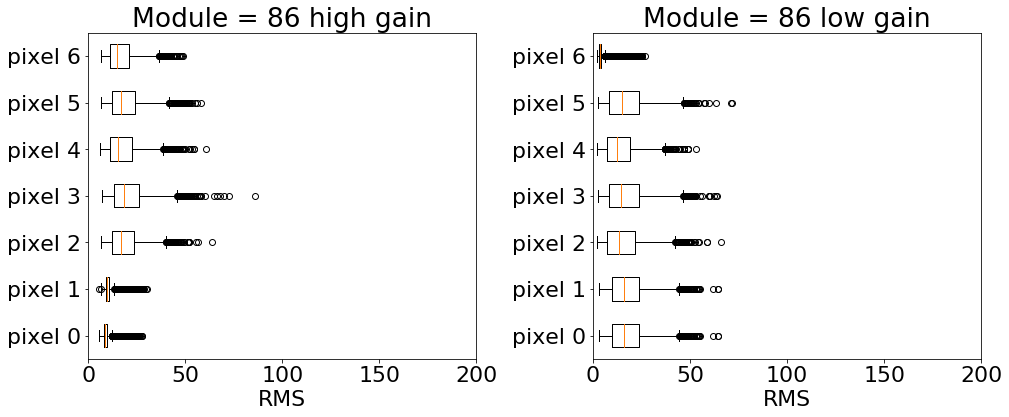

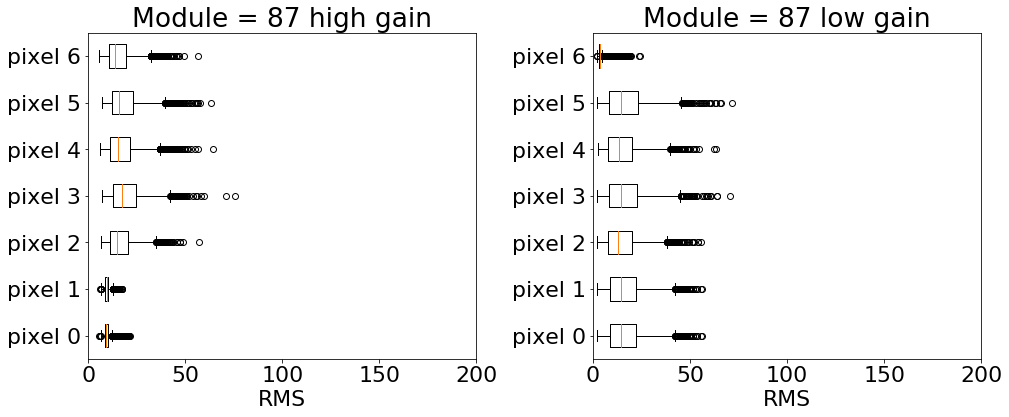

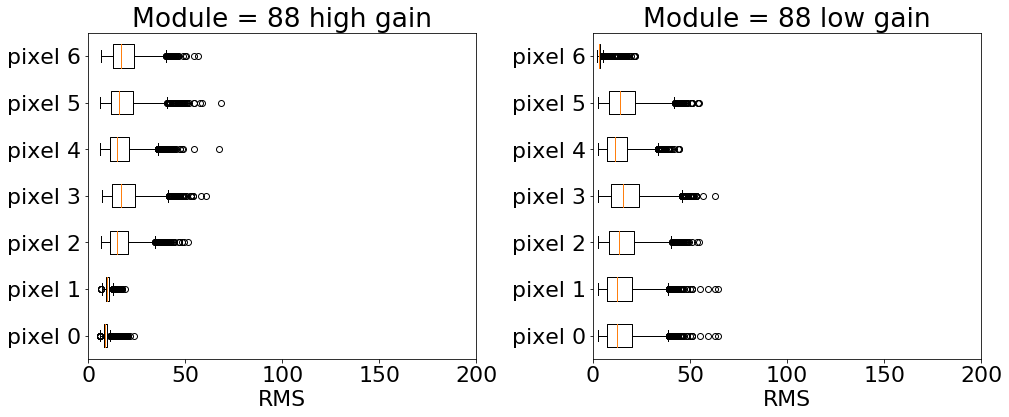

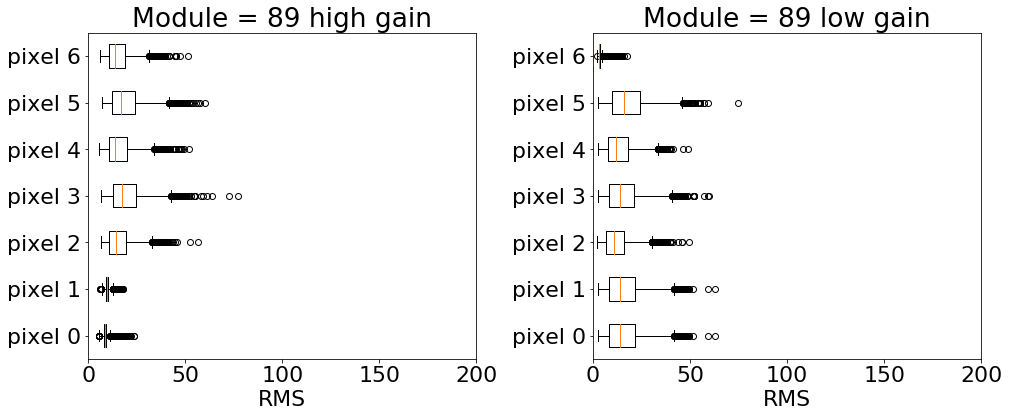

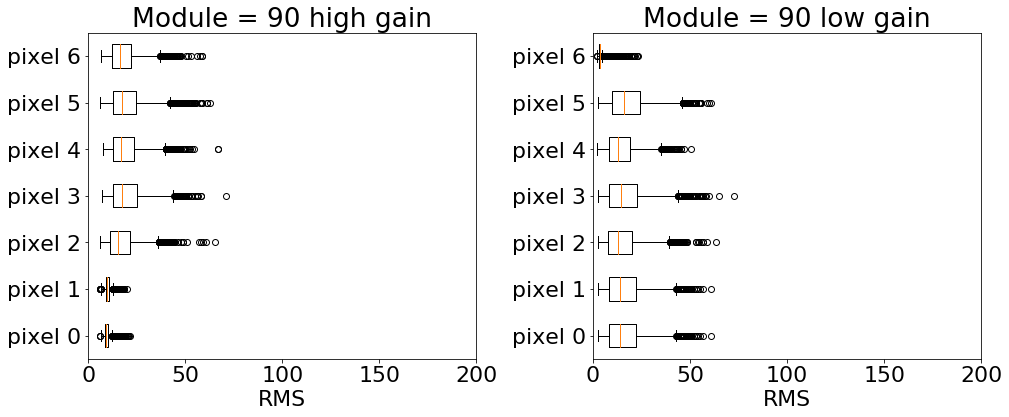

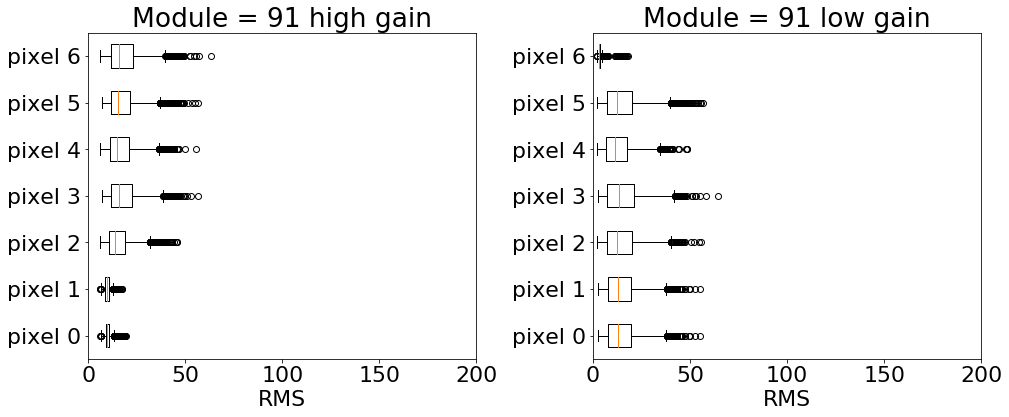

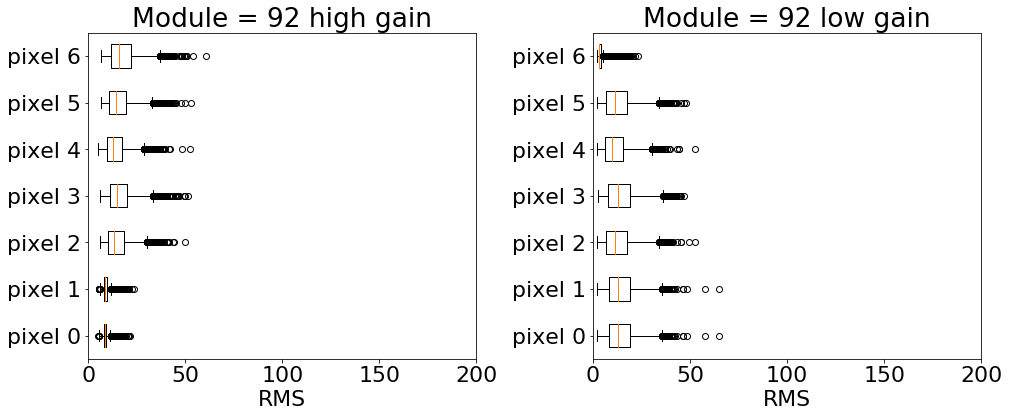

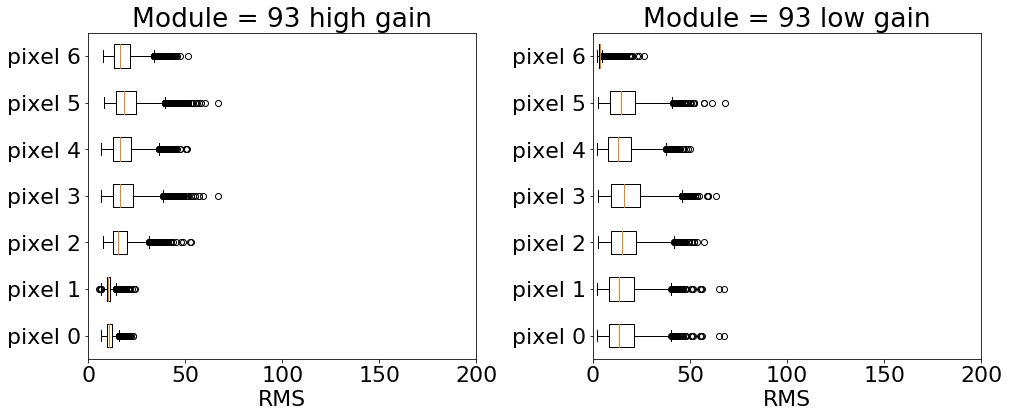

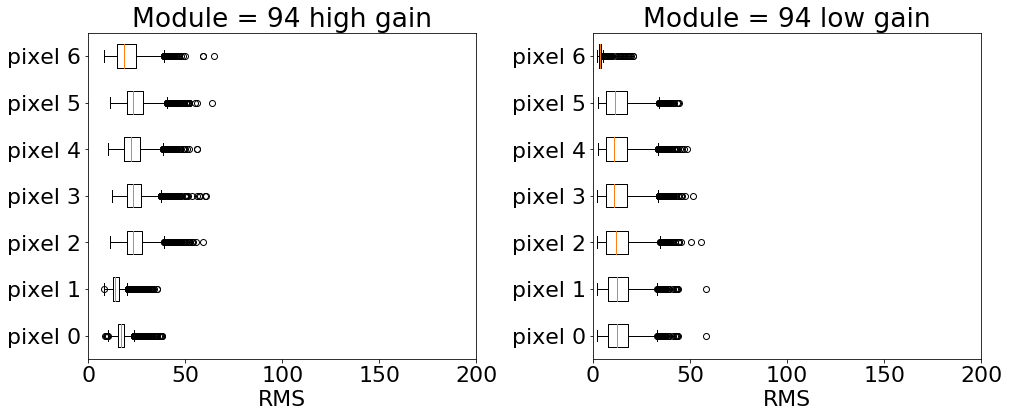

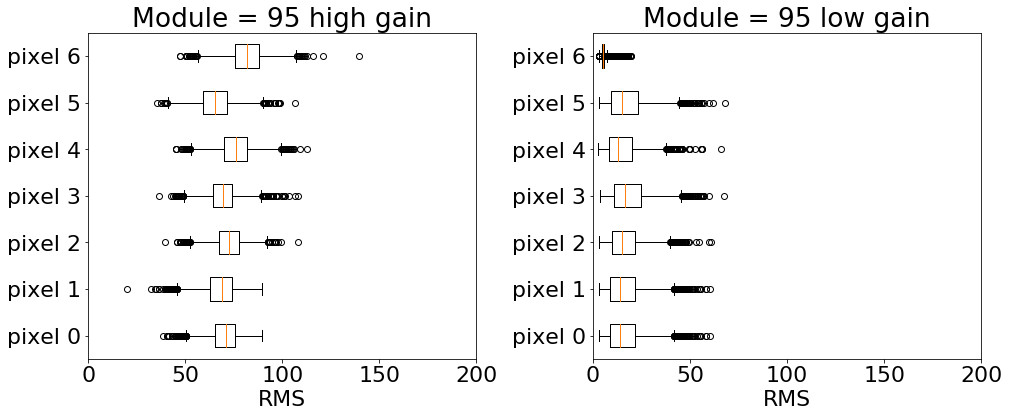

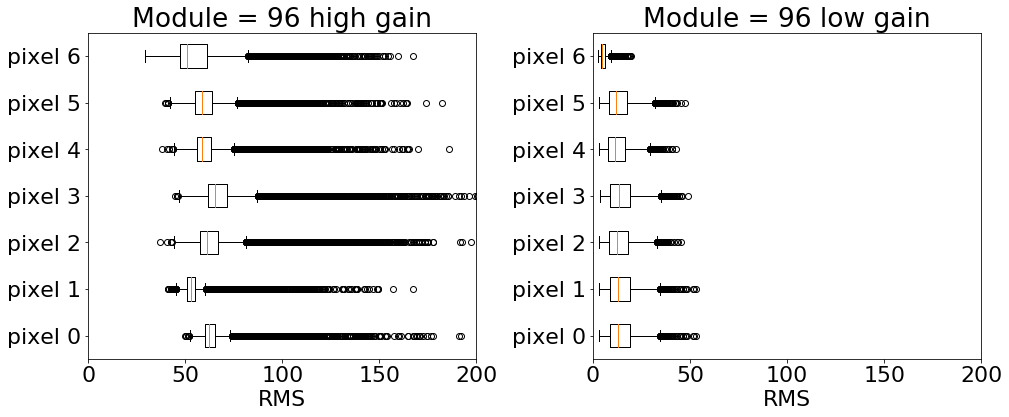

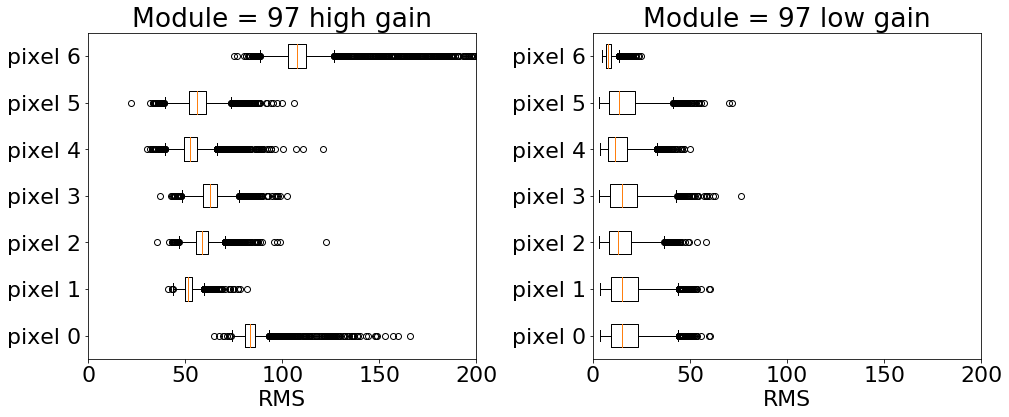

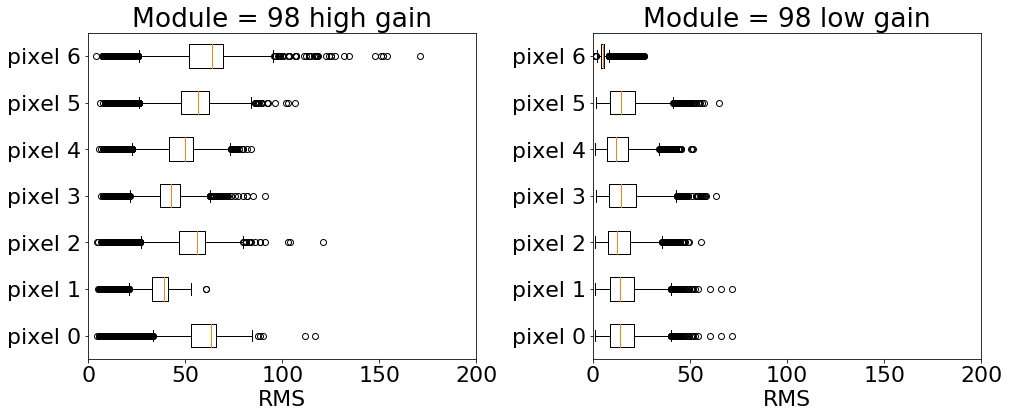

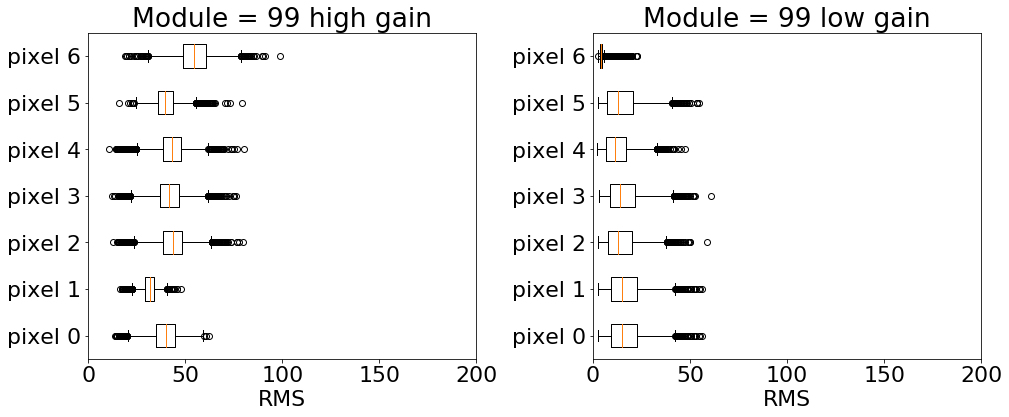

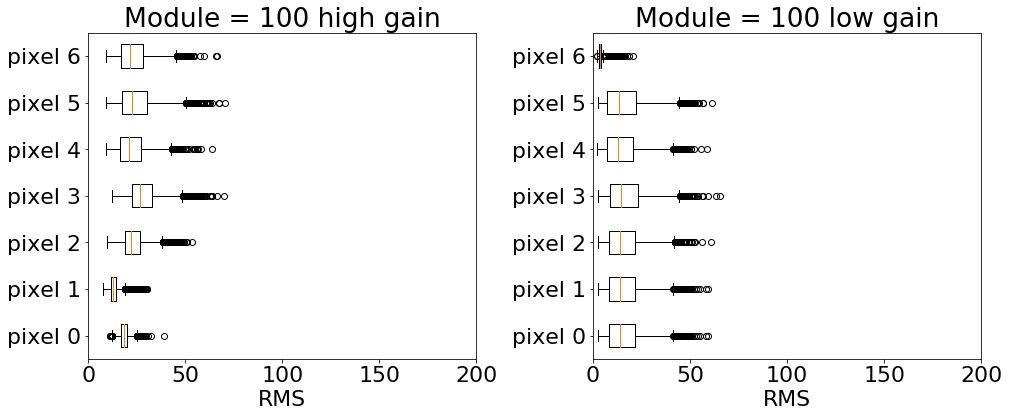

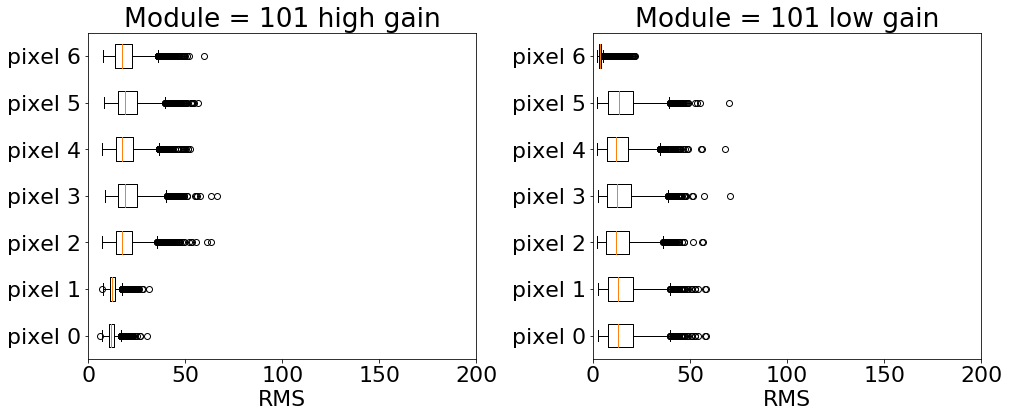

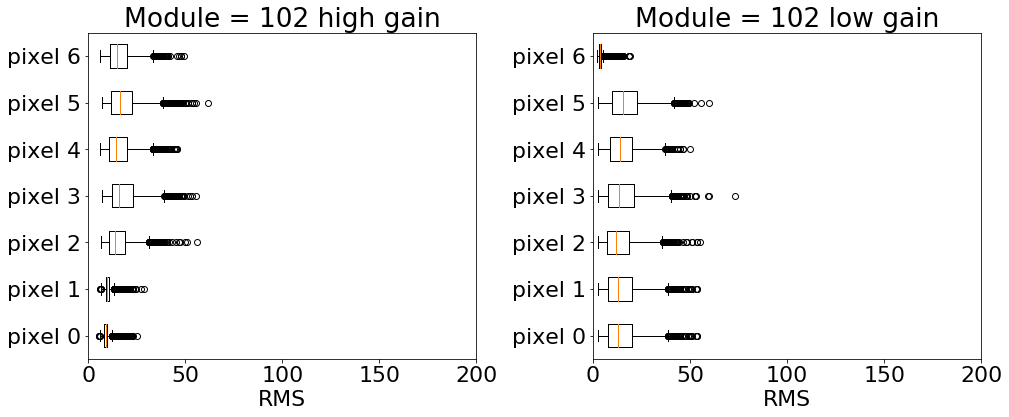

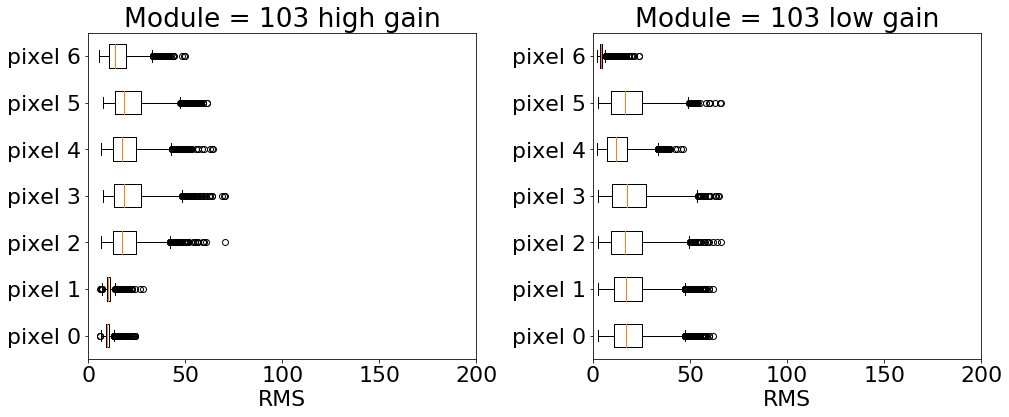

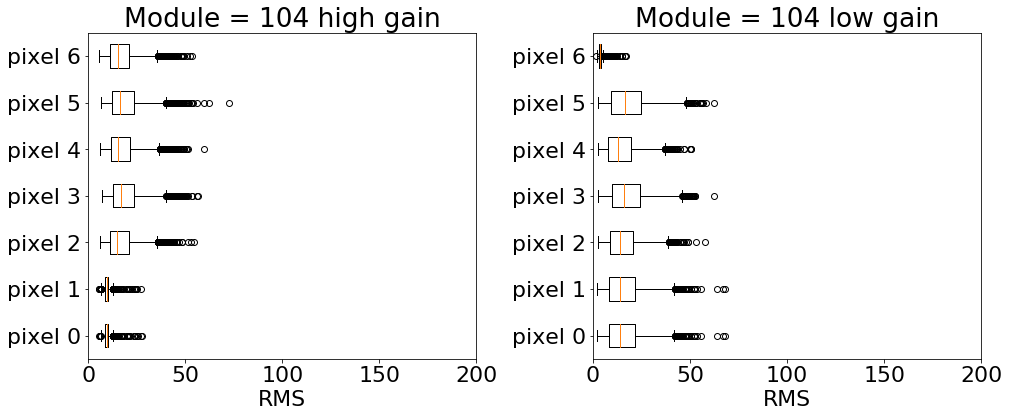

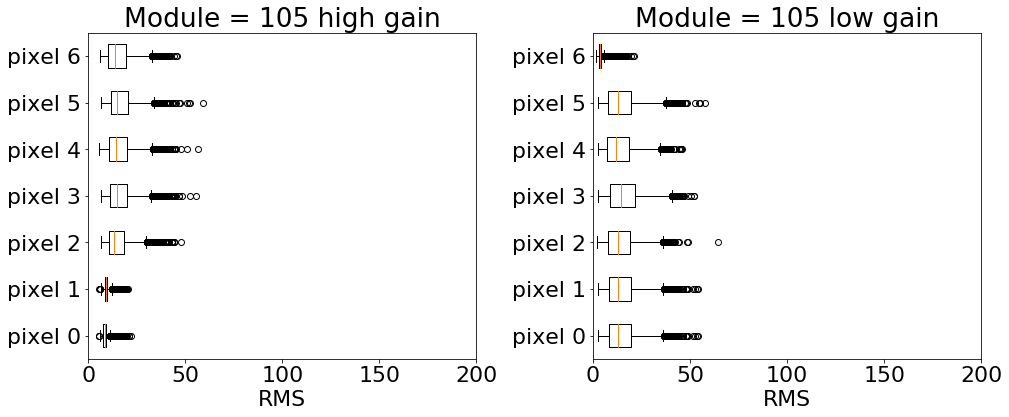

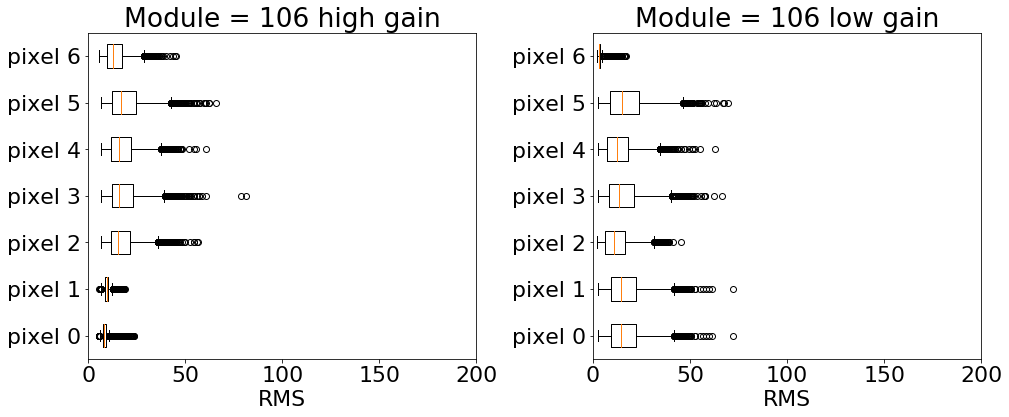

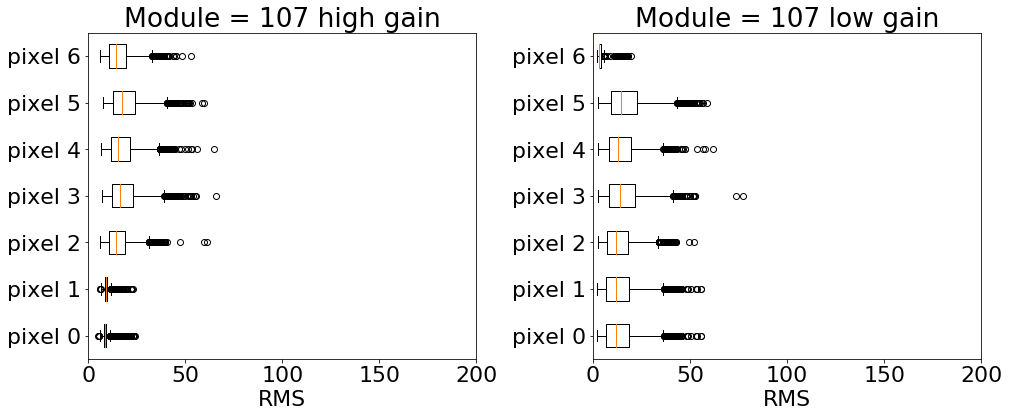

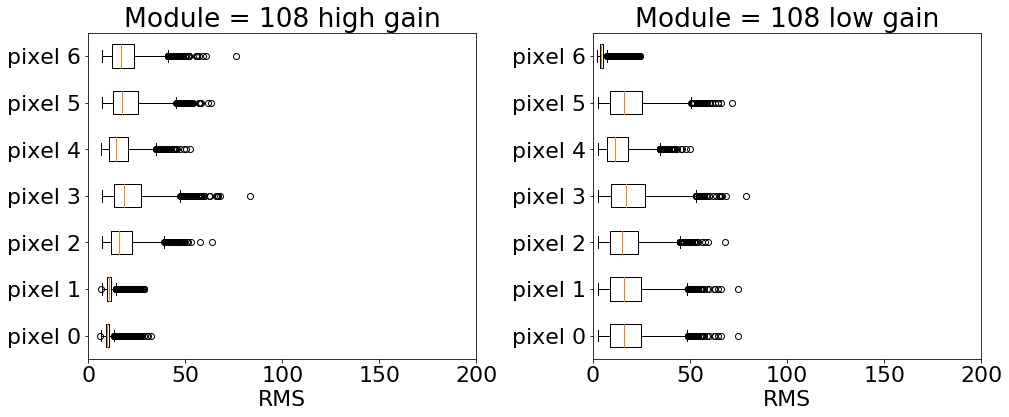

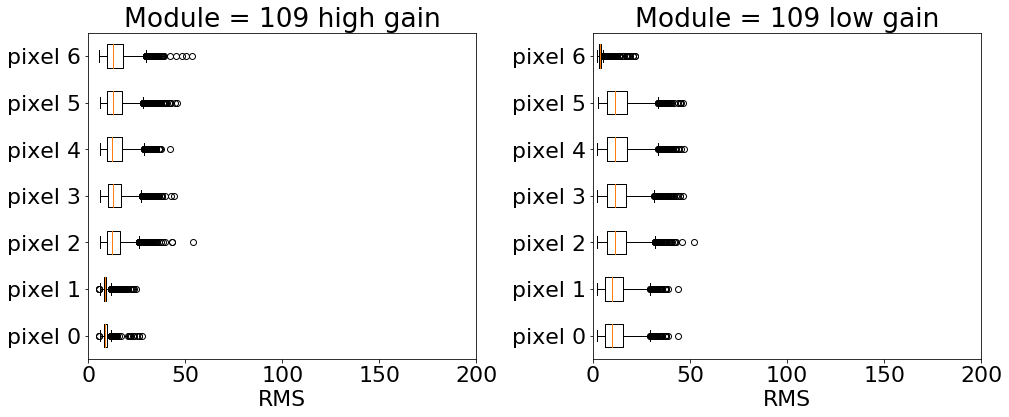

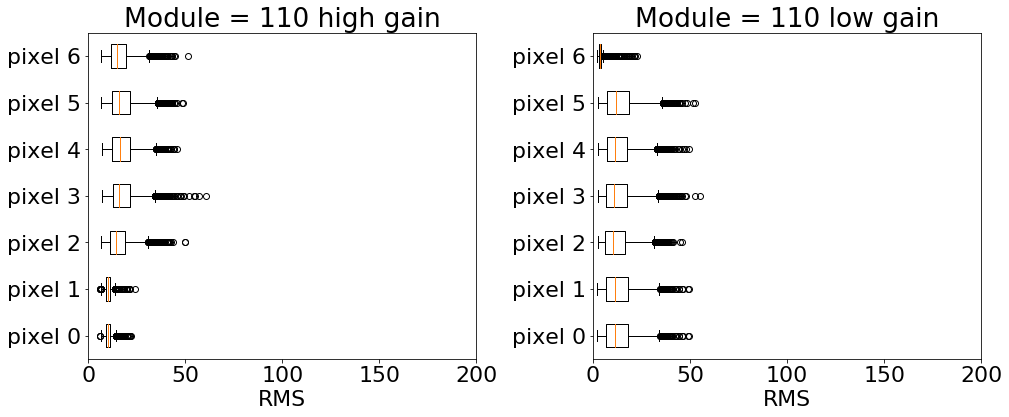

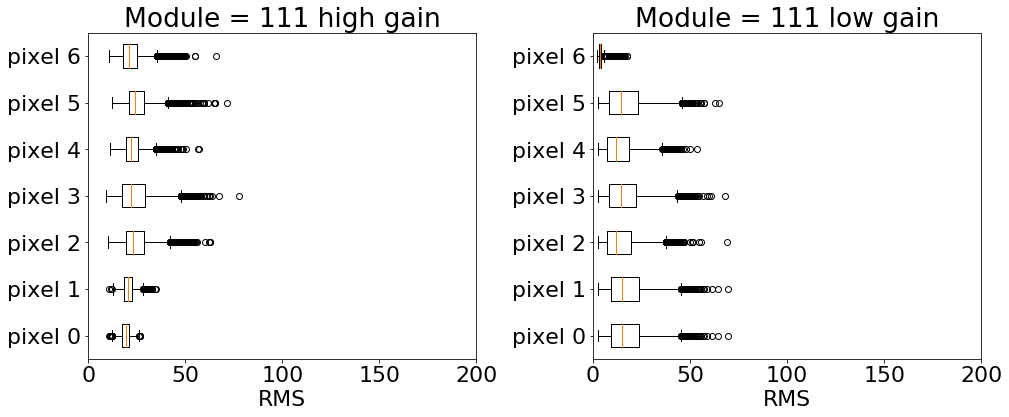

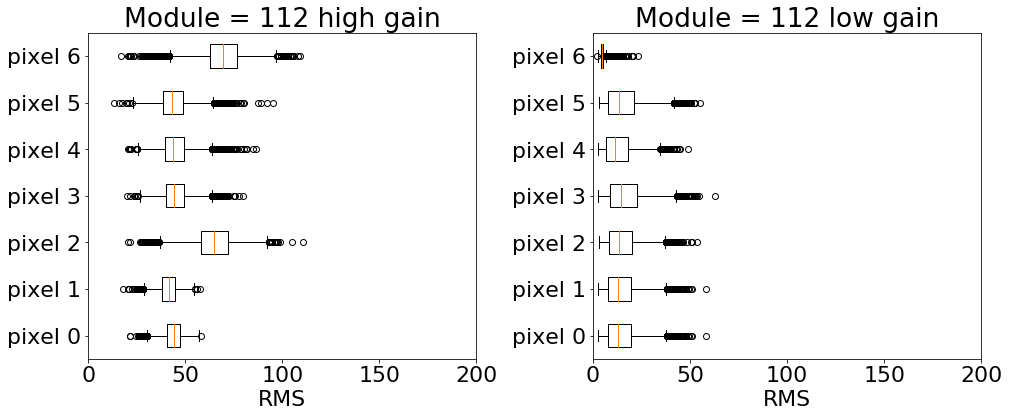

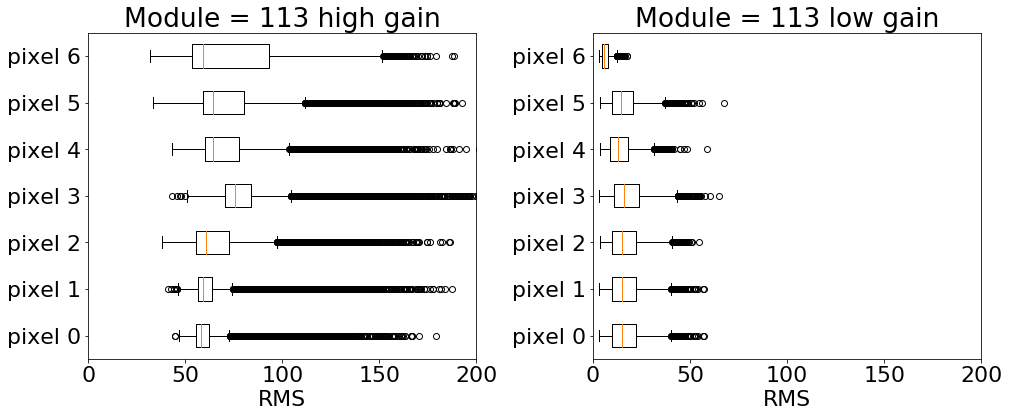

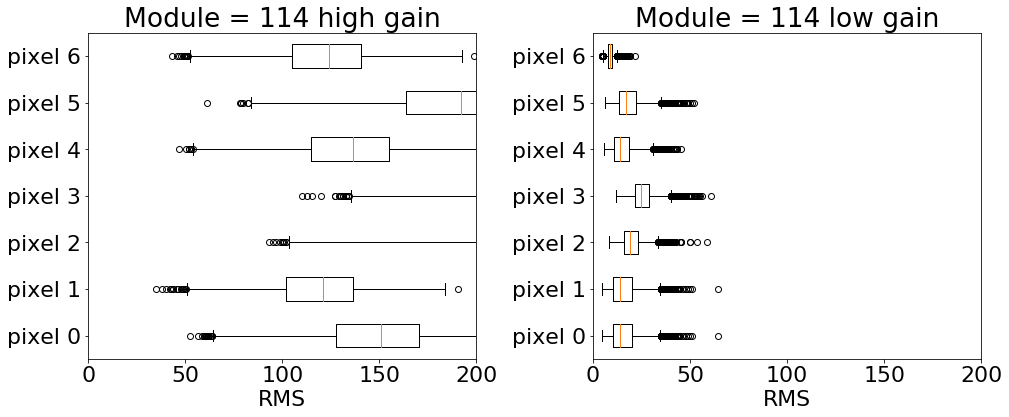

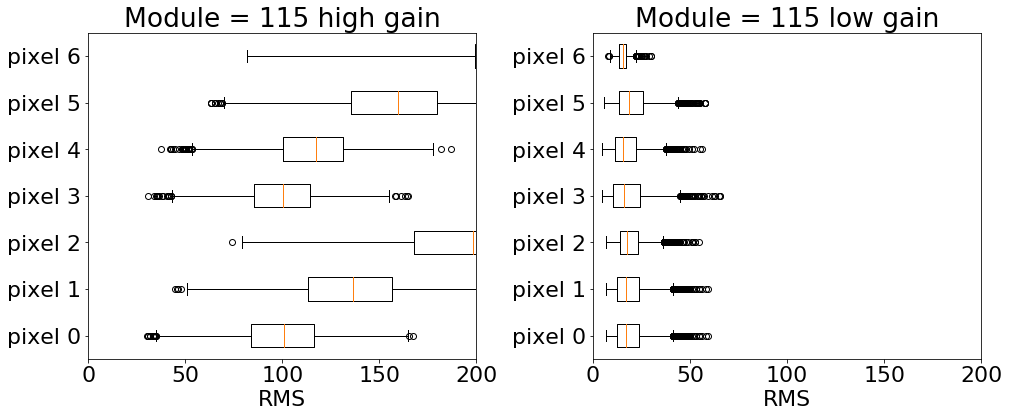

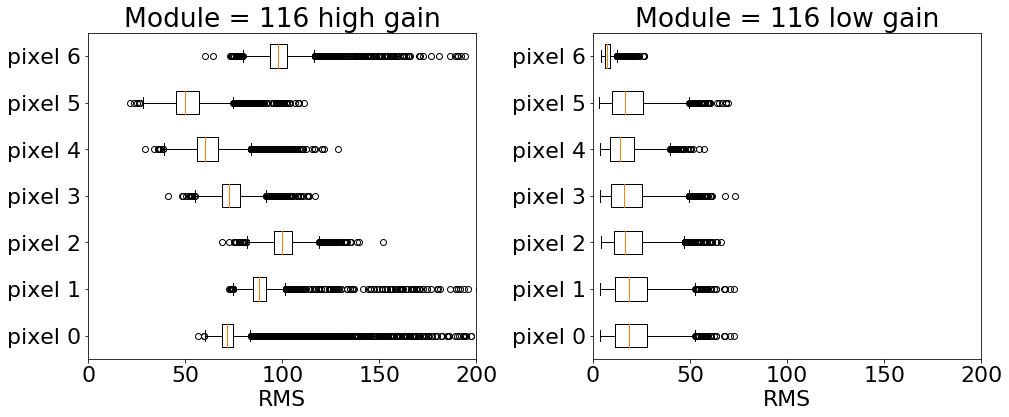

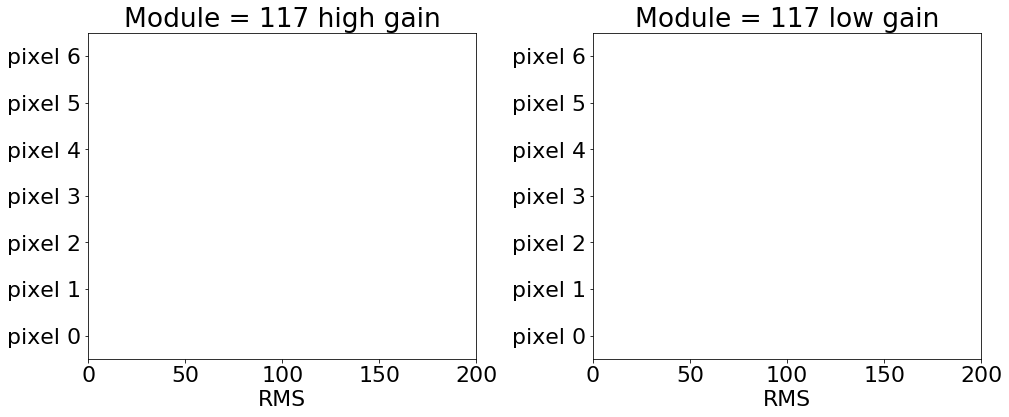

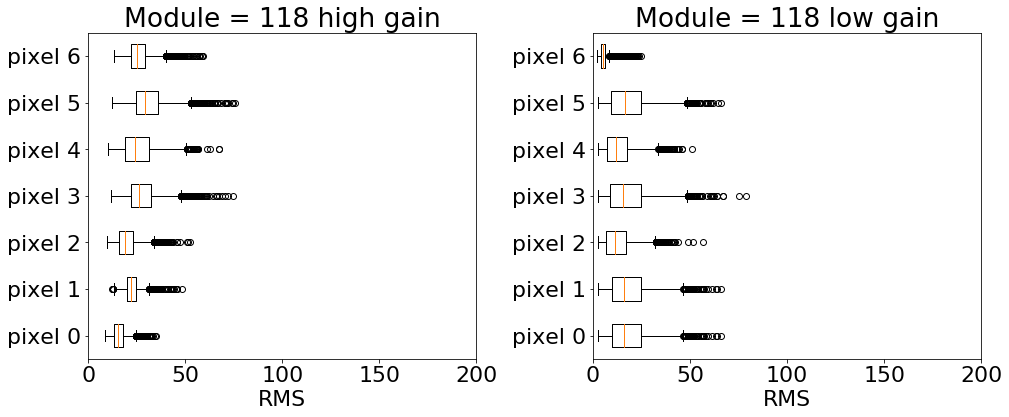

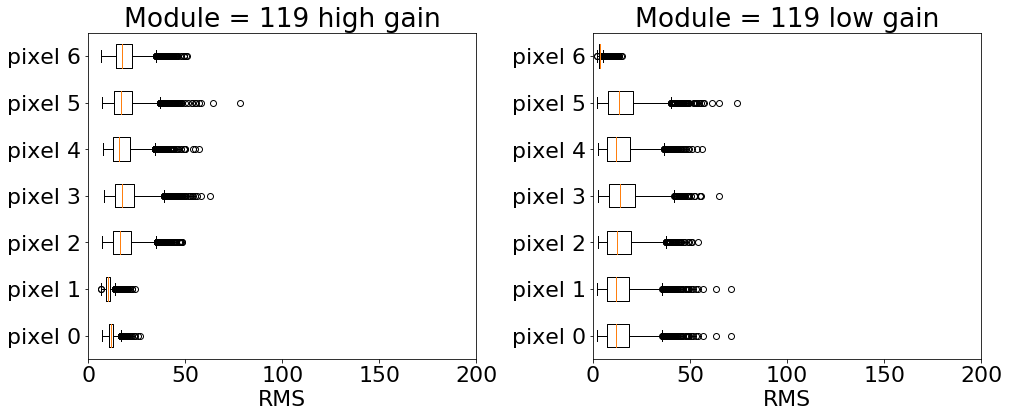

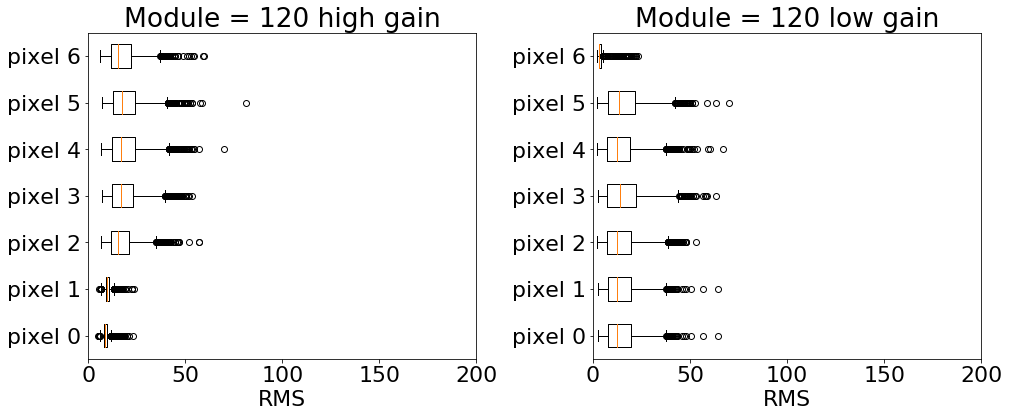

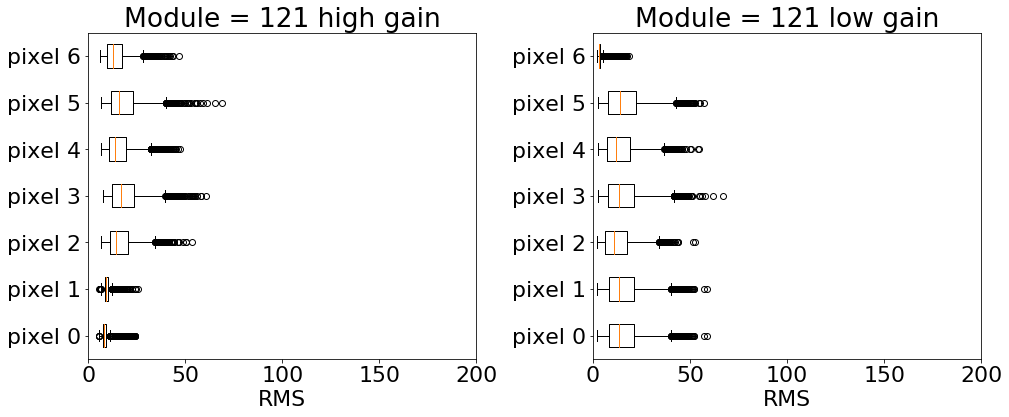

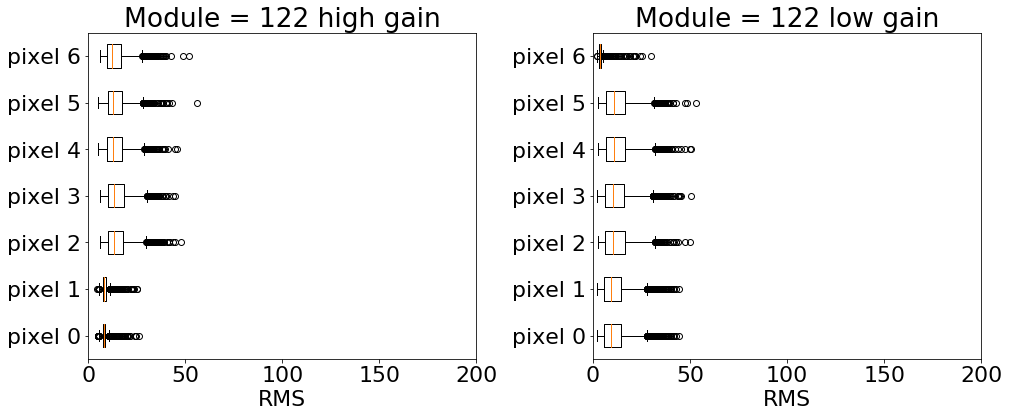

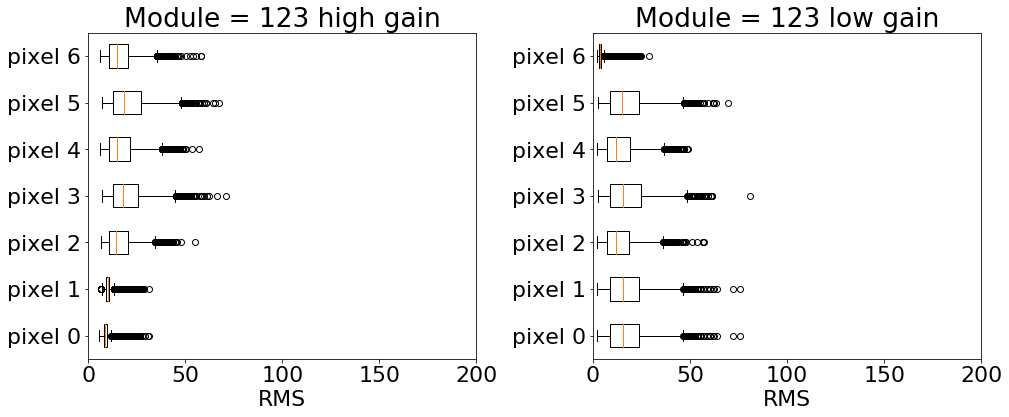

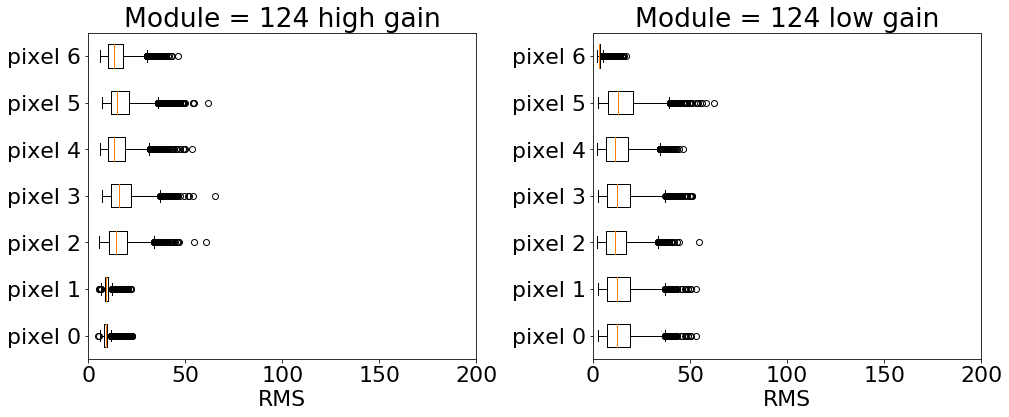

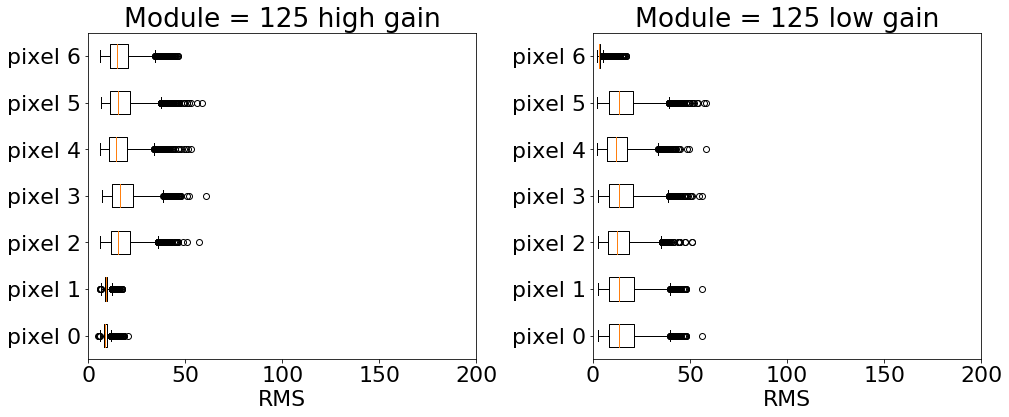

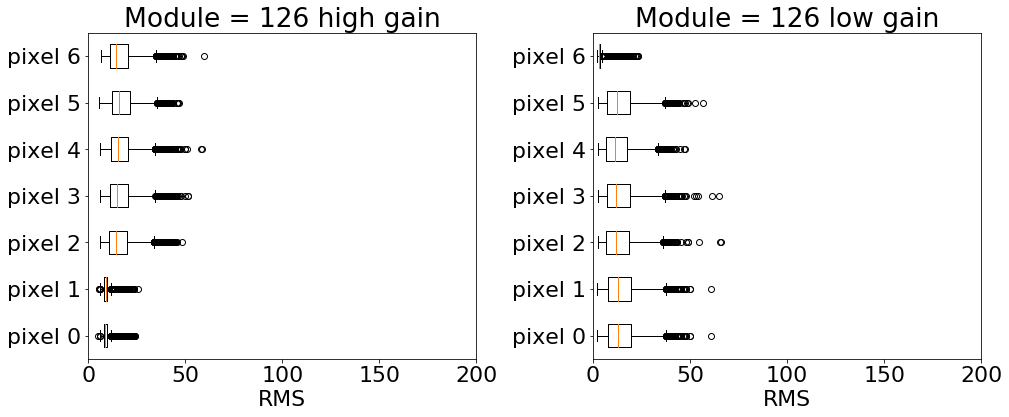

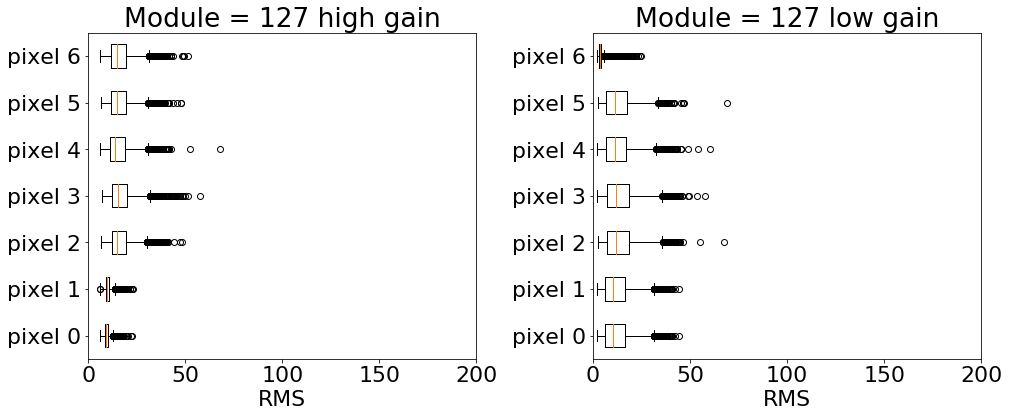

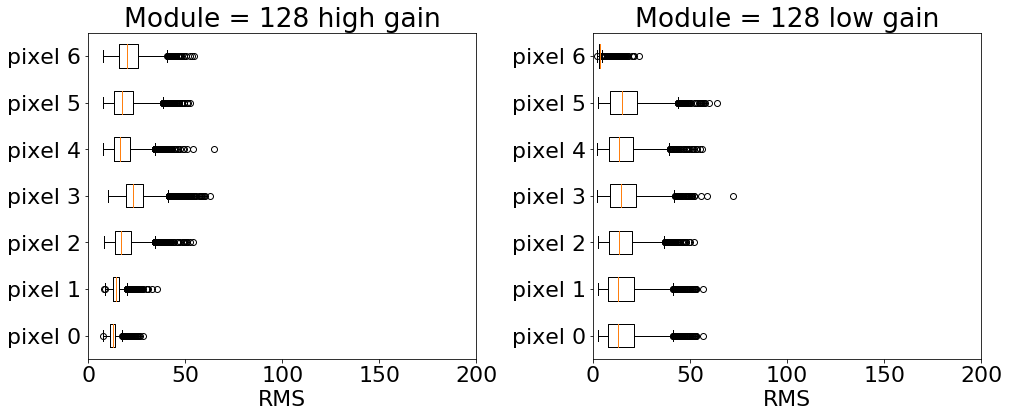

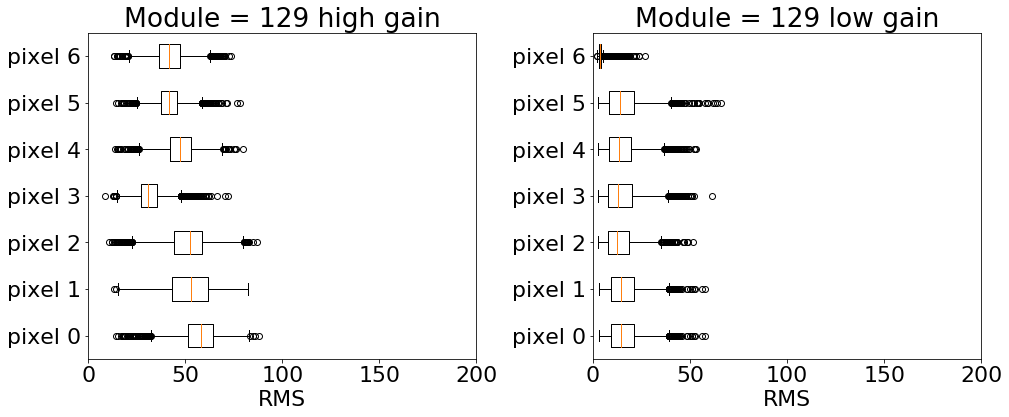

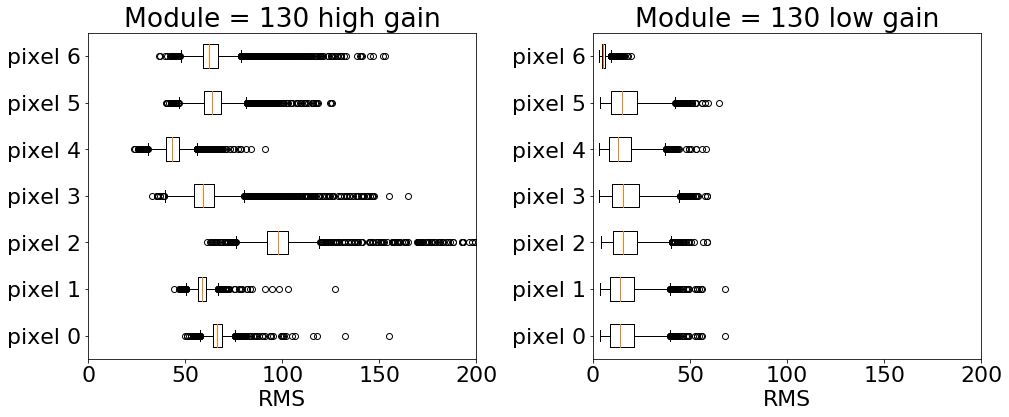

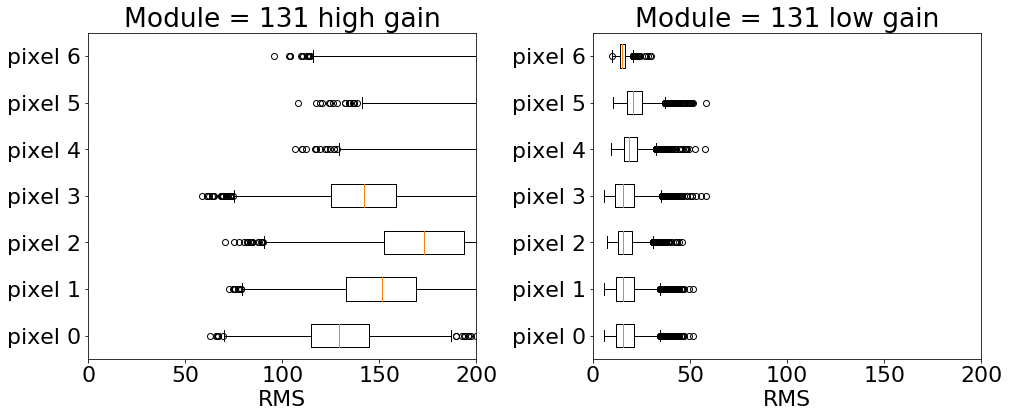

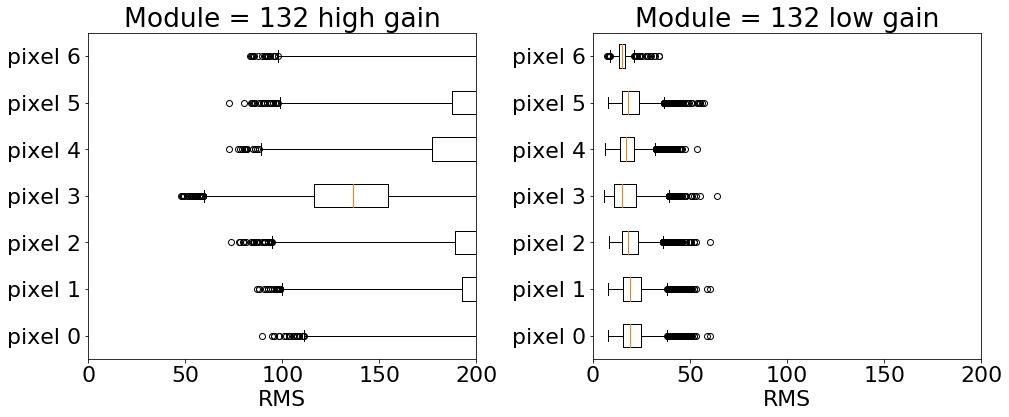

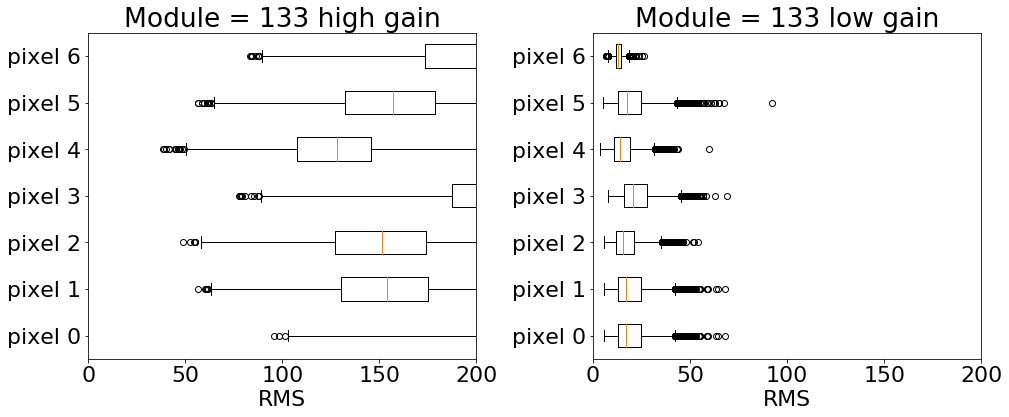

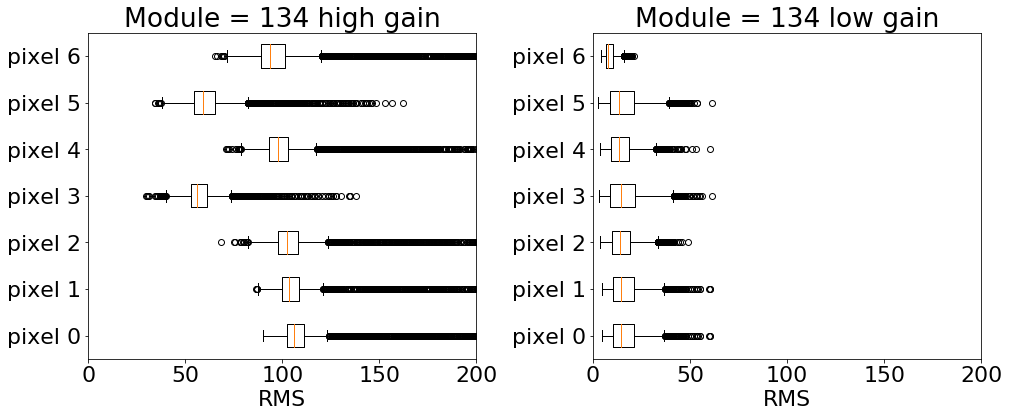

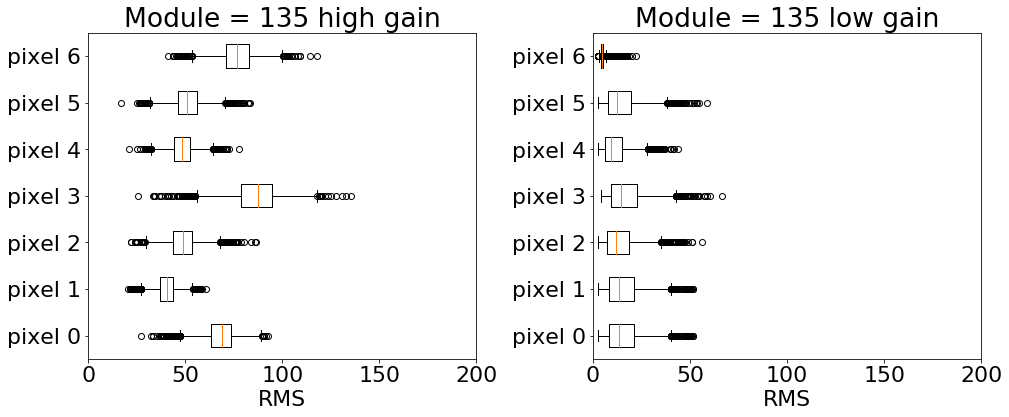

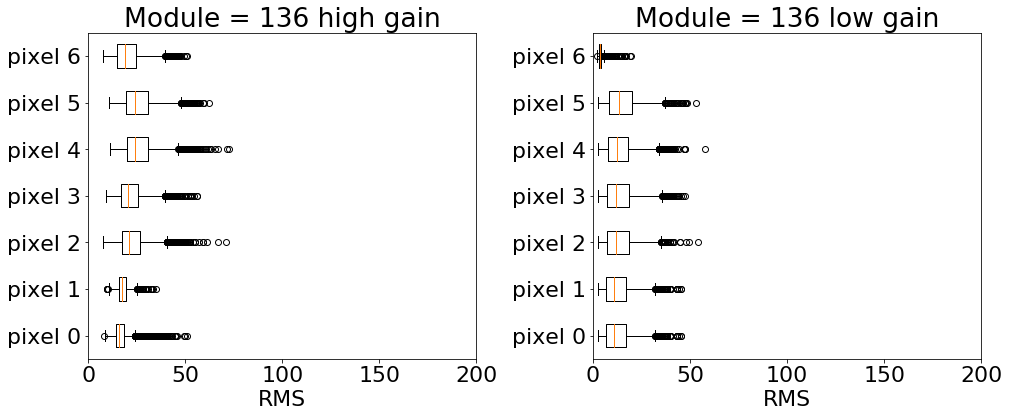

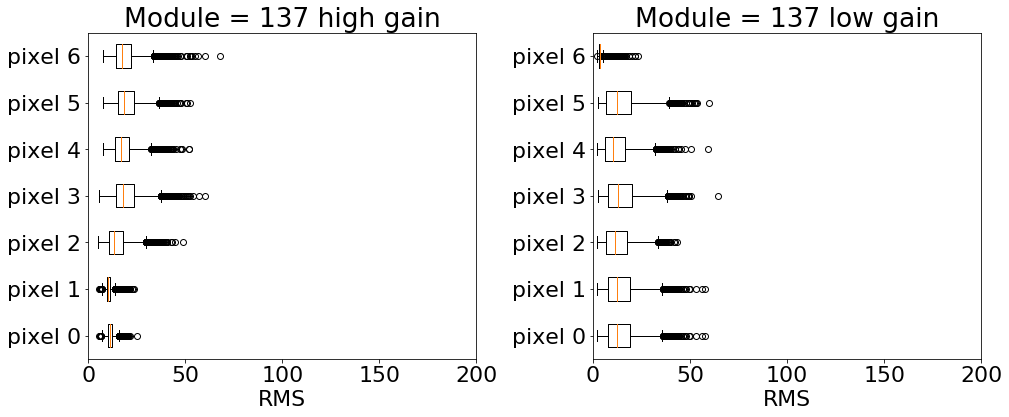

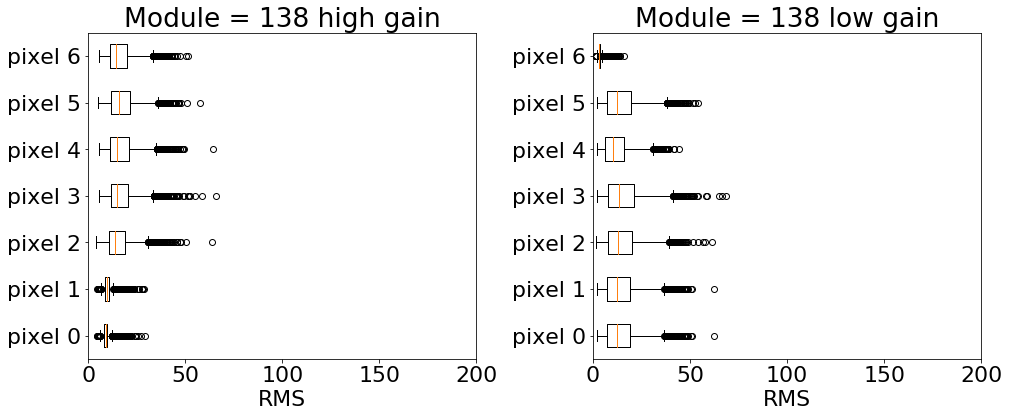

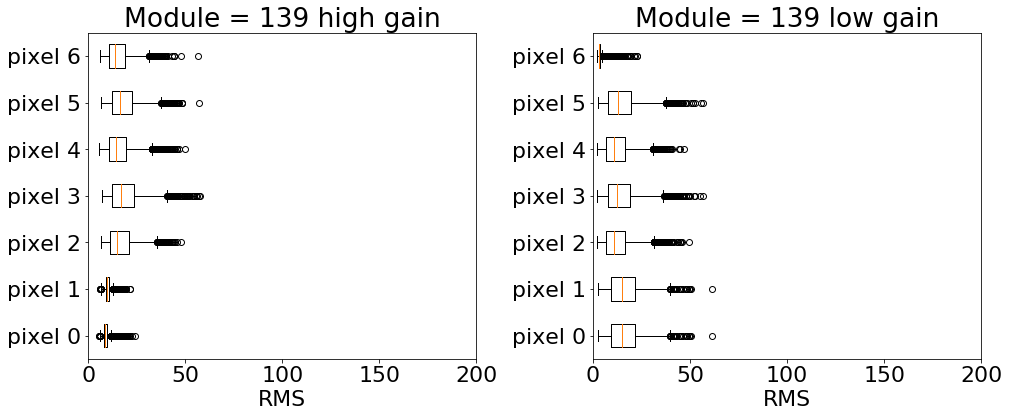

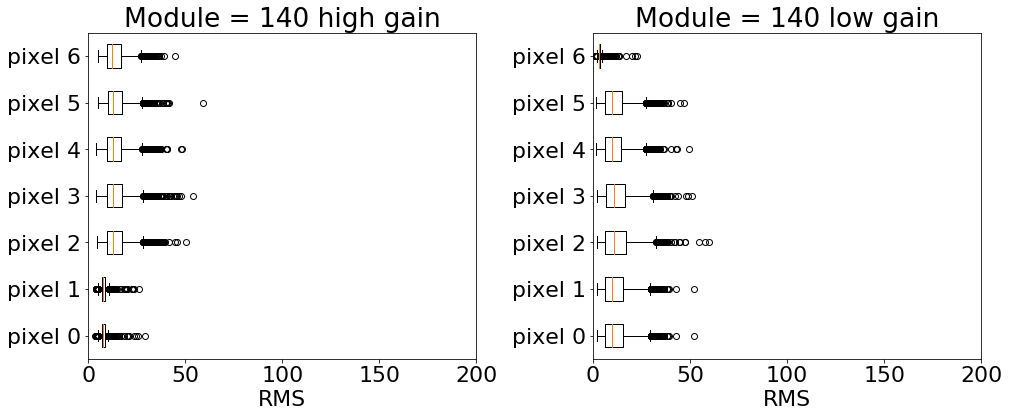

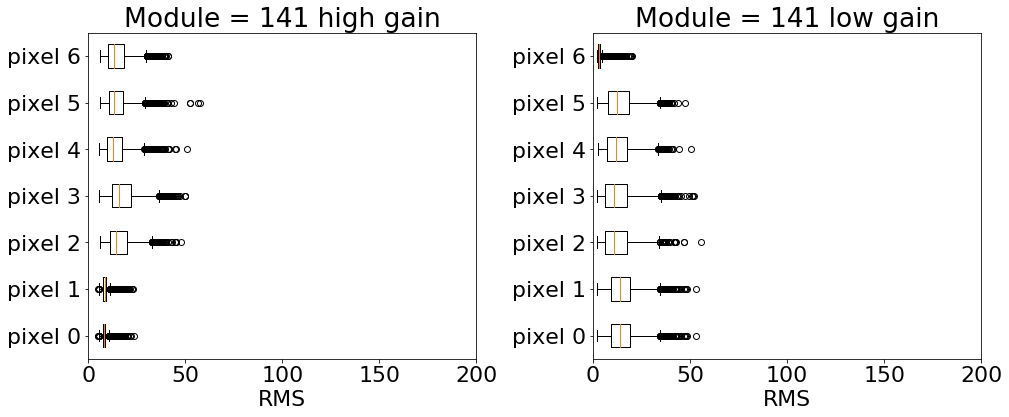

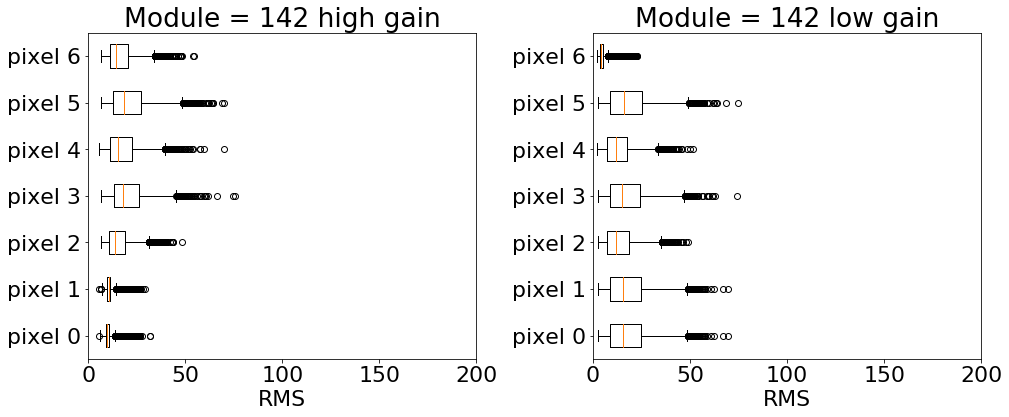

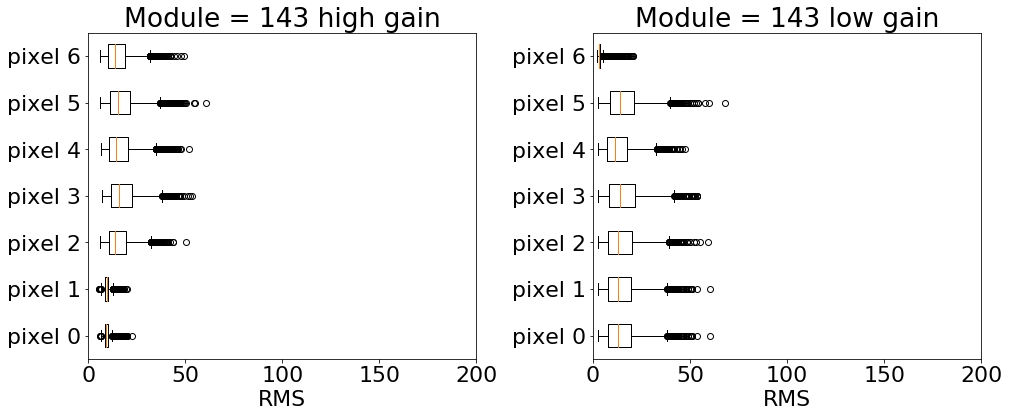

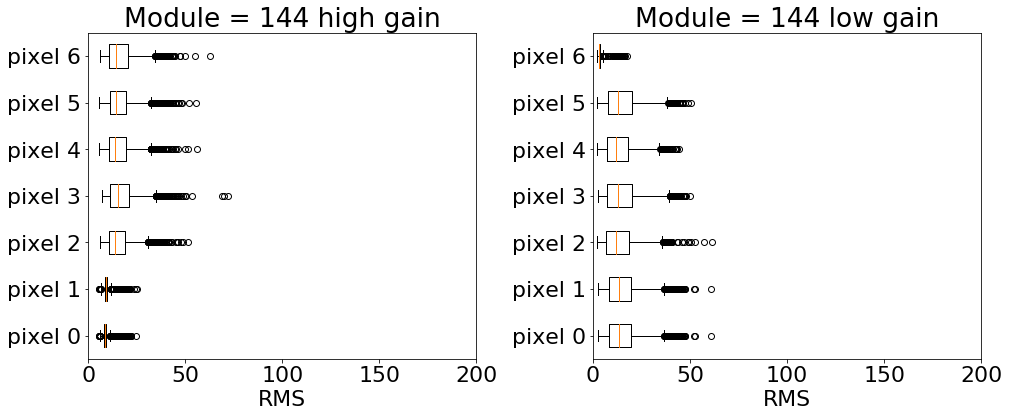

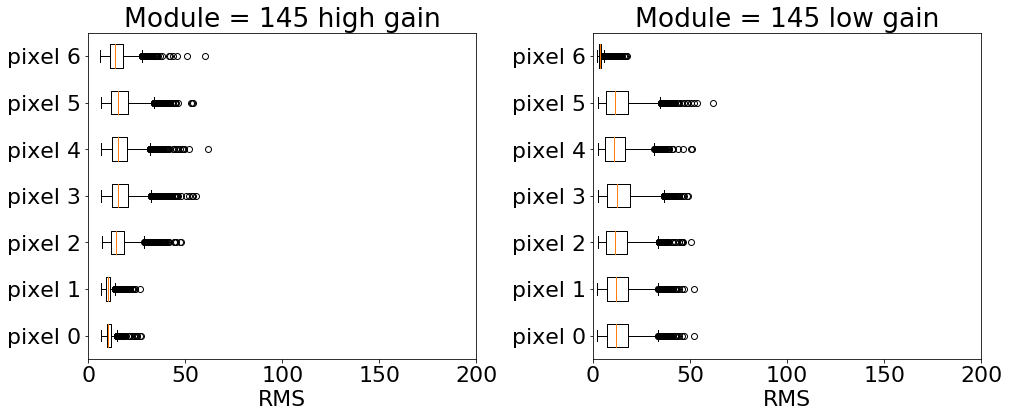

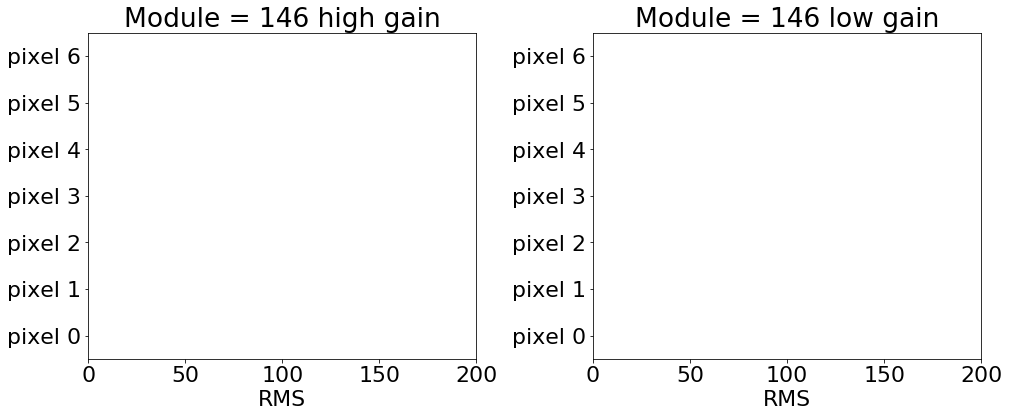

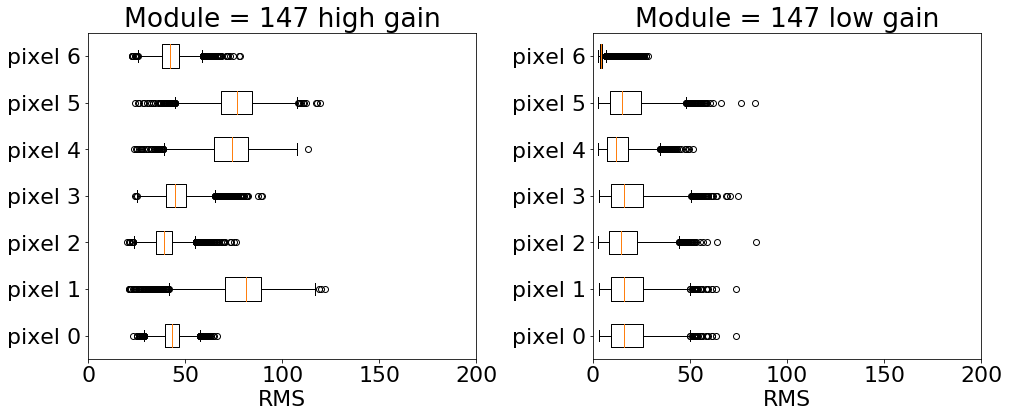

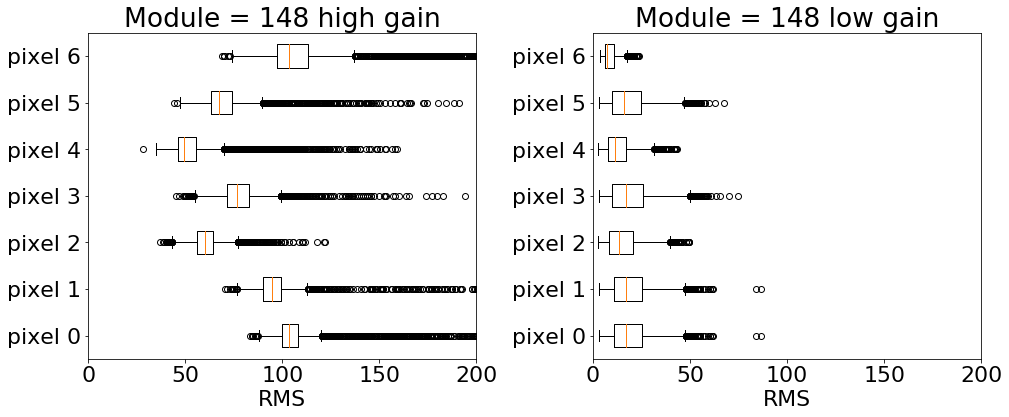

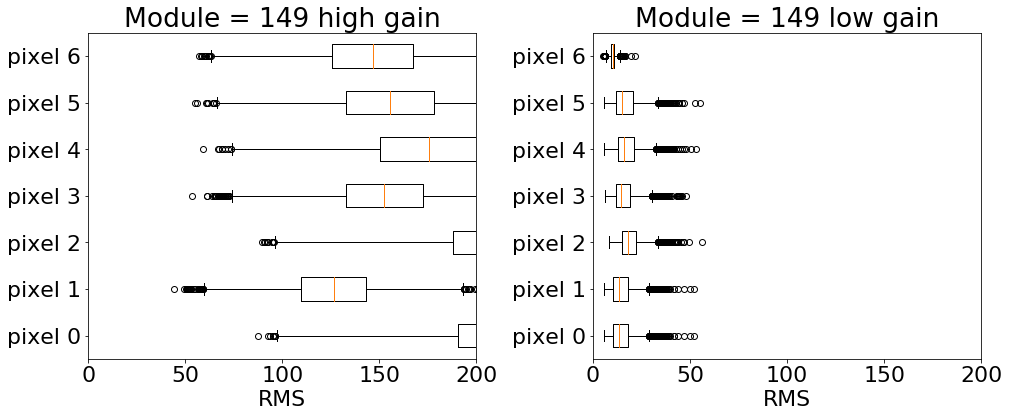

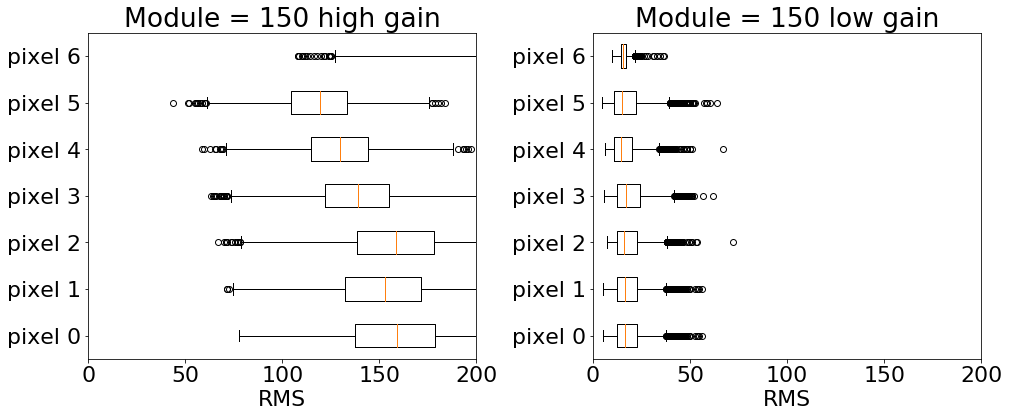

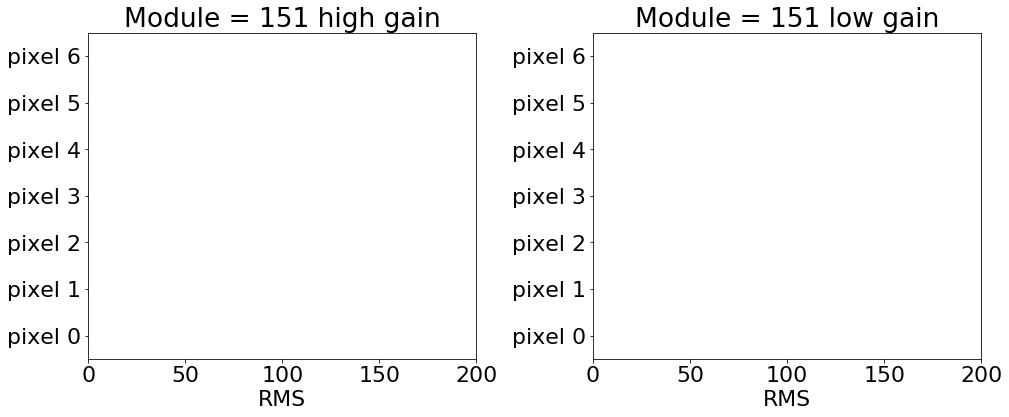

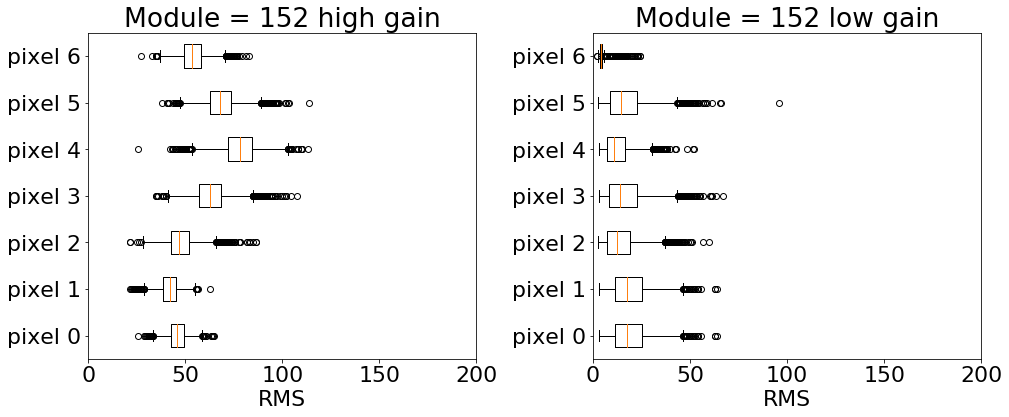

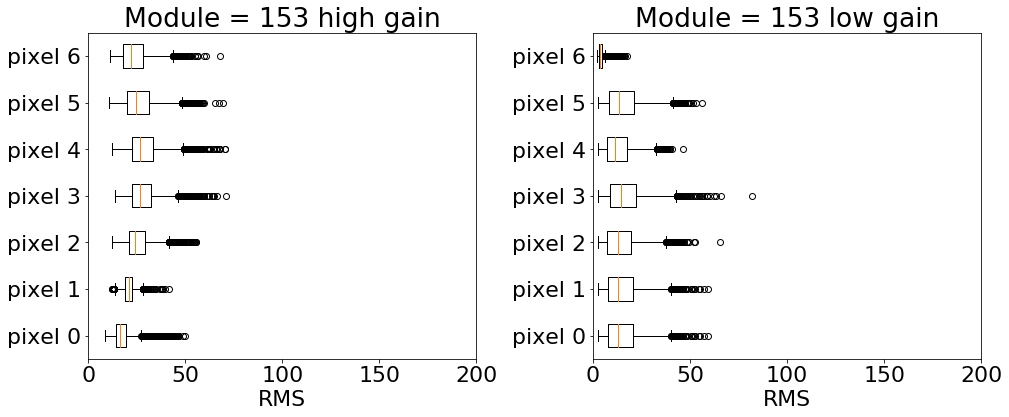

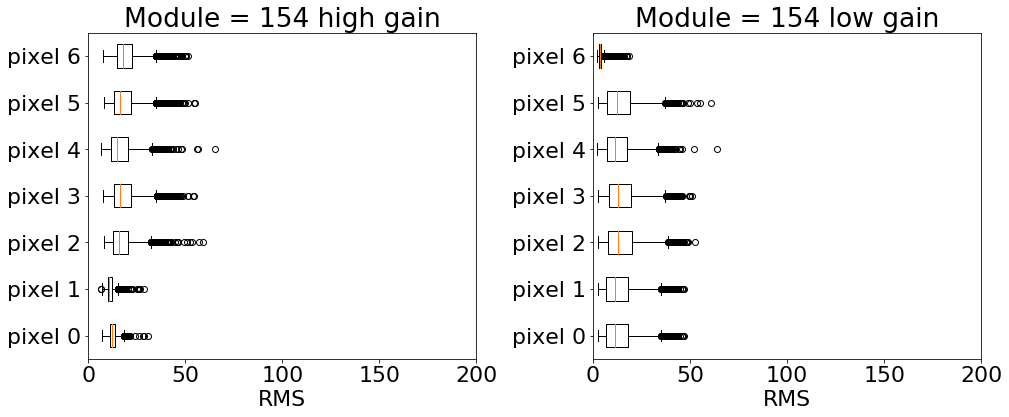

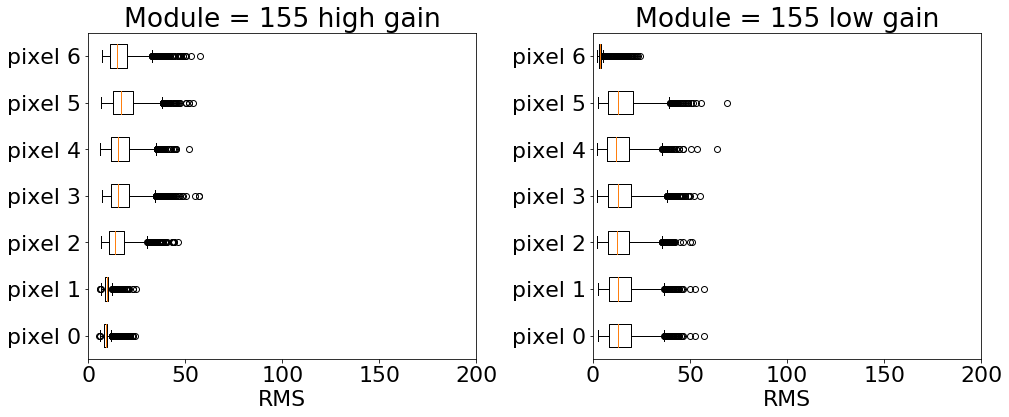

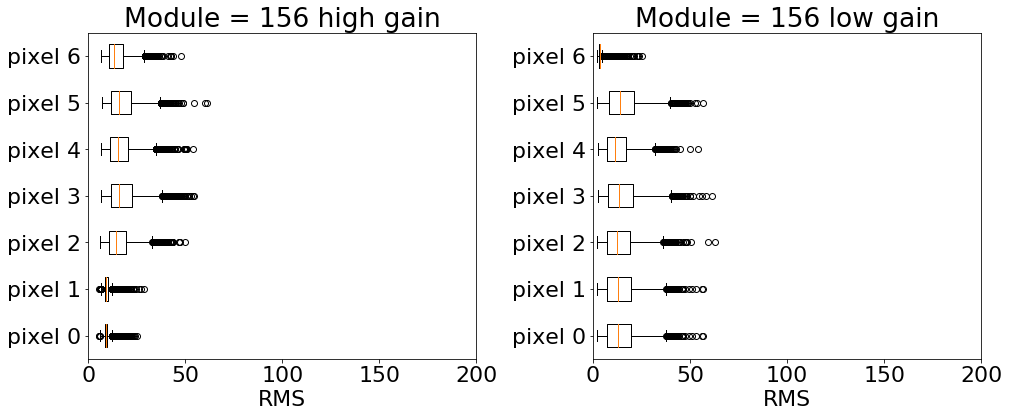

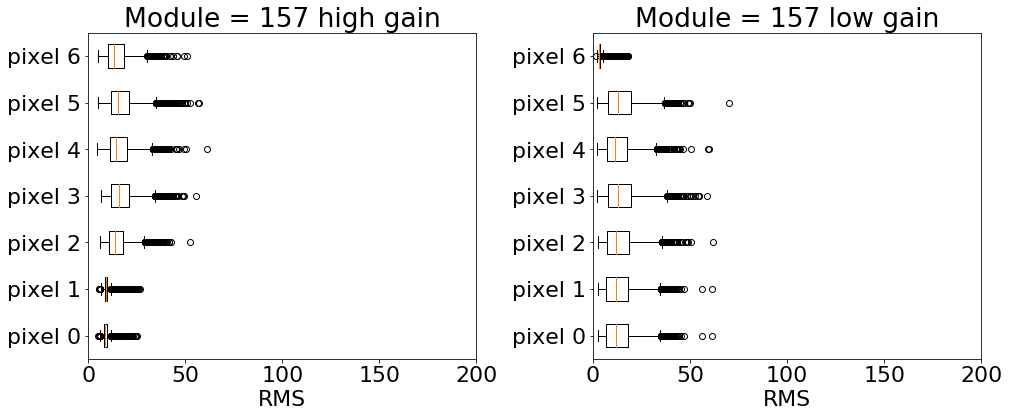

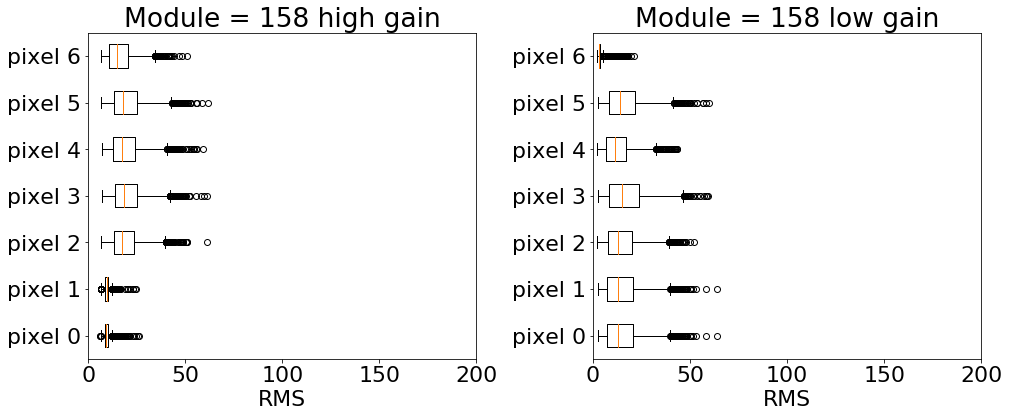

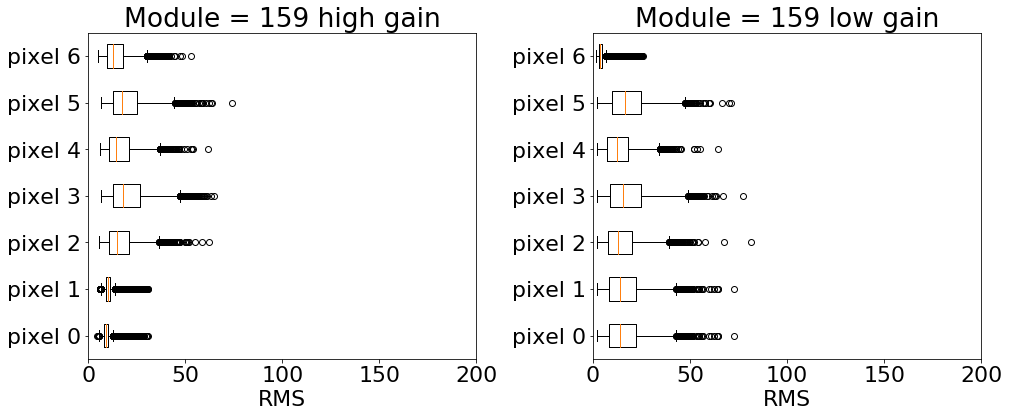

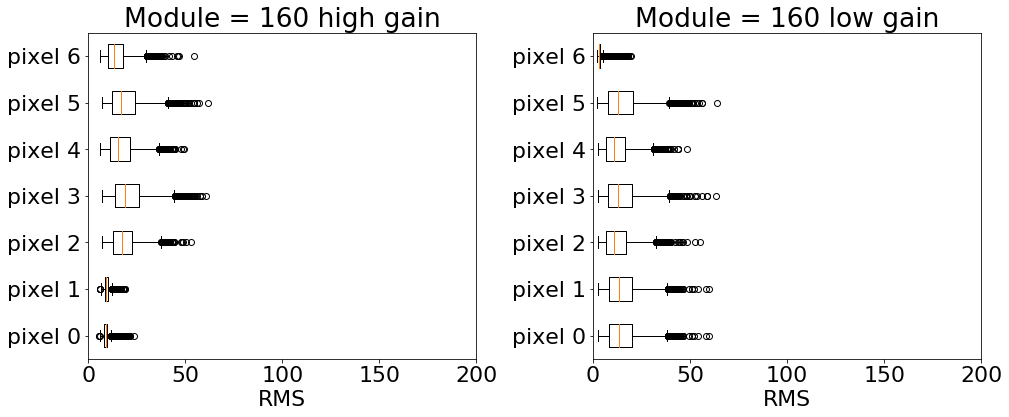

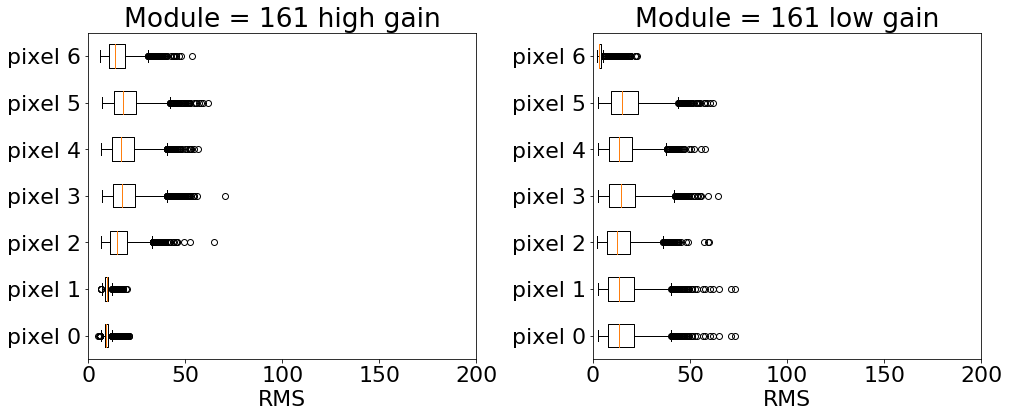

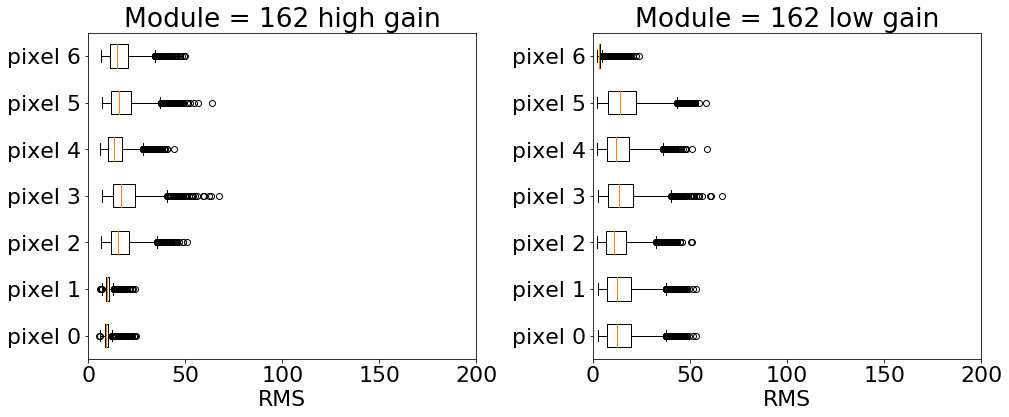

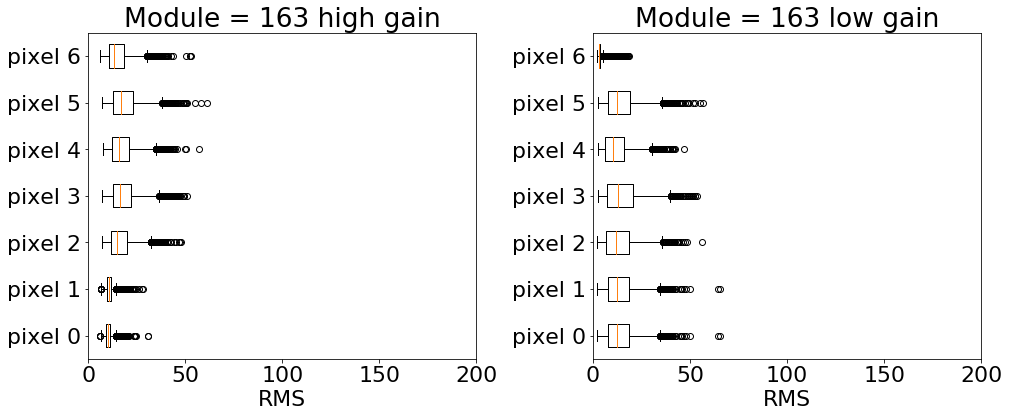

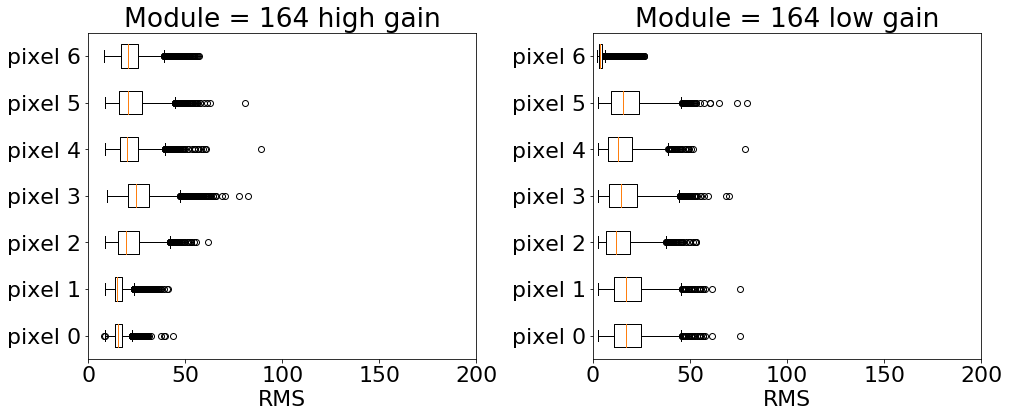

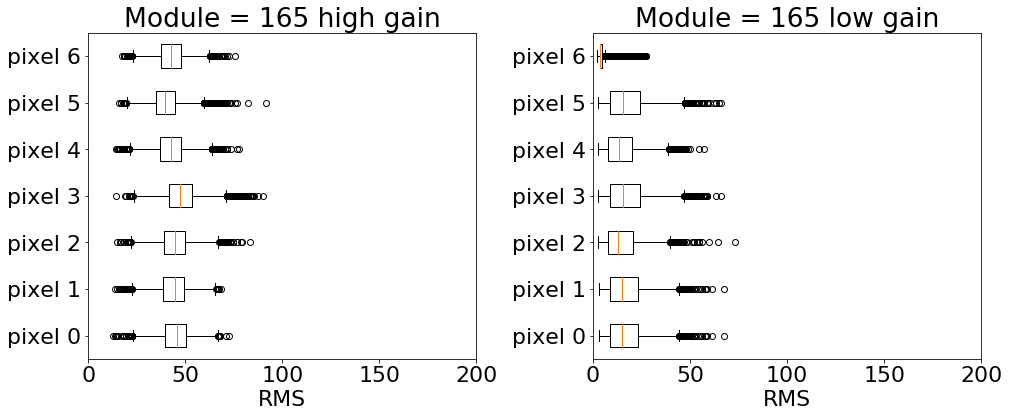

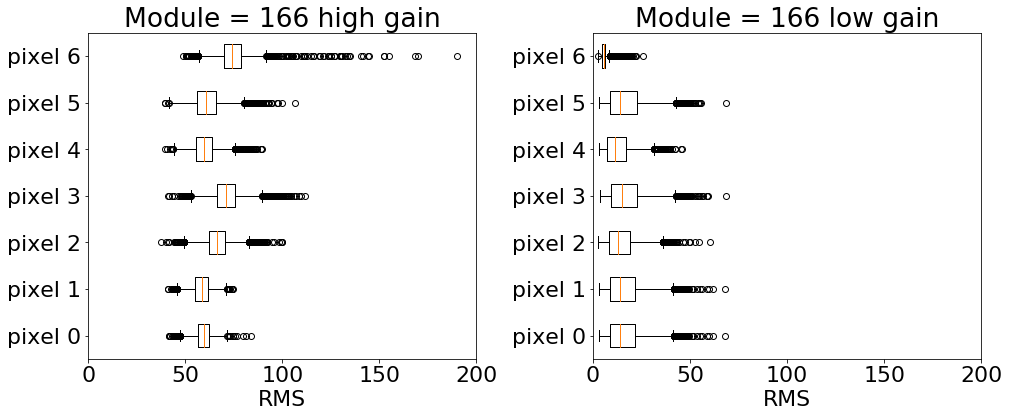

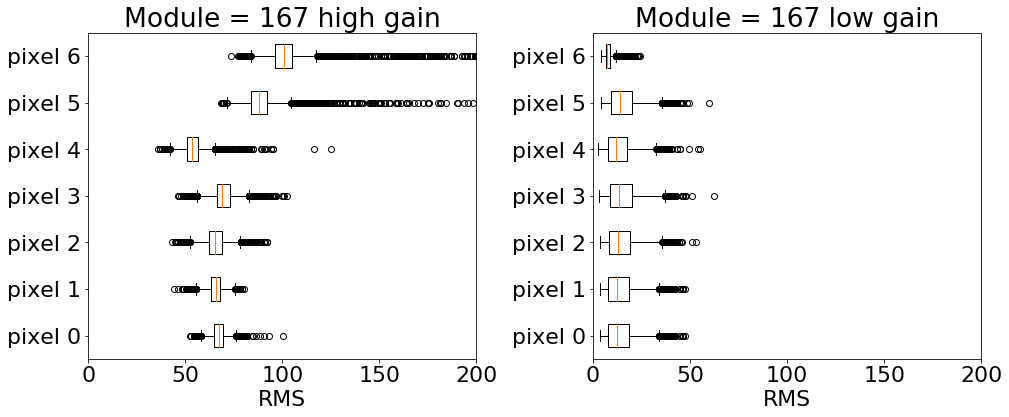

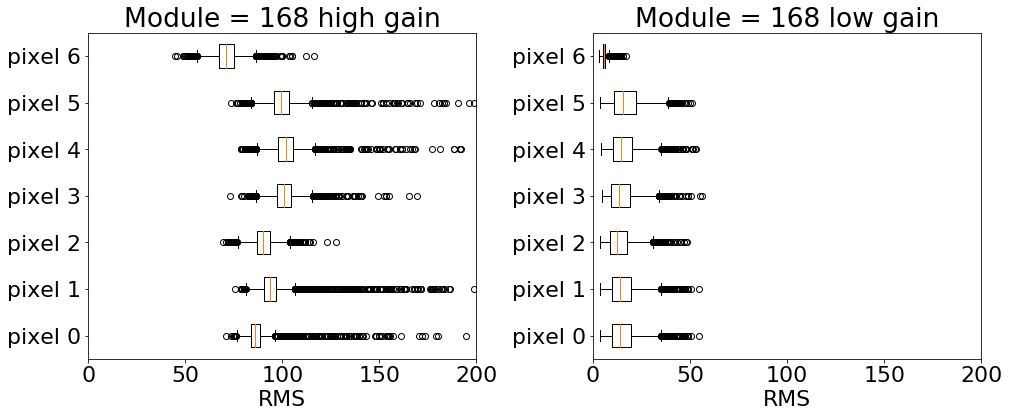

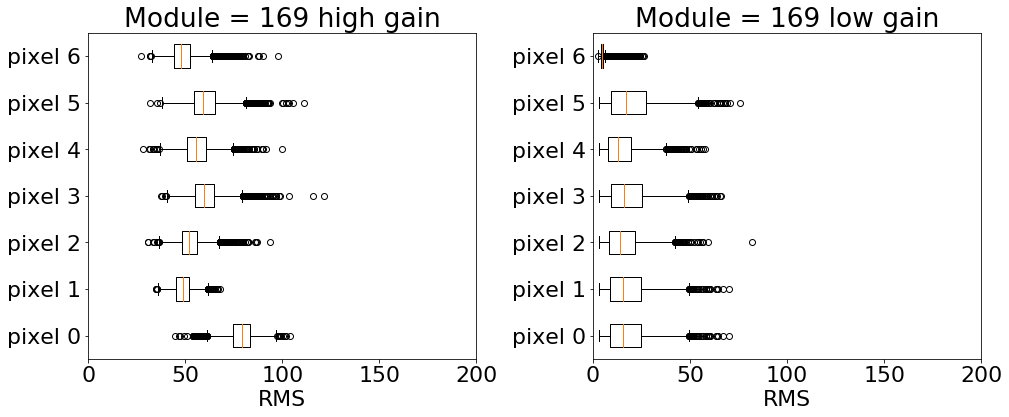

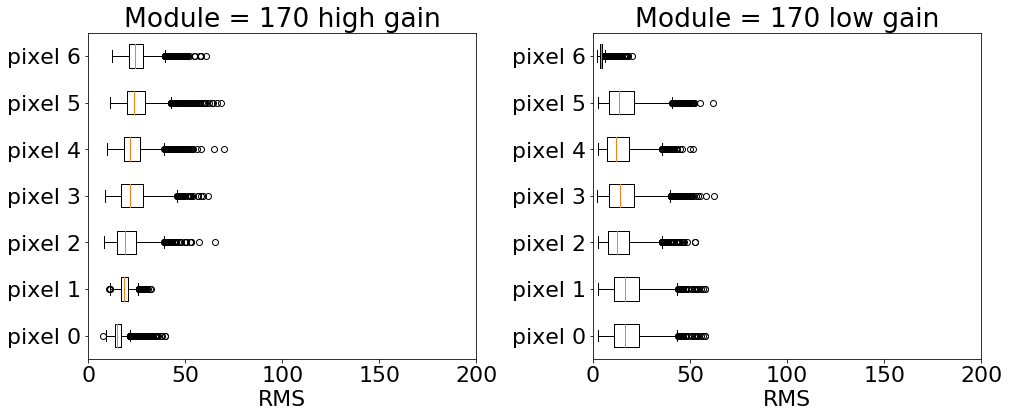

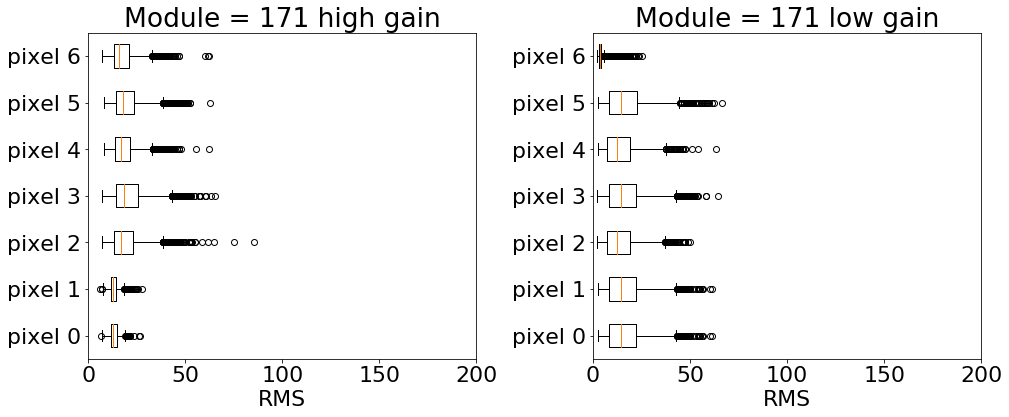

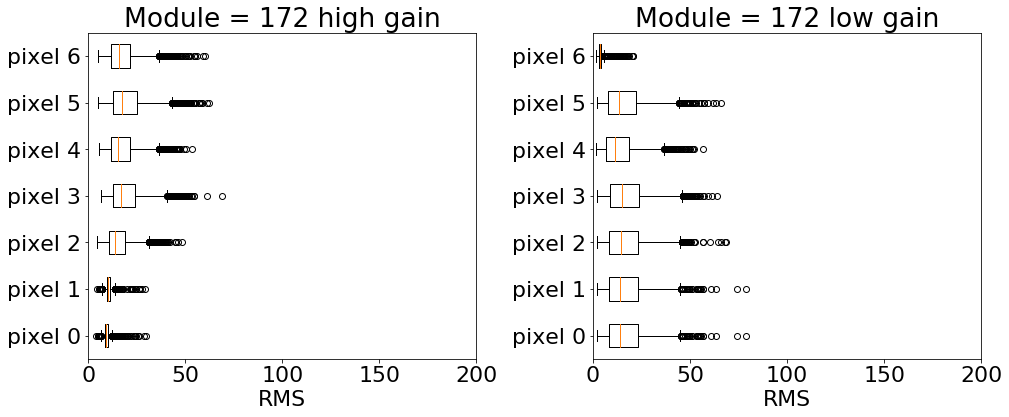

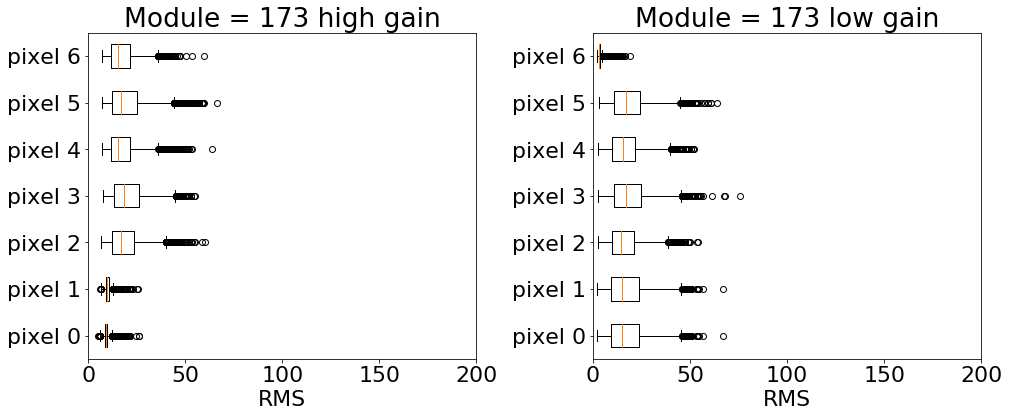

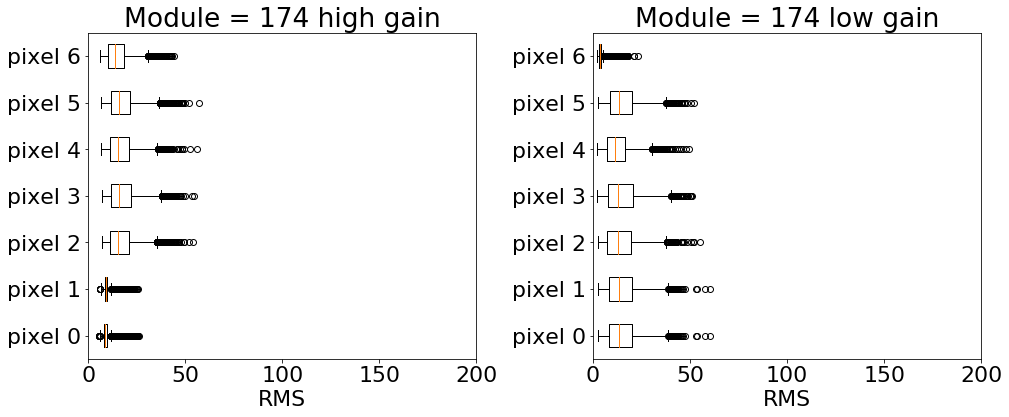

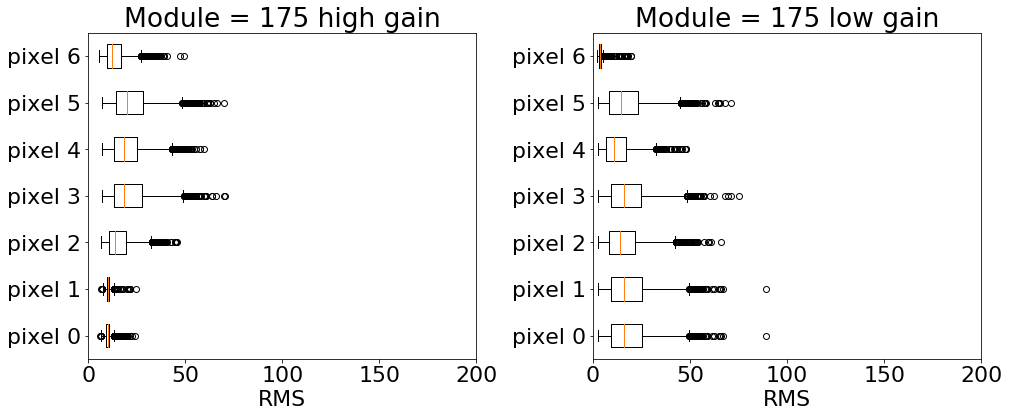

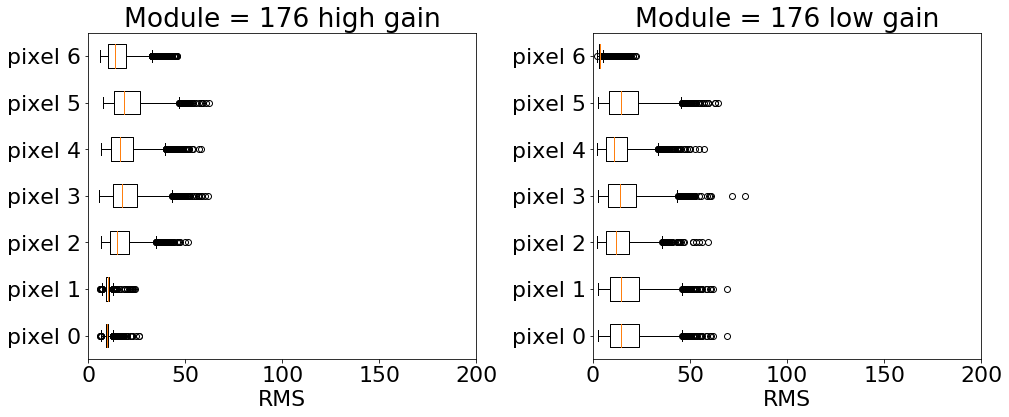

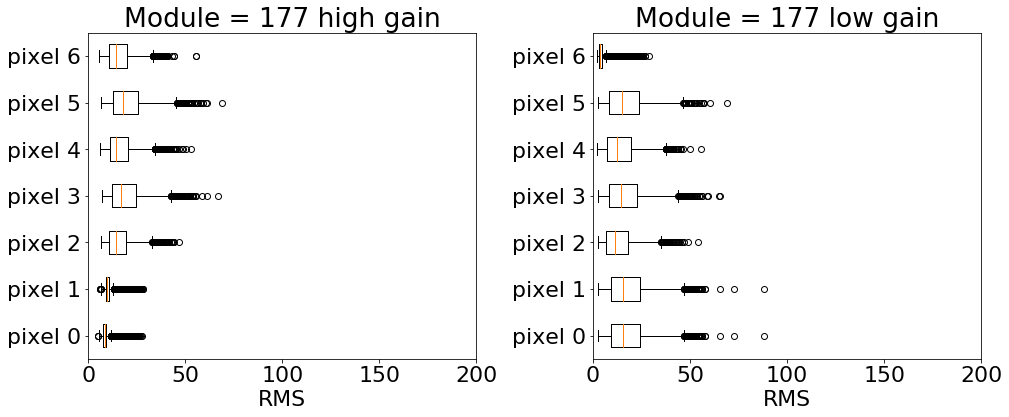

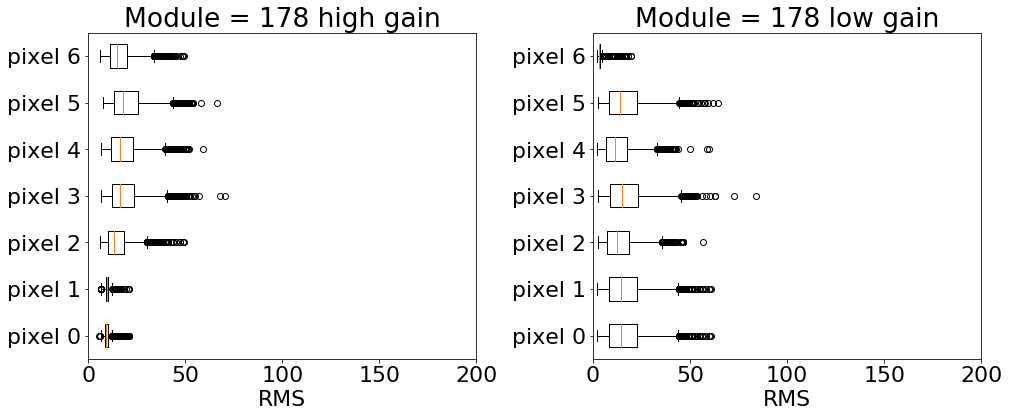

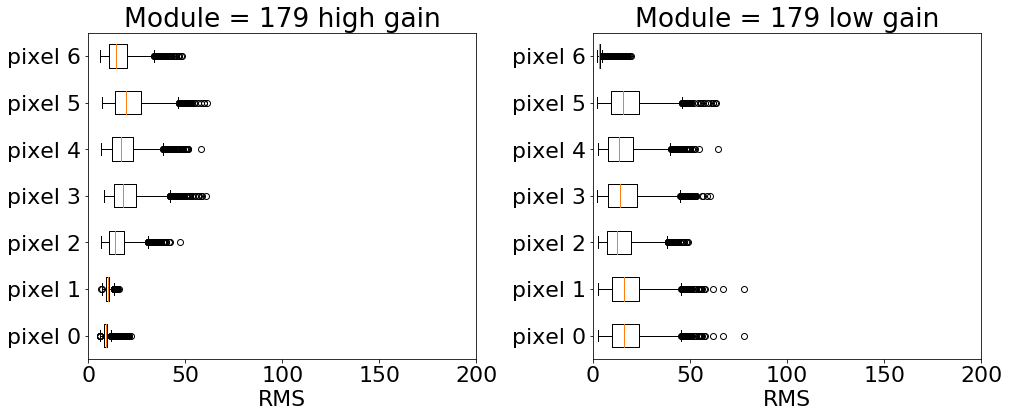

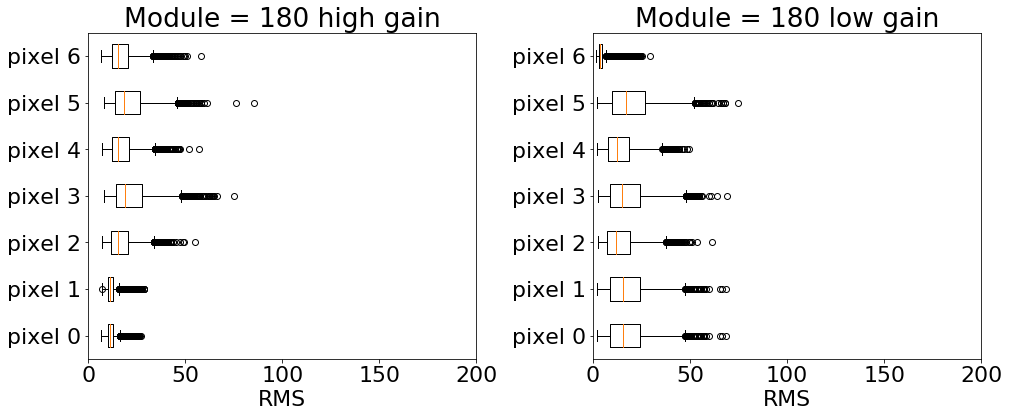

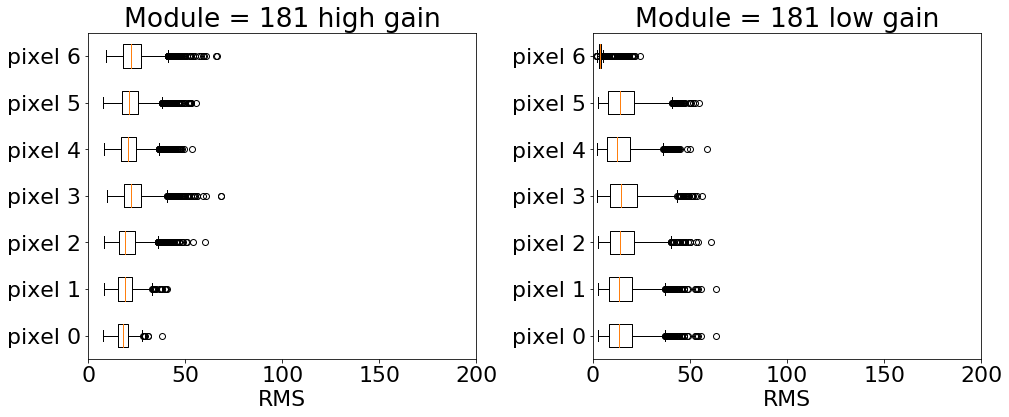

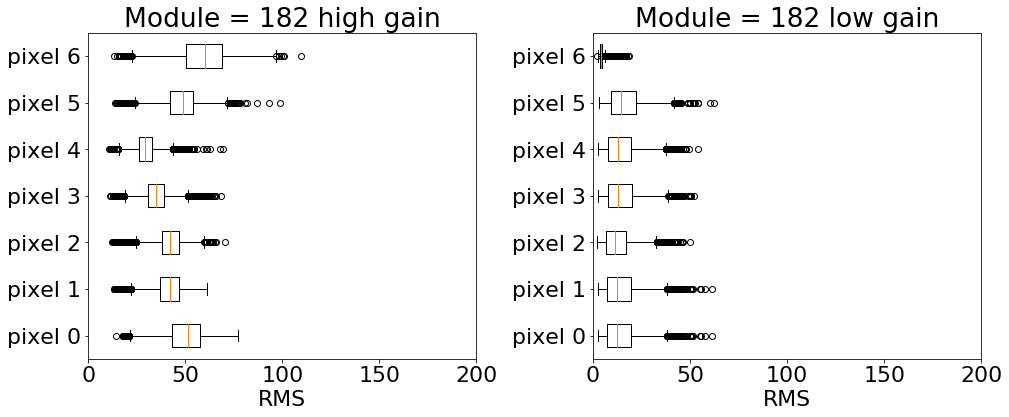

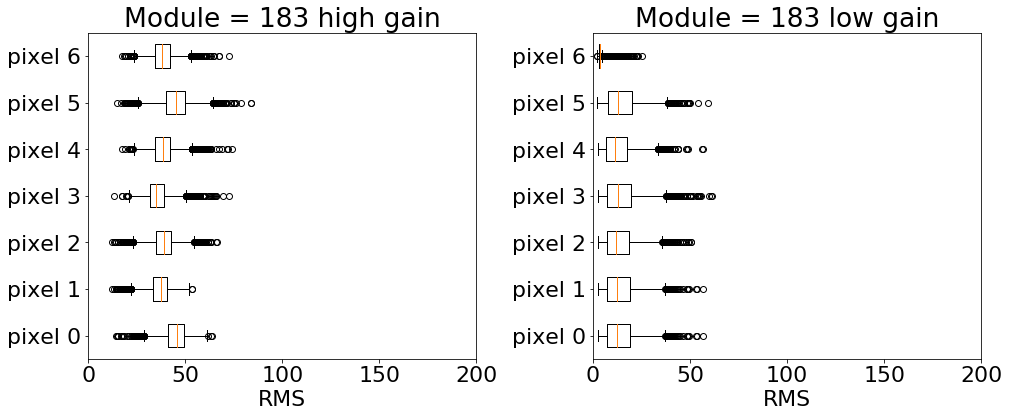

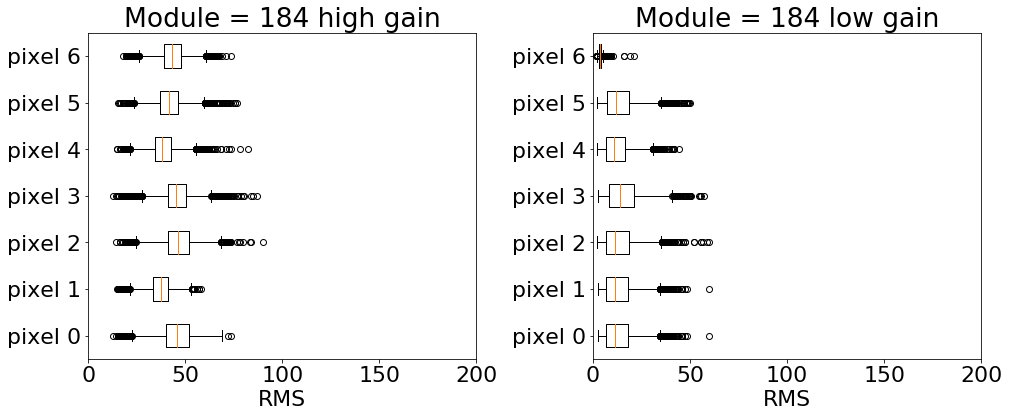

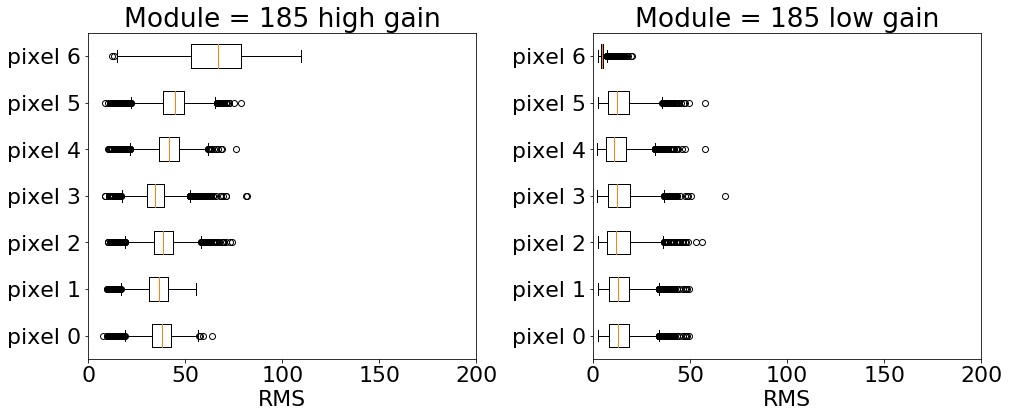

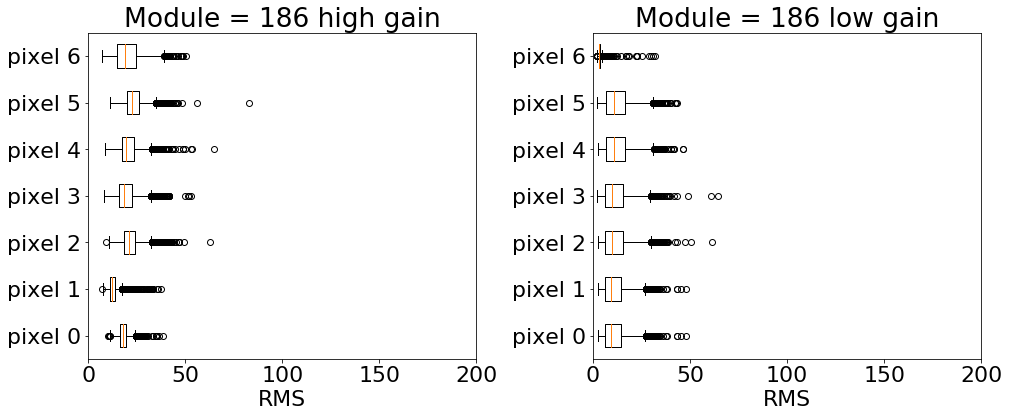

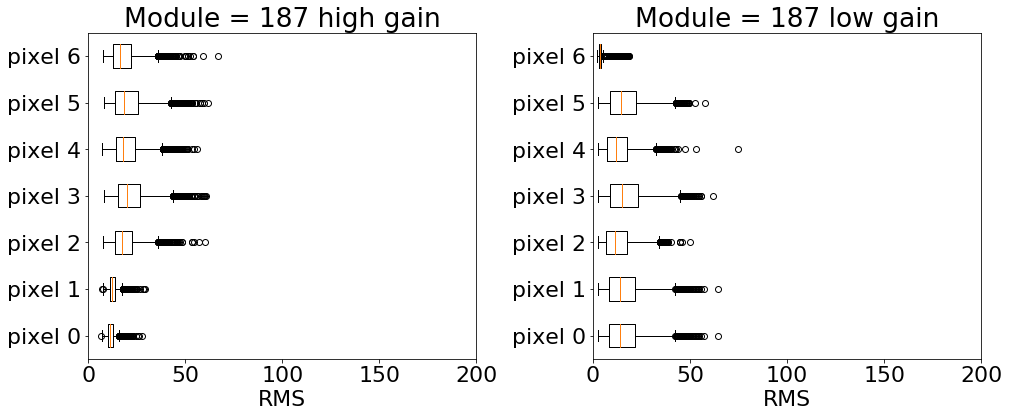

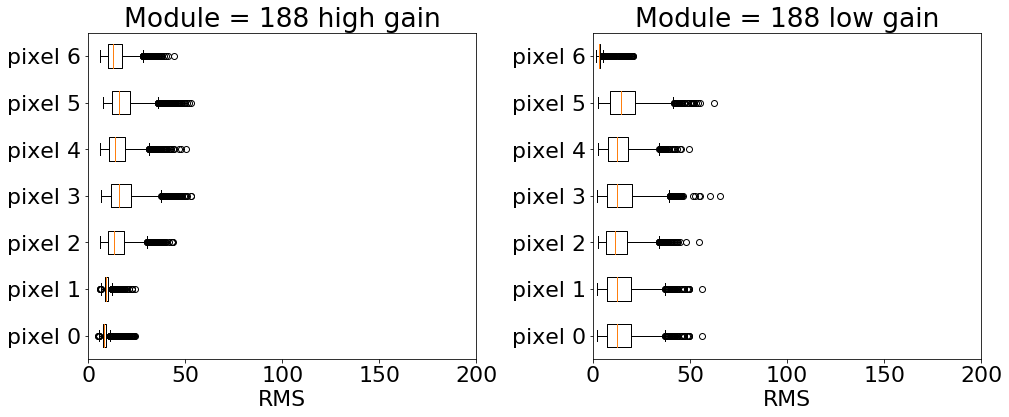

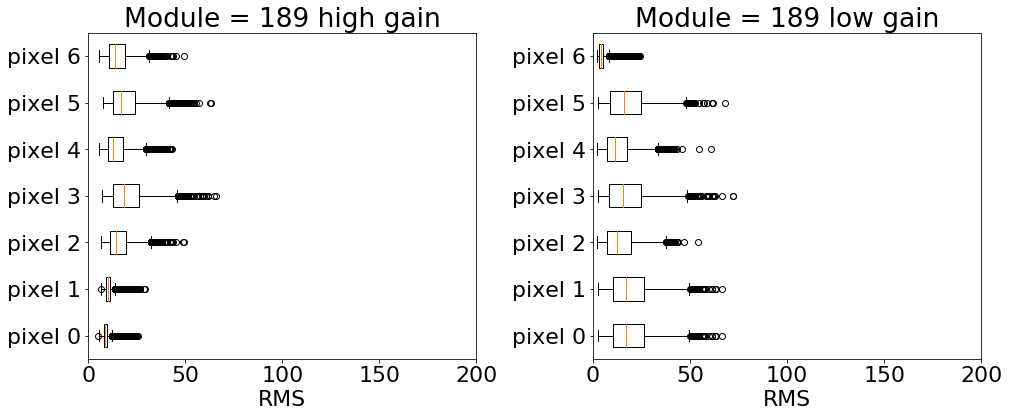

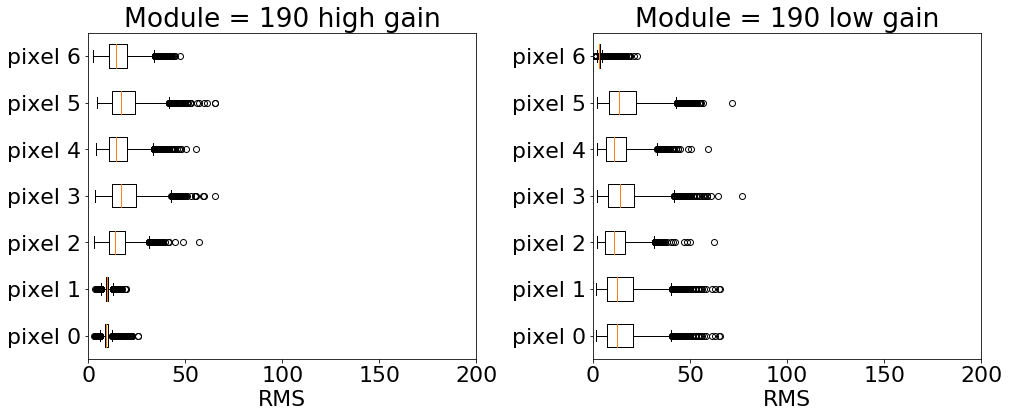

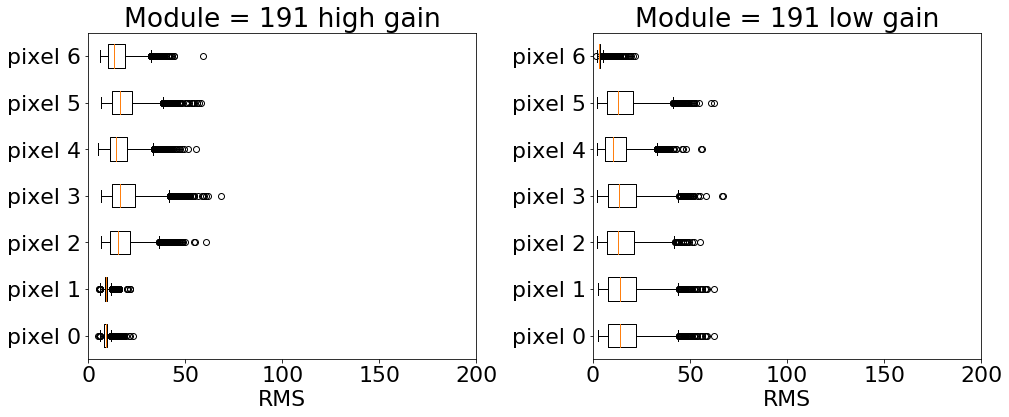

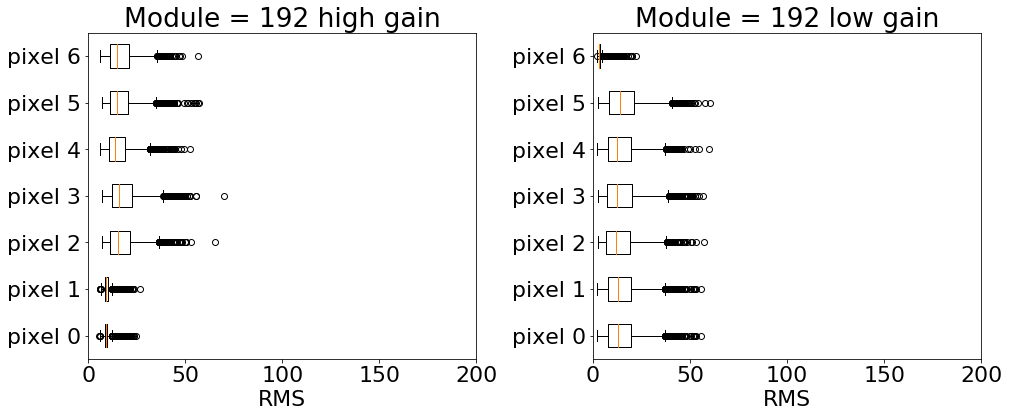

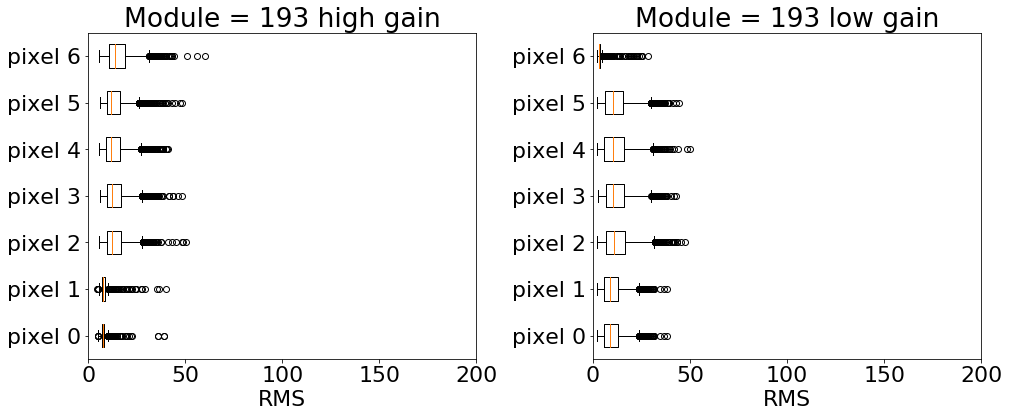

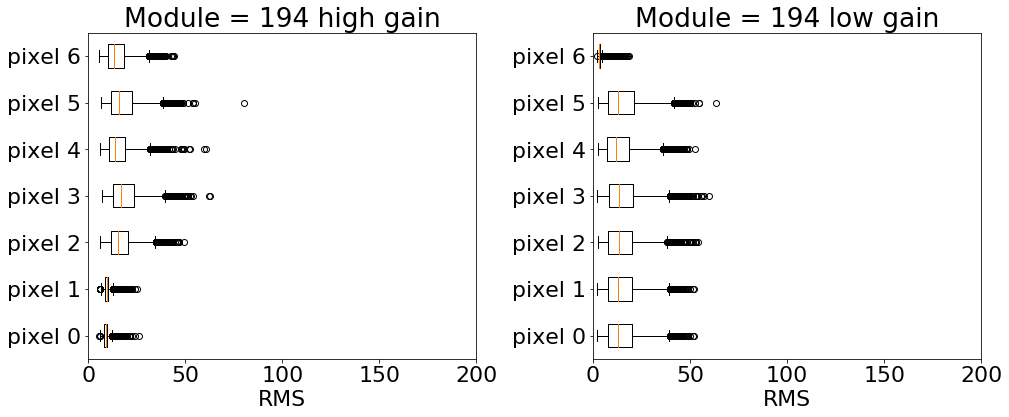

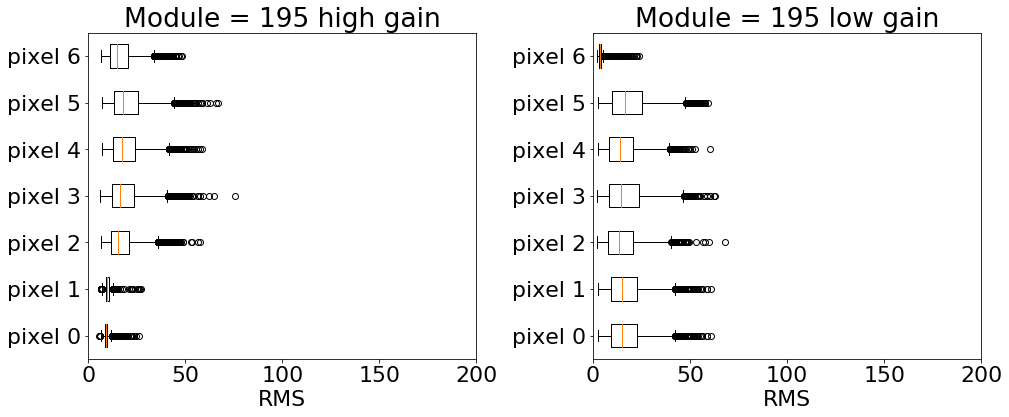

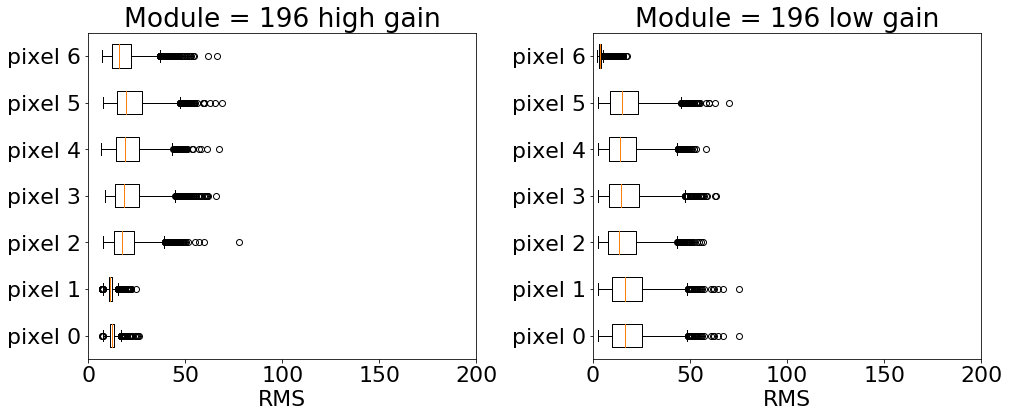

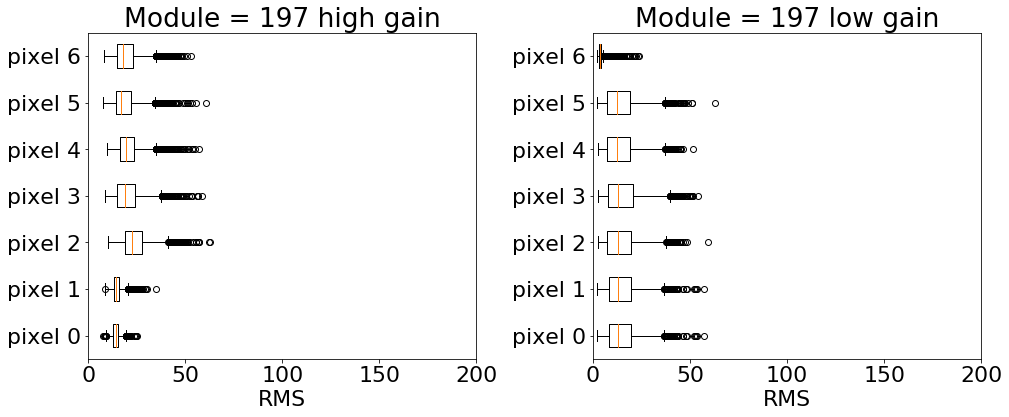

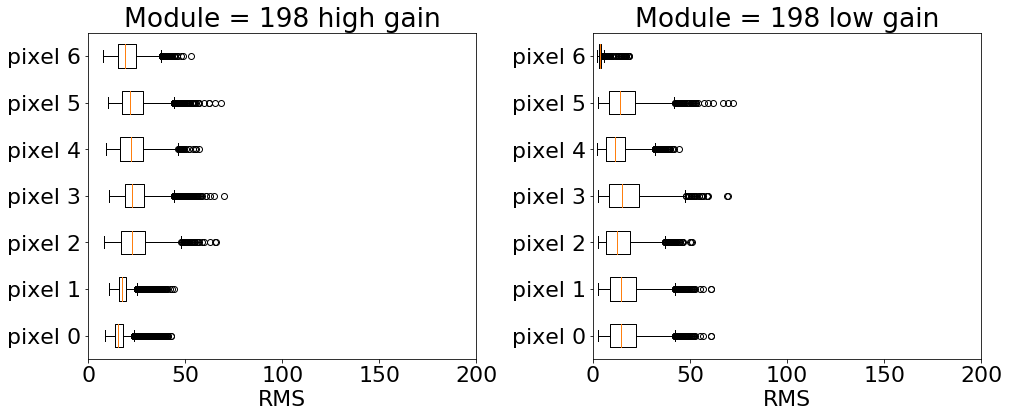

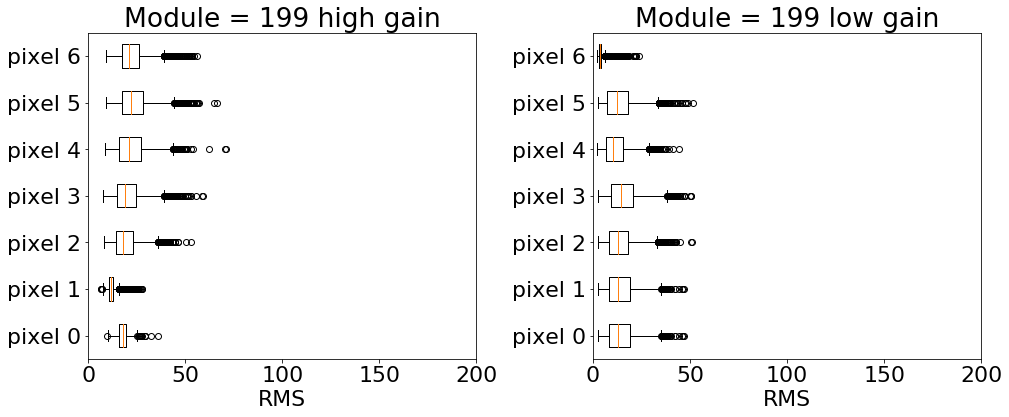

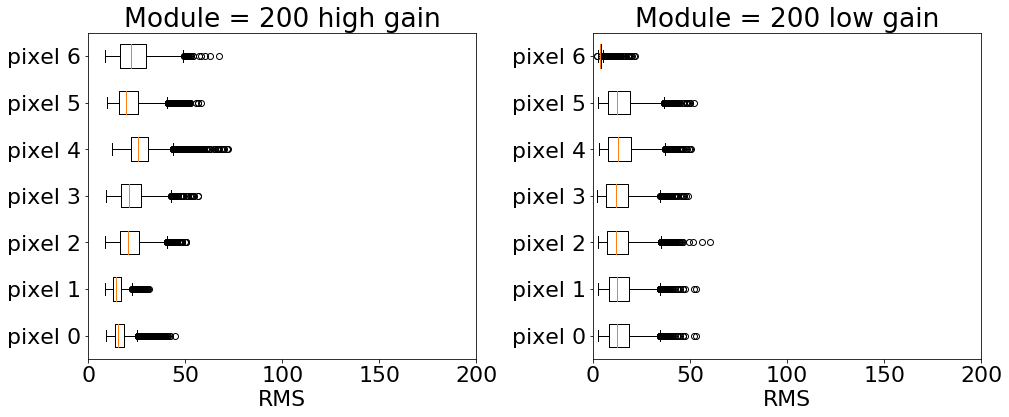

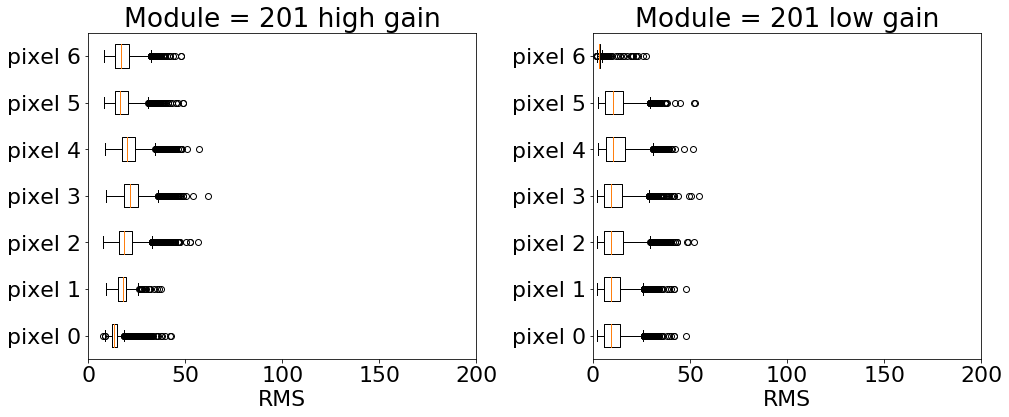

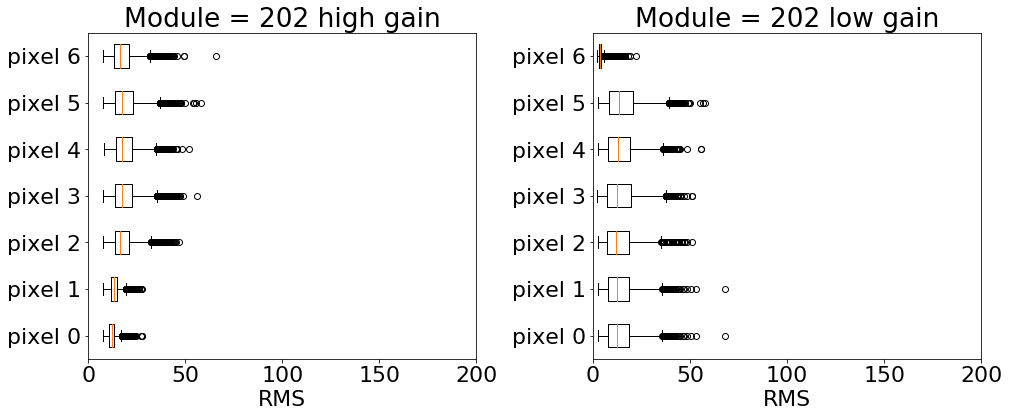

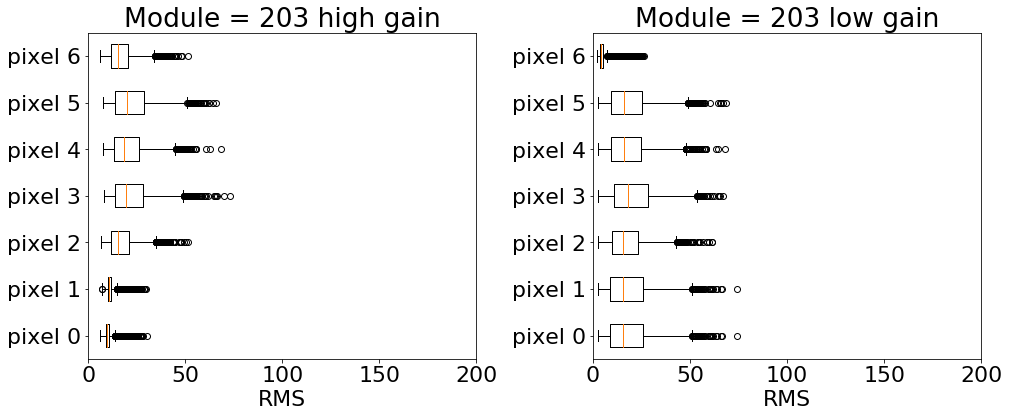

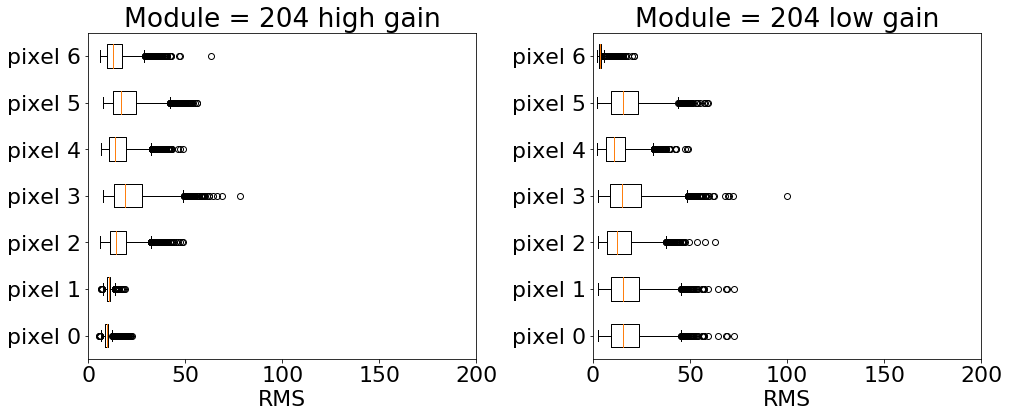

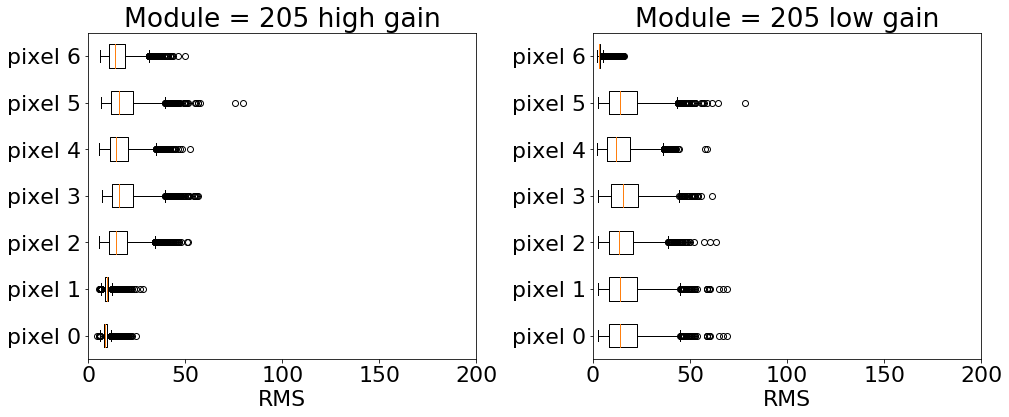

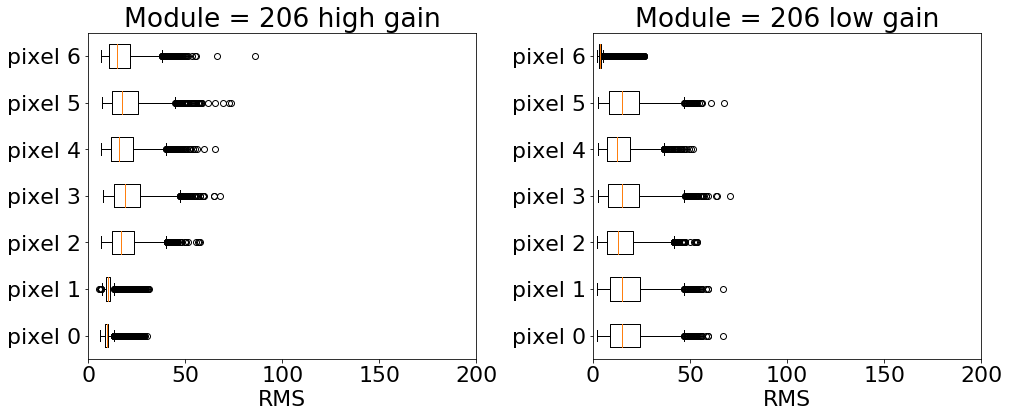

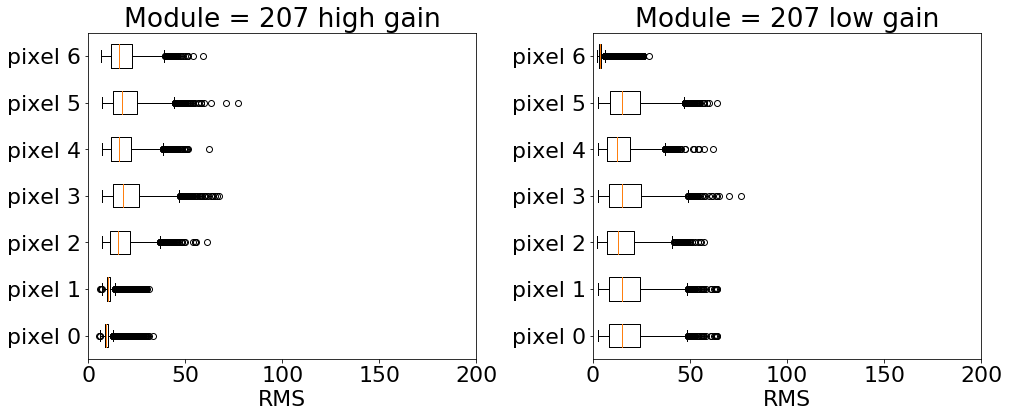

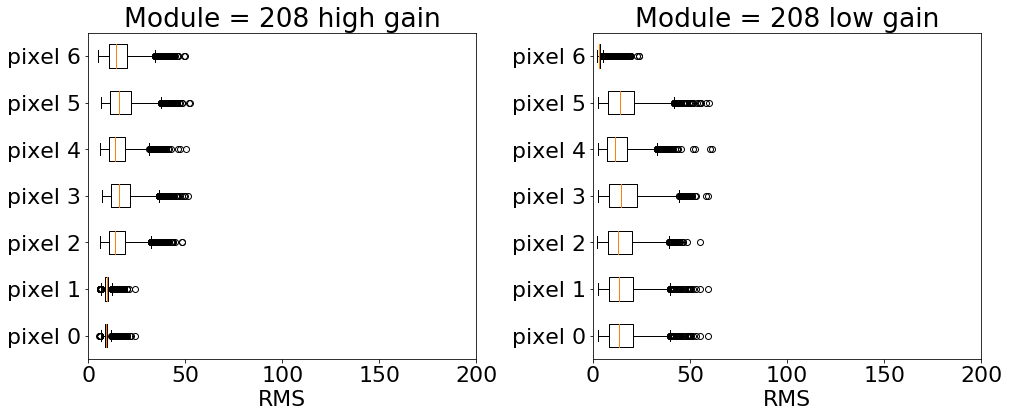

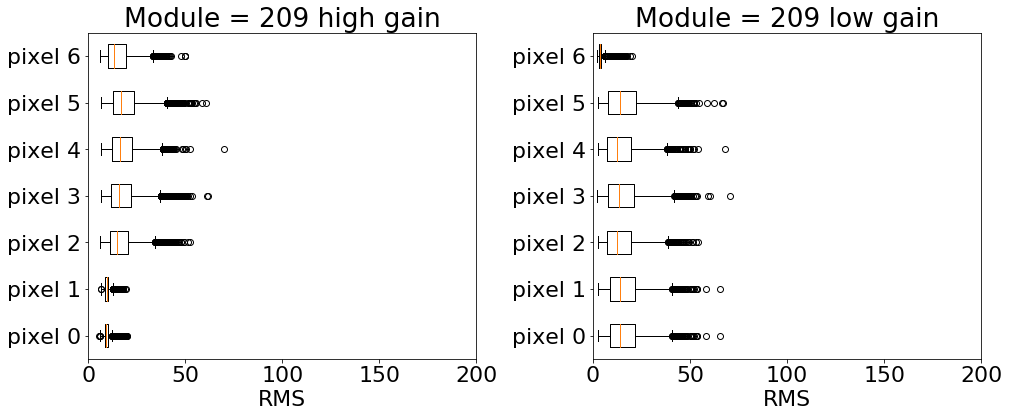

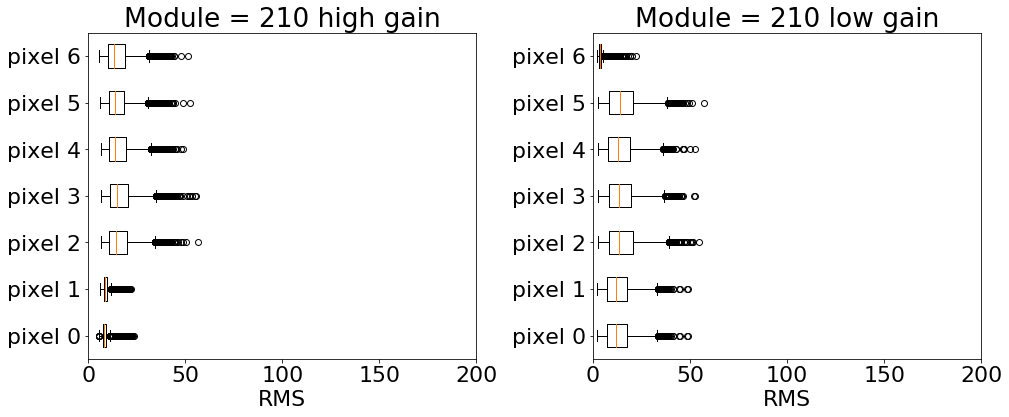

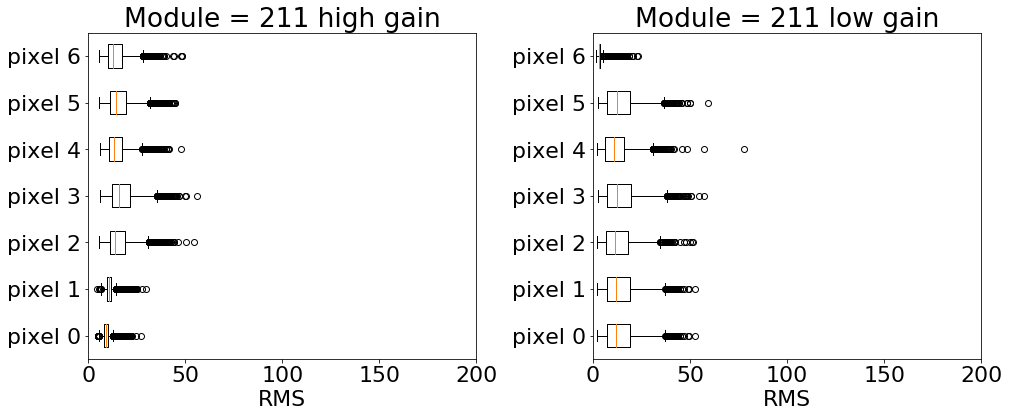

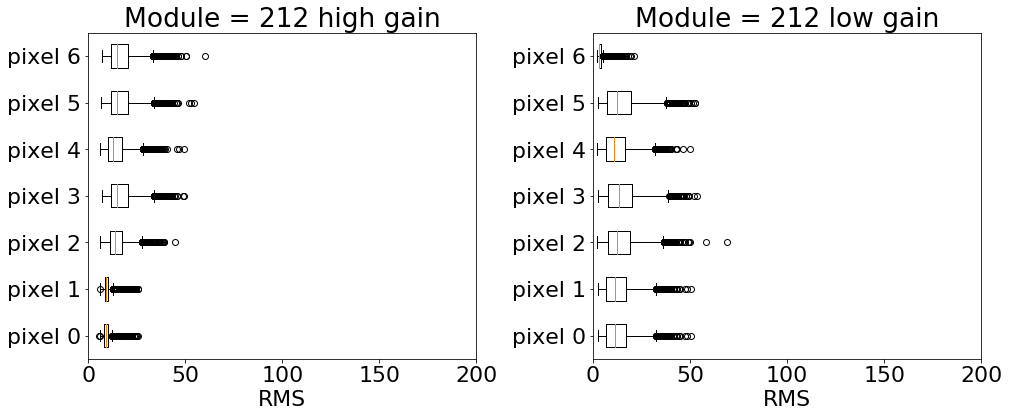

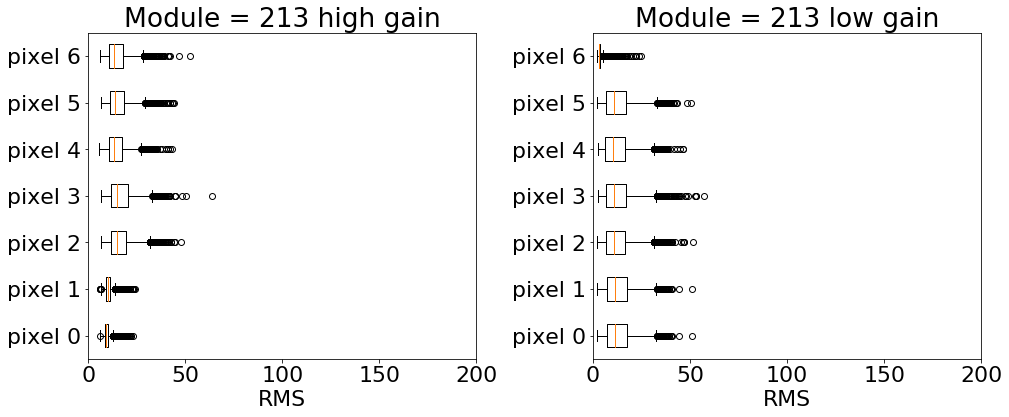

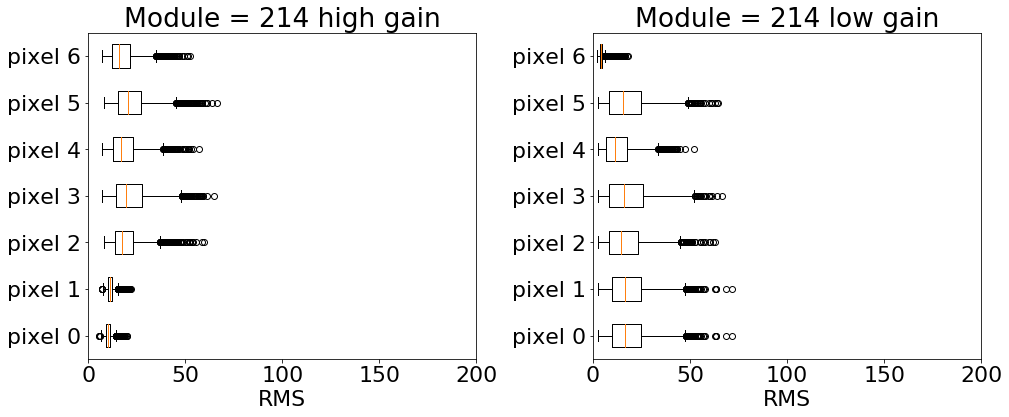

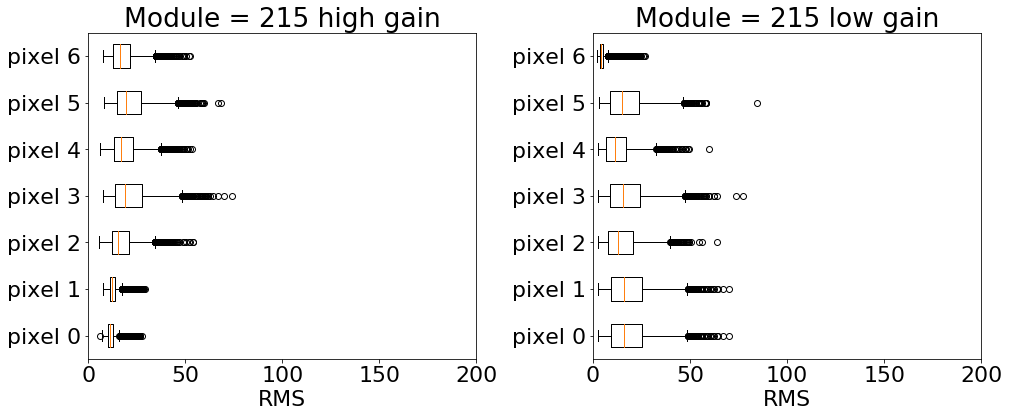

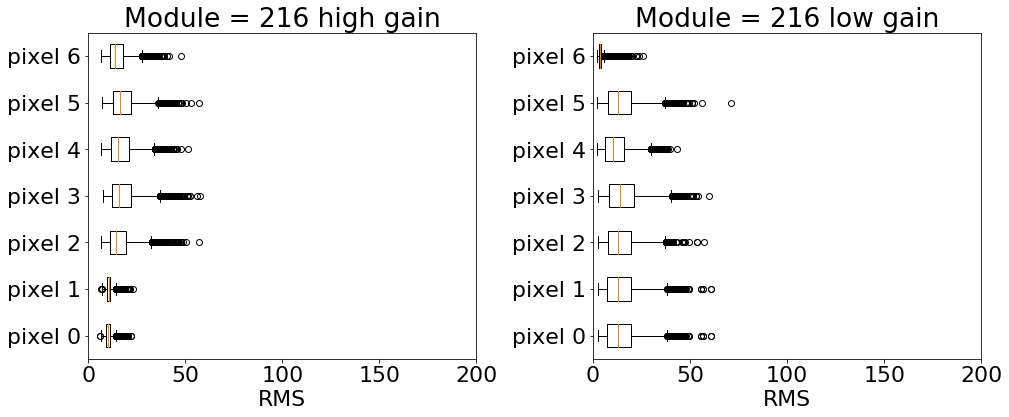

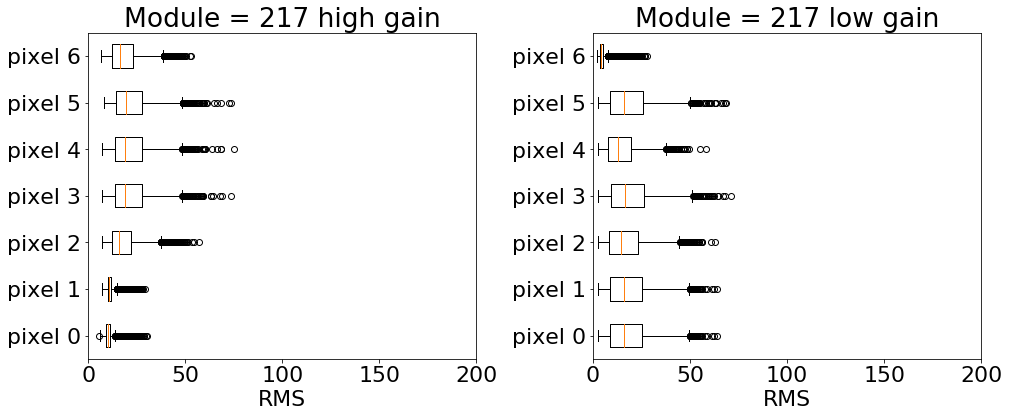

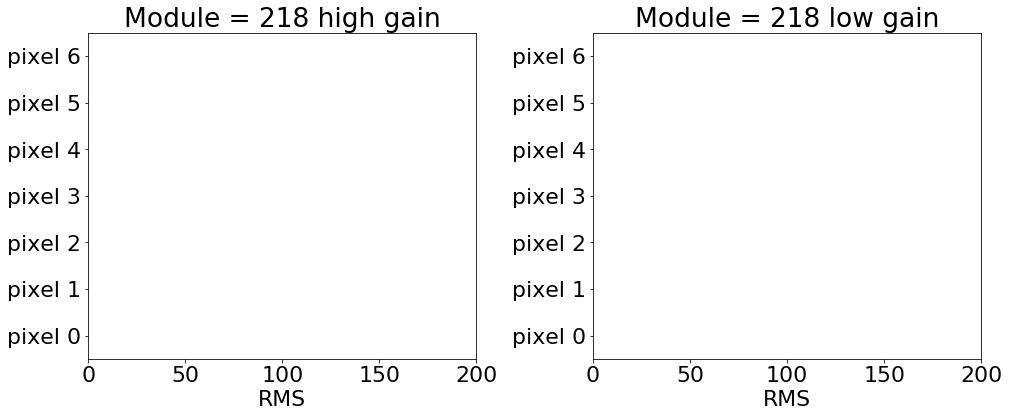

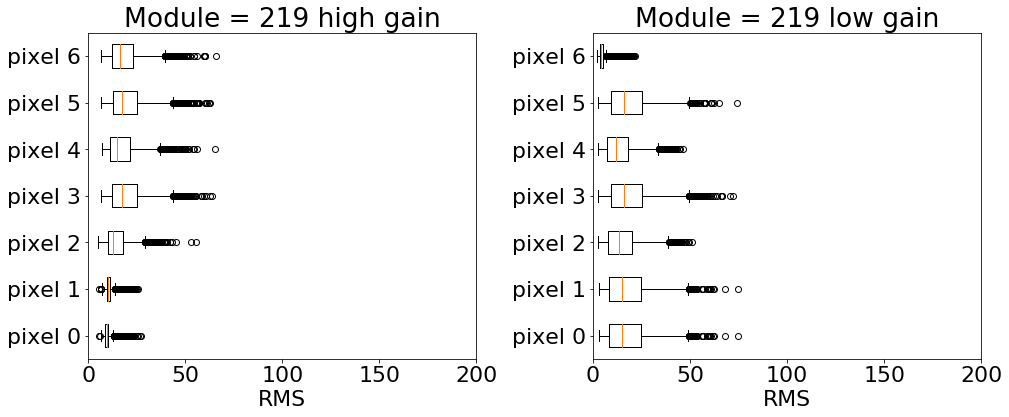

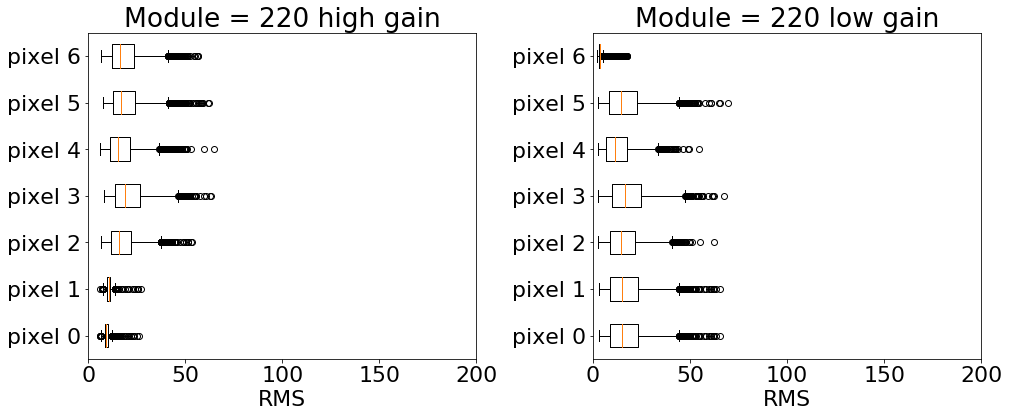

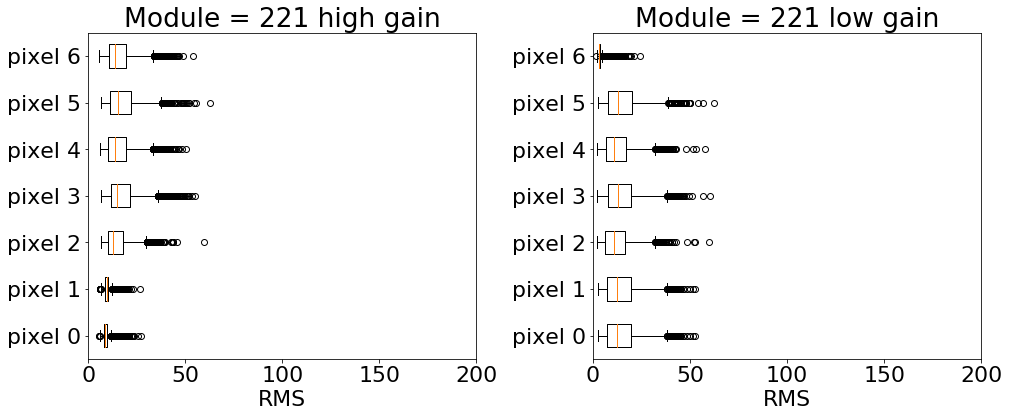

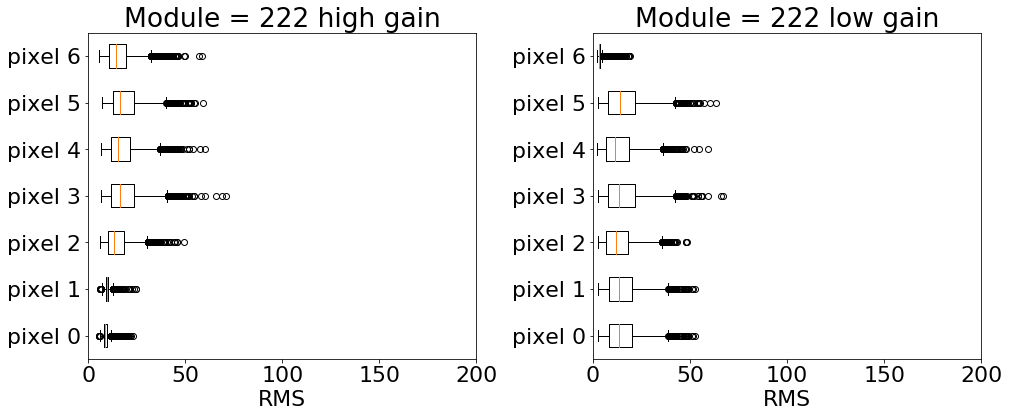

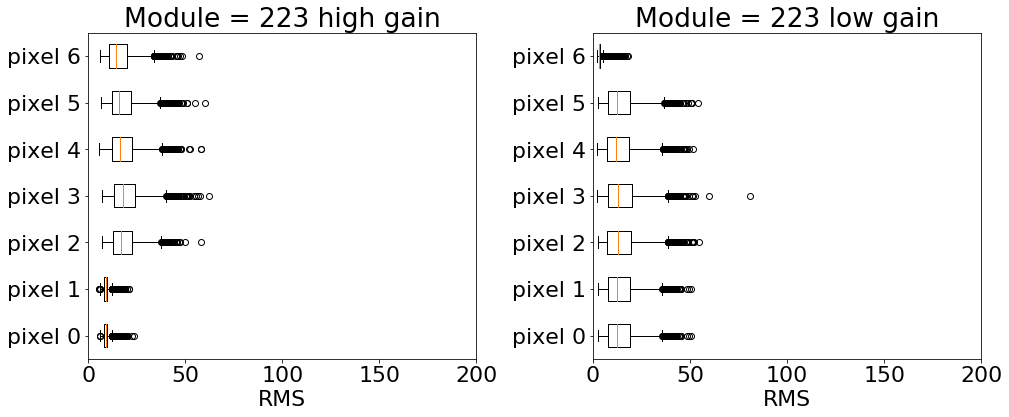

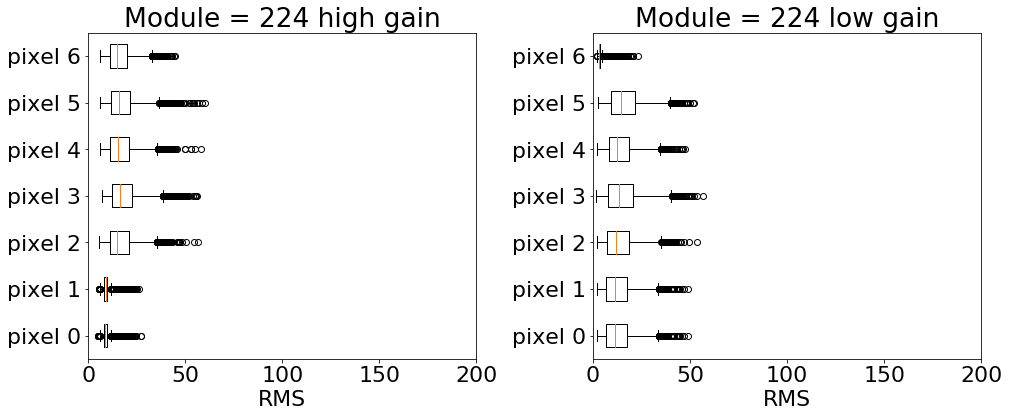

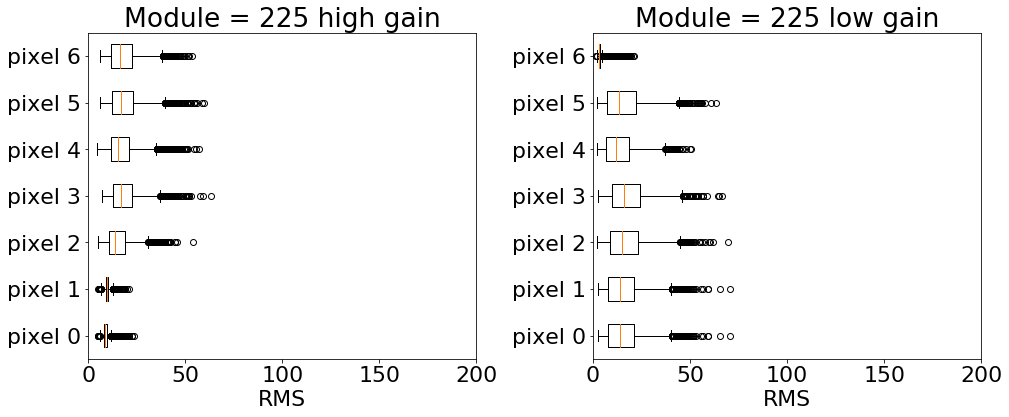

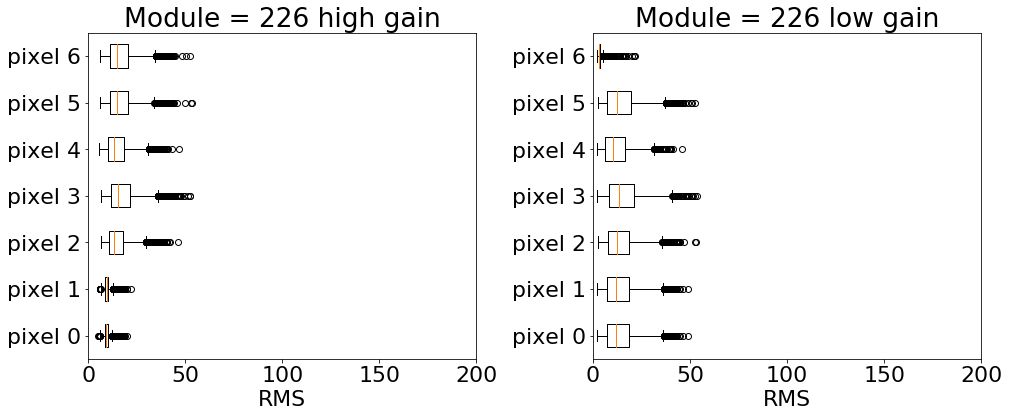

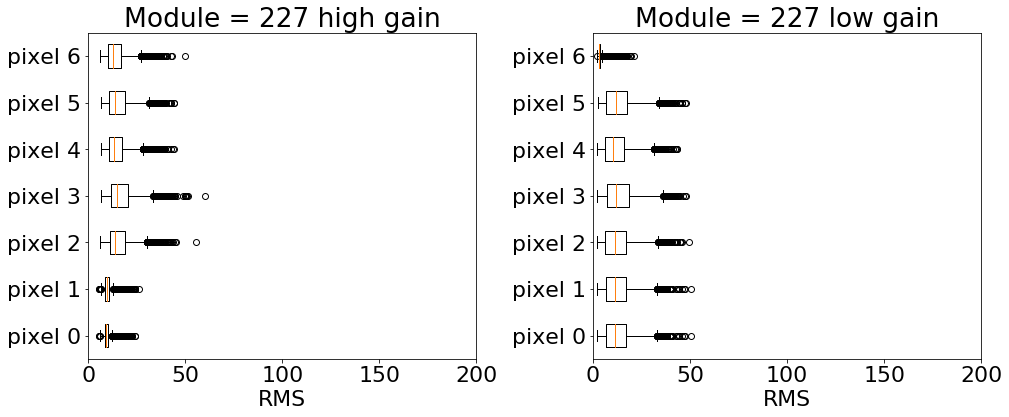

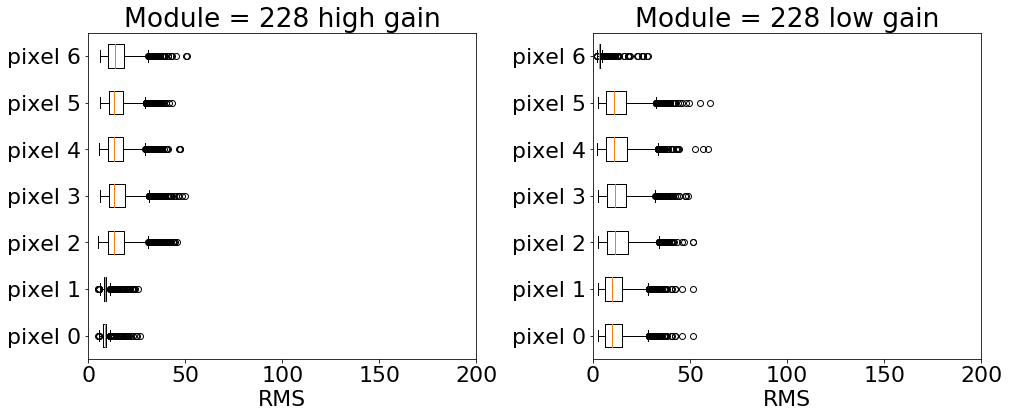

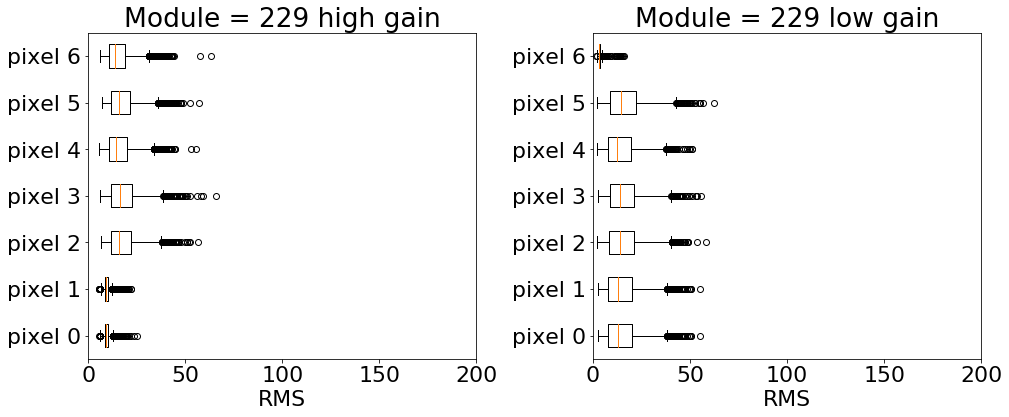

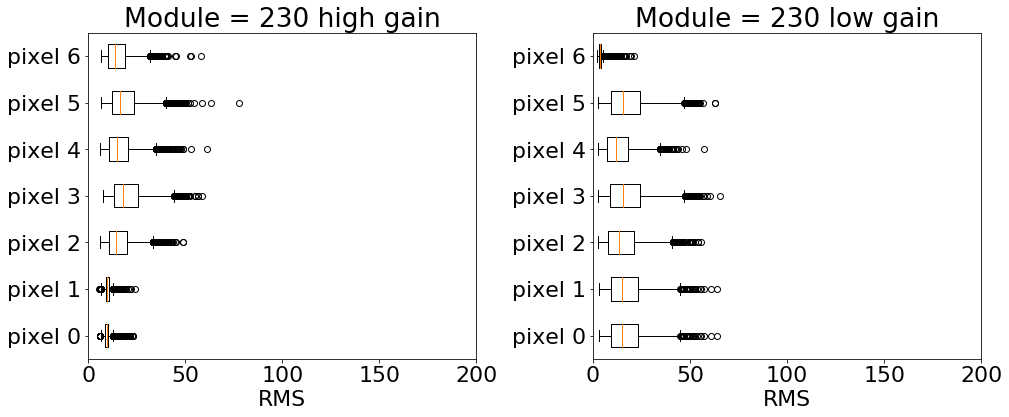

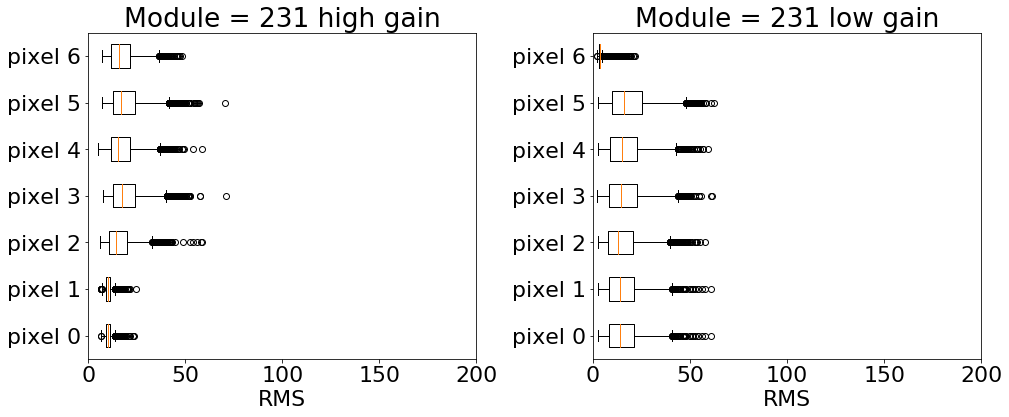

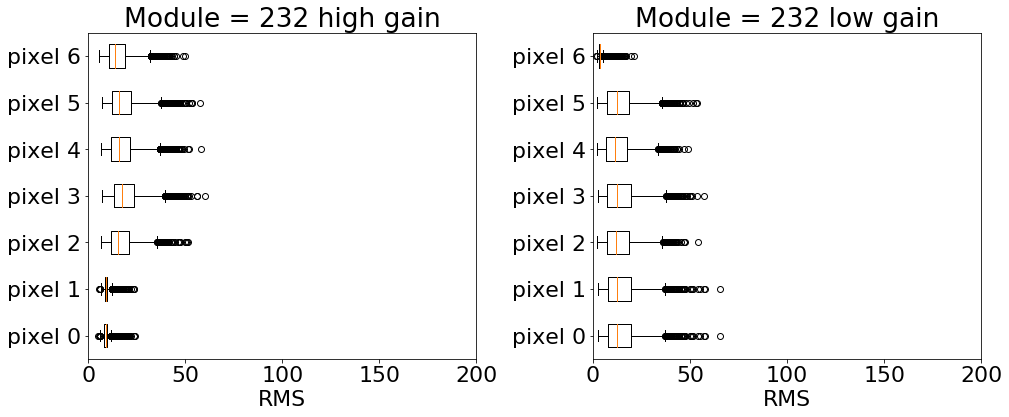

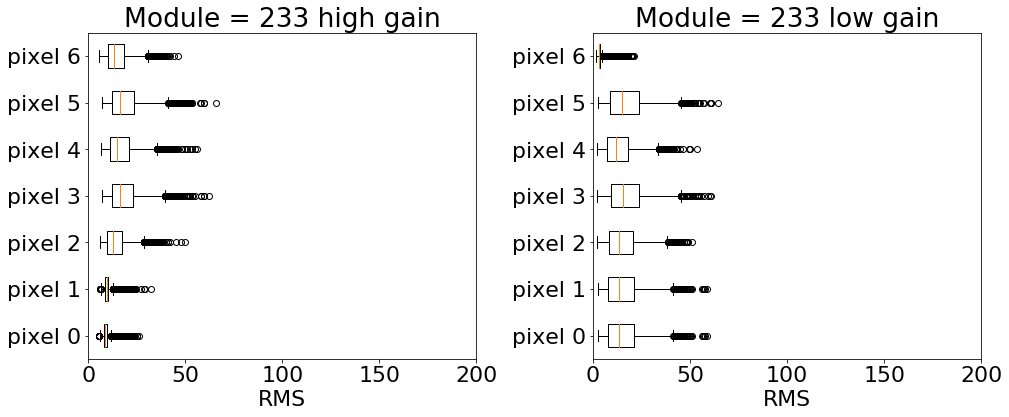

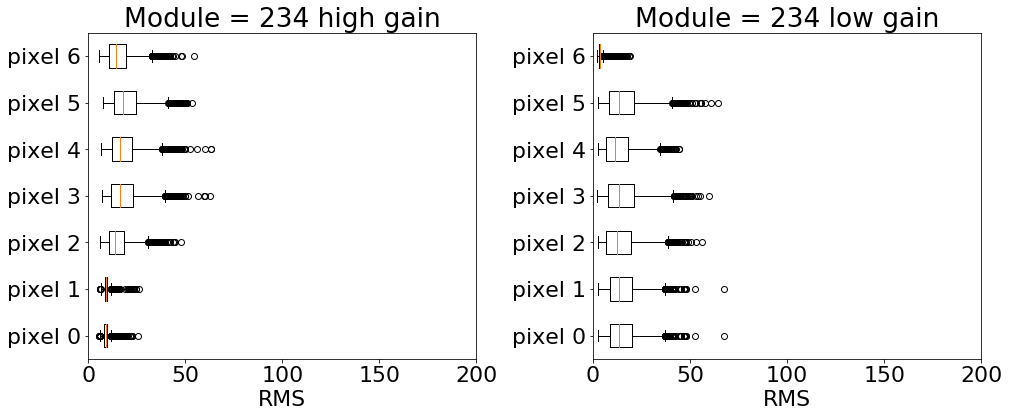

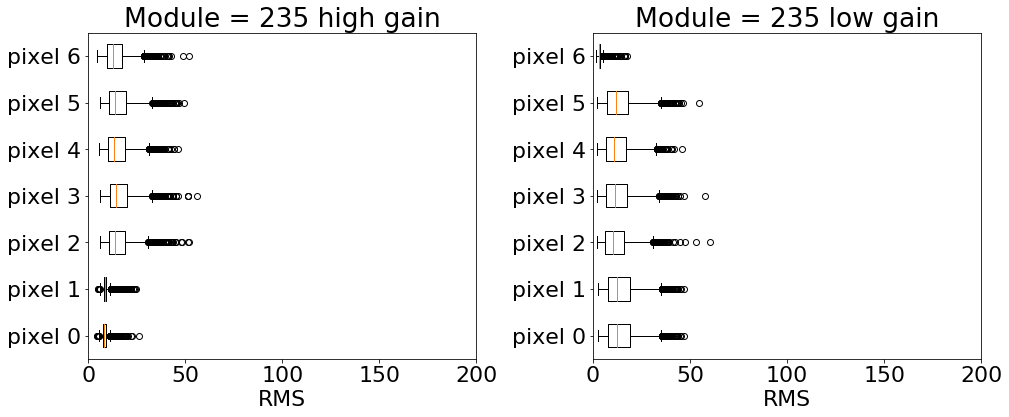

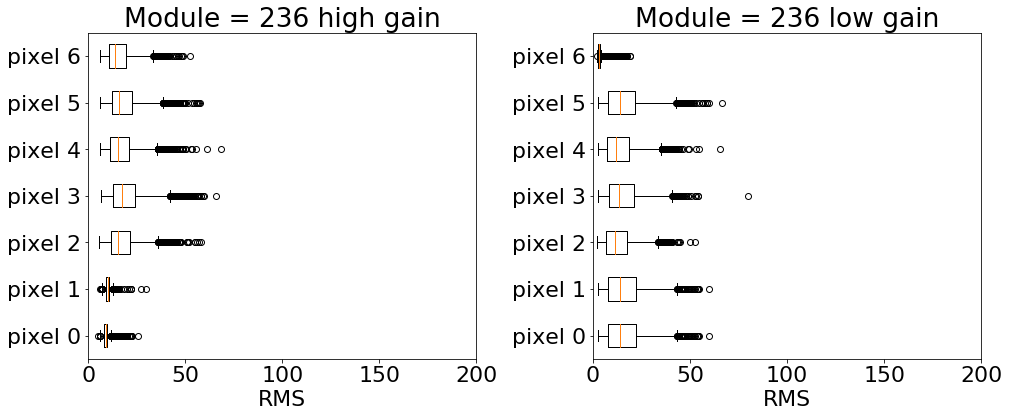

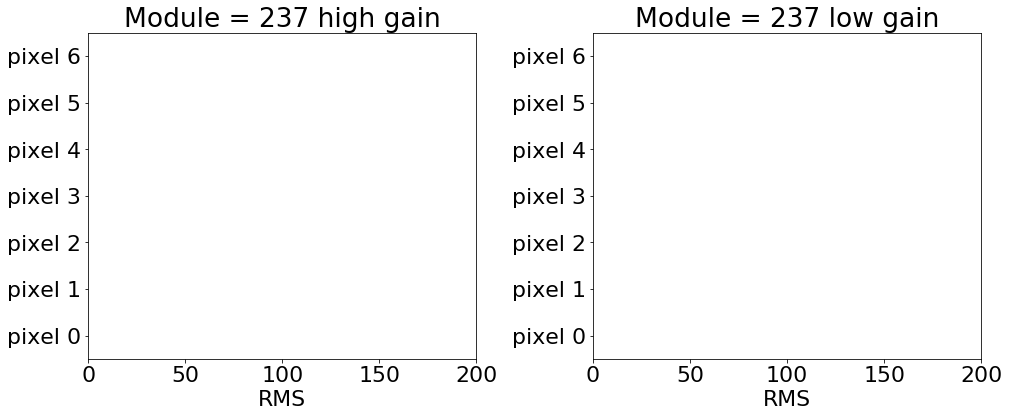

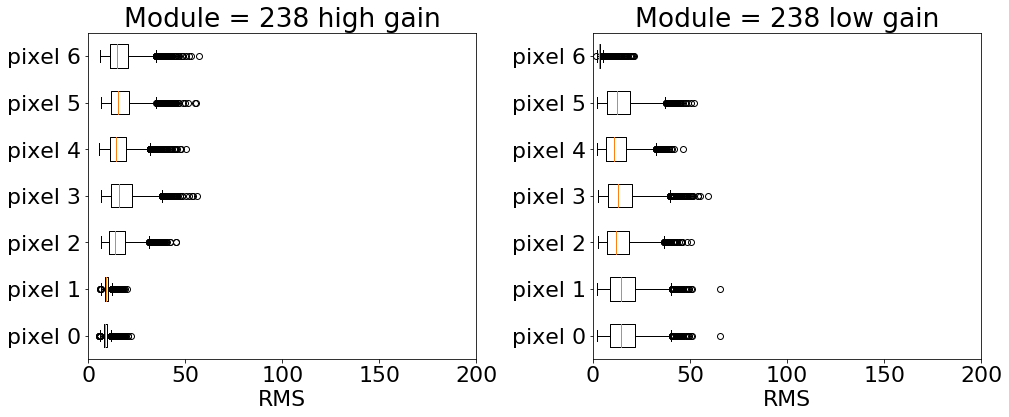

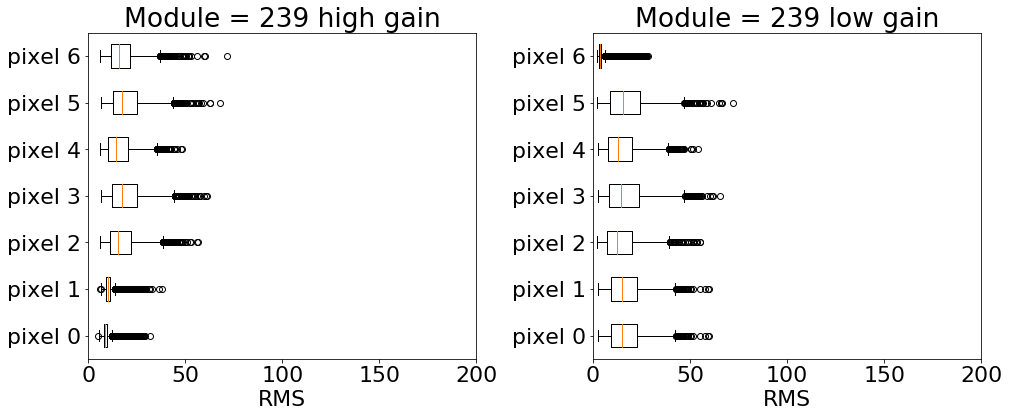

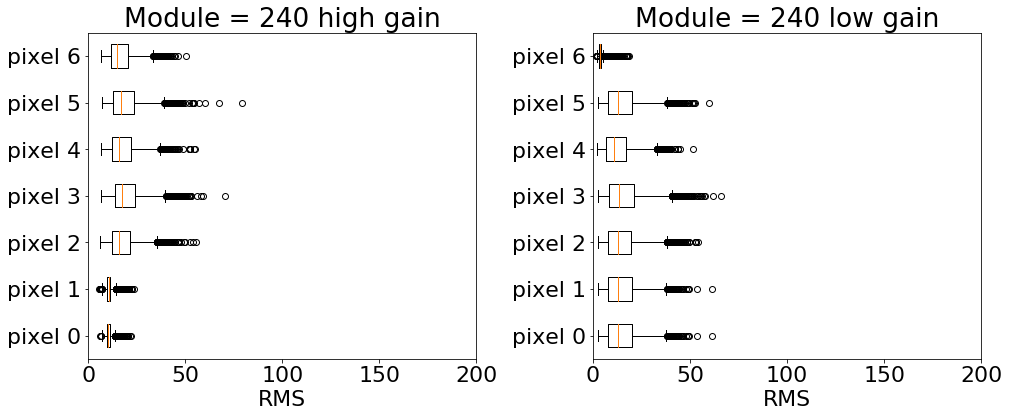

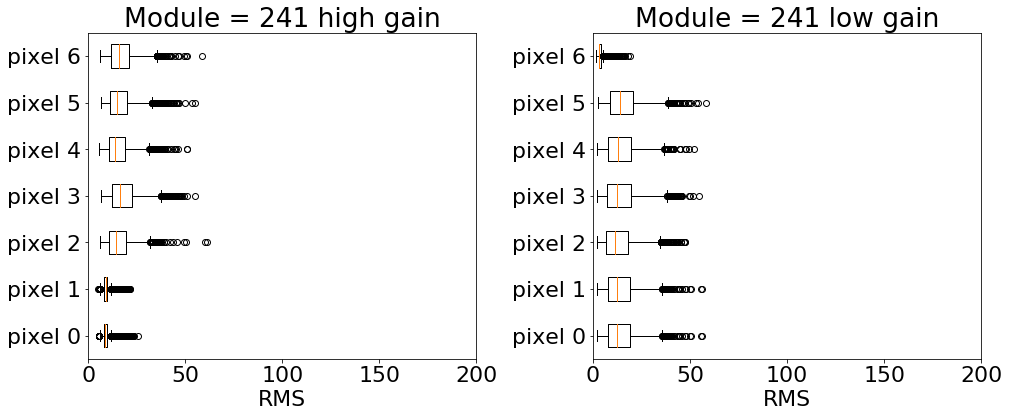

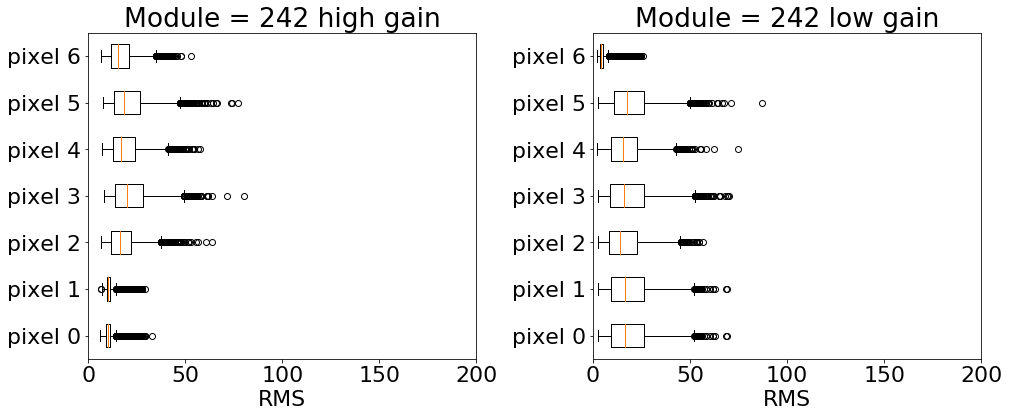

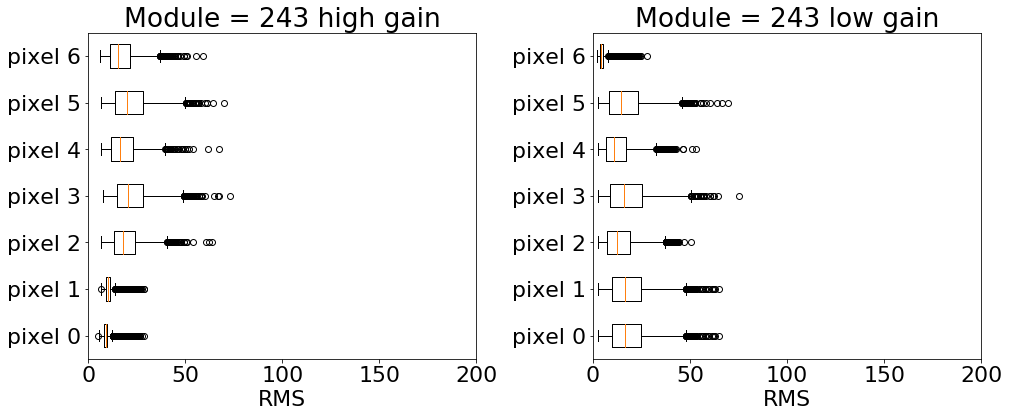

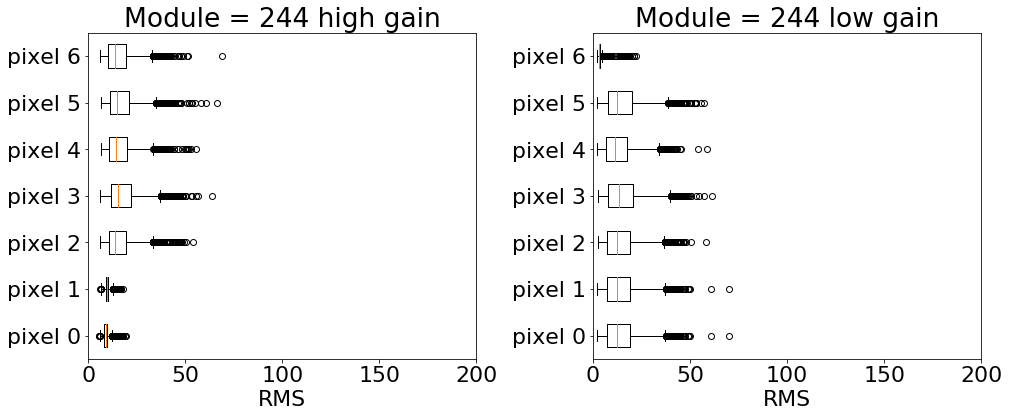

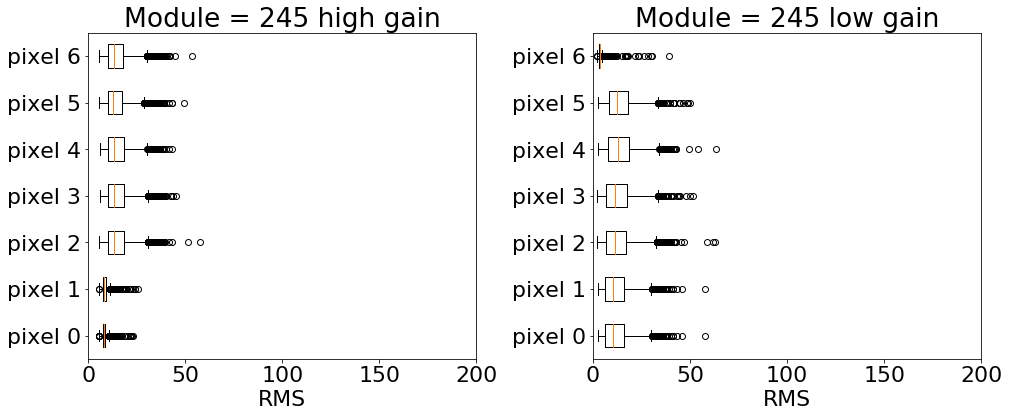

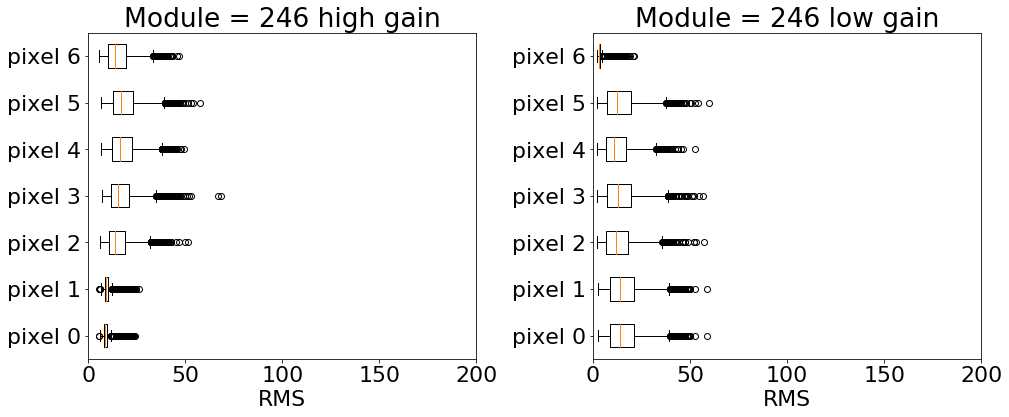

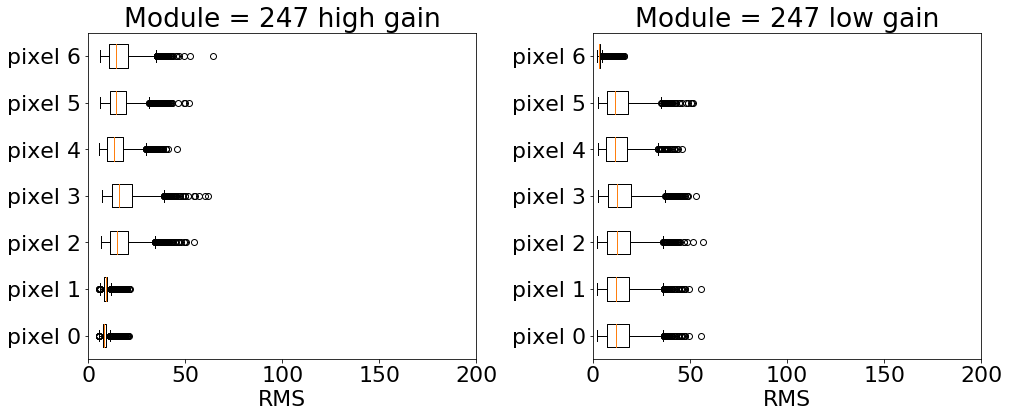

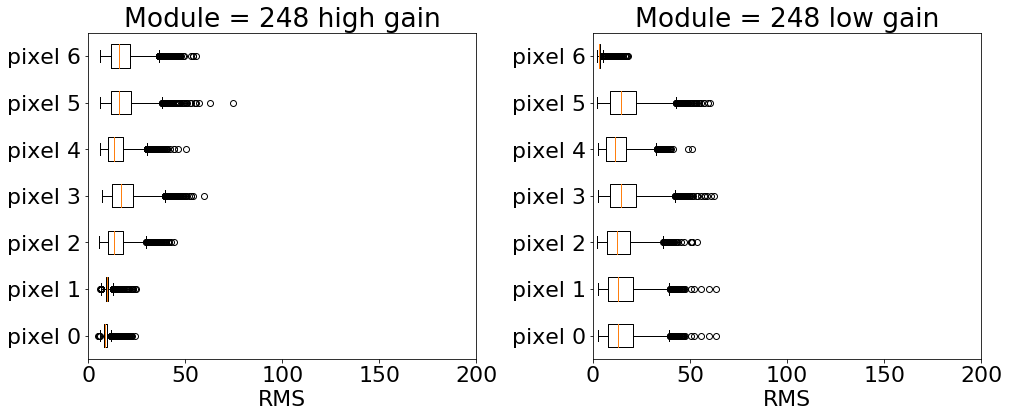

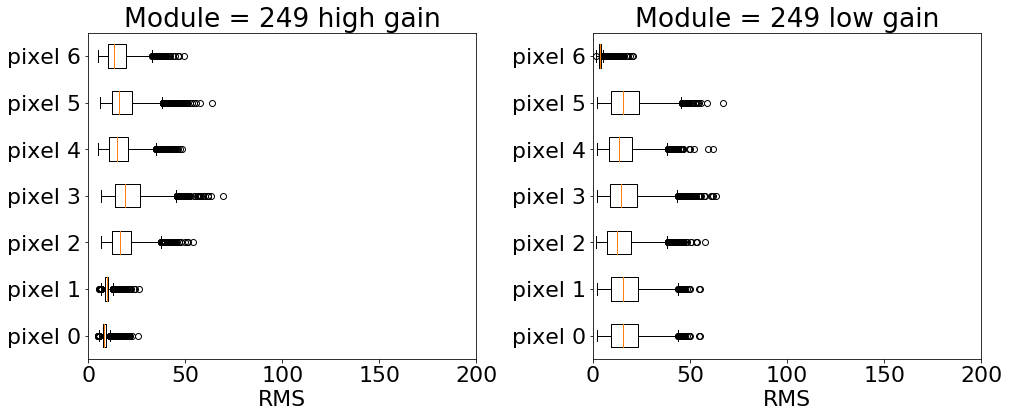

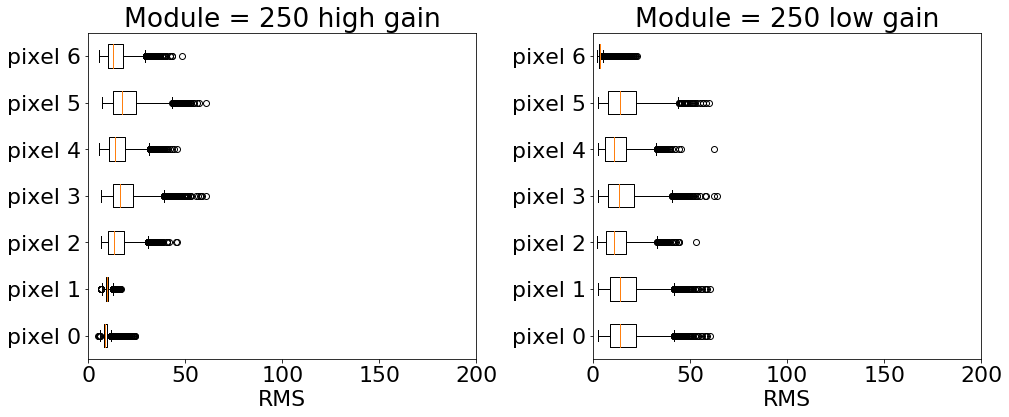

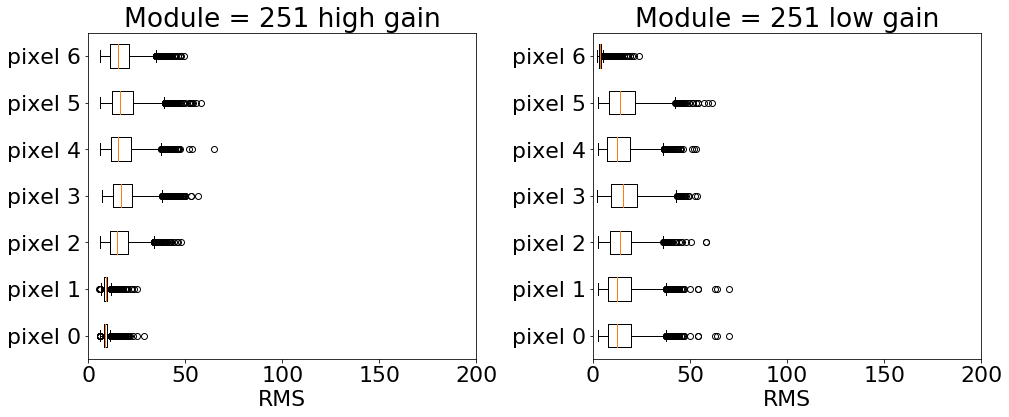

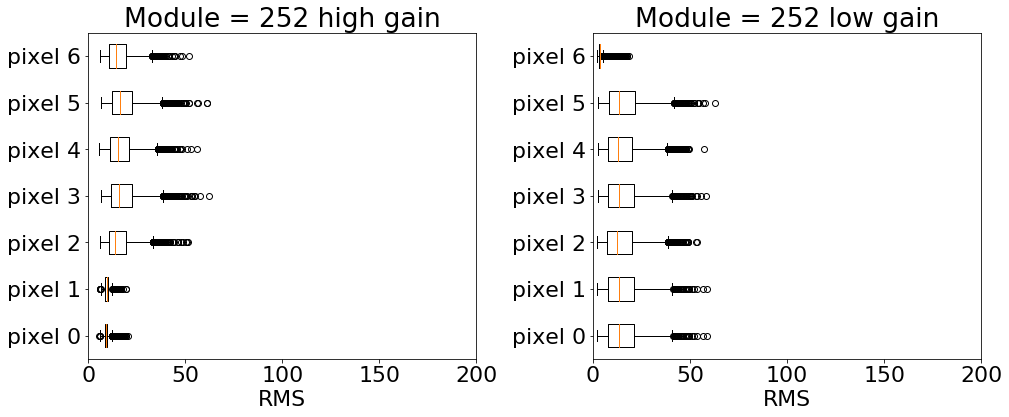

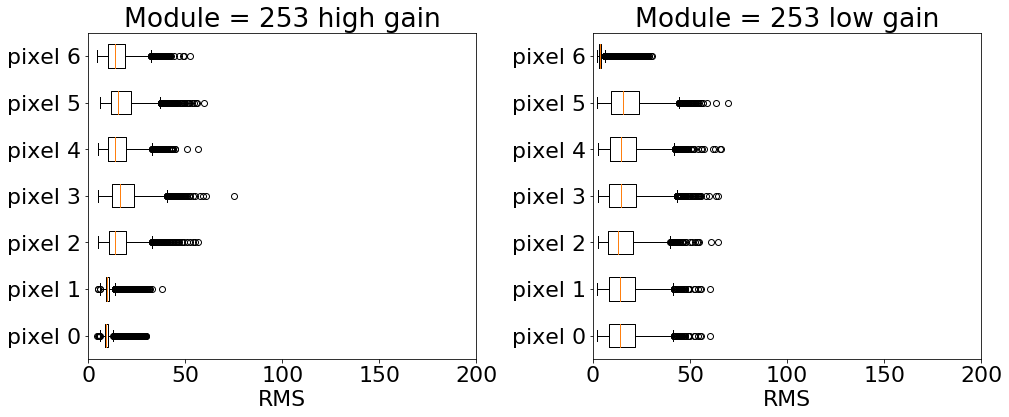

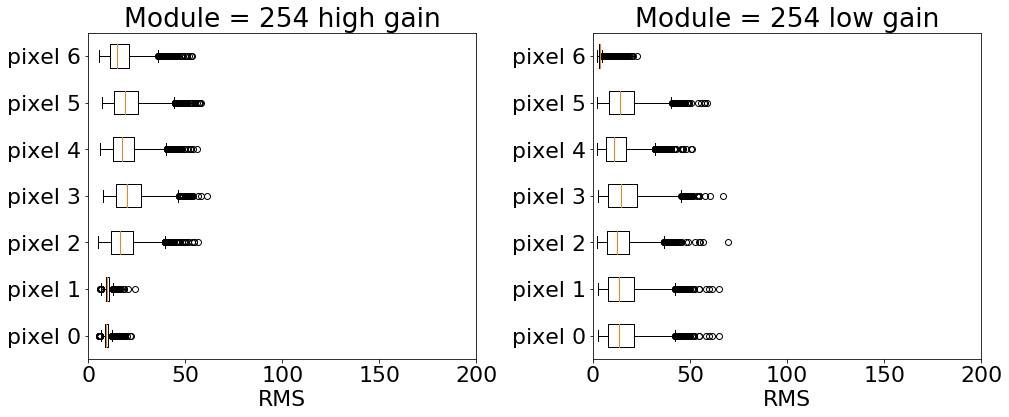

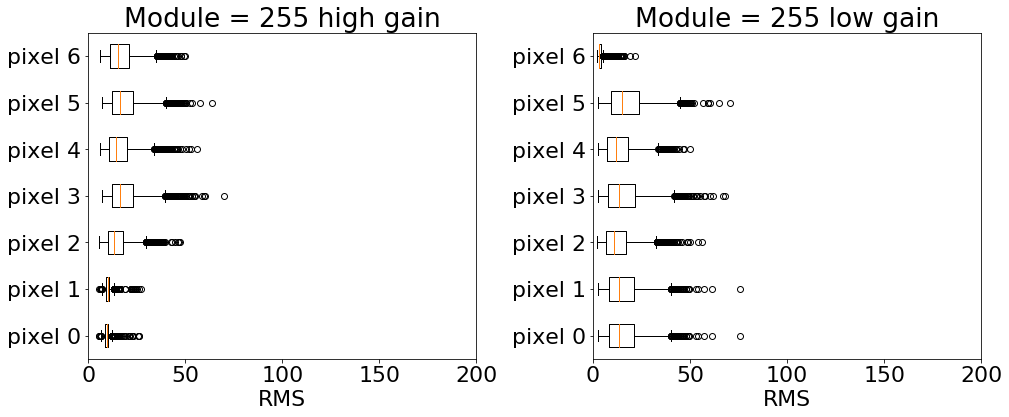

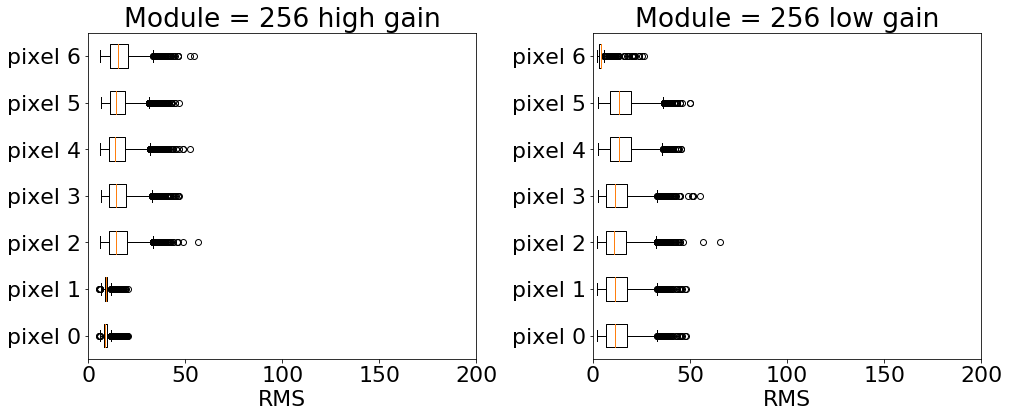

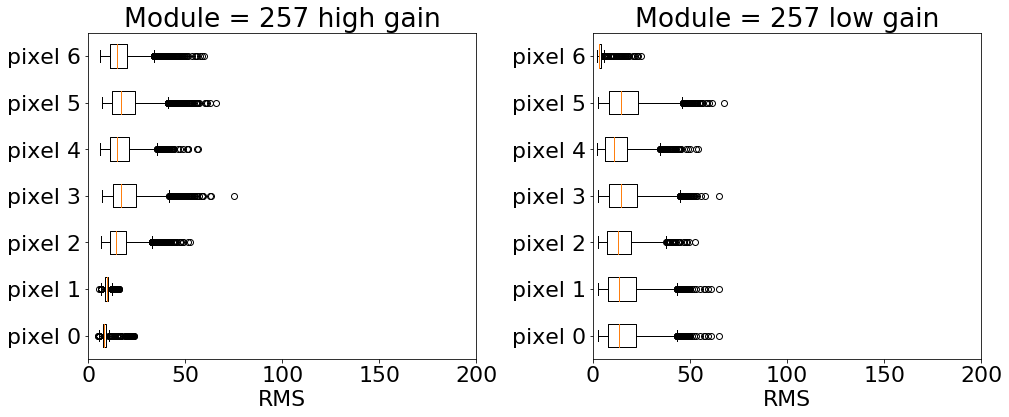

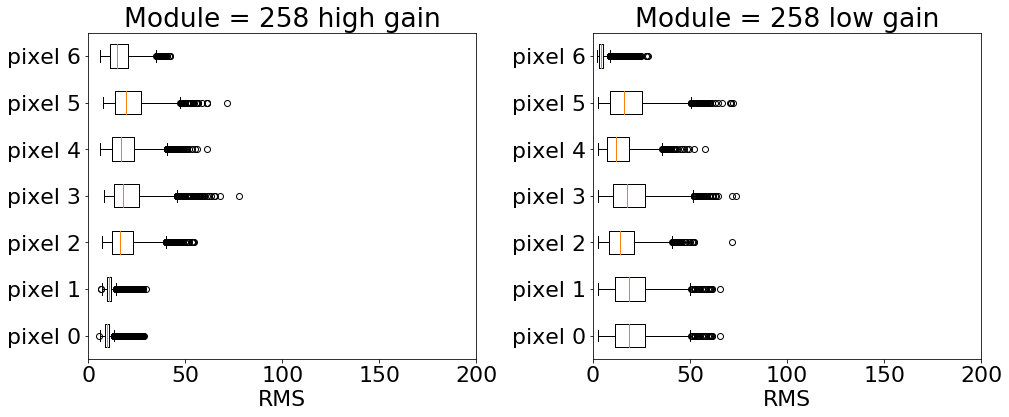

In [15]:
plt.rcParams['figure.figsize'] = (16, 6)
for nr in range(0, NR):  # Here you can chose for which module you want make box plot  
    plot_box(nr, rms_cap_array)

# Historgram of mean RMS of capacitor for all pixels

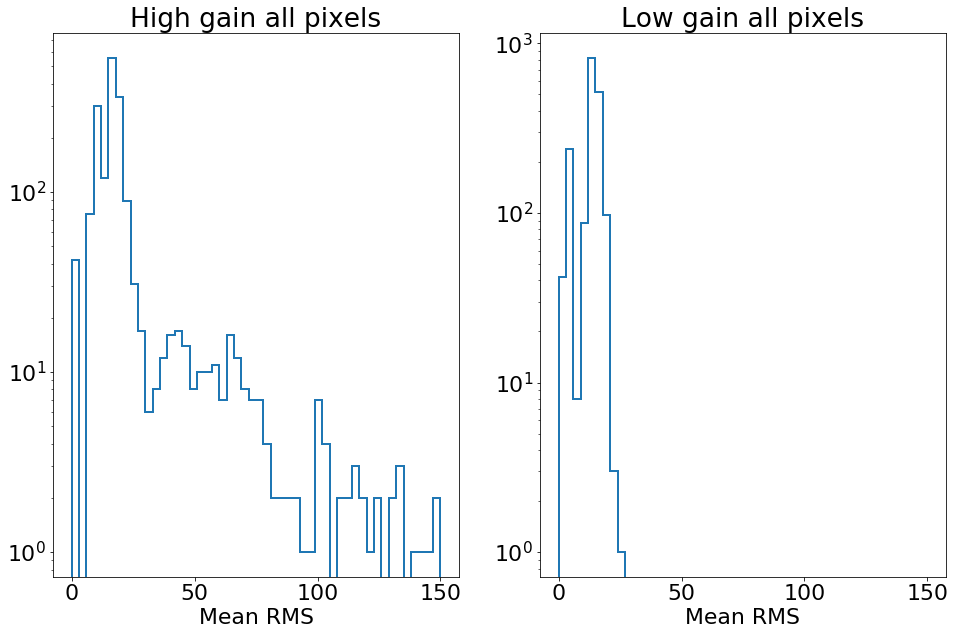

In [22]:

fig, ax0 = plt.subplots(1, 2)
ax0[0].hist(rms_cap_mean_array[:, 0, :].ravel(), bins=50, range=(0, 150), histtype='step', lw=2)
ax0[0].set_xlabel("Mean RMS")
ax0[0].set_ylabel("")
ax0[0].set_yscale('log')
ax0[0].set_title("High gain all pixels")
ax0[1].hist(rms_cap_mean_array[:, 1, :].ravel(), bins=50, range=(0, 150), histtype='step', lw=2)
ax0[1].set_xlabel("Mean RMS")
ax0[1].set_yscale('log')
ax0[1].set_title("Low gain all pixels")
plt.show()

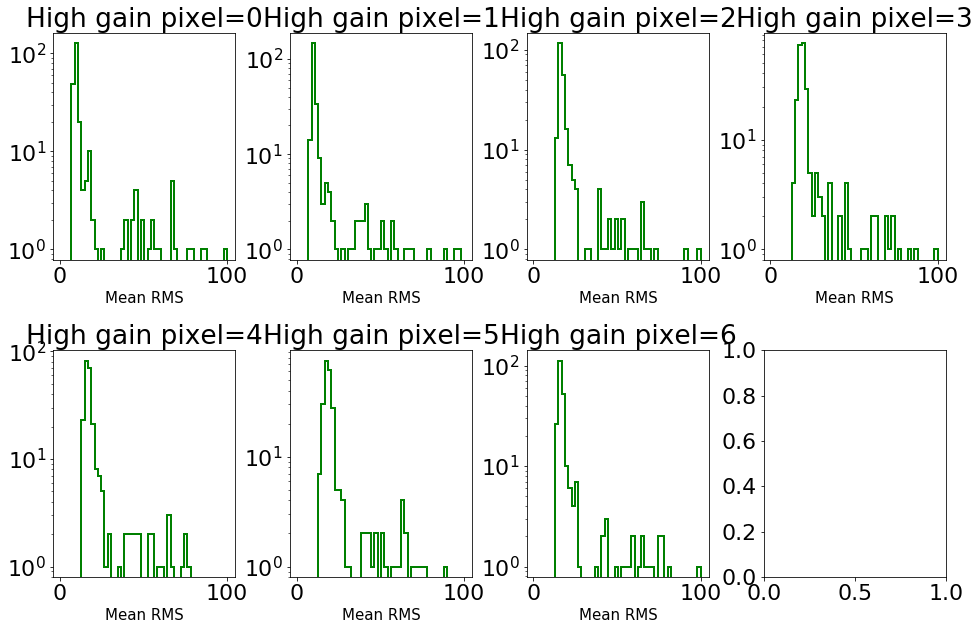

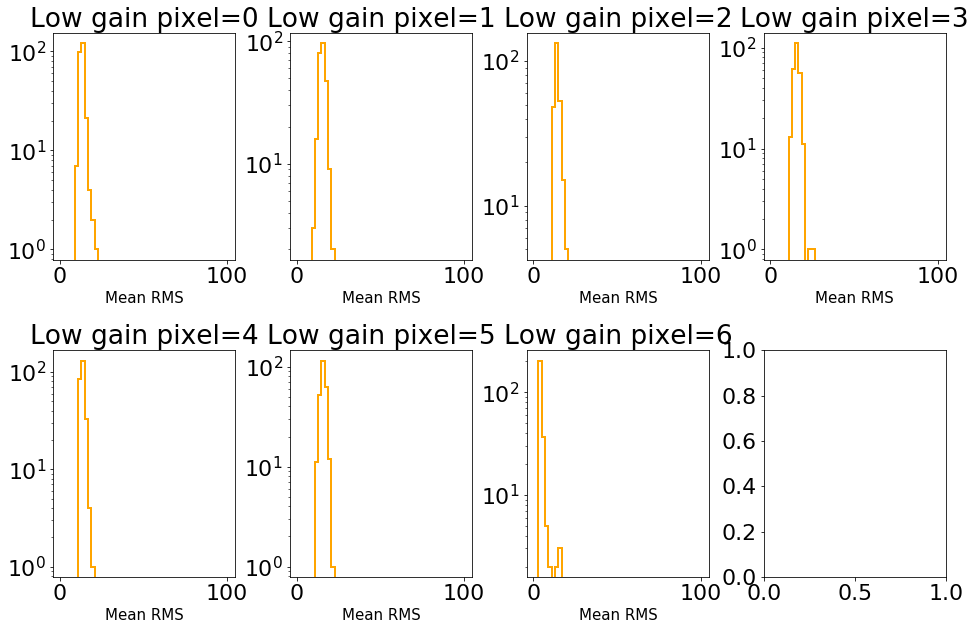

In [21]:
plt.rcParams['figure.figsize'] = (16, 10)
matplotlib.rcParams.update({'font.size': 22})

fig, ax = plt.subplots(2, 4)

for i in [0,1,2,3]:
    ax[0, i].hist(rms_cap_mean_array[:, 0, i].ravel(), bins=50, range=(1, 100), histtype='step', color="green", lw=2)
    ax[0, i].set_yscale('log')
    ax[0, i].set_title("High gain pixel={}".format(i))
    ax[0, i].set_xlabel("Mean RMS", size=15)
for i in [0, 1, 2]:
    ax[1, i].hist(rms_cap_mean_array[:, 0, i+4].ravel(), bins=50, range=(1, 100), histtype='step', color="green", lw=2)
    ax[1, i].set_yscale('log')
    ax[1, i].set_title("High gain pixel={}".format(i+4))
    ax[1, i].set_xlabel("Mean RMS", size=15)
plt.subplots_adjust(wspace=0.3, hspace=0.4)
plt.show()

fig, ax = plt.subplots(2,4)
for i in [0,1,2,3]:
    ax[0, i].hist(rms_cap_mean_array[:, 1, i].ravel(), bins=50, range=(1, 100), histtype='step', color="orange", lw=2)
    ax[0, i].set_yscale('log')
    ax[0, i].set_title("Low gain pixel={}".format(i))
    ax[0, i].set_xlabel("Mean RMS", size=15)
for i in [0, 1, 2]:
    ax[1, i].hist(rms_cap_mean_array[:, 1, i+4].ravel(), bins=50, range=(1, 100), histtype='step', color="orange", lw=2)
    ax[1, i].set_yscale('log')
    ax[1, i].set_title("Low gain pixel={}".format(i+4))
    ax[1, i].set_xlabel("Mean RMS", size=15)
plt.subplots_adjust(wspace=0.3, hspace=0.4)
plt.show()